## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os, fnmatch
import glob
%matplotlib inline

save_path = './output_images/'

Could not find corners. Image name is ./camera_cal/calibration1.jpg
Successfully loaded ./camera_cal/calibration10.jpg
Successfully loaded ./camera_cal/calibration11.jpg
Successfully loaded ./camera_cal/calibration12.jpg
Successfully loaded ./camera_cal/calibration13.jpg
Successfully loaded ./camera_cal/calibration14.jpg
Successfully loaded ./camera_cal/calibration15.jpg
Successfully loaded ./camera_cal/calibration16.jpg
Successfully loaded ./camera_cal/calibration17.jpg
Successfully loaded ./camera_cal/calibration18.jpg
Successfully loaded ./camera_cal/calibration19.jpg
Successfully loaded ./camera_cal/calibration2.jpg
Successfully loaded ./camera_cal/calibration20.jpg
Successfully loaded ./camera_cal/calibration3.jpg
Could not find corners. Image name is ./camera_cal/calibration4.jpg
Could not find corners. Image name is ./camera_cal/calibration5.jpg
Successfully loaded ./camera_cal/calibration6.jpg
Successfully loaded ./camera_cal/calibration7.jpg
Successfully loaded ./camera_cal/ca

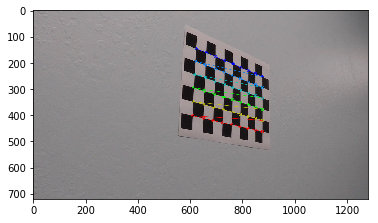

In [2]:
# camera calibration

# read in camera calibration images
cam_cal_imgs = glob.glob('./camera_cal/calibration*.jpg')

# prepare object points
nx = 9 # Chessboard size is 9x6
ny = 6 # Chessboard size is 9x6

obj_points = [] # object points
img_points = [] # image points

# prepare object points
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in cam_cal_imgs:

    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # append detected corners to the image points
        img_points.append(corners)
        obj_points.append(objp)
    
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
        print('Successfully loaded {}'.format(fname))
    else:
        print('Could not find corners. Image name is {}'.format(fname))

        #cv2.destroyAllWindows()

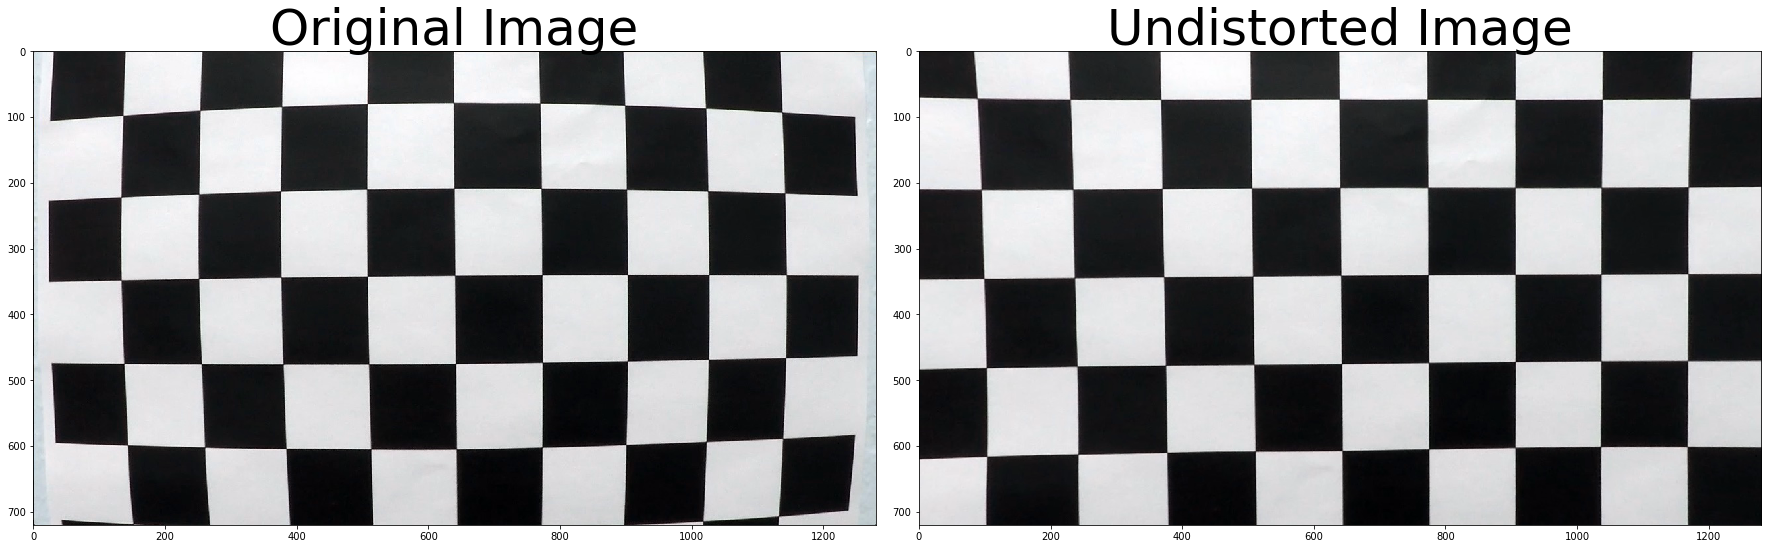

In [3]:
# use the first image as test image
img = cv2.imread(cam_cal_imgs[0])
shape = img.shape[0:2]

# perform camera calibration
# return value, camera calibration matrix, distortion coefficients, rotation and translation vectors
ret, cam_mat, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, shape, None, None)

# undistort image
undistorted = cv2.undistort(img, cam_mat, dist_coeff)

# plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(save_path + 'cam_cal_undist_chess.png')

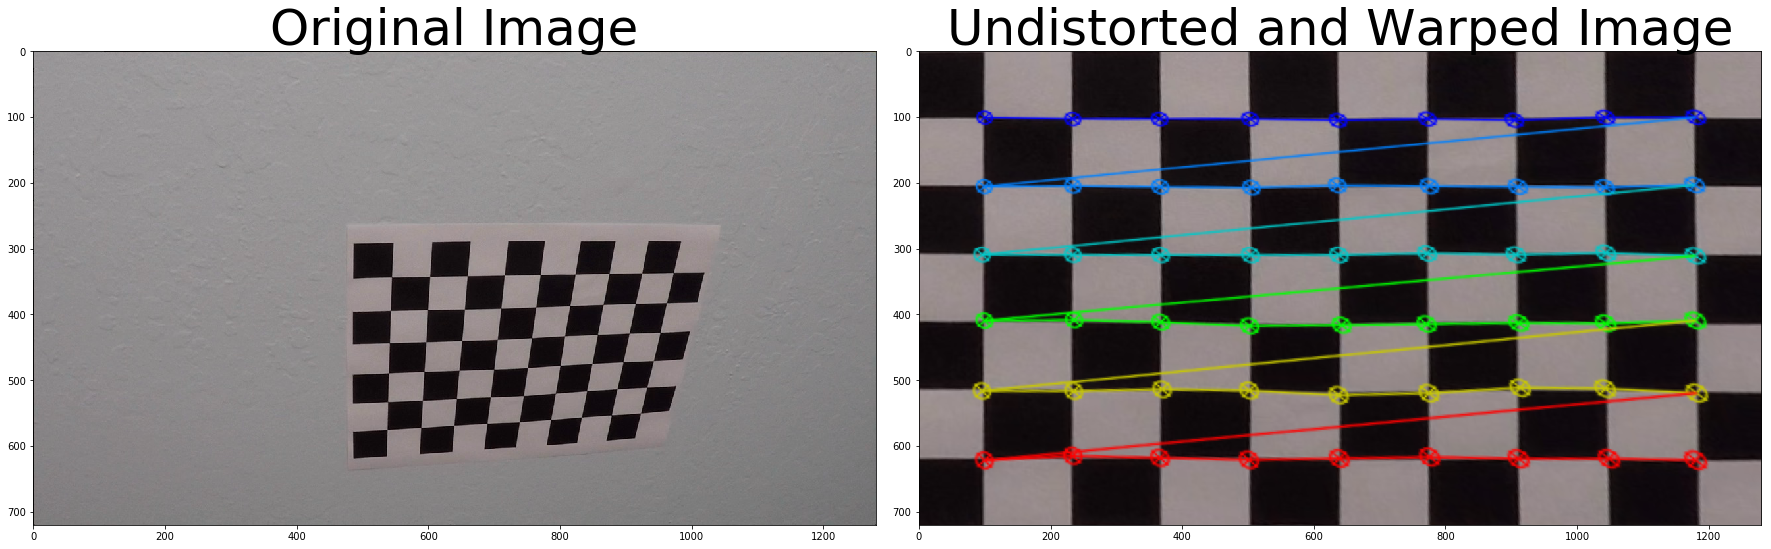

In [4]:
# unwarp images
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    if(ret):
        img_size = (gray.shape[::-1])
        offset = 100
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # dst = np.float32([[100, 100],[1100, 100],[1100, 900],[100, 900]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        M = None
        warped = np.copy(img) 
        print('Cannot unwarp image, returning the same image!')
    return warped, M

img = cv2.imread(cam_cal_imgs[1]) # choose a test image


top_down, perspective_M = corners_unwarp(img, nx, ny, cam_mat, dist_coeff)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

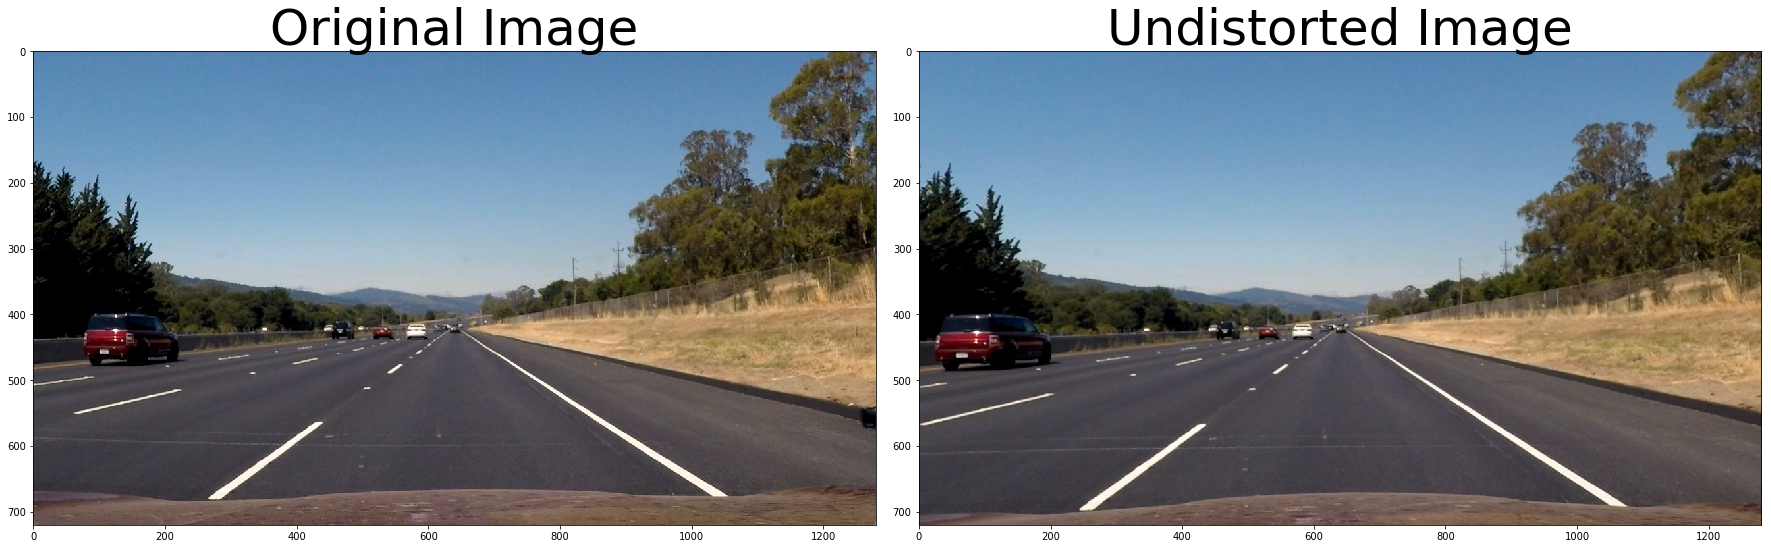

In [32]:
# undistort a test image
img = mpimg.imread('./test_images/straight_lines2.jpg')
# undistort image
undistorted = cv2.undistort(img, cam_mat, dist_coeff)


# plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(save_path + 'cam_cal_undist_car.png')

## Color and Gradient Threshold


In [5]:
# function definition

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if(orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif(orient == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    mag_binary[(scaled_sobel>=mag_thresh[0])&(scaled_sobel<=mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobel = np.sqrt(sobelx**2 + sobely **2)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    
    # 6) Return this mask as your binary_output image
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary


def combine_gradient_threshold(image):
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 63))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(128, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.75, 1.25))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

In [6]:

def color_gradient_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

# Read in an image
image = mpimg.imread('../Lesson16AdvancedLaneFinding/signs_vehicles_xygrad.png')

combined = color_gradient_threshold(image)
mag_binary = mag_thresh(image, sobel_kernel=5, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=5, thresh=(0.75, 1.25))  

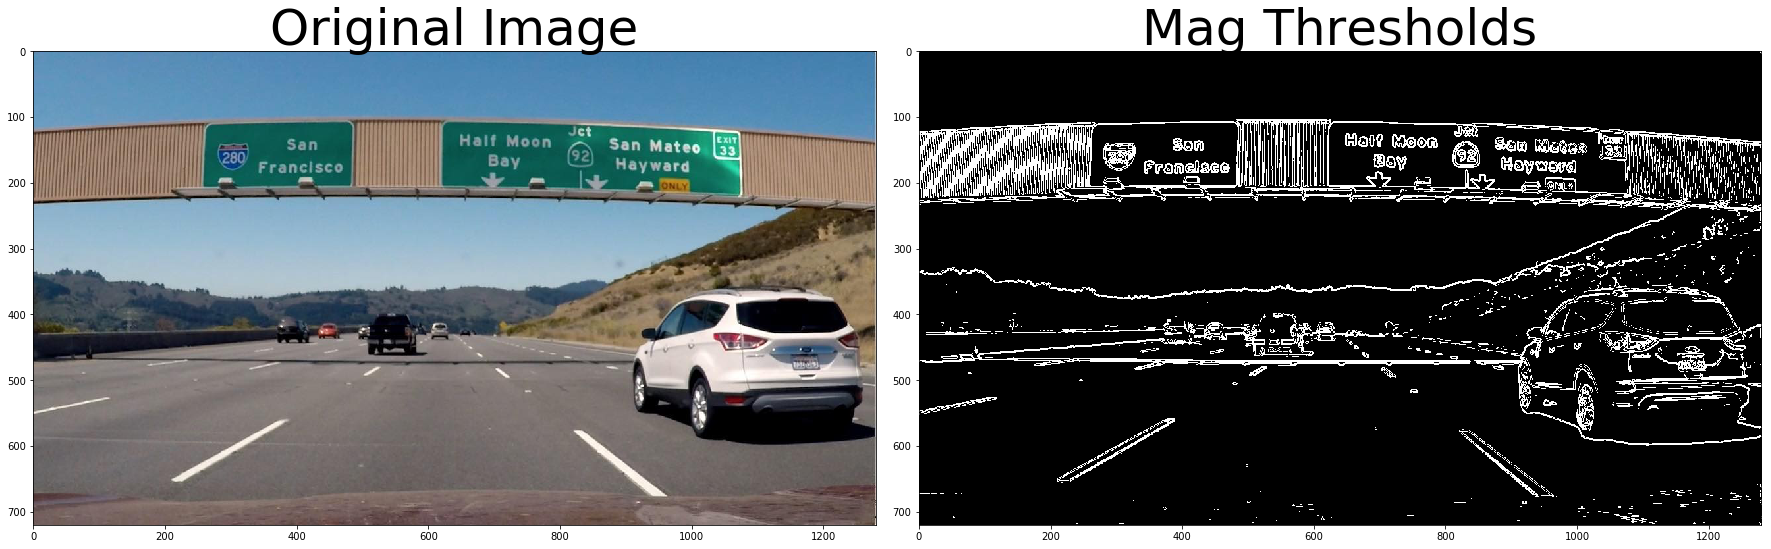

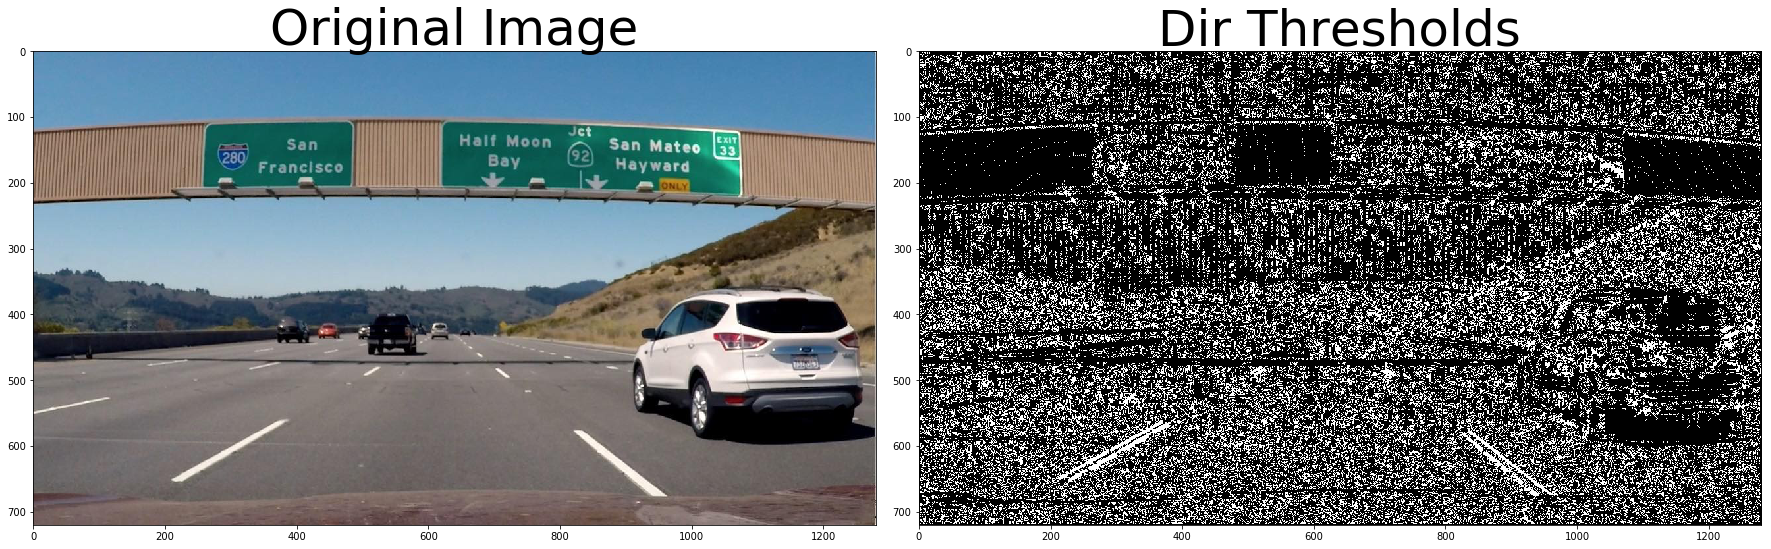

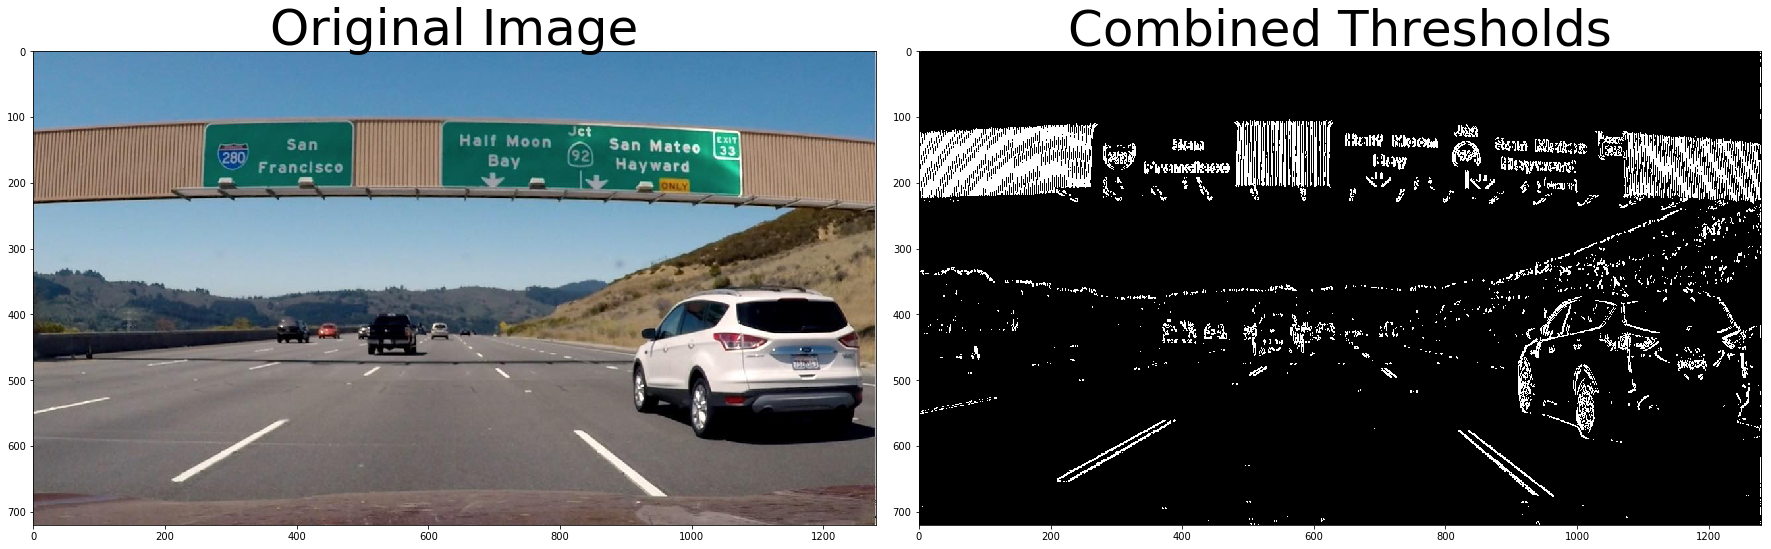

In [7]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Mag Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Dir Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(save_path + 'color_grad_combined_thresh.png')

## Perspective Transform
warp the images using perspective transform

In [8]:
# perspective transform
perspective_test_img = ['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg']
img = cv2.imread(perspective_test_img[0])

img_size = [img.shape[1], img.shape[0]]

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])


# hard coded src points
#src = np.array([[595, 450], [210, 720], [1115, 720], [685, 450]], dtype = 'int32')

# hard codede destination points
#dst = np.array([[320, 0], [320, 720], [960, 720], [960, 0]], dtype = 'int32')

# perspective transform matrix
M = cv2.getPerspectiveTransform((src), (dst))
Minv = cv2.getPerspectiveTransform((dst), (src))

In [9]:
print(src)
print(dst)

[[  585.           460.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  695.           460.        ]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


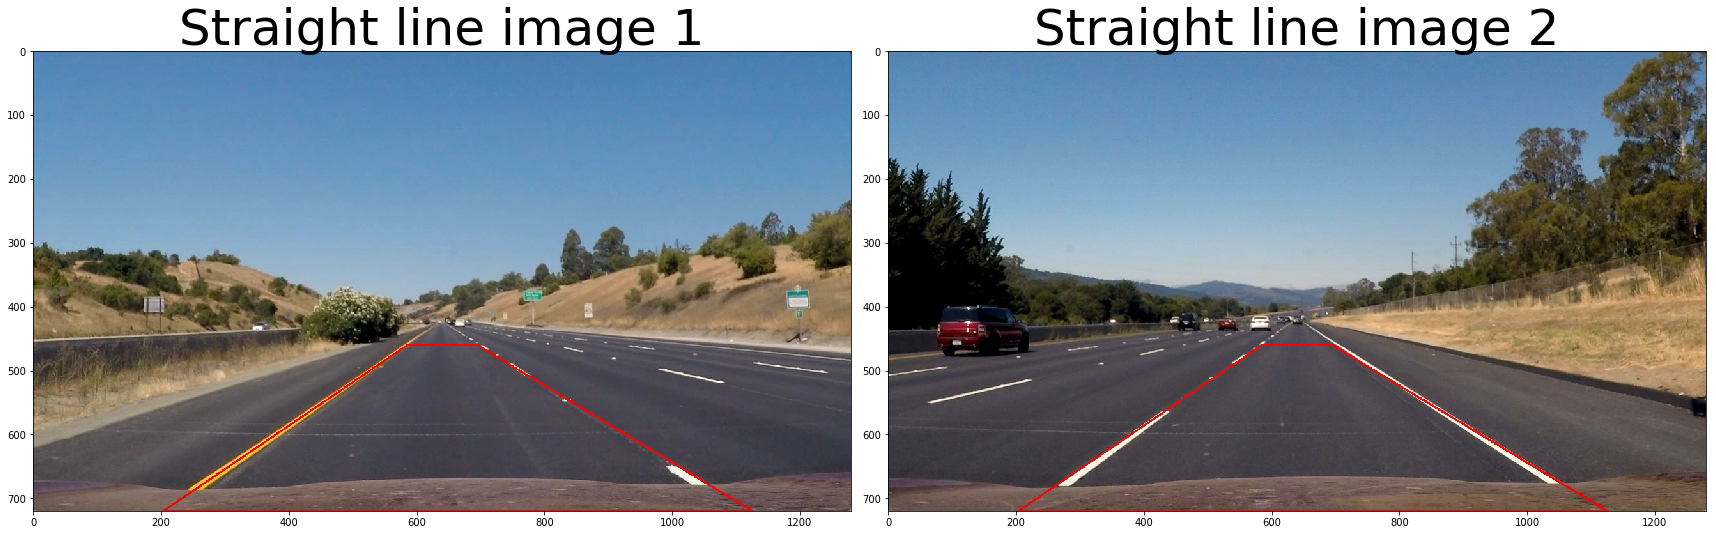

In [10]:
# visualize the polygon on two straight line images
img = cv2.imread(perspective_test_img[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
cv2.polylines(img, [np.int32(src)], True,(0,0,255), 2)
ax1.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax1.set_title('Straight line image 1', fontsize=50)

img = cv2.imread(perspective_test_img[1])
f.tight_layout()
cv2.polylines(img, [np.int32(src)], True,(0,0,255), 2)
ax2.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax2.set_title('Straight line image 2', fontsize=50)

plt.savefig(save_path + 'perspective_src_pnts.png')

In [11]:
# unwarp images

img = cv2.imread(perspective_test_img[0])
undist = cv2.undistort(img, cam_mat, dist_coeff)
img_size = (undist.shape[1], undist.shape[0])
top_down = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)


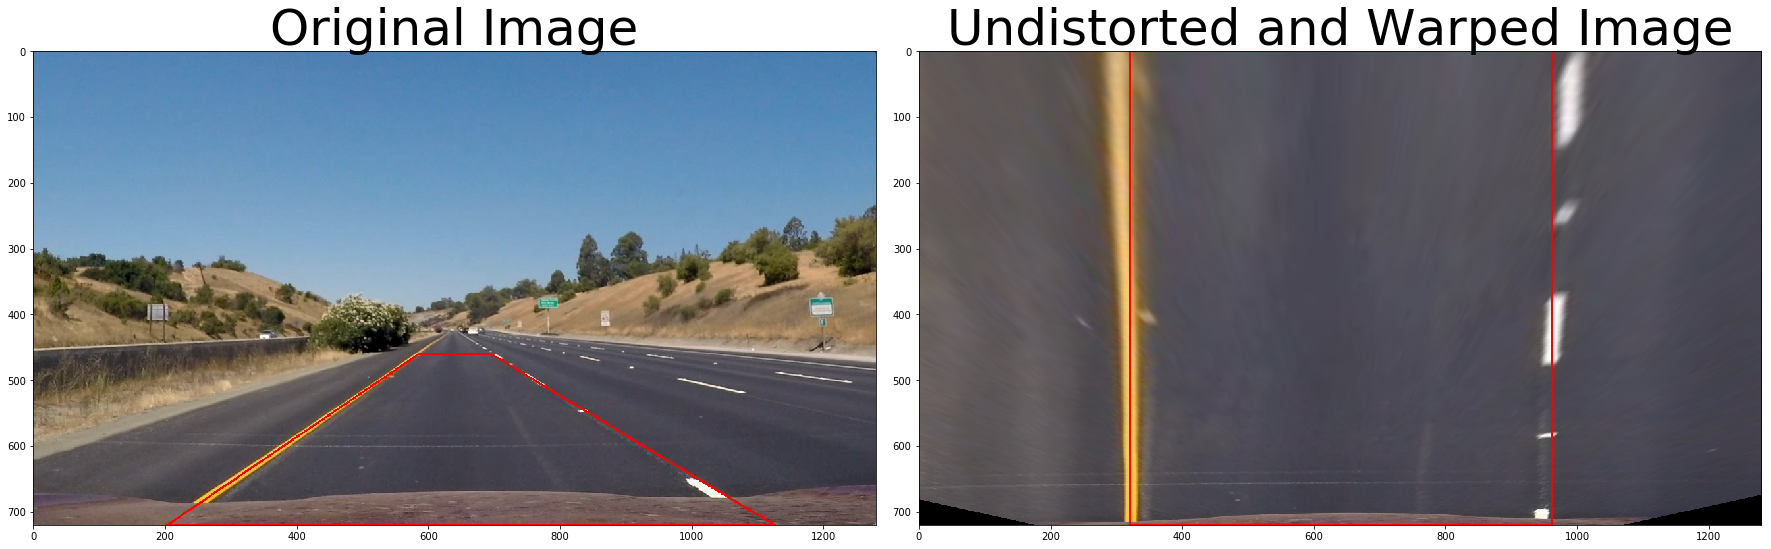

In [12]:
# plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
cv2.polylines(img, [np.int32(src)], True,(0,0,255), 2)
ax1.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax1.set_title('Original Image', fontsize=50)

cv2.polylines(top_down, [np.int32(dst)], True,(0,0,255), 2)
ax2.imshow((cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB)))
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig(save_path + 'perspective_transform_example')

## Finding the Lanes

In [13]:
## here are the steps

## 1. undistort image
# undistorted = cv2.undistort(img, cam_mat, dist_coeff)

## 2. color and gradient thresholding 
# combined = color_gradient_threshold(image)
# mag_binary = mag_thresh(image, sobel_kernel=5, mag_thresh=(30, 100))
# dir_binary = dir_threshold(image, sobel_kernel=5, thresh=(0.75, 1.25))  

## 3. unwarp the images
# top_down = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

def unwarp_image(img, cam_mat, dist_coeff, M):
    undistorted = cv2.undistort(img, cam_mat, dist_coeff)
    combined = color_gradient_threshold(undistorted)
    img_size = (img.shape[1], img.shape[0])
    top_down = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    return top_down

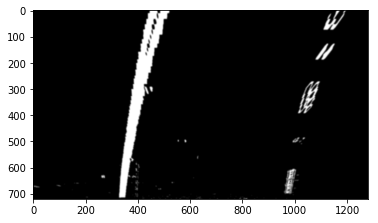

In [14]:

img = cv2.imread('./test_images/test3.jpg')
binary_warped = unwarp_image(img, cam_mat, dist_coeff, M)
plt.imshow(binary_warped, cmap = 'gray', interpolation = 'bicubic')

/Users/xingchihe/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


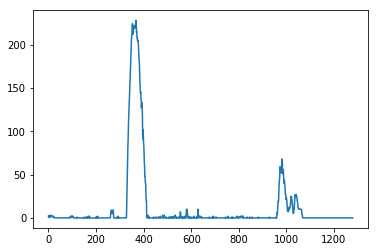

In [15]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [16]:
def sliding_window_test(binary_warped):
    overlay = True

    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if(overlay):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
      
    if(overlay):
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
    return out_img, leftx, lefty, rightx, righty

/Users/xingchihe/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


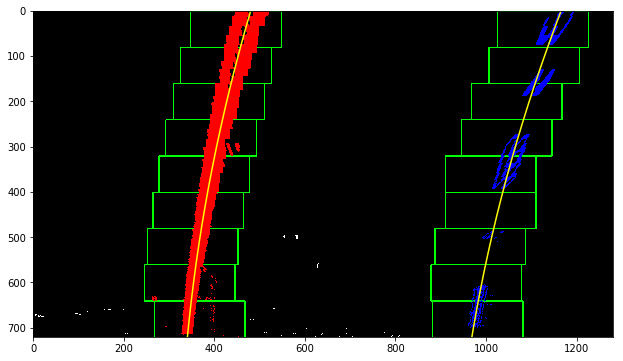

In [17]:
# visualization

out_img, leftx, lefty, rightx, righty = sliding_window_test(binary_warped)

    
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
    
    
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#out_img[lefty, leftx] = [255, 0, 0]
#out_img[righty, rightx] = [0, 0, 255]

plt.figure(figsize=(16,6))
plt.imshow(np.uint8(out_img), vmin = 0, vmax=255)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig(save_path + 'sliding_window.png')

## Skip the sliding windows step once you know where the lines are

In [18]:


# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



(720, 0)

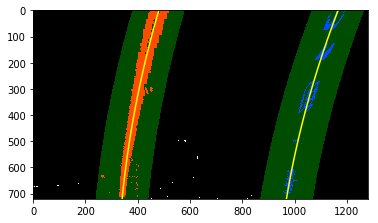

In [19]:
## visualize the result here as well
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(np.uint8(result))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Sliding Window Search - using convolution

In [20]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

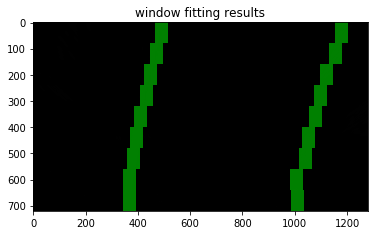

In [21]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

img = cv2.imread('./test_images/test6.jpg')
warped = unwarp_image(img, cam_mat, dist_coeff, M)

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows    
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(np.uint8(output))
plt.title('window fitting results')
plt.show()

## Measuring Curvature

In [22]:
def draw_lane(warped, undist, left_fitx, right_fitx, ploty, mode = 1):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    if mode == 1:
        result = undist
    else:        
        result = np.dstack((warped*255, warped*255, warped*255))
            
    if((left_fitx is not None) and (right_fitx is not None)):
        if((left_fitx.size == ploty.size) and (right_fitx.size==ploty.size)):
            # Recast the x and y points into usable format for cv2.fillPoly()
            pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
            pts = np.hstack((pts_left, pts_right))

            cv2.polylines(color_warp, np.int_(pts_left.reshape((-1,1,2))), True, (255, 0, 0), thickness = 50 )
            cv2.polylines(color_warp, np.int_(pts_right.reshape((-1,1,2))), True, (0, 0, 255), thickness = 50 )

            # Draw the lane onto the warped blank image
            cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

            # Warp the blank back to original image space using inverse perspective matrix (Minv)
            newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
            # Combine the result with the original image
            if mode == 1:
                result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
            else:
                result = cv2.addWeighted(np.dstack((warped*255, warped*255, warped*255)), 0.5, color_warp, 0.3, 0)

    return result

In [23]:
def sliding_window(binary_warped):
 
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx, lefty, rightx, righty


def increment_window(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty

In [24]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
        
        self.recent_fit = []
        
        self.cnt = 0
        
class CenterLine():
    def __init__(self):
    
        self.best_pos = None     
        self.best_curv = None  
        
        self.recent_pos = []
        self.recent_curv = []



In [25]:
def polynomial_fit(x, y):
     # Fit a second order polynomial to each
    fit  = np.polyfit(y, x, 2)  
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    return fit, fitx

def calc_curv(x, y):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    y_eval = np.max(y)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curvature
    
def process_lane(lane, x, y, ploty, img_center, n):
    max_curv_diff = 50
    #curvature_min = 175
    curvature_min = 100
    #curvature_max = 1400 # this can be infinity
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    fit, fitx  = polynomial_fit(x, y)  
    curvature = calc_curv(fitx, ploty)
      
    print('curvature : {}'.format(curvature))
    
    if((x is not None) and (curvature > curvature_min)):  #(curvature < curvature_max)):
            
        lane.cnt = 0 
        lane.detected = True
        lane.curvature = curvature
        print('curvature updated : {}'.format(curvature))
        
        #distance in meters of vehicle center from the line
        lane.line_base_pos = (img_center - fitx[-1]) * xm_per_pix
        
        if lane.bestx is None:
            lane.bestx = np.mean(lane.recent_xfitted, axis=0)
            
        if(len(lane.recent_fit) >= n):
            # x values of the last n fits of the line
            lane.recent_xfitted.pop(0)

            # recent polynomial fit
            lane.recent_fit.pop(0)     
        
        # x values of the last n fits of the line
        lane.recent_xfitted.append(fitx)
        
        # last n fits of the line
        lane.recent_fit.append(fit)
        
        #average x values of the fitted line over the last n iterations
        lane.bestx = np.mean(lane.recent_xfitted, axis=0) 
        
        #polynomial coefficients averaged over the last n iterations
        lane.best_fit = np.mean(lane.recent_fit, axis=0)   
    
        #difference in fit coefficients between last and new fits
        lane.diffs = lane.current_fit - fit
        
        #x values for detected line pixels
        lane.allx = x  
        #y values for detected line pixels
        lane.ally = y
        
        # Copy the polynomial fit
        lane.current_fit = fit
        
    else:
        print('curvature failed cnt: {}'.format(lane.cnt))
        
        lane.cnt = lane.cnt + 1
        
        
        if(len(lane.recent_xfitted)>2):
            # x values of the last n fits of the line
            lane.recent_xfitted.pop(0)
        
            # last n fits of the line
            lane.recent_fit.pop(0)
            
            #average x values of the fitted line over the last n iterations
            lane.bestx = np.mean(lane.recent_xfitted, axis=0) 
        
            #polynomial coefficients averaged over the last n iterations
            lane.best_fit = np.mean(lane.recent_fit, axis=0)   
    
        if lane.cnt >= n:
            lane.detected = False
            
    return lane

In [26]:
def process_image(img):
    global lane_l 
    global lane_r
    global center
    
    # parameters
    n = 10 # avaerage over the past n frames
    img_center = img.shape[1]/2
  
    # parameters are cam_mat, dist_coeff, and M
    # undistort image
    undistorted = cv2.undistort(img, cam_mat, dist_coeff)
    # color and gradient thresholding
    combined = color_gradient_threshold(undistorted)
    img_size = (img.shape[1], img.shape[0])
    
    # perspective transform
    binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    if(lane_l.detected and lane_r.detected):
        leftx, lefty, rightx, righty = increment_window(binary_warped, lane_l.best_fit, lane_r.best_fit)
        #leftx, lefty, rightx, righty = sliding_window(binary_warped)
    else:
        leftx, lefty, rightx, righty = sliding_window(binary_warped)
        
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
    lane_l = process_lane(lane_l, leftx,  lefty,  ploty, img_center, n)
    lane_r = process_lane(lane_r, rightx, righty, ploty, img_center, n)
    
    if(lane_l.line_base_pos is not None):  
        if(lane_l.line_base_pos <  50*3.7/700):
            lane_l.detected = False
    
    if(lane_r.line_base_pos is not None):  
        if(lane_r.line_base_pos > -50*3.7/700):
            lane_r.detected = False
        
    if(lane_l.detected and lane_r.detected):
        if((lane_l.curvature is not None) and (lane_r.curvature is not None)):
            if(len(center.recent_curv)>=n):
                center.recent_curv.pop(0)
            center.recent_curv.append(np.mean([lane_l.curvature, lane_r.curvature]))
            center.best_curv = np.mean(center.recent_curv, axis = 0)


        if((lane_l.line_base_pos is not None) and (lane_r.line_base_pos is not None)):
            if(len(center.recent_pos)>=n):
                center.recent_pos.pop(0)
            center.recent_pos.append(np.mean([lane_l.line_base_pos, lane_r.line_base_pos]))
            center.best_pos = np.mean(center.recent_pos, axis = 0)

    out_img = draw_lane(binary_warped, undistorted, lane_l.bestx, lane_r.bestx, ploty, 1)
    
    text_curv = 'Radius of Curvature is ' + '{0:.3f}'.format(center.best_curv) + ' (m)'
    text_pos  = 'Vehicle is ' + '{0:.3f}'.format(center.best_pos)  + ' m from the center'

    cv2.putText(out_img,  text_curv, (75, 75) , cv2.FONT_HERSHEY_SIMPLEX, 1.5, [255, 255, 255])
    cv2.putText(out_img,  text_pos,  (75, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, [255, 255, 255])
    
    return out_img

In [33]:
# extract frames from the video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time
clip1 = VideoFileClip("project_video.mp4")
k = -1
t = 0
frame = []

while t < clip1.duration:
    k = k + 1
    frame.append(clip1.get_frame(t)) # gets the picture at time ``t``
    #imdisplay( picture )        # display the picture
    t = t + 1.0/25              # increment time
    #time.sleep( 1.0/25 ) 
frames = np.array(frame)

curvature : 771.6273074440935
curvature updated : 771.6273074440935
curvature : 680.5136429132046
curvature updated : 680.5136429132046


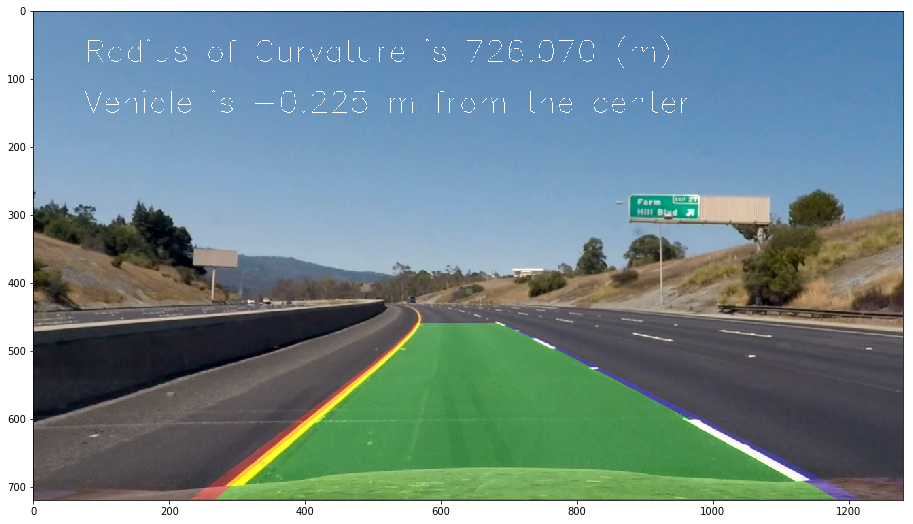

In [34]:
lane_l = Line()
lane_r = Line()
center = CenterLine()
test_results = process_image(frames[30,:,:,:])
plt.figure(figsize=(24,9))
plt.imshow(np.uint8(test_results))

In [35]:
# process project video
lane_l = Line()
lane_r = Line()
center = CenterLine()
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

curvature : 643.1662795990025
curvature updated : 643.1662795990025
curvature : 963.0285298164935
curvature updated : 963.0285298164935
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

curvature : 637.035133366412
curvature updated : 637.035133366412
curvature : 942.6894614763556
curvature updated : 942.6894614763556


  0%|          | 1/1261 [00:00<03:26,  6.11it/s]

curvature : 670.3268915792748
curvature updated : 670.3268915792748
curvature : 1032.1830935684288
curvature updated : 1032.1830935684288


  0%|          | 2/1261 [00:00<03:30,  5.97it/s]

curvature : 648.1950045114129
curvature updated : 648.1950045114129
curvature : 708.0147612498774
curvature updated : 708.0147612498774


  0%|          | 4/1261 [00:00<03:28,  6.03it/s]

curvature : 663.930297800016
curvature updated : 663.930297800016
curvature : 653.2065087826564
curvature updated : 653.2065087826564
curvature : 652.1966176505445
curvature updated : 652.1966176505445
curvature : 704.2505590616956
curvature updated : 704.2505590616956


  0%|          | 5/1261 [00:00<03:37,  5.77it/s]

curvature : 688.9281742733665
curvature updated : 688.9281742733665
curvature : 990.6592303915318
curvature updated : 990.6592303915318


  1%|          | 7/1261 [00:01<03:28,  6.03it/s]

curvature : 673.0762157373794
curvature updated : 673.0762157373794
curvature : 1097.1191190976688
curvature updated : 1097.1191190976688


  1%|          | 8/1261 [00:01<03:26,  6.08it/s]

curvature : 656.837221174195
curvature updated : 656.837221174195
curvature : 2921.5593968846892
curvature updated : 2921.5593968846892


  1%|          | 9/1261 [00:01<03:21,  6.21it/s]

curvature : 706.617910640092
curvature updated : 706.617910640092
curvature : 1360.8976114171298
curvature updated : 1360.8976114171298
curvature : 735.0318600088805
curvature updated : 735.0318600088805
curvature : 2237.647495773316
curvature updated : 2237.647495773316


  1%|          | 11/1261 [00:01<03:26,  6.04it/s]

curvature : 762.4107549940716
curvature updated : 762.4107549940716
curvature : 1663.8036352956658
curvature updated : 1663.8036352956658


  1%|          | 12/1261 [00:01<03:24,  6.12it/s]

curvature : 826.5051010554004
curvature updated : 826.5051010554004
curvature : 2534.9333793755513
curvature updated : 2534.9333793755513


  1%|          | 13/1261 [00:02<03:25,  6.08it/s]

curvature : 841.7540083489686
curvature updated : 841.7540083489686
curvature : 1713.6155842020983
curvature updated : 1713.6155842020983
curvature : 892.4454547215034
curvature updated : 892.4454547215034
curvature : 3551.537616990088
curvature updated : 3551.537616990088


  1%|          | 15/1261 [00:02<03:21,  6.18it/s]

curvature : 972.551535738976
curvature updated : 972.551535738976
curvature : 1175.3954362086527
curvature updated : 1175.3954362086527


  1%|▏         | 16/1261 [00:02<03:22,  6.14it/s]

curvature : 1260.8812414259826
curvature updated : 1260.8812414259826
curvature : 1162.0361734711444
curvature updated : 1162.0361734711444


  1%|▏         | 17/1261 [00:02<03:23,  6.12it/s]

curvature : 994.7225687575736
curvature updated : 994.7225687575736
curvature : 1566.8638725214523
curvature updated : 1566.8638725214523


  1%|▏         | 18/1261 [00:03<03:50,  5.40it/s]

curvature : 1092.003688318462
curvature updated : 1092.003688318462
curvature : 1618.0929301738443
curvature updated : 1618.0929301738443
curvature : 1123.242389570886
curvature updated : 1123.242389570886
curvature : 1634.958727045542
curvature updated : 1634.958727045542


  2%|▏         | 20/1261 [00:03<03:43,  5.56it/s]

curvature : 1167.7068602613817
curvature updated : 1167.7068602613817
curvature : 1841.242873401971
curvature updated : 1841.242873401971
curvature : 1181.1358483721258
curvature updated : 1181.1358483721258
curvature : 7168.057171808142
curvature updated : 7168.057171808142


  2%|▏         | 23/1261 [00:03<03:29,  5.92it/s]

curvature : 1269.03430251402
curvature updated : 1269.03430251402
curvature : 6585.489795076765
curvature updated : 6585.489795076765
curvature : 1201.447951048326
curvature updated : 1201.447951048326
curvature : 8487.022705581541
curvature updated : 8487.022705581541


  2%|▏         | 25/1261 [00:04<03:18,  6.22it/s]

curvature : 1119.3706647251256
curvature updated : 1119.3706647251256
curvature : 1050.2623242922903
curvature updated : 1050.2623242922903
curvature : 955.0289178454016
curvature updated : 955.0289178454016
curvature : 871.5168877313938
curvature updated : 871.5168877313938


  2%|▏         | 27/1261 [00:04<03:19,  6.17it/s]

curvature : 1032.3861897852394
curvature updated : 1032.3861897852394
curvature : 1062.258454084717
curvature updated : 1062.258454084717
curvature : 948.8809369773203
curvature updated : 948.8809369773203
curvature : 1253.5584407839874
curvature updated : 1253.5584407839874


  2%|▏         | 29/1261 [00:04<03:12,  6.41it/s]

curvature : 997.8483986361306
curvature updated : 997.8483986361306
curvature : 1271.445061818497
curvature updated : 1271.445061818497
curvature : 1054.2779740307926
curvature updated : 1054.2779740307926
curvature : 857.4411245933256
curvature updated : 857.4411245933256


  2%|▏         | 31/1261 [00:05<03:13,  6.35it/s]

curvature : 915.5163387524836
curvature updated : 915.5163387524836
curvature : 575.8253536703252
curvature updated : 575.8253536703252
curvature : 723.7882700715495
curvature updated : 723.7882700715495
curvature : 728.3352007368732
curvature updated : 728.3352007368732


  3%|▎         | 32/1261 [00:05<03:14,  6.33it/s]

curvature : 667.7621930928659
curvature updated : 667.7621930928659
curvature : 1000.399022292938
curvature updated : 1000.399022292938
curvature : 676.158933717155
curvature updated : 676.158933717155
curvature : 2165.5533083755954
curvature updated : 2165.5533083755954


  3%|▎         | 35/1261 [00:05<03:15,  6.27it/s]

curvature : 627.7977747236724
curvature updated : 627.7977747236724
curvature : 4522.322966937118
curvature updated : 4522.322966937118
curvature : 606.3648689393378
curvature updated : 606.3648689393378
curvature : 4664.783453151097
curvature updated : 4664.783453151097


  3%|▎         | 37/1261 [00:06<03:21,  6.07it/s]

curvature : 599.7397553805689
curvature updated : 599.7397553805689
curvature : 1017.4177879590671
curvature updated : 1017.4177879590671
curvature : 577.0024898145676
curvature updated : 577.0024898145676
curvature : 966.8109522302523
curvature updated : 966.8109522302523


  3%|▎         | 39/1261 [00:06<03:18,  6.16it/s]

curvature : 547.190211749493
curvature updated : 547.190211749493
curvature : 1825.2978600749377
curvature updated : 1825.2978600749377
curvature : 528.322886652058
curvature updated : 528.322886652058
curvature : 1069.4881573873943
curvature updated : 1069.4881573873943


  3%|▎         | 40/1261 [00:06<03:16,  6.21it/s]

curvature : 532.5129942589451
curvature updated : 532.5129942589451
curvature : 653.8505103489856
curvature updated : 653.8505103489856
curvature : 519.3505659487372
curvature updated : 519.3505659487372
curvature : 706.7149507462681
curvature updated : 706.7149507462681


  3%|▎         | 42/1261 [00:06<03:20,  6.09it/s]

curvature : 535.5103517640849
curvature updated : 535.5103517640849
curvature : 647.9174746512452
curvature updated : 647.9174746512452
curvature : 503.2644410167768
curvature updated : 503.2644410167768
curvature : 638.68572137934
curvature updated : 638.68572137934


  3%|▎         | 44/1261 [00:07<03:34,  5.67it/s]

curvature : 550.7673677333493
curvature updated : 550.7673677333493
curvature : 664.0071353740298
curvature updated : 664.0071353740298
curvature : 610.3070093206829
curvature updated : 610.3070093206829
curvature : 873.9516908924353
curvature updated : 873.9516908924353


  4%|▎         | 46/1261 [00:07<03:49,  5.30it/s]

curvature : 616.7997481411518
curvature updated : 616.7997481411518
curvature : 2091.430905976777
curvature updated : 2091.430905976777
curvature : 641.4035851122925
curvature updated : 641.4035851122925
curvature : 3567.930219448553
curvature updated : 3567.930219448553


  4%|▍         | 49/1261 [00:08<03:18,  6.12it/s]

curvature : 670.1856881437819
curvature updated : 670.1856881437819
curvature : 2395.2445955080066
curvature updated : 2395.2445955080066
curvature : 691.4957396180173
curvature updated : 691.4957396180173
curvature : 995.5688077469594
curvature updated : 995.5688077469594


  4%|▍         | 51/1261 [00:08<03:04,  6.54it/s]

curvature : 738.8949968982052
curvature updated : 738.8949968982052
curvature : 752.6893560160482
curvature updated : 752.6893560160482
curvature : 800.9824257794395
curvature updated : 800.9824257794395
curvature : 1063.155745844407
curvature updated : 1063.155745844407


  4%|▍         | 53/1261 [00:08<03:06,  6.48it/s]

curvature : 842.5201111308226
curvature updated : 842.5201111308226
curvature : 1064.0291337235915
curvature updated : 1064.0291337235915
curvature : 894.0380318376695
curvature updated : 894.0380318376695
curvature : 633.0904906431343
curvature updated : 633.0904906431343


  4%|▍         | 54/1261 [00:08<03:08,  6.39it/s]

curvature : 925.2306918932943
curvature updated : 925.2306918932943
curvature : 666.799801042573
curvature updated : 666.799801042573
curvature : 962.0403396631227
curvature updated : 962.0403396631227
curvature : 667.8530284824973
curvature updated : 667.8530284824973


  5%|▍         | 57/1261 [00:09<03:19,  6.05it/s]

curvature : 1067.9238676105947
curvature updated : 1067.9238676105947
curvature : 684.8912027721562
curvature updated : 684.8912027721562
curvature : 1169.4318429391485
curvature updated : 1169.4318429391485
curvature : 873.5060350370583
curvature updated : 873.5060350370583


  5%|▍         | 58/1261 [00:09<03:34,  5.61it/s]

curvature : 1110.2490313396465
curvature updated : 1110.2490313396465
curvature : 1496.363256848848
curvature updated : 1496.363256848848
curvature : 1004.2911768801716
curvature updated : 1004.2911768801716
curvature : 3491.450620479966
curvature updated : 3491.450620479966


  5%|▍         | 61/1261 [00:10<03:15,  6.13it/s]

curvature : 969.7029151111609
curvature updated : 969.7029151111609
curvature : 958.3573182187766
curvature updated : 958.3573182187766
curvature : 890.6959929140954
curvature updated : 890.6959929140954
curvature : 1629.911400133677
curvature updated : 1629.911400133677


  5%|▍         | 63/1261 [00:10<03:05,  6.44it/s]

curvature : 830.9340282640451
curvature updated : 830.9340282640451
curvature : 1042.8058739947382
curvature updated : 1042.8058739947382
curvature : 794.9936144956449
curvature updated : 794.9936144956449
curvature : 1406.1080863217333
curvature updated : 1406.1080863217333


  5%|▌         | 65/1261 [00:10<03:05,  6.44it/s]

curvature : 764.9506680568456
curvature updated : 764.9506680568456
curvature : 794.7563185605571
curvature updated : 794.7563185605571
curvature : 807.6970051281509
curvature updated : 807.6970051281509
curvature : 640.3505784776438
curvature updated : 640.3505784776438


  5%|▌         | 67/1261 [00:11<03:04,  6.47it/s]

curvature : 764.2645124840482
curvature updated : 764.2645124840482
curvature : 857.2434571344808
curvature updated : 857.2434571344808
curvature : 773.7647981998509
curvature updated : 773.7647981998509
curvature : 934.0481305647223
curvature updated : 934.0481305647223


  5%|▌         | 69/1261 [00:11<03:04,  6.46it/s]

curvature : 769.3280353224859
curvature updated : 769.3280353224859
curvature : 1090.1552001114596
curvature updated : 1090.1552001114596
curvature : 790.2909356180576
curvature updated : 790.2909356180576
curvature : 1692.4901323548638
curvature updated : 1692.4901323548638


  6%|▌         | 71/1261 [00:11<02:58,  6.67it/s]

curvature : 846.0194570198192
curvature updated : 846.0194570198192
curvature : 2194.620510551393
curvature updated : 2194.620510551393
curvature : 859.9509571077014
curvature updated : 859.9509571077014
curvature : 1282.206034143508
curvature updated : 1282.206034143508


  6%|▌         | 73/1261 [00:11<02:55,  6.76it/s]

curvature : 990.3840031912736
curvature updated : 990.3840031912736
curvature : 724.0161729665341
curvature updated : 724.0161729665341
curvature : 1132.272858811389
curvature updated : 1132.272858811389
curvature : 837.0459999816583
curvature updated : 837.0459999816583


  6%|▌         | 75/1261 [00:12<02:54,  6.80it/s]

curvature : 1325.933906478398
curvature updated : 1325.933906478398
curvature : 993.5068974808675
curvature updated : 993.5068974808675
curvature : 1318.0499396146115
curvature updated : 1318.0499396146115
curvature : 1171.2238277870597
curvature updated : 1171.2238277870597


  6%|▌         | 77/1261 [00:12<02:53,  6.84it/s]

curvature : 1445.3372270257055
curvature updated : 1445.3372270257055
curvature : 761.1346973250605
curvature updated : 761.1346973250605
curvature : 1819.08415812789
curvature updated : 1819.08415812789
curvature : 745.1628252491008
curvature updated : 745.1628252491008


  6%|▋         | 79/1261 [00:12<02:55,  6.72it/s]

curvature : 2075.5513754271433
curvature updated : 2075.5513754271433
curvature : 660.2410764716566
curvature updated : 660.2410764716566
curvature : 2220.3764764410657
curvature updated : 2220.3764764410657
curvature : 550.5783348455003
curvature updated : 550.5783348455003


  6%|▋         | 81/1261 [00:13<02:54,  6.77it/s]

curvature : 2287.488413059514
curvature updated : 2287.488413059514
curvature : 549.9398958815696
curvature updated : 549.9398958815696
curvature : 1988.3099014816778
curvature updated : 1988.3099014816778
curvature : 694.5413314572226
curvature updated : 694.5413314572226


  7%|▋         | 83/1261 [00:13<02:52,  6.83it/s]

curvature : 1956.3808805906447
curvature updated : 1956.3808805906447
curvature : 801.3353708356511
curvature updated : 801.3353708356511
curvature : 1748.1049161881604
curvature updated : 1748.1049161881604
curvature : 1161.4291567149933
curvature updated : 1161.4291567149933


  7%|▋         | 85/1261 [00:13<02:52,  6.80it/s]

curvature : 1590.76782324423
curvature updated : 1590.76782324423
curvature : 1181.508965725584
curvature updated : 1181.508965725584
curvature : 1429.608009420423
curvature updated : 1429.608009420423
curvature : 2834.9586108318586
curvature updated : 2834.9586108318586


  7%|▋         | 87/1261 [00:14<02:53,  6.75it/s]

curvature : 1383.3321060154337
curvature updated : 1383.3321060154337
curvature : 16027.715554623717
curvature updated : 16027.715554623717
curvature : 1053.768800560404
curvature updated : 1053.768800560404
curvature : 1061.1519263909531
curvature updated : 1061.1519263909531


  7%|▋         | 89/1261 [00:14<03:07,  6.25it/s]

curvature : 915.7586604338186
curvature updated : 915.7586604338186
curvature : 2601.1267278639916
curvature updated : 2601.1267278639916
curvature : 783.4598942278158
curvature updated : 783.4598942278158
curvature : 1256.0723120492596
curvature updated : 1256.0723120492596


  7%|▋         | 91/1261 [00:14<03:01,  6.44it/s]

curvature : 759.9596799791344
curvature updated : 759.9596799791344
curvature : 1056.6579208084343
curvature updated : 1056.6579208084343
curvature : 762.4968234597599
curvature updated : 762.4968234597599
curvature : 836.4566945200668
curvature updated : 836.4566945200668


  7%|▋         | 92/1261 [00:14<03:03,  6.36it/s]

curvature : 754.4740239698316
curvature updated : 754.4740239698316
curvature : 803.4094700818838
curvature updated : 803.4094700818838
curvature : 702.5346664739326
curvature updated : 702.5346664739326
curvature : 1003.428993450818
curvature updated : 1003.428993450818


  8%|▊         | 95/1261 [00:15<03:00,  6.47it/s]

curvature : 695.6529183585897
curvature updated : 695.6529183585897
curvature : 1040.7838678609392
curvature updated : 1040.7838678609392
curvature : 712.4614025548968
curvature updated : 712.4614025548968
curvature : 1352.1965561183465
curvature updated : 1352.1965561183465


  8%|▊         | 96/1261 [00:15<02:56,  6.59it/s]

curvature : 732.4691697224947
curvature updated : 732.4691697224947
curvature : 3039.9603516089273
curvature updated : 3039.9603516089273
curvature : 748.6106381352655
curvature updated : 748.6106381352655
curvature : 8621.80734949744
curvature updated : 8621.80734949744


  8%|▊         | 98/1261 [00:15<03:19,  5.82it/s]

curvature : 759.9612414172009
curvature updated : 759.9612414172009
curvature : 895.8373057208543
curvature updated : 895.8373057208543
curvature : 796.6723050845007
curvature updated : 796.6723050845007
curvature : 903.1009178252539
curvature updated : 903.1009178252539


  8%|▊         | 100/1261 [00:16<03:14,  5.96it/s]

curvature : 795.3850105441788
curvature updated : 795.3850105441788
curvature : 1115.6187284734167
curvature updated : 1115.6187284734167
curvature : 785.1362011120133
curvature updated : 785.1362011120133
curvature : 1086.872069280896
curvature updated : 1086.872069280896


  8%|▊         | 103/1261 [00:16<03:11,  6.04it/s]

curvature : 803.2242037108508
curvature updated : 803.2242037108508
curvature : 709.2470854591638
curvature updated : 709.2470854591638
curvature : 837.5972419925927
curvature updated : 837.5972419925927
curvature : 526.873302152009
curvature updated : 526.873302152009


  8%|▊         | 104/1261 [00:16<03:14,  5.96it/s]

curvature : 821.8850921106254
curvature updated : 821.8850921106254
curvature : 598.630351550303
curvature updated : 598.630351550303
curvature : 807.8505829534523
curvature updated : 807.8505829534523
curvature : 650.9610298040182
curvature updated : 650.9610298040182


  8%|▊         | 107/1261 [00:17<03:08,  6.11it/s]

curvature : 877.2689995295323
curvature updated : 877.2689995295323
curvature : 646.9335622190432
curvature updated : 646.9335622190432
curvature : 832.8686270154755
curvature updated : 832.8686270154755
curvature : 636.3554295244448
curvature updated : 636.3554295244448


  9%|▊         | 108/1261 [00:17<03:15,  5.88it/s]

curvature : 766.0551907106938
curvature updated : 766.0551907106938
curvature : 787.0948131989062
curvature updated : 787.0948131989062
curvature : 771.2915679310195
curvature updated : 771.2915679310195
curvature : 1478.2406674862025
curvature updated : 1478.2406674862025


  9%|▊         | 110/1261 [00:17<03:26,  5.58it/s]

curvature : 790.6393974366786
curvature updated : 790.6393974366786
curvature : 3355.0986764985287
curvature updated : 3355.0986764985287
curvature : 749.9444216327346
curvature updated : 749.9444216327346
curvature : 1786.6642290214668
curvature updated : 1786.6642290214668


  9%|▉         | 112/1261 [00:18<03:20,  5.74it/s]

curvature : 802.8207970795079
curvature updated : 802.8207970795079
curvature : 832.3805977391241
curvature updated : 832.3805977391241
curvature : 721.6411811397086
curvature updated : 721.6411811397086
curvature : 676.7003053969123
curvature updated : 676.7003053969123


  9%|▉         | 114/1261 [00:18<03:18,  5.78it/s]

curvature : 724.6622228964566
curvature updated : 724.6622228964566
curvature : 773.6951686797785
curvature updated : 773.6951686797785
curvature : 649.6816857441439
curvature updated : 649.6816857441439


  9%|▉         | 115/1261 [00:18<03:25,  5.57it/s]

curvature : 664.0974449653352
curvature updated : 664.0974449653352
curvature : 703.5802965877263
curvature updated : 703.5802965877263
curvature : 567.480441025502
curvature updated : 567.480441025502


  9%|▉         | 117/1261 [00:19<03:37,  5.27it/s]

curvature : 659.5749108298932
curvature updated : 659.5749108298932
curvature : 571.9702014145803
curvature updated : 571.9702014145803
curvature : 652.5781392644667
curvature updated : 652.5781392644667
curvature : 622.9034036780963
curvature updated : 622.9034036780963


  9%|▉         | 119/1261 [00:19<03:39,  5.21it/s]

curvature : 664.1384386594391
curvature updated : 664.1384386594391
curvature : 674.870938255057
curvature updated : 674.870938255057
curvature : 606.9739441139308
curvature updated : 606.9739441139308
curvature : 752.2456438016228
curvature updated : 752.2456438016228


 10%|▉         | 121/1261 [00:19<03:29,  5.43it/s]

curvature : 650.5952849992916
curvature updated : 650.5952849992916
curvature : 1111.533113428713
curvature updated : 1111.533113428713


 10%|▉         | 122/1261 [00:20<03:34,  5.30it/s]

curvature : 622.5556737805462
curvature updated : 622.5556737805462
curvature : 898.9042833714658
curvature updated : 898.9042833714658
curvature : 610.718092502449
curvature updated : 610.718092502449
curvature : 663.2953956694569
curvature updated : 663.2953956694569


 10%|▉         | 124/1261 [00:20<03:30,  5.39it/s]

curvature : 599.9509802166768
curvature updated : 599.9509802166768
curvature : 1406.6160126719478
curvature updated : 1406.6160126719478
curvature : 596.4907880712547
curvature updated : 596.4907880712547
curvature : 837.6153259732737
curvature updated : 837.6153259732737


 10%|█         | 127/1261 [00:20<03:17,  5.75it/s]

curvature : 646.2407656361405
curvature updated : 646.2407656361405
curvature : 1271.2621273290154
curvature updated : 1271.2621273290154
curvature : 620.522950594212
curvature updated : 620.522950594212
curvature : 536.7250580534471
curvature updated : 536.7250580534471


 10%|█         | 129/1261 [00:21<03:00,  6.28it/s]

curvature : 660.4218455884546
curvature updated : 660.4218455884546
curvature : 513.262178896654
curvature updated : 513.262178896654
curvature : 638.568390610409
curvature updated : 638.568390610409
curvature : 573.2817170825907
curvature updated : 573.2817170825907


 10%|█         | 131/1261 [00:21<02:56,  6.41it/s]

curvature : 652.7470774223088
curvature updated : 652.7470774223088
curvature : 617.3201254384745
curvature updated : 617.3201254384745
curvature : 681.3074317637588
curvature updated : 681.3074317637588
curvature : 725.09532189998
curvature updated : 725.09532189998


 11%|█         | 133/1261 [00:21<02:52,  6.53it/s]

curvature : 675.6155278436081
curvature updated : 675.6155278436081
curvature : 780.7015237066137
curvature updated : 780.7015237066137
curvature : 703.2686447087707
curvature updated : 703.2686447087707
curvature : 911.6156449675273
curvature updated : 911.6156449675273


 11%|█         | 135/1261 [00:22<02:51,  6.56it/s]

curvature : 734.345087739152
curvature updated : 734.345087739152
curvature : 803.9594660605592
curvature updated : 803.9594660605592
curvature : 749.8473239668762
curvature updated : 749.8473239668762
curvature : 710.6764494259187
curvature updated : 710.6764494259187


 11%|█         | 137/1261 [00:22<02:58,  6.28it/s]

curvature : 772.3332945179425
curvature updated : 772.3332945179425
curvature : 902.6115333804404
curvature updated : 902.6115333804404
curvature : 790.7800404294599
curvature updated : 790.7800404294599
curvature : 1143.9957052996842
curvature updated : 1143.9957052996842


 11%|█         | 139/1261 [00:22<02:53,  6.47it/s]

curvature : 829.5794257493438
curvature updated : 829.5794257493438
curvature : 1044.906994746807
curvature updated : 1044.906994746807
curvature : 836.3558440285401
curvature updated : 836.3558440285401
curvature : 1268.2013512072592
curvature updated : 1268.2013512072592


 11%|█         | 141/1261 [00:23<02:47,  6.68it/s]

curvature : 860.7526595215066
curvature updated : 860.7526595215066
curvature : 1085.2439228519925
curvature updated : 1085.2439228519925
curvature : 860.8123311363942
curvature updated : 860.8123311363942
curvature : 705.7974046822701
curvature updated : 705.7974046822701


 11%|█▏        | 143/1261 [00:23<02:46,  6.71it/s]

curvature : 921.6792891194169
curvature updated : 921.6792891194169
curvature : 635.4131737855391
curvature updated : 635.4131737855391
curvature : 912.6117130628099
curvature updated : 912.6117130628099
curvature : 868.2377355953681
curvature updated : 868.2377355953681


 11%|█▏        | 145/1261 [00:23<02:50,  6.55it/s]

curvature : 916.5848311148059
curvature updated : 916.5848311148059
curvature : 1044.1435933462508
curvature updated : 1044.1435933462508
curvature : 982.9177940659941
curvature updated : 982.9177940659941
curvature : 1200.4225201251945
curvature updated : 1200.4225201251945


 12%|█▏        | 147/1261 [00:24<02:49,  6.57it/s]

curvature : 972.5099470318795
curvature updated : 972.5099470318795
curvature : 2347.0994310436695
curvature updated : 2347.0994310436695
curvature : 987.7517941188893
curvature updated : 987.7517941188893
curvature : 5122.645971848911
curvature updated : 5122.645971848911


 12%|█▏        | 149/1261 [00:24<02:51,  6.48it/s]

curvature : 938.8777742738836
curvature updated : 938.8777742738836
curvature : 784.2693819870757
curvature updated : 784.2693819870757
curvature : 891.0154398263118
curvature updated : 891.0154398263118
curvature : 1018.4425777116887
curvature updated : 1018.4425777116887


 12%|█▏        | 151/1261 [00:24<02:48,  6.60it/s]

curvature : 963.3067346655216
curvature updated : 963.3067346655216
curvature : 990.3276003741806
curvature updated : 990.3276003741806
curvature : 969.5448283091491
curvature updated : 969.5448283091491
curvature : 571.5672870521344
curvature updated : 571.5672870521344


 12%|█▏        | 153/1261 [00:24<02:46,  6.67it/s]

curvature : 1000.8154279982522
curvature updated : 1000.8154279982522
curvature : 582.6909952348494
curvature updated : 582.6909952348494
curvature : 972.5537319333429
curvature updated : 972.5537319333429
curvature : 553.0270921781291
curvature updated : 553.0270921781291


 12%|█▏        | 154/1261 [00:25<03:02,  6.06it/s]

curvature : 1015.4317756884356
curvature updated : 1015.4317756884356
curvature : 579.5237913306667
curvature updated : 579.5237913306667
curvature : 925.3884971334077
curvature updated : 925.3884971334077
curvature : 657.1960914215874
curvature updated : 657.1960914215874


 12%|█▏        | 157/1261 [00:25<02:49,  6.51it/s]

curvature : 919.2707141154893
curvature updated : 919.2707141154893
curvature : 752.0212255330886
curvature updated : 752.0212255330886
curvature : 906.7073630109836
curvature updated : 906.7073630109836
curvature : 865.3466610482845
curvature updated : 865.3466610482845


 13%|█▎        | 159/1261 [00:25<02:40,  6.85it/s]

curvature : 835.5569859849564
curvature updated : 835.5569859849564
curvature : 1338.7272067006597
curvature updated : 1338.7272067006597
curvature : 856.5507376895805
curvature updated : 856.5507376895805
curvature : 4106.580346704236
curvature updated : 4106.580346704236


 13%|█▎        | 161/1261 [00:26<02:35,  7.09it/s]

curvature : 783.2211413727454
curvature updated : 783.2211413727454
curvature : 1493.3401466465427
curvature updated : 1493.3401466465427
curvature : 788.0575158333282
curvature updated : 788.0575158333282
curvature : 1064.049948146397
curvature updated : 1064.049948146397


 13%|█▎        | 163/1261 [00:26<02:31,  7.24it/s]

curvature : 832.9901909731449
curvature updated : 832.9901909731449
curvature : 1340.313981472626
curvature updated : 1340.313981472626
curvature : 791.8461848124409
curvature updated : 791.8461848124409
curvature : 3511.982878301819
curvature updated : 3511.982878301819


 13%|█▎        | 165/1261 [00:26<02:31,  7.25it/s]

curvature : 766.4497396966678
curvature updated : 766.4497396966678
curvature : 7211.559533401688
curvature updated : 7211.559533401688
curvature : 781.7547402482134
curvature updated : 781.7547402482134
curvature : 863.1029805413095
curvature updated : 863.1029805413095


 13%|█▎        | 167/1261 [00:26<02:30,  7.26it/s]

curvature : 757.5562786100662
curvature updated : 757.5562786100662
curvature : 837.6897929135705
curvature updated : 837.6897929135705
curvature : 774.4465566357135
curvature updated : 774.4465566357135
curvature : 1134.6875070070428
curvature updated : 1134.6875070070428


 13%|█▎        | 169/1261 [00:27<02:30,  7.24it/s]

curvature : 810.2270759263083
curvature updated : 810.2270759263083
curvature : 851.8321434709806
curvature updated : 851.8321434709806
curvature : 881.3977623129466
curvature updated : 881.3977623129466
curvature : 860.1806429205261
curvature updated : 860.1806429205261


 14%|█▎        | 171/1261 [00:27<02:31,  7.21it/s]

curvature : 980.0704712360352
curvature updated : 980.0704712360352
curvature : 1054.4824885946487
curvature updated : 1054.4824885946487
curvature : 1050.7103407715433
curvature updated : 1050.7103407715433
curvature : 1118.1183804087098
curvature updated : 1118.1183804087098


 14%|█▎        | 173/1261 [00:27<02:28,  7.32it/s]

curvature : 1041.9700486365134
curvature updated : 1041.9700486365134
curvature : 1496.1777598559822
curvature updated : 1496.1777598559822
curvature : 1005.3784429494126
curvature updated : 1005.3784429494126
curvature : 456.1068323048199
curvature updated : 456.1068323048199


 14%|█▍        | 175/1261 [00:28<02:28,  7.32it/s]

curvature : 899.0615215121521
curvature updated : 899.0615215121521
curvature : 527.3981242127904
curvature updated : 527.3981242127904
curvature : 848.0104607387302
curvature updated : 848.0104607387302
curvature : 565.1406470260488
curvature updated : 565.1406470260488


 14%|█▍        | 177/1261 [00:28<02:28,  7.30it/s]

curvature : 862.7512498426521
curvature updated : 862.7512498426521
curvature : 467.1823492442266
curvature updated : 467.1823492442266
curvature : 963.3567505510916
curvature updated : 963.3567505510916
curvature : 395.9062480132069
curvature updated : 395.9062480132069


 14%|█▍        | 179/1261 [00:28<02:25,  7.42it/s]

curvature : 904.9317324339446
curvature updated : 904.9317324339446
curvature : 396.44666577018137
curvature updated : 396.44666577018137
curvature : 868.7295058570725
curvature updated : 868.7295058570725
curvature : 408.38300380624435
curvature updated : 408.38300380624435


 14%|█▍        | 181/1261 [00:28<02:26,  7.36it/s]

curvature : 787.9772890387853
curvature updated : 787.9772890387853
curvature : 414.86722447829004
curvature updated : 414.86722447829004
curvature : 690.957956177615
curvature updated : 690.957956177615
curvature : 469.2054783020456
curvature updated : 469.2054783020456


 15%|█▍        | 183/1261 [00:29<02:31,  7.13it/s]

curvature : 706.8690902896728
curvature updated : 706.8690902896728
curvature : 533.7680390472577
curvature updated : 533.7680390472577
curvature : 610.5059561028768
curvature updated : 610.5059561028768
curvature : 636.6567202421498
curvature updated : 636.6567202421498


 15%|█▍        | 185/1261 [00:29<02:26,  7.33it/s]

curvature : 570.542058067564
curvature updated : 570.542058067564
curvature : 703.228257717694
curvature updated : 703.228257717694
curvature : 533.4157057394141
curvature updated : 533.4157057394141
curvature : 707.8983913756655
curvature updated : 707.8983913756655


 15%|█▍        | 187/1261 [00:29<02:25,  7.37it/s]

curvature : 500.5470342077031
curvature updated : 500.5470342077031
curvature : 569.5353695775401
curvature updated : 569.5353695775401
curvature : 488.7873498336147
curvature updated : 488.7873498336147
curvature : 553.763267526453
curvature updated : 553.763267526453


 15%|█▍        | 189/1261 [00:29<02:25,  7.39it/s]

curvature : 497.5577701848089
curvature updated : 497.5577701848089
curvature : 679.2468344840337
curvature updated : 679.2468344840337
curvature : 494.7294584617149
curvature updated : 494.7294584617149
curvature : 693.5712544024818
curvature updated : 693.5712544024818


 15%|█▌        | 191/1261 [00:30<02:24,  7.40it/s]

curvature : 509.05107629900925
curvature updated : 509.05107629900925
curvature : 720.75827253388
curvature updated : 720.75827253388
curvature : 506.9350781765839
curvature updated : 506.9350781765839
curvature : 750.2656289426947
curvature updated : 750.2656289426947


 15%|█▌        | 193/1261 [00:30<02:27,  7.26it/s]

curvature : 535.8329913406104
curvature updated : 535.8329913406104
curvature : 672.09665460781
curvature updated : 672.09665460781
curvature : 547.3210458644222
curvature updated : 547.3210458644222
curvature : 671.927753318319
curvature updated : 671.927753318319


 15%|█▌        | 195/1261 [00:30<02:25,  7.34it/s]

curvature : 576.769966263495
curvature updated : 576.769966263495
curvature : 565.2372196040121
curvature updated : 565.2372196040121
curvature : 587.3745453584766
curvature updated : 587.3745453584766
curvature : 532.8095198103558
curvature updated : 532.8095198103558


 16%|█▌        | 197/1261 [00:31<02:24,  7.35it/s]

curvature : 679.9648227301308
curvature updated : 679.9648227301308
curvature : 570.1307635038655
curvature updated : 570.1307635038655
curvature : 712.9221286719913
curvature updated : 712.9221286719913
curvature : 480.59528980465075
curvature updated : 480.59528980465075


 16%|█▌        | 199/1261 [00:31<02:28,  7.16it/s]

curvature : 795.6056954532753
curvature updated : 795.6056954532753
curvature : 431.6194309334845
curvature updated : 431.6194309334845
curvature : 876.2977102724667
curvature updated : 876.2977102724667
curvature : 385.54279760085063
curvature updated : 385.54279760085063


 16%|█▌        | 201/1261 [00:31<02:26,  7.22it/s]

curvature : 898.1919682958545
curvature updated : 898.1919682958545
curvature : 462.19641816008414
curvature updated : 462.19641816008414
curvature : 1035.6485989978726
curvature updated : 1035.6485989978726
curvature : 538.2606989415364
curvature updated : 538.2606989415364


 16%|█▌        | 203/1261 [00:31<02:27,  7.18it/s]

curvature : 961.5697937106
curvature updated : 961.5697937106
curvature : 659.4426615826676
curvature updated : 659.4426615826676
curvature : 898.2530503571804
curvature updated : 898.2530503571804
curvature : 584.25875795097
curvature updated : 584.25875795097


 16%|█▋        | 205/1261 [00:32<02:25,  7.25it/s]

curvature : 880.8575051817503
curvature updated : 880.8575051817503
curvature : 532.1349411804573
curvature updated : 532.1349411804573
curvature : 800.5769878512535
curvature updated : 800.5769878512535
curvature : 583.6321294953312
curvature updated : 583.6321294953312


 16%|█▋        | 207/1261 [00:32<02:25,  7.26it/s]

curvature : 753.5589371650018
curvature updated : 753.5589371650018
curvature : 673.1801296919452
curvature updated : 673.1801296919452
curvature : 700.3819060558912
curvature updated : 700.3819060558912
curvature : 777.0308136408411
curvature updated : 777.0308136408411


 17%|█▋        | 209/1261 [00:32<02:22,  7.38it/s]

curvature : 659.8424951807584
curvature updated : 659.8424951807584
curvature : 612.4563746568298
curvature updated : 612.4563746568298
curvature : 674.1301131091168
curvature updated : 674.1301131091168
curvature : 798.4351504555368
curvature updated : 798.4351504555368


 17%|█▋        | 210/1261 [00:32<02:22,  7.39it/s]

curvature : 674.4868360128539
curvature updated : 674.4868360128539
curvature : 574.5983349380942
curvature updated : 574.5983349380942
curvature : 725.6307871446639
curvature updated : 725.6307871446639
curvature : 683.5654612217662
curvature updated : 683.5654612217662


 17%|█▋        | 213/1261 [00:33<02:39,  6.56it/s]

curvature : 677.1743947458896
curvature updated : 677.1743947458896
curvature : 738.5413368720368
curvature updated : 738.5413368720368
curvature : 680.890990787055
curvature updated : 680.890990787055
curvature : 1166.2543475798636
curvature updated : 1166.2543475798636


 17%|█▋        | 214/1261 [00:33<02:46,  6.29it/s]

curvature : 645.7946506520672
curvature updated : 645.7946506520672
curvature : 1158.3161399761502
curvature updated : 1158.3161399761502
curvature : 617.962770012721
curvature updated : 617.962770012721
curvature : 543.0512967842826
curvature updated : 543.0512967842826


 17%|█▋        | 217/1261 [00:34<02:53,  6.03it/s]

curvature : 609.3704035716046
curvature updated : 609.3704035716046
curvature : 584.6573706737663
curvature updated : 584.6573706737663
curvature : 608.7627349965701
curvature updated : 608.7627349965701
curvature : 701.2326553166625
curvature updated : 701.2326553166625


 17%|█▋        | 219/1261 [00:34<02:47,  6.21it/s]

curvature : 661.0752757637761
curvature updated : 661.0752757637761
curvature : 774.6598873776583
curvature updated : 774.6598873776583
curvature : 657.2400040691336
curvature updated : 657.2400040691336
curvature : 1078.3335473461857
curvature updated : 1078.3335473461857


 18%|█▊        | 221/1261 [00:34<02:48,  6.16it/s]

curvature : 701.2904160465965
curvature updated : 701.2904160465965
curvature : 2359.296494512093
curvature updated : 2359.296494512093
curvature : 754.8639139047671
curvature updated : 754.8639139047671
curvature : 3456.4875135939833
curvature updated : 3456.4875135939833


 18%|█▊        | 223/1261 [00:34<02:43,  6.34it/s]

curvature : 781.2480324216515
curvature updated : 781.2480324216515
curvature : 7678.184565150554
curvature updated : 7678.184565150554
curvature : 830.5029243923642
curvature updated : 830.5029243923642
curvature : 1278.2717683312958
curvature updated : 1278.2717683312958


 18%|█▊        | 225/1261 [00:35<02:40,  6.45it/s]

curvature : 813.8181674743906
curvature updated : 813.8181674743906
curvature : 1588.3919862566033
curvature updated : 1588.3919862566033
curvature : 803.9648787057612
curvature updated : 803.9648787057612
curvature : 2529.6993788840905
curvature updated : 2529.6993788840905


 18%|█▊        | 227/1261 [00:35<02:36,  6.60it/s]

curvature : 821.3648601687321
curvature updated : 821.3648601687321
curvature : 784.5956980607231
curvature updated : 784.5956980607231
curvature : 809.7662075564776
curvature updated : 809.7662075564776
curvature : 656.1156068494124
curvature updated : 656.1156068494124


 18%|█▊        | 229/1261 [00:35<02:37,  6.57it/s]

curvature : 854.0368949078454
curvature updated : 854.0368949078454
curvature : 651.3676990749506
curvature updated : 651.3676990749506
curvature : 839.1819696978446
curvature updated : 839.1819696978446
curvature : 773.1611470383461
curvature updated : 773.1611470383461


 18%|█▊        | 231/1261 [00:36<02:39,  6.47it/s]

curvature : 902.3076464904759
curvature updated : 902.3076464904759
curvature : 778.3434770000091
curvature updated : 778.3434770000091
curvature : 992.6331210777994
curvature updated : 992.6331210777994
curvature : 872.551225382605
curvature updated : 872.551225382605


 18%|█▊        | 233/1261 [00:36<02:36,  6.57it/s]

curvature : 1074.924242564697
curvature updated : 1074.924242564697
curvature : 1060.709435451378
curvature updated : 1060.709435451378
curvature : 1122.9450969128523
curvature updated : 1122.9450969128523
curvature : 3375.333536687109
curvature updated : 3375.333536687109


 19%|█▊        | 235/1261 [00:36<02:36,  6.57it/s]

curvature : 1110.638852889624
curvature updated : 1110.638852889624
curvature : 1307.309816734914
curvature updated : 1307.309816734914
curvature : 1066.0236129450432
curvature updated : 1066.0236129450432
curvature : 625.092150888013
curvature updated : 625.092150888013


 19%|█▊        | 236/1261 [00:36<02:39,  6.42it/s]

curvature : 970.0729312035859
curvature updated : 970.0729312035859
curvature : 880.0822917850894
curvature updated : 880.0822917850894


 19%|█▉        | 238/1261 [00:37<02:54,  5.85it/s]

curvature : 943.4235920624677
curvature updated : 943.4235920624677
curvature : 917.2931540415078
curvature updated : 917.2931540415078
curvature : 896.6109893057184
curvature updated : 896.6109893057184
curvature : 620.3330090503069
curvature updated : 620.3330090503069


 19%|█▉        | 240/1261 [00:37<02:49,  6.03it/s]

curvature : 924.6626621672068
curvature updated : 924.6626621672068
curvature : 658.9739837261752
curvature updated : 658.9739837261752
curvature : 879.9442505066766
curvature updated : 879.9442505066766
curvature : 625.2896800155996
curvature updated : 625.2896800155996


 19%|█▉        | 242/1261 [00:37<02:39,  6.38it/s]

curvature : 854.2150697756994
curvature updated : 854.2150697756994
curvature : 625.7217104644523
curvature updated : 625.7217104644523
curvature : 912.0876792621048
curvature updated : 912.0876792621048
curvature : 561.909236073661
curvature updated : 561.909236073661


 19%|█▉        | 244/1261 [00:38<02:30,  6.77it/s]

curvature : 823.4098295574253
curvature updated : 823.4098295574253
curvature : 624.0927186212941
curvature updated : 624.0927186212941
curvature : 811.0472628668135
curvature updated : 811.0472628668135
curvature : 685.3354689918214
curvature updated : 685.3354689918214


 20%|█▉        | 246/1261 [00:38<02:33,  6.63it/s]

curvature : 774.8215061999791
curvature updated : 774.8215061999791
curvature : 689.8416161151247
curvature updated : 689.8416161151247
curvature : 777.9648883065415
curvature updated : 777.9648883065415
curvature : 702.2276472433205
curvature updated : 702.2276472433205


 20%|█▉        | 248/1261 [00:38<02:35,  6.52it/s]

curvature : 778.822330653654
curvature updated : 778.822330653654
curvature : 832.0991944150976
curvature updated : 832.0991944150976
curvature : 728.5761034835647
curvature updated : 728.5761034835647
curvature : 593.190624708631
curvature updated : 593.190624708631


 20%|█▉        | 250/1261 [00:39<02:35,  6.51it/s]

curvature : 800.7670469856175
curvature updated : 800.7670469856175
curvature : 448.61833628336336
curvature updated : 448.61833628336336
curvature : 771.3534854592973
curvature updated : 771.3534854592973
curvature : 475.0553080405006
curvature updated : 475.0553080405006


 20%|█▉        | 252/1261 [00:39<02:36,  6.44it/s]

curvature : 766.2803557056063
curvature updated : 766.2803557056063
curvature : 480.39413391787616
curvature updated : 480.39413391787616
curvature : 860.5553182968648
curvature updated : 860.5553182968648
curvature : 579.1747693709316
curvature updated : 579.1747693709316


 20%|██        | 254/1261 [00:39<02:37,  6.41it/s]

curvature : 842.3139776296576
curvature updated : 842.3139776296576
curvature : 629.8468187031349
curvature updated : 629.8468187031349
curvature : 909.6966573240525
curvature updated : 909.6966573240525
curvature : 597.9503184978327
curvature updated : 597.9503184978327


 20%|██        | 256/1261 [00:40<02:35,  6.48it/s]

curvature : 921.5233889511358
curvature updated : 921.5233889511358
curvature : 754.0125205321303
curvature updated : 754.0125205321303
curvature : 893.3337588644778
curvature updated : 893.3337588644778
curvature : 756.0598750989622
curvature updated : 756.0598750989622


 20%|██        | 258/1261 [00:40<02:36,  6.40it/s]

curvature : 890.3890698991704
curvature updated : 890.3890698991704
curvature : 576.3486643870542
curvature updated : 576.3486643870542
curvature : 929.1537053260889
curvature updated : 929.1537053260889
curvature : 529.9888881610127
curvature updated : 529.9888881610127


 21%|██        | 260/1261 [00:40<02:35,  6.45it/s]

curvature : 949.9521916353511
curvature updated : 949.9521916353511
curvature : 582.6758186354964
curvature updated : 582.6758186354964
curvature : 895.4451589775739
curvature updated : 895.4451589775739
curvature : 479.86071991940315
curvature updated : 479.86071991940315


 21%|██        | 262/1261 [00:41<02:34,  6.47it/s]

curvature : 937.956449854404
curvature updated : 937.956449854404
curvature : 584.3423617916677
curvature updated : 584.3423617916677
curvature : 977.2665702603182
curvature updated : 977.2665702603182
curvature : 433.57684620527414
curvature updated : 433.57684620527414


 21%|██        | 264/1261 [00:41<02:32,  6.54it/s]

curvature : 1020.9520322302367
curvature updated : 1020.9520322302367
curvature : 458.7650629740799
curvature updated : 458.7650629740799
curvature : 950.7817127442844
curvature updated : 950.7817127442844
curvature : 500.8811842640632
curvature updated : 500.8811842640632


 21%|██        | 266/1261 [00:41<02:32,  6.52it/s]

curvature : 995.7387744557567
curvature updated : 995.7387744557567
curvature : 526.1263404546057
curvature updated : 526.1263404546057
curvature : 939.0624678037852
curvature updated : 939.0624678037852
curvature : 520.1253602496512
curvature updated : 520.1253602496512


 21%|██▏       | 268/1261 [00:41<02:31,  6.54it/s]

curvature : 918.6247639461945
curvature updated : 918.6247639461945
curvature : 621.5188157614456
curvature updated : 621.5188157614456
curvature : 938.2022915584205
curvature updated : 938.2022915584205
curvature : 643.5243255635802
curvature updated : 643.5243255635802


 21%|██▏       | 270/1261 [00:42<02:32,  6.51it/s]

curvature : 997.4905662113199
curvature updated : 997.4905662113199
curvature : 633.0952394389228
curvature updated : 633.0952394389228
curvature : 910.406262844903
curvature updated : 910.406262844903
curvature : 994.8235787840648
curvature updated : 994.8235787840648


 22%|██▏       | 272/1261 [00:42<02:30,  6.56it/s]

curvature : 894.4436922578479
curvature updated : 894.4436922578479
curvature : 744.0696176936822
curvature updated : 744.0696176936822
curvature : 838.2882898605657
curvature updated : 838.2882898605657
curvature : 1118.5900321846877
curvature updated : 1118.5900321846877


 22%|██▏       | 274/1261 [00:42<02:27,  6.69it/s]

curvature : 866.6060576473052
curvature updated : 866.6060576473052
curvature : 806.8434461570125
curvature updated : 806.8434461570125
curvature : 841.2037399628881
curvature updated : 841.2037399628881
curvature : 589.5295578623372
curvature updated : 589.5295578623372


 22%|██▏       | 276/1261 [00:43<02:27,  6.70it/s]

curvature : 878.4736271966287
curvature updated : 878.4736271966287
curvature : 641.7304584109321
curvature updated : 641.7304584109321
curvature : 935.602839747638
curvature updated : 935.602839747638
curvature : 730.7957627031533
curvature updated : 730.7957627031533


 22%|██▏       | 278/1261 [00:43<02:28,  6.60it/s]

curvature : 882.730554442599
curvature updated : 882.730554442599
curvature : 824.2536520709598
curvature updated : 824.2536520709598
curvature : 925.5200514934152
curvature updated : 925.5200514934152
curvature : 823.8992313820469
curvature updated : 823.8992313820469


 22%|██▏       | 280/1261 [00:43<02:33,  6.41it/s]

curvature : 939.3711127959812
curvature updated : 939.3711127959812
curvature : 1131.4614250741747
curvature updated : 1131.4614250741747
curvature : 1014.4728951116938
curvature updated : 1014.4728951116938
curvature : 1205.9075754698108
curvature updated : 1205.9075754698108


 22%|██▏       | 282/1261 [00:44<02:34,  6.32it/s]

curvature : 1037.867892012351
curvature updated : 1037.867892012351
curvature : 1802.8584000534854
curvature updated : 1802.8584000534854
curvature : 1172.778693568009
curvature updated : 1172.778693568009
curvature : 999.4044371903515
curvature updated : 999.4044371903515


 23%|██▎       | 284/1261 [00:44<02:31,  6.45it/s]

curvature : 1241.3932817797813
curvature updated : 1241.3932817797813
curvature : 1073.688277216628
curvature updated : 1073.688277216628
curvature : 1316.6398918050352
curvature updated : 1316.6398918050352
curvature : 1325.9529390168063
curvature updated : 1325.9529390168063


 23%|██▎       | 286/1261 [00:44<02:28,  6.56it/s]

curvature : 1428.01305039036
curvature updated : 1428.01305039036
curvature : 1220.5367314286193
curvature updated : 1220.5367314286193
curvature : 1522.8791212253002
curvature updated : 1522.8791212253002
curvature : 1479.8382452448432
curvature updated : 1479.8382452448432


 23%|██▎       | 288/1261 [00:44<02:26,  6.64it/s]

curvature : 1587.1199082316539
curvature updated : 1587.1199082316539
curvature : 735.5901561827169
curvature updated : 735.5901561827169
curvature : 1685.3617229206227
curvature updated : 1685.3617229206227
curvature : 782.5094975623746
curvature updated : 782.5094975623746


 23%|██▎       | 290/1261 [00:45<02:26,  6.64it/s]

curvature : 1702.6727481114713
curvature updated : 1702.6727481114713
curvature : 818.686136838096
curvature updated : 818.686136838096
curvature : 1896.201621434449
curvature updated : 1896.201621434449
curvature : 880.3022610346868
curvature updated : 880.3022610346868


 23%|██▎       | 292/1261 [00:45<02:27,  6.57it/s]

curvature : 1531.514292877351
curvature updated : 1531.514292877351
curvature : 1345.9594717778048
curvature updated : 1345.9594717778048
curvature : 1690.194331240106
curvature updated : 1690.194331240106
curvature : 1749.159324987721
curvature updated : 1749.159324987721


 23%|██▎       | 294/1261 [00:45<02:27,  6.56it/s]

curvature : 1802.18056180824
curvature updated : 1802.18056180824
curvature : 4355.18954655044
curvature updated : 4355.18954655044
curvature : 1789.1756982654367
curvature updated : 1789.1756982654367
curvature : 832.2191662438894
curvature updated : 832.2191662438894


 23%|██▎       | 296/1261 [00:46<02:31,  6.38it/s]

curvature : 1666.2159213746374
curvature updated : 1666.2159213746374
curvature : 869.6734829316504
curvature updated : 869.6734829316504
curvature : 1631.0049041962718
curvature updated : 1631.0049041962718
curvature : 1558.6056028946882
curvature updated : 1558.6056028946882


 24%|██▎       | 297/1261 [00:46<02:47,  5.76it/s]

curvature : 1655.9445993344218
curvature updated : 1655.9445993344218
curvature : 1016.7586339341284
curvature updated : 1016.7586339341284


 24%|██▎       | 298/1261 [00:46<03:08,  5.12it/s]

curvature : 1732.057800630328
curvature updated : 1732.057800630328
curvature : 836.2706177720298
curvature updated : 836.2706177720298


 24%|██▎       | 299/1261 [00:46<03:32,  4.52it/s]

curvature : 1853.2475841549362
curvature updated : 1853.2475841549362
curvature : 707.2191348467843
curvature updated : 707.2191348467843


 24%|██▍       | 300/1261 [00:47<03:33,  4.49it/s]

curvature : 2050.1107138538305
curvature updated : 2050.1107138538305
curvature : 697.6404439931744
curvature updated : 697.6404439931744
curvature : 1921.1585727802812
curvature updated : 1921.1585727802812
curvature : 1010.9729655079196
curvature updated : 1010.9729655079196


 24%|██▍       | 302/1261 [00:47<03:28,  4.59it/s]

curvature : 2286.1072304410463
curvature updated : 2286.1072304410463
curvature : 1005.52939160597
curvature updated : 1005.52939160597


 24%|██▍       | 303/1261 [00:47<03:33,  4.49it/s]

curvature : 2124.2851844106426
curvature updated : 2124.2851844106426
curvature : 1311.9181096699726
curvature updated : 1311.9181096699726


 24%|██▍       | 304/1261 [00:48<03:31,  4.52it/s]

curvature : 2040.574501300249
curvature updated : 2040.574501300249
curvature : 2473.302306979201
curvature updated : 2473.302306979201


 24%|██▍       | 305/1261 [00:48<03:38,  4.37it/s]

curvature : 2700.830117565073
curvature updated : 2700.830117565073
curvature : 1613.2852428716155
curvature updated : 1613.2852428716155


 24%|██▍       | 306/1261 [00:48<03:46,  4.21it/s]

curvature : 2822.977208068897
curvature updated : 2822.977208068897
curvature : 1409.4331578138058
curvature updated : 1409.4331578138058


 24%|██▍       | 307/1261 [00:48<03:46,  4.22it/s]

curvature : 2913.705057476458
curvature updated : 2913.705057476458
curvature : 3090.35239087559
curvature updated : 3090.35239087559


 24%|██▍       | 308/1261 [00:49<03:37,  4.38it/s]

curvature : 2557.7127178100654
curvature updated : 2557.7127178100654
curvature : 3332.8650597356673
curvature updated : 3332.8650597356673
curvature : 3474.0399570954164

 25%|██▍       | 309/1261 [00:49<03:29,  4.54it/s]


curvature updated : 3474.0399570954164
curvature : 3137.6105099198217
curvature updated : 3137.6105099198217


 25%|██▍       | 310/1261 [00:49<03:32,  4.47it/s]

curvature : 3014.628612027932
curvature updated : 3014.628612027932
curvature : 9188.557257257453
curvature updated : 9188.557257257453


 25%|██▍       | 311/1261 [00:49<03:32,  4.48it/s]

curvature : 2944.333817978631
curvature updated : 2944.333817978631
curvature : 2335.563344031594
curvature updated : 2335.563344031594


 25%|██▍       | 312/1261 [00:49<03:29,  4.53it/s]

curvature : 3506.3717293436375
curvature updated : 3506.3717293436375
curvature : 3520.5314713672565
curvature updated : 3520.5314713672565
curvature : 2176.9095929737696
curvature updated : 2176.9095929737696


 25%|██▍       | 313/1261 [00:50<03:23,  4.66it/s]

curvature : 30849.058207681453
curvature updated : 30849.058207681453
curvature : 2996.4710665174657

 25%|██▍       | 314/1261 [00:50<03:19,  4.74it/s]


curvature updated : 2996.4710665174657
curvature : 12687.654877826744
curvature updated : 12687.654877826744


 25%|██▍       | 315/1261 [00:50<03:22,  4.67it/s]

curvature : 3645.7702951070687
curvature updated : 3645.7702951070687
curvature : 20525.72739917083
curvature updated : 20525.72739917083


 25%|██▌       | 316/1261 [00:50<03:19,  4.73it/s]

curvature : 8499.55820620392
curvature updated : 8499.55820620392
curvature : 8432.812977110607
curvature updated : 8432.812977110607
curvature : 27325.39415013434
curvature updated : 27325.39415013434
curvature : 5854.799997734154
curvature updated : 5854.799997734154


 25%|██▌       | 318/1261 [00:51<03:11,  4.91it/s]

curvature : 14132.4803024794
curvature updated : 14132.4803024794
curvature : 2233.188896410332
curvature updated : 2233.188896410332


 25%|██▌       | 319/1261 [00:51<03:15,  4.82it/s]

curvature : 51457.671340954534
curvature updated : 51457.671340954534
curvature : 2451.523165010482
curvature updated : 2451.523165010482


 25%|██▌       | 320/1261 [00:51<03:15,  4.82it/s]

curvature : 19923.794105251272
curvature updated : 19923.794105251272
curvature : 1183.849744978273
curvature updated : 1183.849744978273


 25%|██▌       | 321/1261 [00:51<03:19,  4.71it/s]

curvature : 11718.425061041717
curvature updated : 11718.425061041717
curvature : 1017.665692776062
curvature updated : 1017.665692776062


 26%|██▌       | 322/1261 [00:51<03:19,  4.71it/s]

curvature : 6128.63711559235
curvature updated : 6128.63711559235
curvature : 960.7617677186569
curvature updated : 960.7617677186569


 26%|██▌       | 323/1261 [00:52<03:19,  4.71it/s]

curvature : 5676.719872239176
curvature updated : 5676.719872239176
curvature : 1065.8848473201924
curvature updated : 1065.8848473201924
curvature : 5752.613462037152
curvature updated : 5752.613462037152


 26%|██▌       | 324/1261 [00:52<03:17,  4.74it/s]

curvature : 1077.7372559451264
curvature updated : 1077.7372559451264


 26%|██▌       | 325/1261 [00:52<03:24,  4.58it/s]

curvature : 6401.05674906887
curvature updated : 6401.05674906887
curvature : 1709.3956225808258
curvature updated : 1709.3956225808258
curvature : 4681.774642585118
curvature updated : 4681.774642585118


 26%|██▌       | 326/1261 [00:52<03:18,  4.71it/s]

curvature : 2253.4949596641873
curvature updated : 2253.4949596641873
curvature : 7396.312602589966
curvature updated : 7396.312602589966
curvature : 2520.336901827603
curvature updated : 2520.336901827603


 26%|██▌       | 328/1261 [00:53<03:22,  4.60it/s]

curvature : 7084.3591184659745
curvature updated : 7084.3591184659745
curvature : 3725.0252945117645
curvature updated : 3725.0252945117645


 26%|██▌       | 330/1261 [00:53<03:04,  5.06it/s]

curvature : 11660.810464505495
curvature updated : 11660.810464505495
curvature : 3094.8890213223126
curvature updated : 3094.8890213223126
curvature : 9707.409620697554
curvature updated : 9707.409620697554
curvature : 9251.706243952704
curvature updated : 9251.706243952704


 26%|██▋       | 332/1261 [00:53<02:36,  5.94it/s]

curvature : 14352.370568991066
curvature updated : 14352.370568991066
curvature : 126139.69942983291
curvature updated : 126139.69942983291
curvature : 143716.01076474332
curvature updated : 143716.01076474332
curvature : 2709.8651940142604
curvature updated : 2709.8651940142604


 26%|██▋       | 334/1261 [00:54<02:20,  6.58it/s]

curvature : 150483.01469475773
curvature updated : 150483.01469475773
curvature : 1613.62268787564
curvature updated : 1613.62268787564
curvature : 190477.5969161692
curvature updated : 190477.5969161692
curvature : 1588.3013415846706
curvature updated : 1588.3013415846706


 27%|██▋       | 336/1261 [00:54<02:20,  6.57it/s]

curvature : 1626251.2355215414
curvature updated : 1626251.2355215414
curvature : 2485.6679004833372
curvature updated : 2485.6679004833372
curvature : 228572.87813703288
curvature updated : 228572.87813703288
curvature : 2046.4104535581912
curvature updated : 2046.4104535581912


 27%|██▋       | 338/1261 [00:54<02:25,  6.34it/s]

curvature : 513573.3502395416
curvature updated : 513573.3502395416
curvature : 3545.753438769645
curvature updated : 3545.753438769645
curvature : 24875.37648254278
curvature updated : 24875.37648254278
curvature : 6932.065282523026
curvature updated : 6932.065282523026


 27%|██▋       | 339/1261 [00:54<02:20,  6.55it/s]

curvature : 18546.014418227944
curvature updated : 18546.014418227944
curvature : 901091.6319089087
curvature updated : 901091.6319089087
curvature : 7446.620649979195
curvature updated : 7446.620649979195
curvature : 7691.503489824881
curvature updated : 7691.503489824881


 27%|██▋       | 341/1261 [00:55<02:32,  6.05it/s]

curvature : 5541.623900442411
curvature updated : 5541.623900442411
curvature : 2164.804405475566
curvature updated : 2164.804405475566
curvature : 4687.71378317869
curvature updated : 4687.71378317869
curvature : 6001.083621122013
curvature updated : 6001.083621122013


 27%|██▋       | 344/1261 [00:55<02:26,  6.27it/s]

curvature : 3996.2224485038764
curvature updated : 3996.2224485038764
curvature : 3310.9031590674767
curvature updated : 3310.9031590674767
curvature : 3428.3887472807332
curvature updated : 3428.3887472807332
curvature : 3504.953734852625
curvature updated : 3504.953734852625


 27%|██▋       | 345/1261 [00:55<02:23,  6.38it/s]

curvature : 2972.6814473570425
curvature updated : 2972.6814473570425
curvature : 23766.713547022857
curvature updated : 23766.713547022857
curvature : 2864.444307858941
curvature updated : 2864.444307858941
curvature : 10933.87128248935
curvature updated : 10933.87128248935


 28%|██▊       | 347/1261 [00:56<02:43,  5.58it/s]

curvature : 4550.631129626649
curvature updated : 4550.631129626649
curvature : 1856.8553931970816
curvature updated : 1856.8553931970816
curvature : 5329.069179632111
curvature updated : 5329.069179632111
curvature : 2527.034159546626
curvature updated : 2527.034159546626


 28%|██▊       | 350/1261 [00:56<02:32,  5.98it/s]

curvature : 10159.926999319803
curvature updated : 10159.926999319803
curvature : 3063.280793974106
curvature updated : 3063.280793974106
curvature : 26317.296904474908
curvature updated : 26317.296904474908
curvature : 4708.224942059747
curvature updated : 4708.224942059747


 28%|██▊       | 352/1261 [00:57<02:27,  6.16it/s]

curvature : 22849.70008206711
curvature updated : 22849.70008206711
curvature : 6922.422427041778
curvature updated : 6922.422427041778
curvature : 8636.264224479568
curvature updated : 8636.264224479568
curvature : 16262.870653553431
curvature updated : 16262.870653553431


 28%|██▊       | 354/1261 [00:57<02:23,  6.31it/s]

curvature : 3537.7789474020115
curvature updated : 3537.7789474020115
curvature : 5336.566587947532
curvature updated : 5336.566587947532
curvature : 2730.3148024093994
curvature updated : 2730.3148024093994
curvature : 1842.6079762404704
curvature updated : 1842.6079762404704


 28%|██▊       | 356/1261 [00:57<02:20,  6.45it/s]

curvature : 2854.9603308490123
curvature updated : 2854.9603308490123
curvature : 3814.855573456715
curvature updated : 3814.855573456715
curvature : 2293.433731547754
curvature updated : 2293.433731547754
curvature : 8198.282146838816
curvature updated : 8198.282146838816


 28%|██▊       | 358/1261 [00:58<02:20,  6.45it/s]

curvature : 3492.394740236259
curvature updated : 3492.394740236259
curvature : 4581.00234830207
curvature updated : 4581.00234830207
curvature : 3364.387319947537
curvature updated : 3364.387319947537
curvature : 6566.264135638761
curvature updated : 6566.264135638761


 28%|██▊       | 359/1261 [00:58<02:23,  6.30it/s]

curvature : 13703.417760984865
curvature updated : 13703.417760984865
curvature : 1164.5113989922372
curvature updated : 1164.5113989922372
curvature : 28869.324620599695
curvature updated : 28869.324620599695
curvature : 1652.3966211160187
curvature updated : 1652.3966211160187


 29%|██▊       | 362/1261 [00:58<02:22,  6.31it/s]

curvature : 90103.98252992095
curvature updated : 90103.98252992095
curvature : 2170.1418816861697
curvature updated : 2170.1418816861697
curvature : 3597.7967433957897
curvature updated : 3597.7967433957897
curvature : 3436.4884609227956
curvature updated : 3436.4884609227956


 29%|██▉       | 364/1261 [00:59<02:25,  6.15it/s]

curvature : 2209.7065573093105
curvature updated : 2209.7065573093105
curvature : 14844.613719394556
curvature updated : 14844.613719394556
curvature : 2105.498335912526
curvature updated : 2105.498335912526
curvature : 81144.26282587767
curvature updated : 81144.26282587767


 29%|██▉       | 366/1261 [00:59<02:22,  6.27it/s]

curvature : 1501.3671157689994
curvature updated : 1501.3671157689994
curvature : 24650.51162958781
curvature updated : 24650.51162958781
curvature : 1371.4407409827259
curvature updated : 1371.4407409827259
curvature : 7492.686852340331
curvature updated : 7492.686852340331


 29%|██▉       | 368/1261 [00:59<02:17,  6.49it/s]

curvature : 1176.9062736912797
curvature updated : 1176.9062736912797
curvature : 6458.791526731831
curvature updated : 6458.791526731831
curvature : 1155.864472614891
curvature updated : 1155.864472614891
curvature : 3249.068852876227
curvature updated : 3249.068852876227


 29%|██▉       | 370/1261 [00:59<02:13,  6.66it/s]

curvature : 1179.737024776907
curvature updated : 1179.737024776907
curvature : 3195.0193909470026
curvature updated : 3195.0193909470026
curvature : 1251.572152607129
curvature updated : 1251.572152607129
curvature : 2790.8839598698123
curvature updated : 2790.8839598698123


 30%|██▉       | 372/1261 [01:00<02:12,  6.72it/s]

curvature : 1281.0348259229743
curvature updated : 1281.0348259229743
curvature : 2266.14341671198
curvature updated : 2266.14341671198
curvature : 1318.6979003317442
curvature updated : 1318.6979003317442
curvature : 2972.375888948655
curvature updated : 2972.375888948655


 30%|██▉       | 374/1261 [01:00<02:10,  6.79it/s]

curvature : 1497.1712708775467
curvature updated : 1497.1712708775467
curvature : 3698.608984457777
curvature updated : 3698.608984457777
curvature : 2242.269919048793
curvature updated : 2242.269919048793
curvature : 10601.36430831554
curvature updated : 10601.36430831554


 30%|██▉       | 376/1261 [01:00<02:13,  6.63it/s]

curvature : 2758.174234591969
curvature updated : 2758.174234591969
curvature : 4196.791592456129
curvature updated : 4196.791592456129
curvature : 6993.173033418986
curvature updated : 6993.173033418986
curvature : 4763.579278771261
curvature updated : 4763.579278771261


 30%|██▉       | 377/1261 [01:01<02:17,  6.41it/s]

curvature : 11624.01647773823
curvature updated : 11624.01647773823
curvature : 2961.2219739047882
curvature updated : 2961.2219739047882
curvature : 18337.10011991525
curvature updated : 18337.10011991525
curvature : 5558.493467426338
curvature updated : 5558.493467426338


 30%|███       | 380/1261 [01:01<02:12,  6.64it/s]

curvature : 6799.019995048897
curvature updated : 6799.019995048897
curvature : 4086.525696771932
curvature updated : 4086.525696771932
curvature : 4547.522960632572
curvature updated : 4547.522960632572
curvature : 5358.564327824852
curvature updated : 5358.564327824852


 30%|███       | 382/1261 [01:01<02:06,  6.96it/s]

curvature : 4390.076444148365
curvature updated : 4390.076444148365
curvature : 13644.614434288
curvature updated : 13644.614434288
curvature : 6443.878742099732
curvature updated : 6443.878742099732
curvature : 2574.267455403517
curvature updated : 2574.267455403517


 30%|███       | 384/1261 [01:02<02:02,  7.18it/s]

curvature : 5502.220866041136
curvature updated : 5502.220866041136
curvature : 1631.349697009043
curvature updated : 1631.349697009043
curvature : 4955.7859489145985
curvature updated : 4955.7859489145985
curvature : 2299.6500752939382
curvature updated : 2299.6500752939382


 31%|███       | 386/1261 [01:02<02:00,  7.26it/s]

curvature : 9080.826271727243
curvature updated : 9080.826271727243
curvature : 4826.54969682267
curvature updated : 4826.54969682267
curvature : 7264.52974464369
curvature updated : 7264.52974464369
curvature : 9961.034276200171
curvature updated : 9961.034276200171


 31%|███       | 388/1261 [01:02<01:58,  7.36it/s]

curvature : 19589.812073311972
curvature updated : 19589.812073311972
curvature : 9249.695491517148
curvature updated : 9249.695491517148
curvature : 64964.03747107879
curvature updated : 64964.03747107879
curvature : 7260.418825201467
curvature updated : 7260.418825201467


 31%|███       | 390/1261 [01:02<01:57,  7.42it/s]

curvature : 8815.870009513064
curvature updated : 8815.870009513064
curvature : 2161.1286761351125
curvature updated : 2161.1286761351125
curvature : 21146.37580503927
curvature updated : 21146.37580503927
curvature : 1421.3226470961756
curvature updated : 1421.3226470961756


 31%|███       | 392/1261 [01:03<02:04,  6.97it/s]

curvature : 32600.363285233594
curvature updated : 32600.363285233594
curvature : 1428.403696075774
curvature updated : 1428.403696075774
curvature : 56192.4359562592
curvature updated : 56192.4359562592
curvature : 2336.9839749981647
curvature updated : 2336.9839749981647


 31%|███       | 394/1261 [01:03<02:07,  6.82it/s]

curvature : 6560.670470949418
curvature updated : 6560.670470949418
curvature : 33668.81141883427
curvature updated : 33668.81141883427
curvature : 5680.568012892531
curvature updated : 5680.568012892531
curvature : 3856.657593788802
curvature updated : 3856.657593788802


 31%|███▏      | 396/1261 [01:03<02:09,  6.67it/s]

curvature : 4642.259547166286
curvature updated : 4642.259547166286
curvature : 4839.414909049456
curvature updated : 4839.414909049456
curvature : 2953.7298726480635
curvature updated : 2953.7298726480635
curvature : 9222.853625316498
curvature updated : 9222.853625316498


 32%|███▏      | 398/1261 [01:04<02:11,  6.56it/s]

curvature : 3112.5846101080388
curvature updated : 3112.5846101080388
curvature : 4516.24053549357
curvature updated : 4516.24053549357
curvature : 3426.691583575048
curvature updated : 3426.691583575048
curvature : 4564.934062097612
curvature updated : 4564.934062097612


 32%|███▏      | 399/1261 [01:04<02:28,  5.79it/s]

curvature : 3686.171793948869
curvature updated : 3686.171793948869
curvature : 8883.038159560618
curvature updated : 8883.038159560618


 32%|███▏      | 400/1261 [01:04<02:38,  5.42it/s]

curvature : 3637.869412937204
curvature updated : 3637.869412937204
curvature : 16005.709977409208
curvature updated : 16005.709977409208
curvature : 3526.222610673959

 32%|███▏      | 402/1261 [01:04<02:29,  5.73it/s]


curvature updated : 3526.222610673959
curvature : 3409.0291926174905
curvature updated : 3409.0291926174905
curvature : 4438.8332085356915
curvature updated : 4438.8332085356915
curvature : 1656.2312540495561
curvature updated : 1656.2312540495561


 32%|███▏      | 404/1261 [01:05<02:23,  5.96it/s]

curvature : 9944.820049128251
curvature updated : 9944.820049128251
curvature : 1042.8003686704963
curvature updated : 1042.8003686704963
curvature : 21645.200690729238
curvature updated : 21645.200690729238
curvature : 978.9700311070055
curvature updated : 978.9700311070055


 32%|███▏      | 406/1261 [01:05<02:20,  6.10it/s]

curvature : 99091.94756262533
curvature updated : 99091.94756262533
curvature : 10071.060068912884
curvature updated : 10071.060068912884
curvature : 22314.304250805424
curvature updated : 22314.304250805424
curvature : 61496.02532594695
curvature updated : 61496.02532594695


 32%|███▏      | 408/1261 [01:05<02:18,  6.15it/s]

curvature : 8722.460112635285
curvature updated : 8722.460112635285
curvature : 3790.355659535723
curvature updated : 3790.355659535723
curvature : 8823.00469462668
curvature updated : 8823.00469462668
curvature : 4092.251896037869
curvature updated : 4092.251896037869


 33%|███▎      | 410/1261 [01:06<02:17,  6.19it/s]

curvature : 5803.824738372182
curvature updated : 5803.824738372182
curvature : 13563.198631411784
curvature updated : 13563.198631411784
curvature : 5922.248007184294
curvature updated : 5922.248007184294
curvature : 2174.9547582111577
curvature updated : 2174.9547582111577


 33%|███▎      | 412/1261 [01:06<02:17,  6.16it/s]

curvature : 9092.38849662683
curvature updated : 9092.38849662683
curvature : 2603.2589962167744
curvature updated : 2603.2589962167744
curvature : 24750.588473275995
curvature updated : 24750.588473275995
curvature : 10550.839557297628
curvature updated : 10550.839557297628


 33%|███▎      | 414/1261 [01:06<02:17,  6.16it/s]

curvature : 86215.8196425871
curvature updated : 86215.8196425871
curvature : 25187.460220787016
curvature updated : 25187.460220787016
curvature : 42608.391949783836
curvature updated : 42608.391949783836
curvature : 1109.4910085116292
curvature updated : 1109.4910085116292


 33%|███▎      | 416/1261 [01:07<02:17,  6.16it/s]

curvature : 16179.95190570884
curvature updated : 16179.95190570884
curvature : 1320.0802883935455
curvature updated : 1320.0802883935455
curvature : 9798.54597005428
curvature updated : 9798.54597005428
curvature : 1136.6543846621105
curvature updated : 1136.6543846621105


 33%|███▎      | 418/1261 [01:07<02:16,  6.18it/s]

curvature : 6116.611028928383
curvature updated : 6116.611028928383
curvature : 5905.6766121266355
curvature updated : 5905.6766121266355
curvature : 5762.6269632032545
curvature updated : 5762.6269632032545
curvature : 39610.50117422677
curvature updated : 39610.50117422677


 33%|███▎      | 420/1261 [01:07<02:15,  6.18it/s]

curvature : 4212.864773755043
curvature updated : 4212.864773755043
curvature : 2645.014848802567
curvature updated : 2645.014848802567
curvature : 3250.0289197606303
curvature updated : 3250.0289197606303
curvature : 54383.86184717663
curvature updated : 54383.86184717663


 33%|███▎      | 421/1261 [01:07<02:26,  5.75it/s]

curvature : 33177.15428433852
curvature updated : 33177.15428433852
curvature : 3810.96646334374
curvature updated : 3810.96646334374


 34%|███▎      | 423/1261 [01:08<02:27,  5.67it/s]

curvature : 4702.459139049412
curvature updated : 4702.459139049412
curvature : 20771.400798373183
curvature updated : 20771.400798373183
curvature : 4974.421954447609
curvature updated : 4974.421954447609
curvature : 61688.17163771266
curvature updated : 61688.17163771266


 34%|███▎      | 425/1261 [01:08<02:11,  6.38it/s]

curvature : 4770.457601823037
curvature updated : 4770.457601823037
curvature : 6866.350146129985
curvature updated : 6866.350146129985
curvature : 4112.819701712869
curvature updated : 4112.819701712869
curvature : 2294.801515134001
curvature updated : 2294.801515134001


 34%|███▍      | 427/1261 [01:08<02:09,  6.44it/s]

curvature : 5112.05543020702
curvature updated : 5112.05543020702
curvature : 1241.5878334014822
curvature updated : 1241.5878334014822
curvature : 9071.472835098599
curvature updated : 9071.472835098599
curvature : 1321.4053494327181
curvature updated : 1321.4053494327181


 34%|███▍      | 429/1261 [01:09<02:09,  6.43it/s]

curvature : 12997.69139240321
curvature updated : 12997.69139240321
curvature : 56951.087127360224
curvature updated : 56951.087127360224
curvature : 11832.243970463618
curvature updated : 11832.243970463618
curvature : 7462.7776681300875
curvature updated : 7462.7776681300875


 34%|███▍      | 431/1261 [01:09<02:08,  6.46it/s]

curvature : 21142.363522862473
curvature updated : 21142.363522862473
curvature : 6512.299593528469
curvature updated : 6512.299593528469
curvature : 12864.162639895942
curvature updated : 12864.162639895942
curvature : 3324.7098421902197
curvature updated : 3324.7098421902197


 34%|███▍      | 433/1261 [01:09<02:06,  6.53it/s]

curvature : 24206.348847208516
curvature updated : 24206.348847208516
curvature : 4491.378331658299
curvature updated : 4491.378331658299
curvature : 281130.9585400545
curvature updated : 281130.9585400545
curvature : 4235.277136869421
curvature updated : 4235.277136869421


 34%|███▍      | 435/1261 [01:10<02:05,  6.58it/s]

curvature : 68432.66524208701
curvature updated : 68432.66524208701
curvature : 2206.1311368006695
curvature updated : 2206.1311368006695
curvature : 16370.120996107162
curvature updated : 16370.120996107162
curvature : 2631.5098106854352
curvature updated : 2631.5098106854352


 35%|███▍      | 437/1261 [01:10<02:04,  6.62it/s]

curvature : 12425.916348450586
curvature updated : 12425.916348450586
curvature : 10816.30697823474
curvature updated : 10816.30697823474
curvature : 3822.2835849312355
curvature updated : 3822.2835849312355
curvature : 1696.3852368792907
curvature updated : 1696.3852368792907


 35%|███▍      | 439/1261 [01:10<02:03,  6.65it/s]

curvature : 3885.447442502301
curvature updated : 3885.447442502301
curvature : 1521.7619477089486
curvature updated : 1521.7619477089486
curvature : 2935.8170592121196
curvature updated : 2935.8170592121196
curvature : 18257.469987480556
curvature updated : 18257.469987480556


 35%|███▍      | 441/1261 [01:10<02:03,  6.62it/s]

curvature : 3600.024654980409
curvature updated : 3600.024654980409
curvature : 102134.01264868407
curvature updated : 102134.01264868407
curvature : 2778.501069853961
curvature updated : 2778.501069853961
curvature : 22958.02918880762
curvature updated : 22958.02918880762


 35%|███▌      | 443/1261 [01:11<02:01,  6.74it/s]

curvature : 2581.2573372429024
curvature updated : 2581.2573372429024
curvature : 16322.751872028637
curvature updated : 16322.751872028637
curvature : 2224.889792557034
curvature updated : 2224.889792557034
curvature : 16445.293365985362
curvature updated : 16445.293365985362


 35%|███▌      | 445/1261 [01:11<01:59,  6.85it/s]

curvature : 3138.8463706184584
curvature updated : 3138.8463706184584
curvature : 1513.4757050282901
curvature updated : 1513.4757050282901
curvature : 2875.702339673149
curvature updated : 2875.702339673149
curvature : 1878.6564054504145
curvature updated : 1878.6564054504145


 35%|███▌      | 447/1261 [01:11<02:00,  6.76it/s]

curvature : 2772.144930909856
curvature updated : 2772.144930909856
curvature : 2179.2955378847532
curvature updated : 2179.2955378847532
curvature : 2851.018882811428
curvature updated : 2851.018882811428
curvature : 4564.606860262538
curvature updated : 4564.606860262538


 36%|███▌      | 449/1261 [01:12<02:00,  6.74it/s]

curvature : 3383.5862234265246
curvature updated : 3383.5862234265246
curvature : 10261.070737503114
curvature updated : 10261.070737503114
curvature : 3098.0763901802843
curvature updated : 3098.0763901802843
curvature : 3364.2554892116796
curvature updated : 3364.2554892116796


 36%|███▌      | 451/1261 [01:12<02:02,  6.62it/s]

curvature : 3049.263521661903
curvature updated : 3049.263521661903
curvature : 11166.462590225683
curvature updated : 11166.462590225683
curvature : 3989.1285446976967
curvature updated : 3989.1285446976967
curvature : 1762.7814240169932
curvature updated : 1762.7814240169932


 36%|███▌      | 453/1261 [01:12<02:02,  6.61it/s]

curvature : 4285.424402356966
curvature updated : 4285.424402356966
curvature : 2354.399897122653
curvature updated : 2354.399897122653
curvature : 4407.6586388457645
curvature updated : 4407.6586388457645
curvature : 4016.618867667392
curvature updated : 4016.618867667392


 36%|███▌      | 454/1261 [01:12<02:05,  6.44it/s]

curvature : 7309.181215934765
curvature updated : 7309.181215934765
curvature : 3481.2535824960387
curvature updated : 3481.2535824960387


 36%|███▌      | 455/1261 [01:13<02:29,  5.38it/s]

curvature : 26360.934159820936
curvature updated : 26360.934159820936
curvature : 1687.160114191853
curvature updated : 1687.160114191853


 36%|███▌      | 456/1261 [01:13<02:52,  4.66it/s]

curvature : 5913.050631473515
curvature updated : 5913.050631473515
curvature : 1557.559917114427
curvature updated : 1557.559917114427


 36%|███▋      | 458/1261 [01:13<02:33,  5.23it/s]

curvature : 7749.77216528226
curvature updated : 7749.77216528226
curvature : 3256.181807897792
curvature updated : 3256.181807897792
curvature : 21787.862565710595
curvature updated : 21787.862565710595
curvature : 5278.033856162962
curvature updated : 5278.033856162962


 36%|███▋      | 459/1261 [01:13<02:25,  5.53it/s]

curvature : 14320.238316771596
curvature updated : 14320.238316771596
curvature : 28015.887963604604
curvature updated : 28015.887963604604
curvature : 10202.521023239096
curvature updated : 10202.521023239096
curvature : 5554.393949800118
curvature updated : 5554.393949800118


 37%|███▋      | 461/1261 [01:14<02:23,  5.56it/s]

curvature : 5369.166079261236
curvature updated : 5369.166079261236
curvature : 1204.075179480388
curvature updated : 1204.075179480388
curvature : 5180.780893515907
curvature updated : 5180.780893515907
curvature : 1043.9436185530478
curvature updated : 1043.9436185530478


 37%|███▋      | 464/1261 [01:14<02:13,  5.98it/s]

curvature : 3929.4069243997887
curvature updated : 3929.4069243997887
curvature : 1321.9267255569348
curvature updated : 1321.9267255569348
curvature : 3215.8605259715328
curvature updated : 3215.8605259715328
curvature : 35004.67788401041
curvature updated : 35004.67788401041


 37%|███▋      | 466/1261 [01:15<02:10,  6.11it/s]

curvature : 2845.9636541793184
curvature updated : 2845.9636541793184
curvature : 3803.85841952083
curvature updated : 3803.85841952083
curvature : 2874.148786764045
curvature updated : 2874.148786764045
curvature : 4396.453419061441
curvature updated : 4396.453419061441


 37%|███▋      | 468/1261 [01:15<02:09,  6.13it/s]

curvature : 2248.9845720404587
curvature updated : 2248.9845720404587
curvature : 4290.932072251402
curvature updated : 4290.932072251402
curvature : 2254.12940562007
curvature updated : 2254.12940562007
curvature : 6198.542606233867
curvature updated : 6198.542606233867


 37%|███▋      | 470/1261 [01:15<02:09,  6.13it/s]

curvature : 2580.3629895911454
curvature updated : 2580.3629895911454
curvature : 6573.936375217339
curvature updated : 6573.936375217339
curvature : 2375.884250656938
curvature updated : 2375.884250656938
curvature : 7418.521130166914
curvature updated : 7418.521130166914


 37%|███▋      | 471/1261 [01:15<02:09,  6.11it/s]

curvature : 3278.3199861488933
curvature updated : 3278.3199861488933
curvature : 2484.106725213122
curvature updated : 2484.106725213122
curvature : 4255.1967602470595
curvature updated : 4255.1967602470595
curvature : 1959.7799918000762
curvature updated : 1959.7799918000762


 38%|███▊      | 474/1261 [01:16<02:12,  5.93it/s]

curvature : 5986.06720723498
curvature updated : 5986.06720723498
curvature : 1253.870569113775
curvature updated : 1253.870569113775
curvature : 17770.70554052407
curvature updated : 17770.70554052407
curvature : 1003.9647877648871
curvature updated : 1003.9647877648871


 38%|███▊      | 476/1261 [01:16<02:08,  6.11it/s]

curvature : 68606.4337353515
curvature updated : 68606.4337353515
curvature : 1559.8618196840655
curvature updated : 1559.8618196840655
curvature : 12767.64229139763
curvature updated : 12767.64229139763
curvature : 62051.32743581952
curvature updated : 62051.32743581952


 38%|███▊      | 478/1261 [01:17<02:06,  6.21it/s]

curvature : 7470.8937228770155
curvature updated : 7470.8937228770155
curvature : 3181.7087587975443
curvature updated : 3181.7087587975443
curvature : 8198.44031607378
curvature updated : 8198.44031607378
curvature : 60893.127080093676
curvature updated : 60893.127080093676


 38%|███▊      | 480/1261 [01:17<02:05,  6.20it/s]

curvature : 7041.1477022055105
curvature updated : 7041.1477022055105
curvature : 350972.8220618772
curvature updated : 350972.8220618772
curvature : 5339.372247002308
curvature updated : 5339.372247002308
curvature : 11516.712131027534
curvature updated : 11516.712131027534


 38%|███▊      | 482/1261 [01:17<02:05,  6.19it/s]

curvature : 7871.496130267931
curvature updated : 7871.496130267931
curvature : 5624.465933413206
curvature updated : 5624.465933413206
curvature : 6177.799153764485
curvature updated : 6177.799153764485
curvature : 3246.521228027838
curvature updated : 3246.521228027838


 38%|███▊      | 483/1261 [01:17<02:05,  6.18it/s]

curvature : 4206.6356335679975
curvature updated : 4206.6356335679975
curvature : 2827.932500714174
curvature updated : 2827.932500714174
curvature : 4494.803396421438
curvature updated : 4494.803396421438
curvature : 6207.517899134144
curvature updated : 6207.517899134144


 39%|███▊      | 486/1261 [01:18<02:07,  6.10it/s]

curvature : 6720.181650283607
curvature updated : 6720.181650283607
curvature : 5390.733130940479
curvature updated : 5390.733130940479
curvature : 11470.99913433276
curvature updated : 11470.99913433276
curvature : 1572.6217350066897
curvature updated : 1572.6217350066897


 39%|███▊      | 487/1261 [01:18<02:04,  6.21it/s]

curvature : 95712.76715316212
curvature updated : 95712.76715316212
curvature : 999.7576260389205
curvature updated : 999.7576260389205
curvature : 16512.621956437182
curvature updated : 16512.621956437182
curvature : 20450.81172717731
curvature updated : 20450.81172717731


 39%|███▉      | 490/1261 [01:19<02:12,  5.82it/s]

curvature : 92145.2213527307
curvature updated : 92145.2213527307
curvature : 4462.150929019944
curvature updated : 4462.150929019944
curvature : 16811.69372744402
curvature updated : 16811.69372744402
curvature : 3226.441974365484
curvature updated : 3226.441974365484


 39%|███▉      | 492/1261 [01:19<01:59,  6.43it/s]

curvature : 10325.168504854826
curvature updated : 10325.168504854826
curvature : 41053.01576700666
curvature updated : 41053.01576700666
curvature : 38723.003680357644
curvature updated : 38723.003680357644
curvature : 2018.259519615077
curvature updated : 2018.259519615077


 39%|███▉      | 494/1261 [01:19<01:58,  6.47it/s]

curvature : 115042.78098174869
curvature updated : 115042.78098174869
curvature : 1902.3060507024163
curvature updated : 1902.3060507024163
curvature : 13734.767564132615
curvature updated : 13734.767564132615
curvature : 1850.05784162688
curvature updated : 1850.05784162688


 39%|███▉      | 496/1261 [01:20<01:56,  6.57it/s]

curvature : 7172.027642628396
curvature updated : 7172.027642628396
curvature : 2593.8123814770315
curvature updated : 2593.8123814770315
curvature : 11751.678149873575
curvature updated : 11751.678149873575
curvature : 2833.4197823231516
curvature updated : 2833.4197823231516


 39%|███▉      | 498/1261 [01:20<01:56,  6.53it/s]

curvature : 11500.527435674252
curvature updated : 11500.527435674252
curvature : 1861.301538603642
curvature updated : 1861.301538603642
curvature : 21407.392944390882
curvature updated : 21407.392944390882
curvature : 1580.3649858725494
curvature updated : 1580.3649858725494


 40%|███▉      | 500/1261 [01:20<02:00,  6.31it/s]

curvature : 13854.921093061585
curvature updated : 13854.921093061585
curvature : 1757.9137743889087
curvature updated : 1757.9137743889087
curvature : 190652.2774618413
curvature updated : 190652.2774618413
curvature : 1987.0405322032977
curvature updated : 1987.0405322032977


 40%|███▉      | 502/1261 [01:20<02:03,  6.15it/s]

curvature : 24824.690946184935
curvature updated : 24824.690946184935
curvature : 6671.813546880016
curvature updated : 6671.813546880016
curvature : 9057.629485641177
curvature updated : 9057.629485641177
curvature : 72085.68047367423
curvature updated : 72085.68047367423


 40%|███▉      | 504/1261 [01:21<02:00,  6.28it/s]

curvature : 139938.4433357794
curvature updated : 139938.4433357794
curvature : 6136.350369646096
curvature updated : 6136.350369646096
curvature : 16493.609986660562
curvature updated : 16493.609986660562
curvature : 3114.515260436049
curvature updated : 3114.515260436049


 40%|████      | 506/1261 [01:21<01:58,  6.36it/s]

curvature : 5934.610711593
curvature updated : 5934.610711593
curvature : 2298.040573628665
curvature updated : 2298.040573628665
curvature : 6246.3902316452395
curvature updated : 6246.3902316452395
curvature : 8066.872628872872
curvature updated : 8066.872628872872


 40%|████      | 508/1261 [01:21<01:55,  6.50it/s]

curvature : 4596.4209609557365
curvature updated : 4596.4209609557365
curvature : 3717.942167665567
curvature updated : 3717.942167665567
curvature : 5613.832299569267
curvature updated : 5613.832299569267
curvature : 3833.7752591654344
curvature updated : 3833.7752591654344


 40%|████      | 509/1261 [01:22<01:57,  6.42it/s]

curvature : 6538.47926550986
curvature updated : 6538.47926550986
curvature : 2976.5779214520658
curvature updated : 2976.5779214520658
curvature : 9022.943066328851
curvature updated : 9022.943066328851
curvature : 3115.9970122000104
curvature updated : 3115.9970122000104


 41%|████      | 511/1261 [01:22<02:16,  5.50it/s]

curvature : 22414.46173723992
curvature updated : 22414.46173723992
curvature : 2118.423230833145
curvature updated : 2118.423230833145


 41%|████      | 513/1261 [01:22<02:14,  5.58it/s]

curvature : 417503.3495712143
curvature updated : 417503.3495712143
curvature : 1813.8119236975124
curvature updated : 1813.8119236975124
curvature : 11291.186394212034
curvature updated : 11291.186394212034
curvature : 4420.51225202176
curvature updated : 4420.51225202176


 41%|████      | 515/1261 [01:23<02:08,  5.80it/s]

curvature : 13629.96223628092
curvature updated : 13629.96223628092
curvature : 4444.637658963332
curvature updated : 4444.637658963332
curvature : 26068.576689198886
curvature updated : 26068.576689198886
curvature : 5997.735329897132
curvature updated : 5997.735329897132


 41%|████      | 517/1261 [01:23<02:05,  5.94it/s]

curvature : 20382.333514309306
curvature updated : 20382.333514309306
curvature : 7051.59468994378
curvature updated : 7051.59468994378
curvature : 141779.96924546518
curvature updated : 141779.96924546518
curvature : 82588.79334141329
curvature updated : 82588.79334141329


 41%|████      | 519/1261 [01:23<02:00,  6.13it/s]

curvature : 9423.021226381325
curvature updated : 9423.021226381325
curvature : 1936.061358116621
curvature updated : 1936.061358116621
curvature : 11916.442543621364
curvature updated : 11916.442543621364
curvature : 1639.1439605252554
curvature updated : 1639.1439605252554


 41%|████▏     | 521/1261 [01:24<02:00,  6.14it/s]

curvature : 3630.774655658767
curvature updated : 3630.774655658767
curvature : 2054.100066675251
curvature updated : 2054.100066675251
curvature : 4905.43408369469
curvature updated : 4905.43408369469
curvature : 3024.3894392701905
curvature updated : 3024.3894392701905


 41%|████▏     | 523/1261 [01:24<01:59,  6.19it/s]

curvature : 5459.463908380962
curvature updated : 5459.463908380962
curvature : 27979.775499677013
curvature updated : 27979.775499677013
curvature : 33390.989835759516
curvature updated : 33390.989835759516
curvature : 2424.115230443684
curvature updated : 2424.115230443684


 42%|████▏     | 525/1261 [01:24<01:59,  6.18it/s]

curvature : 40822.2460820724
curvature updated : 40822.2460820724
curvature : 1951.3021289206126
curvature updated : 1951.3021289206126
curvature : 20968.61340053629
curvature updated : 20968.61340053629
curvature : 89890.03360627161
curvature updated : 89890.03360627161


 42%|████▏     | 527/1261 [01:25<01:58,  6.22it/s]

curvature : 23575.383865563646
curvature updated : 23575.383865563646
curvature : 5243.447005391587
curvature updated : 5243.447005391587
curvature : 36785.9111045076
curvature updated : 36785.9111045076
curvature : 3208.324204138507
curvature updated : 3208.324204138507


 42%|████▏     | 529/1261 [01:25<01:57,  6.24it/s]

curvature : 25459.984621326937
curvature updated : 25459.984621326937
curvature : 2897.142887430918
curvature updated : 2897.142887430918
curvature : 20516.626946075732
curvature updated : 20516.626946075732
curvature : 5221.083930135515
curvature updated : 5221.083930135515


 42%|████▏     | 530/1261 [01:25<01:57,  6.22it/s]

curvature : 12722.468760968974
curvature updated : 12722.468760968974
curvature : 11171.04053892379
curvature updated : 11171.04053892379
curvature : 6902.049350474308
curvature updated : 6902.049350474308
curvature : 72687.59347991172
curvature updated : 72687.59347991172


 42%|████▏     | 532/1261 [01:25<01:59,  6.08it/s]

curvature : 2928.0647352276906
curvature updated : 2928.0647352276906
curvature : 4935.238373295183
curvature updated : 4935.238373295183
curvature : 5757.747710025547
curvature updated : 5757.747710025547
curvature : 1262.423117091759
curvature updated : 1262.423117091759


 42%|████▏     | 534/1261 [01:26<01:59,  6.08it/s]

curvature : 3024.8794676085076
curvature updated : 3024.8794676085076
curvature : 2015.2454852106903
curvature updated : 2015.2454852106903
curvature : 2036.409576209537
curvature updated : 2036.409576209537
curvature : 1416.217863378226
curvature updated : 1416.217863378226


 43%|████▎     | 537/1261 [01:26<01:59,  6.07it/s]

curvature : 2113.2878862461434
curvature updated : 2113.2878862461434
curvature : 1835.328940585129
curvature updated : 1835.328940585129
curvature : 1799.129061816499
curvature updated : 1799.129061816499
curvature : 3281.108760090425
curvature updated : 3281.108760090425


 43%|████▎     | 539/1261 [01:27<01:59,  6.05it/s]

curvature : 1776.5408642779253
curvature updated : 1776.5408642779253
curvature : 3432.825194461666
curvature updated : 3432.825194461666
curvature : 1750.3368407740952
curvature updated : 1750.3368407740952
curvature : 9526.478044315818
curvature updated : 9526.478044315818


 43%|████▎     | 540/1261 [01:27<02:01,  5.92it/s]

curvature : 2679.3540037195166
curvature updated : 2679.3540037195166
curvature : 14670.005250713011
curvature updated : 14670.005250713011
curvature : 3011.8427123424153
curvature updated : 3011.8427123424153
curvature : 5141.529327136241
curvature updated : 5141.529327136241


 43%|████▎     | 543/1261 [01:27<01:57,  6.11it/s]

curvature : 1305.753151207532
curvature updated : 1305.753151207532
curvature : 4263.094355831039
curvature updated : 4263.094355831039
curvature : 1355.388965001729
curvature updated : 1355.388965001729
curvature : 3781.130020483626
curvature updated : 3781.130020483626


 43%|████▎     | 545/1261 [01:28<01:52,  6.35it/s]

curvature : 2391.2051159554894
curvature updated : 2391.2051159554894
curvature : 7553.274731057507
curvature updated : 7553.274731057507
curvature : 1908.7701212426107
curvature updated : 1908.7701212426107
curvature : 7189.9647434696435
curvature updated : 7189.9647434696435


 43%|████▎     | 547/1261 [01:28<01:50,  6.49it/s]

curvature : 1400.1379681177257
curvature updated : 1400.1379681177257
curvature : 2739.1904545224975
curvature updated : 2739.1904545224975
curvature : 1222.6278929257867
curvature updated : 1222.6278929257867
curvature : 7873.640358298024
curvature updated : 7873.640358298024


 44%|████▎     | 549/1261 [01:28<01:51,  6.39it/s]

curvature : 1099.463109434646
curvature updated : 1099.463109434646
curvature : 2474.8406453958214
curvature updated : 2474.8406453958214
curvature : 1120.2938071696053
curvature updated : 1120.2938071696053
curvature : 1770.8288829672563
curvature updated : 1770.8288829672563


 44%|████▎     | 551/1261 [01:28<01:49,  6.49it/s]

curvature : 4799.736889631308
curvature updated : 4799.736889631308
curvature : 1253.8348373339907
curvature updated : 1253.8348373339907
curvature : 136664.84058199544
curvature updated : 136664.84058199544
curvature : 27011.018923383002
curvature updated : 27011.018923383002


 44%|████▍     | 553/1261 [01:29<01:51,  6.32it/s]

curvature : 4584.014021755963
curvature updated : 4584.014021755963
curvature : 12827.770609198235
curvature updated : 12827.770609198235
curvature : 2533.3052989352695
curvature updated : 2533.3052989352695
curvature : 18172.610399998222
curvature updated : 18172.610399998222


 44%|████▍     | 555/1261 [01:29<01:51,  6.32it/s]

curvature : 4216.130216551612
curvature updated : 4216.130216551612
curvature : 11162.935428788047
curvature updated : 11162.935428788047
curvature : 3318.2644968070554
curvature updated : 3318.2644968070554
curvature : 8559.11231564706
curvature updated : 8559.11231564706


 44%|████▍     | 557/1261 [01:29<01:48,  6.47it/s]

curvature : 1883.4627075348628
curvature updated : 1883.4627075348628
curvature : 2694.660368570121
curvature updated : 2694.660368570121
curvature : 1131.4792635888837
curvature updated : 1131.4792635888837
curvature : 1165.7094308620428
curvature updated : 1165.7094308620428


 44%|████▍     | 559/1261 [01:30<01:49,  6.41it/s]

curvature : 1041.3604837278297
curvature updated : 1041.3604837278297
curvature : 1126.4399183509727
curvature updated : 1126.4399183509727
curvature : 1549.4059556523373
curvature updated : 1549.4059556523373
curvature : 2107.8201669800137
curvature updated : 2107.8201669800137


 44%|████▍     | 561/1261 [01:30<01:48,  6.42it/s]

curvature : 4415.741638416762
curvature updated : 4415.741638416762
curvature : 14024.583775470615
curvature updated : 14024.583775470615
curvature : 2773.1884355104853
curvature updated : 2773.1884355104853
curvature : 5452.296346995297
curvature updated : 5452.296346995297


 45%|████▍     | 563/1261 [01:30<01:47,  6.52it/s]

curvature : 1976.7936744272824
curvature updated : 1976.7936744272824
curvature : 4336.424465760931
curvature updated : 4336.424465760931
curvature : 26043.42559467222
curvature updated : 26043.42559467222
curvature : 27433.68474625716
curvature updated : 27433.68474625716


 45%|████▍     | 565/1261 [01:31<01:46,  6.54it/s]

curvature : 3482.8931271594083
curvature updated : 3482.8931271594083
curvature : 1365.0655878395735
curvature updated : 1365.0655878395735
curvature : 1729.9943482131391
curvature updated : 1729.9943482131391
curvature : 6120.979512031113
curvature updated : 6120.979512031113


 45%|████▍     | 567/1261 [01:31<01:46,  6.50it/s]

curvature : 652.4868562493702
curvature updated : 652.4868562493702
curvature : 4270.445178662781
curvature updated : 4270.445178662781
curvature : 2486.5235849337255
curvature updated : 2486.5235849337255
curvature : 2583.3067332455457
curvature updated : 2583.3067332455457


 45%|████▌     | 569/1261 [01:31<01:44,  6.60it/s]

curvature : 2821.054032517672
curvature updated : 2821.054032517672
curvature : 6987.1266133716135
curvature updated : 6987.1266133716135
curvature : 6958.577902329381
curvature updated : 6958.577902329381
curvature : 1124.202284825612
curvature updated : 1124.202284825612


 45%|████▌     | 571/1261 [01:32<01:45,  6.52it/s]

curvature : 877.9833978781992
curvature updated : 877.9833978781992
curvature : 531.8583779382858
curvature updated : 531.8583779382858
curvature : 2302.929421325637
curvature updated : 2302.929421325637
curvature : 1308.532899724155
curvature updated : 1308.532899724155


 45%|████▌     | 573/1261 [01:32<01:46,  6.49it/s]

curvature : 13591.567391091989
curvature updated : 13591.567391091989
curvature : 19734.77255315848
curvature updated : 19734.77255315848
curvature : 5957.946023525045
curvature updated : 5957.946023525045
curvature : 9342.21525401775
curvature updated : 9342.21525401775


 46%|████▌     | 575/1261 [01:32<01:43,  6.60it/s]

curvature : 2170.635686735478
curvature updated : 2170.635686735478
curvature : 1241.1346247451675
curvature updated : 1241.1346247451675
curvature : 838.1367277236321
curvature updated : 838.1367277236321
curvature : 1432.2498274851132
curvature updated : 1432.2498274851132


 46%|████▌     | 576/1261 [01:32<01:44,  6.53it/s]

curvature : 1780.521683186826
curvature updated : 1780.521683186826
curvature : 2944.5251228347784
curvature updated : 2944.5251228347784
curvature : 1522.7149906441177
curvature updated : 1522.7149906441177
curvature : 235967.67891762278
curvature updated : 235967.67891762278


 46%|████▌     | 579/1261 [01:33<01:44,  6.52it/s]

curvature : 464.42410413546696
curvature updated : 464.42410413546696
curvature : 10366.450710091753
curvature updated : 10366.450710091753
curvature : 1490.3085466177477
curvature updated : 1490.3085466177477
curvature : 2873.014985302017
curvature updated : 2873.014985302017


 46%|████▌     | 581/1261 [01:33<01:43,  6.60it/s]

curvature : 1067.2905948991945
curvature updated : 1067.2905948991945
curvature : 38453.36167718759
curvature updated : 38453.36167718759
curvature : 2726.6243320250524
curvature updated : 2726.6243320250524
curvature : 1499.2121128829558
curvature updated : 1499.2121128829558


 46%|████▌     | 583/1261 [01:33<01:41,  6.65it/s]

curvature : 14263.426373633745
curvature updated : 14263.426373633745
curvature : 2328.837538974741
curvature updated : 2328.837538974741
curvature : 1311.5120460588064
curvature updated : 1311.5120460588064
curvature : 1546.898822483397
curvature updated : 1546.898822483397


 46%|████▋     | 585/1261 [01:34<01:40,  6.70it/s]

curvature : 682.6663797381236
curvature updated : 682.6663797381236
curvature : 3238.204800648959
curvature updated : 3238.204800648959
curvature : 18812.793308832734
curvature updated : 18812.793308832734
curvature : 2448.587191470089
curvature updated : 2448.587191470089


 47%|████▋     | 587/1261 [01:34<01:41,  6.67it/s]

curvature : 894.7069437730471
curvature updated : 894.7069437730471
curvature : 1723.948840187041
curvature updated : 1723.948840187041
curvature : 3876.530999160586
curvature updated : 3876.530999160586
curvature : 1559.8994887208396
curvature updated : 1559.8994887208396


 47%|████▋     | 589/1261 [01:34<01:39,  6.73it/s]

curvature : 739.0107750798278
curvature updated : 739.0107750798278
curvature : 948.6979192534419
curvature updated : 948.6979192534419
curvature : 2865.7061143543237
curvature updated : 2865.7061143543237
curvature : 596.6275484707875
curvature updated : 596.6275484707875


 47%|████▋     | 591/1261 [01:35<01:40,  6.69it/s]

curvature : 414.18340694028876
curvature updated : 414.18340694028876
curvature : 889.3418974067064
curvature updated : 889.3418974067064
curvature : 1897.6173042656383
curvature updated : 1897.6173042656383
curvature : 839.0810087451193
curvature updated : 839.0810087451193


 47%|████▋     | 593/1261 [01:35<01:40,  6.66it/s]

curvature : 5454.612874951507
curvature updated : 5454.612874951507
curvature : 992.3321216895217
curvature updated : 992.3321216895217
curvature : 646.172283939495
curvature updated : 646.172283939495
curvature : 1503.5689238981158
curvature updated : 1503.5689238981158


 47%|████▋     | 595/1261 [01:35<01:34,  7.01it/s]

curvature : 1142.1984855003805
curvature updated : 1142.1984855003805
curvature : 2470.3759735915282
curvature updated : 2470.3759735915282
curvature : 2967.268006099044
curvature updated : 2967.268006099044
curvature : 1649.4272766625863
curvature updated : 1649.4272766625863


 47%|████▋     | 597/1261 [01:35<01:30,  7.34it/s]

curvature : 1793.1445610168587
curvature updated : 1793.1445610168587
curvature : 1380.3454767094931
curvature updated : 1380.3454767094931
curvature : 1042.5950044338304
curvature updated : 1042.5950044338304
curvature : 1807.9817288569307
curvature updated : 1807.9817288569307


 48%|████▊     | 599/1261 [01:36<01:26,  7.63it/s]

curvature : 3168.2248766088082
curvature updated : 3168.2248766088082
curvature : 1404.8060918629071
curvature updated : 1404.8060918629071
curvature : 963.7452044560796
curvature updated : 963.7452044560796
curvature : 4794.304692144698
curvature updated : 4794.304692144698


 48%|████▊     | 601/1261 [01:36<01:26,  7.65it/s]

curvature : 3135.1360328602113
curvature updated : 3135.1360328602113
curvature : 2208.555875532583
curvature updated : 2208.555875532583
curvature : 2390.704761331975
curvature updated : 2390.704761331975
curvature : 3086.798730739132
curvature updated : 3086.798730739132


 48%|████▊     | 603/1261 [01:36<01:25,  7.68it/s]

curvature : 2946.06465740973
curvature updated : 2946.06465740973
curvature : 5511.151773854046
curvature updated : 5511.151773854046
curvature : 1648.1096245389992
curvature updated : 1648.1096245389992
curvature : 7942.182928911082
curvature updated : 7942.182928911082


 48%|████▊     | 605/1261 [01:36<01:26,  7.55it/s]

curvature : 1361.7899757384366
curvature updated : 1361.7899757384366
curvature : 5566.852709262041
curvature updated : 5566.852709262041
curvature : 2279.4815768392677
curvature updated : 2279.4815768392677
curvature : 2452.114096966272
curvature updated : 2452.114096966272


 48%|████▊     | 607/1261 [01:37<01:35,  6.82it/s]

curvature : 2543.8037042922524
curvature updated : 2543.8037042922524
curvature : 705.1822938277479
curvature updated : 705.1822938277479
curvature : 1502.1648240237812
curvature updated : 1502.1648240237812
curvature : 804.1537281652536
curvature updated : 804.1537281652536


 48%|████▊     | 609/1261 [01:37<01:40,  6.51it/s]

curvature : 1201.8659046504533
curvature updated : 1201.8659046504533
curvature : 685.0601437851316
curvature updated : 685.0601437851316
curvature : 973.068173342724
curvature updated : 973.068173342724
curvature : 688.127645207624
curvature updated : 688.127645207624


 48%|████▊     | 611/1261 [01:37<01:40,  6.48it/s]

curvature : 943.1238306811186
curvature updated : 943.1238306811186
curvature : 650.1529882630924
curvature updated : 650.1529882630924
curvature : 835.1614240417362
curvature updated : 835.1614240417362
curvature : 557.3873419682958
curvature updated : 557.3873419682958


 49%|████▊     | 613/1261 [01:38<01:40,  6.42it/s]

curvature : 1031.6909358998378
curvature updated : 1031.6909358998378
curvature : 579.7645277206633
curvature updated : 579.7645277206633
curvature : 1047.4029194119626
curvature updated : 1047.4029194119626
curvature : 613.3287881048768
curvature updated : 613.3287881048768


 49%|████▉     | 615/1261 [01:38<01:42,  6.33it/s]

curvature : 1026.62628138617
curvature updated : 1026.62628138617
curvature : 534.0128716252217
curvature updated : 534.0128716252217
curvature : 868.3556968262048
curvature updated : 868.3556968262048
curvature : 573.9678783489246
curvature updated : 573.9678783489246


 49%|████▉     | 617/1261 [01:38<01:40,  6.44it/s]

curvature : 968.703763545495
curvature updated : 968.703763545495
curvature : 577.4446824300352
curvature updated : 577.4446824300352
curvature : 1158.386516028006
curvature updated : 1158.386516028006
curvature : 632.2736907124773
curvature updated : 632.2736907124773


 49%|████▉     | 619/1261 [01:39<01:40,  6.40it/s]

curvature : 1009.4206494721718
curvature updated : 1009.4206494721718
curvature : 969.8027416412174
curvature updated : 969.8027416412174
curvature : 1161.4596233680109
curvature updated : 1161.4596233680109
curvature : 1122.0477755642955
curvature updated : 1122.0477755642955


 49%|████▉     | 621/1261 [01:39<01:42,  6.25it/s]

curvature : 1146.587699605184
curvature updated : 1146.587699605184
curvature : 920.2657249521255
curvature updated : 920.2657249521255
curvature : 1253.1621409330214
curvature updated : 1253.1621409330214
curvature : 2039.8504545720402
curvature updated : 2039.8504545720402


 49%|████▉     | 623/1261 [01:39<01:41,  6.27it/s]

curvature : 1084.6883412729032
curvature updated : 1084.6883412729032
curvature : 2177.447493095005
curvature updated : 2177.447493095005
curvature : 1036.1290122581297
curvature updated : 1036.1290122581297
curvature : 4132.452889104975
curvature updated : 4132.452889104975


 50%|████▉     | 625/1261 [01:40<01:39,  6.38it/s]

curvature : 951.6689031258453
curvature updated : 951.6689031258453
curvature : 2603.6114571817193
curvature updated : 2603.6114571817193
curvature : 1007.5842486385895
curvature updated : 1007.5842486385895
curvature : 935.9176143313406
curvature updated : 935.9176143313406


 50%|████▉     | 627/1261 [01:40<01:38,  6.41it/s]

curvature : 782.1246358593892
curvature updated : 782.1246358593892
curvature : 946.992548565524
curvature updated : 946.992548565524
curvature : 746.6086596943339
curvature updated : 746.6086596943339
curvature : 909.5169157076378
curvature updated : 909.5169157076378


 50%|████▉     | 629/1261 [01:40<01:35,  6.63it/s]

curvature : 679.2595864585165
curvature updated : 679.2595864585165
curvature : 860.496927739071
curvature updated : 860.496927739071
curvature : 861.7745029043372
curvature updated : 861.7745029043372
curvature : 823.0592907900939
curvature updated : 823.0592907900939


 50%|█████     | 631/1261 [01:41<01:34,  6.63it/s]

curvature : 1241.199920333524
curvature updated : 1241.199920333524
curvature : 1002.3191898293026
curvature updated : 1002.3191898293026
curvature : 933.7518993640375
curvature updated : 933.7518993640375
curvature : 1016.8832769547679
curvature updated : 1016.8832769547679


 50%|█████     | 633/1261 [01:41<01:38,  6.40it/s]

curvature : 847.5390662651407
curvature updated : 847.5390662651407
curvature : 1176.2460280429993
curvature updated : 1176.2460280429993
curvature : 718.9576567985677
curvature updated : 718.9576567985677
curvature : 1090.5925376679088
curvature updated : 1090.5925376679088


 50%|█████     | 634/1261 [01:41<01:40,  6.26it/s]

curvature : 963.4725353567894
curvature updated : 963.4725353567894
curvature : 1186.2842875389347
curvature updated : 1186.2842875389347
curvature : 941.0651825334852
curvature updated : 941.0651825334852
curvature : 1031.909014191433
curvature updated : 1031.909014191433


 51%|█████     | 637/1261 [01:42<01:42,  6.11it/s]

curvature : 1277.5478698766874
curvature updated : 1277.5478698766874
curvature : 697.7804620080499
curvature updated : 697.7804620080499
curvature : 1283.3012176489385
curvature updated : 1283.3012176489385
curvature : 584.9992342890037
curvature updated : 584.9992342890037


 51%|█████     | 639/1261 [01:42<01:41,  6.13it/s]

curvature : 1341.3113884858403
curvature updated : 1341.3113884858403
curvature : 634.0022873616534
curvature updated : 634.0022873616534
curvature : 1356.4710595951522
curvature updated : 1356.4710595951522
curvature : 657.9739917861862
curvature updated : 657.9739917861862


 51%|█████     | 641/1261 [01:42<01:38,  6.29it/s]

curvature : 1305.6422129044524
curvature updated : 1305.6422129044524
curvature : 713.6511119743917
curvature updated : 713.6511119743917
curvature : 1346.2538621954463
curvature updated : 1346.2538621954463
curvature : 1003.8995805973647
curvature updated : 1003.8995805973647


 51%|█████     | 643/1261 [01:42<01:36,  6.39it/s]

curvature : 1354.9719817019113
curvature updated : 1354.9719817019113
curvature : 999.229026863365
curvature updated : 999.229026863365
curvature : 1471.2761255361338
curvature updated : 1471.2761255361338
curvature : 673.6061705374183
curvature updated : 673.6061705374183


 51%|█████     | 645/1261 [01:43<01:36,  6.37it/s]

curvature : 1422.9267120749741
curvature updated : 1422.9267120749741
curvature : 956.2362979006601
curvature updated : 956.2362979006601
curvature : 1527.9892742744528
curvature updated : 1527.9892742744528
curvature : 809.2726794943803
curvature updated : 809.2726794943803


 51%|█████▏    | 647/1261 [01:43<01:35,  6.41it/s]

curvature : 1439.9274287245526
curvature updated : 1439.9274287245526
curvature : 711.7292113926534
curvature updated : 711.7292113926534
curvature : 1278.2420681033173
curvature updated : 1278.2420681033173
curvature : 877.7668626874952
curvature updated : 877.7668626874952


 51%|█████▏    | 649/1261 [01:43<01:34,  6.46it/s]

curvature : 1301.1853698335865
curvature updated : 1301.1853698335865
curvature : 1121.8437922945427
curvature updated : 1121.8437922945427
curvature : 1195.027278797323
curvature updated : 1195.027278797323
curvature : 1055.3326952376442
curvature updated : 1055.3326952376442


 52%|█████▏    | 651/1261 [01:44<01:34,  6.43it/s]

curvature : 1333.1309537656955
curvature updated : 1333.1309537656955
curvature : 1086.5691931871672
curvature updated : 1086.5691931871672
curvature : 1196.5394401032986
curvature updated : 1196.5394401032986
curvature : 882.3464161072643
curvature updated : 882.3464161072643


 52%|█████▏    | 653/1261 [01:44<01:34,  6.43it/s]

curvature : 1044.1578216431817
curvature updated : 1044.1578216431817
curvature : 844.1654850943352
curvature updated : 844.1654850943352
curvature : 902.6104351827044
curvature updated : 902.6104351827044
curvature : 726.5664601019059
curvature updated : 726.5664601019059


 52%|█████▏    | 655/1261 [01:44<01:33,  6.46it/s]

curvature : 838.8478397465949
curvature updated : 838.8478397465949
curvature : 650.8040572199137
curvature updated : 650.8040572199137
curvature : 822.8994697177775
curvature updated : 822.8994697177775
curvature : 897.8509192076433
curvature updated : 897.8509192076433


 52%|█████▏    | 657/1261 [01:45<01:33,  6.47it/s]

curvature : 763.7116889910895
curvature updated : 763.7116889910895
curvature : 1019.0114722523681
curvature updated : 1019.0114722523681
curvature : 719.7263572328602
curvature updated : 719.7263572328602
curvature : 991.06375831235
curvature updated : 991.06375831235


 52%|█████▏    | 659/1261 [01:45<01:32,  6.48it/s]

curvature : 700.4411817217689
curvature updated : 700.4411817217689
curvature : 1037.6245433270187
curvature updated : 1037.6245433270187
curvature : 700.8800837490452
curvature updated : 700.8800837490452
curvature : 907.4674394436612
curvature updated : 907.4674394436612


 52%|█████▏    | 661/1261 [01:45<01:33,  6.45it/s]

curvature : 700.3486742108392
curvature updated : 700.3486742108392
curvature : 1361.6256007254974
curvature updated : 1361.6256007254974
curvature : 706.8775996553463
curvature updated : 706.8775996553463
curvature : 1778.3507880878033
curvature updated : 1778.3507880878033


 53%|█████▎    | 663/1261 [01:46<01:32,  6.44it/s]

curvature : 762.4244944373553
curvature updated : 762.4244944373553
curvature : 1430.7997542397218
curvature updated : 1430.7997542397218
curvature : 733.0775096035127
curvature updated : 733.0775096035127
curvature : 1145.5505804303937
curvature updated : 1145.5505804303937


 53%|█████▎    | 665/1261 [01:46<01:31,  6.48it/s]

curvature : 780.7252633682637
curvature updated : 780.7252633682637
curvature : 1120.9004283884592
curvature updated : 1120.9004283884592
curvature : 694.4231592724334
curvature updated : 694.4231592724334
curvature : 1135.8689971832468
curvature updated : 1135.8689971832468


 53%|█████▎    | 667/1261 [01:46<01:32,  6.45it/s]

curvature : 731.4667573803845
curvature updated : 731.4667573803845
curvature : 876.5885639052685
curvature updated : 876.5885639052685
curvature : 774.828727796154
curvature updated : 774.828727796154
curvature : 958.6331213069222
curvature updated : 958.6331213069222


 53%|█████▎    | 669/1261 [01:46<01:31,  6.47it/s]

curvature : 802.1786985033534
curvature updated : 802.1786985033534
curvature : 1153.0452334517838
curvature updated : 1153.0452334517838
curvature : 882.6385392841579
curvature updated : 882.6385392841579
curvature : 1995.2109120721973
curvature updated : 1995.2109120721973


 53%|█████▎    | 671/1261 [01:47<01:31,  6.44it/s]

curvature : 930.0513894018383
curvature updated : 930.0513894018383
curvature : 1201.569837753254
curvature updated : 1201.569837753254
curvature : 964.1105898643106
curvature updated : 964.1105898643106
curvature : 1001.2615287292512
curvature updated : 1001.2615287292512


 53%|█████▎    | 673/1261 [01:47<01:31,  6.45it/s]

curvature : 1003.9528221941251
curvature updated : 1003.9528221941251
curvature : 1051.3209749770062
curvature updated : 1051.3209749770062
curvature : 1089.7752588064882
curvature updated : 1089.7752588064882
curvature : 1301.4337131793359
curvature updated : 1301.4337131793359


 54%|█████▎    | 675/1261 [01:47<01:29,  6.54it/s]

curvature : 1090.6721458532525
curvature updated : 1090.6721458532525
curvature : 1582.9740931434237
curvature updated : 1582.9740931434237
curvature : 1151.0549553522387
curvature updated : 1151.0549553522387
curvature : 1158.3217364535367
curvature updated : 1158.3217364535367


 54%|█████▎    | 677/1261 [01:48<01:29,  6.50it/s]

curvature : 1065.837260487513
curvature updated : 1065.837260487513
curvature : 1069.1584929324529
curvature updated : 1069.1584929324529
curvature : 1022.1480989587034
curvature updated : 1022.1480989587034
curvature : 903.9387039722731
curvature updated : 903.9387039722731


 54%|█████▍    | 679/1261 [01:48<01:29,  6.49it/s]

curvature : 1085.9966126941426
curvature updated : 1085.9966126941426
curvature : 747.1146859588313
curvature updated : 747.1146859588313
curvature : 1154.0800024371094
curvature updated : 1154.0800024371094
curvature : 559.70589897113
curvature updated : 559.70589897113


 54%|█████▍    | 681/1261 [01:48<01:28,  6.53it/s]

curvature : 1211.0898008387414
curvature updated : 1211.0898008387414
curvature : 625.8225077480591
curvature updated : 625.8225077480591
curvature : 1181.2125329479795
curvature updated : 1181.2125329479795
curvature : 1349.1095776983732
curvature updated : 1349.1095776983732


 54%|█████▍    | 683/1261 [01:49<01:27,  6.59it/s]

curvature : 1276.5137436997243
curvature updated : 1276.5137436997243
curvature : 1024.3478055053545
curvature updated : 1024.3478055053545
curvature : 1297.5251806514148
curvature updated : 1297.5251806514148
curvature : 812.0469892961836
curvature updated : 812.0469892961836


 54%|█████▍    | 685/1261 [01:49<01:28,  6.51it/s]

curvature : 1258.1900780339613
curvature updated : 1258.1900780339613
curvature : 823.6989299171732
curvature updated : 823.6989299171732
curvature : 1214.5486426650455
curvature updated : 1214.5486426650455
curvature : 1052.3912519264948
curvature updated : 1052.3912519264948


 54%|█████▍    | 687/1261 [01:49<01:27,  6.54it/s]

curvature : 1180.8437465371737
curvature updated : 1180.8437465371737
curvature : 1183.3653301318045
curvature updated : 1183.3653301318045
curvature : 1194.1771639944934
curvature updated : 1194.1771639944934
curvature : 1254.857153931615
curvature updated : 1254.857153931615


 55%|█████▍    | 689/1261 [01:50<01:27,  6.51it/s]

curvature : 1047.95792836856
curvature updated : 1047.95792836856
curvature : 1315.5916530786105
curvature updated : 1315.5916530786105
curvature : 979.316153727978
curvature updated : 979.316153727978
curvature : 1188.763850927507
curvature updated : 1188.763850927507


 55%|█████▍    | 691/1261 [01:50<01:27,  6.51it/s]

curvature : 862.5046972635406
curvature updated : 862.5046972635406
curvature : 1215.7022970991889
curvature updated : 1215.7022970991889
curvature : 804.8308413410879
curvature updated : 804.8308413410879
curvature : 745.7499480889688
curvature updated : 745.7499480889688


 55%|█████▍    | 693/1261 [01:50<01:27,  6.49it/s]

curvature : 777.8818351518105
curvature updated : 777.8818351518105
curvature : 811.3808286299698
curvature updated : 811.3808286299698
curvature : 730.2788589359564
curvature updated : 730.2788589359564
curvature : 1380.704657471612
curvature updated : 1380.704657471612


 55%|█████▌    | 695/1261 [01:50<01:27,  6.48it/s]

curvature : 735.9966853251772
curvature updated : 735.9966853251772
curvature : 1169.4674271311244
curvature updated : 1169.4674271311244
curvature : 711.1666372669885
curvature updated : 711.1666372669885
curvature : 843.4008154383868
curvature updated : 843.4008154383868


 55%|█████▌    | 697/1261 [01:51<01:26,  6.49it/s]

curvature : 708.7419517384438
curvature updated : 708.7419517384438
curvature : 914.034384783014
curvature updated : 914.034384783014
curvature : 688.7174917064664
curvature updated : 688.7174917064664
curvature : 1281.2309424333855
curvature updated : 1281.2309424333855


 55%|█████▌    | 699/1261 [01:51<01:26,  6.47it/s]

curvature : 671.3460792052638
curvature updated : 671.3460792052638
curvature : 1099.9847848627462
curvature updated : 1099.9847848627462
curvature : 690.6585224077044
curvature updated : 690.6585224077044
curvature : 913.3905577439322
curvature updated : 913.3905577439322


 56%|█████▌    | 701/1261 [01:51<01:26,  6.50it/s]

curvature : 709.2466322435723
curvature updated : 709.2466322435723
curvature : 965.1150826631939
curvature updated : 965.1150826631939
curvature : 707.7690260030241
curvature updated : 707.7690260030241
curvature : 801.0796550993463
curvature updated : 801.0796550993463


 56%|█████▌    | 703/1261 [01:52<01:25,  6.49it/s]

curvature : 662.3937953663019
curvature updated : 662.3937953663019
curvature : 836.2115056160038
curvature updated : 836.2115056160038
curvature : 734.0886358021827
curvature updated : 734.0886358021827
curvature : 787.7680446015619
curvature updated : 787.7680446015619


 56%|█████▌    | 705/1261 [01:52<01:26,  6.45it/s]

curvature : 734.8378054499569
curvature updated : 734.8378054499569
curvature : 825.0298214518232
curvature updated : 825.0298214518232
curvature : 747.6483408339179
curvature updated : 747.6483408339179
curvature : 900.9154061130856
curvature updated : 900.9154061130856


 56%|█████▌    | 707/1261 [01:52<01:26,  6.44it/s]

curvature : 799.831616239199
curvature updated : 799.831616239199
curvature : 823.6210443208477
curvature updated : 823.6210443208477
curvature : 819.8621727066079
curvature updated : 819.8621727066079
curvature : 777.400860928962
curvature updated : 777.400860928962


 56%|█████▌    | 709/1261 [01:53<01:24,  6.51it/s]

curvature : 807.7401308947891
curvature updated : 807.7401308947891
curvature : 921.1673207272909
curvature updated : 921.1673207272909
curvature : 842.045925707014
curvature updated : 842.045925707014
curvature : 960.6638323053171
curvature updated : 960.6638323053171


 56%|█████▋    | 711/1261 [01:53<01:24,  6.49it/s]

curvature : 777.0930733231028
curvature updated : 777.0930733231028
curvature : 895.1407097290355
curvature updated : 895.1407097290355
curvature : 864.0951694009453
curvature updated : 864.0951694009453
curvature : 890.8575199806876
curvature updated : 890.8575199806876


 57%|█████▋    | 713/1261 [01:53<01:24,  6.46it/s]

curvature : 862.9720829515251
curvature updated : 862.9720829515251
curvature : 811.6804526093805
curvature updated : 811.6804526093805
curvature : 837.3859781285958
curvature updated : 837.3859781285958
curvature : 743.724617195838
curvature updated : 743.724617195838


 57%|█████▋    | 715/1261 [01:54<01:24,  6.45it/s]

curvature : 815.446961002286
curvature updated : 815.446961002286
curvature : 735.6499093189751
curvature updated : 735.6499093189751
curvature : 903.5193800141412
curvature updated : 903.5193800141412
curvature : 706.6378233876178
curvature updated : 706.6378233876178


 57%|█████▋    | 717/1261 [01:54<01:24,  6.47it/s]

curvature : 916.2263109400079
curvature updated : 916.2263109400079
curvature : 723.0760319583769
curvature updated : 723.0760319583769
curvature : 882.8491750693173
curvature updated : 882.8491750693173
curvature : 780.5392536472975
curvature updated : 780.5392536472975


 57%|█████▋    | 719/1261 [01:54<01:23,  6.49it/s]

curvature : 937.5456866844606
curvature updated : 937.5456866844606
curvature : 823.9374807435463
curvature updated : 823.9374807435463
curvature : 962.3354728602129
curvature updated : 962.3354728602129
curvature : 801.0759551005458
curvature updated : 801.0759551005458


 57%|█████▋    | 721/1261 [01:55<01:22,  6.51it/s]

curvature : 945.0723778703078
curvature updated : 945.0723778703078
curvature : 782.6565869693234
curvature updated : 782.6565869693234
curvature : 873.3653476075455
curvature updated : 873.3653476075455
curvature : 716.6510919975236
curvature updated : 716.6510919975236


 57%|█████▋    | 723/1261 [01:55<01:23,  6.47it/s]

curvature : 919.0170963450138
curvature updated : 919.0170963450138
curvature : 1115.2186989463491
curvature updated : 1115.2186989463491
curvature : 884.5007736490669
curvature updated : 884.5007736490669
curvature : 1134.8082143464555
curvature updated : 1134.8082143464555


 57%|█████▋    | 725/1261 [01:55<01:22,  6.49it/s]

curvature : 841.1917975069401
curvature updated : 841.1917975069401
curvature : 1069.3942229982838
curvature updated : 1069.3942229982838
curvature : 892.1886276275527
curvature updated : 892.1886276275527
curvature : 1137.2293455214565
curvature updated : 1137.2293455214565


 58%|█████▊    | 727/1261 [01:55<01:21,  6.53it/s]

curvature : 845.0775695179872
curvature updated : 845.0775695179872
curvature : 875.5725754935385
curvature updated : 875.5725754935385
curvature : 857.3837231768388
curvature updated : 857.3837231768388
curvature : 852.4616004192288
curvature updated : 852.4616004192288


 58%|█████▊    | 729/1261 [01:56<01:22,  6.48it/s]

curvature : 828.6129944080592
curvature updated : 828.6129944080592
curvature : 689.7612897921597
curvature updated : 689.7612897921597
curvature : 745.2215050868742
curvature updated : 745.2215050868742
curvature : 660.597069001946
curvature updated : 660.597069001946


 58%|█████▊    | 731/1261 [01:56<01:20,  6.55it/s]

curvature : 739.0904237519921
curvature updated : 739.0904237519921
curvature : 894.4926406827831
curvature updated : 894.4926406827831
curvature : 734.7731942206269
curvature updated : 734.7731942206269
curvature : 1174.1835852369802
curvature updated : 1174.1835852369802


 58%|█████▊    | 733/1261 [01:56<01:21,  6.49it/s]

curvature : 824.3763314129782
curvature updated : 824.3763314129782
curvature : 943.8214688521266
curvature updated : 943.8214688521266
curvature : 854.3438557621635
curvature updated : 854.3438557621635
curvature : 1091.167225873091
curvature updated : 1091.167225873091


 58%|█████▊    | 735/1261 [01:57<01:20,  6.50it/s]

curvature : 835.0194907292844
curvature updated : 835.0194907292844
curvature : 1306.9377443143092
curvature updated : 1306.9377443143092
curvature : 793.6015651939778
curvature updated : 793.6015651939778
curvature : 1088.5701862783644
curvature updated : 1088.5701862783644


 58%|█████▊    | 737/1261 [01:57<01:20,  6.49it/s]

curvature : 735.7034063760997
curvature updated : 735.7034063760997
curvature : 1058.25587911834
curvature updated : 1058.25587911834
curvature : 709.9793547664955
curvature updated : 709.9793547664955
curvature : 995.431348192318
curvature updated : 995.431348192318


 59%|█████▊    | 738/1261 [01:57<01:20,  6.46it/s]

curvature : 733.8662477292654
curvature updated : 733.8662477292654
curvature : 828.5592255873206
curvature updated : 828.5592255873206
curvature : 692.6391201085967
curvature updated : 692.6391201085967
curvature : 726.3429135196419
curvature updated : 726.3429135196419


 59%|█████▉    | 741/1261 [01:58<01:24,  6.15it/s]

curvature : 735.0294358808677
curvature updated : 735.0294358808677
curvature : 557.135942694503
curvature updated : 557.135942694503
curvature : 725.6416652989548
curvature updated : 725.6416652989548
curvature : 689.5923507480004
curvature updated : 689.5923507480004


 59%|█████▉    | 743/1261 [01:58<01:22,  6.30it/s]

curvature : 752.3989696557281
curvature updated : 752.3989696557281
curvature : 713.7733378056333
curvature updated : 713.7733378056333
curvature : 767.6847117708488
curvature updated : 767.6847117708488
curvature : 613.3457823124367
curvature updated : 613.3457823124367


 59%|█████▉    | 745/1261 [01:58<01:21,  6.34it/s]

curvature : 755.9561150229229
curvature updated : 755.9561150229229
curvature : 789.1738371225281
curvature updated : 789.1738371225281
curvature : 814.3744262582802
curvature updated : 814.3744262582802
curvature : 886.7907072260438
curvature updated : 886.7907072260438


 59%|█████▉    | 747/1261 [01:59<01:19,  6.46it/s]

curvature : 824.1916720961163
curvature updated : 824.1916720961163
curvature : 943.5932670200924
curvature updated : 943.5932670200924
curvature : 929.0588663209878
curvature updated : 929.0588663209878
curvature : 906.3188823298566
curvature updated : 906.3188823298566


 59%|█████▉    | 749/1261 [01:59<01:19,  6.42it/s]

curvature : 934.1792389791706
curvature updated : 934.1792389791706
curvature : 913.0034362452134
curvature updated : 913.0034362452134
curvature : 979.8074717213667
curvature updated : 979.8074717213667
curvature : 835.7484736610265
curvature updated : 835.7484736610265


 60%|█████▉    | 751/1261 [01:59<01:19,  6.42it/s]

curvature : 1079.5661032936055
curvature updated : 1079.5661032936055
curvature : 741.8510033895216
curvature updated : 741.8510033895216
curvature : 1042.0337813230153
curvature updated : 1042.0337813230153
curvature : 692.5497440370876
curvature updated : 692.5497440370876


 60%|█████▉    | 753/1261 [01:59<01:18,  6.46it/s]

curvature : 1124.7578042624905
curvature updated : 1124.7578042624905
curvature : 614.1017579073225
curvature updated : 614.1017579073225
curvature : 1090.6885734215955
curvature updated : 1090.6885734215955
curvature : 694.3893158068049
curvature updated : 694.3893158068049


 60%|█████▉    | 755/1261 [02:00<01:18,  6.44it/s]

curvature : 1067.2796277988286
curvature updated : 1067.2796277988286
curvature : 862.2694373798423
curvature updated : 862.2694373798423
curvature : 981.0488128297329
curvature updated : 981.0488128297329
curvature : 736.2182939412702
curvature updated : 736.2182939412702


 60%|██████    | 757/1261 [02:00<01:17,  6.50it/s]

curvature : 1020.7152403544793
curvature updated : 1020.7152403544793
curvature : 817.4637404243998
curvature updated : 817.4637404243998
curvature : 1025.7825688588098
curvature updated : 1025.7825688588098
curvature : 740.4782668155024
curvature updated : 740.4782668155024


 60%|██████    | 759/1261 [02:00<01:17,  6.46it/s]

curvature : 999.8665058775615
curvature updated : 999.8665058775615
curvature : 1100.524222668691
curvature updated : 1100.524222668691
curvature : 999.5538427619522
curvature updated : 999.5538427619522
curvature : 1334.0559554585907
curvature updated : 1334.0559554585907


 60%|██████    | 761/1261 [02:01<01:17,  6.44it/s]

curvature : 966.4743036817896
curvature updated : 966.4743036817896
curvature : 1360.1689519282852
curvature updated : 1360.1689519282852
curvature : 948.8602231312782
curvature updated : 948.8602231312782
curvature : 1115.9930115995164
curvature updated : 1115.9930115995164


 61%|██████    | 763/1261 [02:01<01:17,  6.42it/s]

curvature : 938.1906514154837
curvature updated : 938.1906514154837
curvature : 1194.5163592760164
curvature updated : 1194.5163592760164
curvature : 836.2552914689627
curvature updated : 836.2552914689627
curvature : 926.8265112717509
curvature updated : 926.8265112717509


 61%|██████    | 765/1261 [02:01<01:17,  6.39it/s]

curvature : 788.2153485058196
curvature updated : 788.2153485058196
curvature : 803.5340401872865
curvature updated : 803.5340401872865
curvature : 745.3250249499719
curvature updated : 745.3250249499719
curvature : 762.891069882586
curvature updated : 762.891069882586


 61%|██████    | 767/1261 [02:02<01:17,  6.40it/s]

curvature : 715.4927308548974
curvature updated : 715.4927308548974
curvature : 1091.9056246335113
curvature updated : 1091.9056246335113
curvature : 682.4839540183077
curvature updated : 682.4839540183077
curvature : 1392.7151482447189
curvature updated : 1392.7151482447189


 61%|██████    | 769/1261 [02:02<01:16,  6.40it/s]

curvature : 664.6249775815342
curvature updated : 664.6249775815342
curvature : 1040.0936147091827
curvature updated : 1040.0936147091827
curvature : 654.371503330583
curvature updated : 654.371503330583
curvature : 1451.6037821584816
curvature updated : 1451.6037821584816


 61%|██████    | 771/1261 [02:02<01:16,  6.39it/s]

curvature : 625.6195225359537
curvature updated : 625.6195225359537
curvature : 1980.8111563570299
curvature updated : 1980.8111563570299
curvature : 642.3556285736473
curvature updated : 642.3556285736473
curvature : 1942.6173734162137
curvature updated : 1942.6173734162137


 61%|██████▏   | 773/1261 [02:03<01:18,  6.19it/s]

curvature : 689.6721872750421
curvature updated : 689.6721872750421
curvature : 2204.4845283848063
curvature updated : 2204.4845283848063
curvature : 722.9889553293835
curvature updated : 722.9889553293835
curvature : 1444.7914788964551
curvature updated : 1444.7914788964551


 61%|██████▏   | 775/1261 [02:03<01:18,  6.22it/s]

curvature : 755.8976336723063
curvature updated : 755.8976336723063
curvature : 1190.755445145364
curvature updated : 1190.755445145364
curvature : 743.4700845139149
curvature updated : 743.4700845139149
curvature : 904.234292440704
curvature updated : 904.234292440704


 62%|██████▏   | 777/1261 [02:03<01:16,  6.30it/s]

curvature : 817.4399607448784
curvature updated : 817.4399607448784
curvature : 629.3061884992654
curvature updated : 629.3061884992654
curvature : 788.3345108631408
curvature updated : 788.3345108631408
curvature : 895.9088684019366
curvature updated : 895.9088684019366


 62%|██████▏   | 779/1261 [02:04<01:16,  6.33it/s]

curvature : 836.0445496353212
curvature updated : 836.0445496353212
curvature : 1071.7896796620046
curvature updated : 1071.7896796620046
curvature : 873.048570658064
curvature updated : 873.048570658064
curvature : 841.8472021560744
curvature updated : 841.8472021560744


 62%|██████▏   | 781/1261 [02:04<01:14,  6.40it/s]

curvature : 909.4891732528604
curvature updated : 909.4891732528604
curvature : 781.6645651172623
curvature updated : 781.6645651172623
curvature : 1007.6436270621294
curvature updated : 1007.6436270621294
curvature : 891.5097563123232
curvature updated : 891.5097563123232


 62%|██████▏   | 783/1261 [02:04<01:15,  6.36it/s]

curvature : 1125.915357998844
curvature updated : 1125.915357998844
curvature : 1152.2788637944875
curvature updated : 1152.2788637944875
curvature : 1140.7768500976904
curvature updated : 1140.7768500976904
curvature : 1261.0925117103968
curvature updated : 1261.0925117103968


 62%|██████▏   | 785/1261 [02:05<01:14,  6.37it/s]

curvature : 1076.2030491491512
curvature updated : 1076.2030491491512
curvature : 1268.384169199123
curvature updated : 1268.384169199123
curvature : 969.3773248737479
curvature updated : 969.3773248737479
curvature : 1055.602144397527
curvature updated : 1055.602144397527


 62%|██████▏   | 787/1261 [02:05<01:13,  6.41it/s]

curvature : 1044.867401741385
curvature updated : 1044.867401741385
curvature : 927.1205964859848
curvature updated : 927.1205964859848
curvature : 1015.6353022493759
curvature updated : 1015.6353022493759
curvature : 817.2672483350893
curvature updated : 817.2672483350893


 63%|██████▎   | 789/1261 [02:05<01:13,  6.41it/s]

curvature : 906.3565696212227
curvature updated : 906.3565696212227
curvature : 512.790827439749
curvature updated : 512.790827439749
curvature : 945.8117385489159
curvature updated : 945.8117385489159
curvature : 564.0139179046978
curvature updated : 564.0139179046978


 63%|██████▎   | 791/1261 [02:05<01:13,  6.37it/s]

curvature : 1025.1558059070771
curvature updated : 1025.1558059070771
curvature : 1070.173957260609
curvature updated : 1070.173957260609
curvature : 1082.5723545725411
curvature updated : 1082.5723545725411
curvature : 839.5134138013185
curvature updated : 839.5134138013185


 63%|██████▎   | 793/1261 [02:06<01:13,  6.34it/s]

curvature : 1224.520210628656
curvature updated : 1224.520210628656
curvature : 909.3067167922948
curvature updated : 909.3067167922948
curvature : 1317.00820009044
curvature updated : 1317.00820009044
curvature : 1246.1302074634323
curvature updated : 1246.1302074634323


 63%|██████▎   | 795/1261 [02:06<01:13,  6.35it/s]

curvature : 1491.04144007945
curvature updated : 1491.04144007945
curvature : 1750.339502891566
curvature updated : 1750.339502891566
curvature : 1509.3517288324047
curvature updated : 1509.3517288324047
curvature : 1545.9691096301224
curvature updated : 1545.9691096301224


 63%|██████▎   | 797/1261 [02:06<01:12,  6.42it/s]

curvature : 1588.7120220969757
curvature updated : 1588.7120220969757
curvature : 1136.9250178307534
curvature updated : 1136.9250178307534
curvature : 1626.4035834849926
curvature updated : 1626.4035834849926
curvature : 1084.6004940136745
curvature updated : 1084.6004940136745


 63%|██████▎   | 799/1261 [02:07<01:11,  6.48it/s]

curvature : 1647.0846986821603
curvature updated : 1647.0846986821603
curvature : 939.9467985402532
curvature updated : 939.9467985402532
curvature : 1646.8920107846188
curvature updated : 1646.8920107846188
curvature : 869.486908849649
curvature updated : 869.486908849649


 64%|██████▎   | 801/1261 [02:07<01:10,  6.49it/s]

curvature : 1670.1517835773159
curvature updated : 1670.1517835773159
curvature : 674.6986249334859
curvature updated : 674.6986249334859
curvature : 1399.0490018417258
curvature updated : 1399.0490018417258
curvature : 721.9981493588654
curvature updated : 721.9981493588654


 64%|██████▎   | 803/1261 [02:07<01:10,  6.54it/s]

curvature : 1374.703635564383
curvature updated : 1374.703635564383
curvature : 1926.0617215797429
curvature updated : 1926.0617215797429
curvature : 1402.9778128824041
curvature updated : 1402.9778128824041
curvature : 4972.510522537388
curvature updated : 4972.510522537388


 64%|██████▍   | 805/1261 [02:08<01:10,  6.49it/s]

curvature : 1633.2806057661571
curvature updated : 1633.2806057661571
curvature : 2360.254099997549
curvature updated : 2360.254099997549
curvature : 1320.2005829333225
curvature updated : 1320.2005829333225
curvature : 2173.445556789518
curvature updated : 2173.445556789518


 64%|██████▍   | 807/1261 [02:08<01:10,  6.46it/s]

curvature : 1151.8310380312864
curvature updated : 1151.8310380312864
curvature : 2044.121296498832
curvature updated : 2044.121296498832
curvature : 1100.423778818067
curvature updated : 1100.423778818067
curvature : 1671.32570216785
curvature updated : 1671.32570216785


 64%|██████▍   | 809/1261 [02:08<01:09,  6.47it/s]

curvature : 1033.8071316897708
curvature updated : 1033.8071316897708
curvature : 1382.7188065787936
curvature updated : 1382.7188065787936
curvature : 894.8769163223043
curvature updated : 894.8769163223043
curvature : 1680.1209504845635
curvature updated : 1680.1209504845635


 64%|██████▍   | 811/1261 [02:09<01:08,  6.56it/s]

curvature : 842.4546550868748
curvature updated : 842.4546550868748
curvature : 1501.8553895567284
curvature updated : 1501.8553895567284
curvature : 838.0526011549313
curvature updated : 838.0526011549313
curvature : 940.8329352906735
curvature updated : 940.8329352906735


 64%|██████▍   | 813/1261 [02:09<01:07,  6.59it/s]

curvature : 790.8592699080374
curvature updated : 790.8592699080374
curvature : 622.9855055852536
curvature updated : 622.9855055852536
curvature : 752.2191790828927
curvature updated : 752.2191790828927
curvature : 565.7884328486472
curvature updated : 565.7884328486472


 65%|██████▍   | 815/1261 [02:09<01:07,  6.56it/s]

curvature : 720.0228620804886
curvature updated : 720.0228620804886
curvature : 509.5417933994401
curvature updated : 509.5417933994401
curvature : 747.8861720012802
curvature updated : 747.8861720012802
curvature : 866.8941305137743
curvature updated : 866.8941305137743


 65%|██████▍   | 817/1261 [02:09<01:08,  6.49it/s]

curvature : 825.1197199551389
curvature updated : 825.1197199551389
curvature : 672.9166177621552
curvature updated : 672.9166177621552
curvature : 813.3690609648474
curvature updated : 813.3690609648474
curvature : 898.0650426649206
curvature updated : 898.0650426649206


 65%|██████▍   | 819/1261 [02:10<01:08,  6.49it/s]

curvature : 869.8691732018027
curvature updated : 869.8691732018027
curvature : 866.6944201690145
curvature updated : 866.6944201690145
curvature : 943.4372752154763
curvature updated : 943.4372752154763
curvature : 823.2672080953269
curvature updated : 823.2672080953269


 65%|██████▌   | 821/1261 [02:10<01:07,  6.49it/s]

curvature : 1023.1499846359017
curvature updated : 1023.1499846359017
curvature : 797.4974385587639
curvature updated : 797.4974385587639
curvature : 1106.27637545443
curvature updated : 1106.27637545443
curvature : 781.5400023964613
curvature updated : 781.5400023964613


 65%|██████▌   | 823/1261 [02:10<01:09,  6.33it/s]

curvature : 1311.909912710374
curvature updated : 1311.909912710374
curvature : 813.4705708480357
curvature updated : 813.4705708480357
curvature : 1160.088570979466
curvature updated : 1160.088570979466
curvature : 841.8711432891748
curvature updated : 841.8711432891748


 65%|██████▌   | 825/1261 [02:11<01:09,  6.30it/s]

curvature : 1249.583120525682
curvature updated : 1249.583120525682
curvature : 656.4569584806815
curvature updated : 656.4569584806815
curvature : 1467.7579045095333
curvature updated : 1467.7579045095333
curvature : 580.587662717531
curvature updated : 580.587662717531


 66%|██████▌   | 827/1261 [02:11<01:07,  6.45it/s]

curvature : 1369.4902199968951
curvature updated : 1369.4902199968951
curvature : 837.0968105213617
curvature updated : 837.0968105213617
curvature : 1207.6337506329244
curvature updated : 1207.6337506329244
curvature : 740.897768313437
curvature updated : 740.897768313437


 66%|██████▌   | 829/1261 [02:11<01:05,  6.56it/s]

curvature : 1224.0831845150462
curvature updated : 1224.0831845150462
curvature : 713.9935422229821
curvature updated : 713.9935422229821
curvature : 1206.26254137773
curvature updated : 1206.26254137773
curvature : 780.6753051555489
curvature updated : 780.6753051555489


 66%|██████▌   | 830/1261 [02:11<01:06,  6.50it/s]

curvature : 1112.1615349963454
curvature updated : 1112.1615349963454
curvature : 955.6374337121525
curvature updated : 955.6374337121525
curvature : 1008.7786624565791
curvature updated : 1008.7786624565791
curvature : 859.0283185091578
curvature updated : 859.0283185091578


 66%|██████▌   | 832/1261 [02:12<01:13,  5.81it/s]

curvature : 996.796171317295
curvature updated : 996.796171317295
curvature : 849.2548058969525
curvature updated : 849.2548058969525
curvature : 959.9564028074744
curvature updated : 959.9564028074744
curvature : 896.1999051975602
curvature updated : 896.1999051975602


 66%|██████▌   | 835/1261 [02:12<01:07,  6.31it/s]

curvature : 958.4613376734364
curvature updated : 958.4613376734364
curvature : 872.6032099238649
curvature updated : 872.6032099238649
curvature : 900.290489641664
curvature updated : 900.290489641664
curvature : 686.2807229657608
curvature updated : 686.2807229657608


 66%|██████▋   | 837/1261 [02:13<01:05,  6.44it/s]

curvature : 862.3918460324576
curvature updated : 862.3918460324576
curvature : 775.8997268057504
curvature updated : 775.8997268057504
curvature : 795.058582969552
curvature updated : 795.058582969552
curvature : 569.4763219473191
curvature updated : 569.4763219473191


 67%|██████▋   | 839/1261 [02:13<01:03,  6.62it/s]

curvature : 729.8506474349624
curvature updated : 729.8506474349624
curvature : 610.1397756172834
curvature updated : 610.1397756172834
curvature : 769.2916534934075
curvature updated : 769.2916534934075
curvature : 1148.102329346725
curvature updated : 1148.102329346725


 67%|██████▋   | 841/1261 [02:13<01:03,  6.61it/s]

curvature : 756.2340582703731
curvature updated : 756.2340582703731
curvature : 810.9810645771606
curvature updated : 810.9810645771606
curvature : 766.7452090389181
curvature updated : 766.7452090389181
curvature : 755.4285811693268
curvature updated : 755.4285811693268


 67%|██████▋   | 843/1261 [02:14<01:03,  6.60it/s]

curvature : 707.370221731055
curvature updated : 707.370221731055
curvature : 804.1913960943939
curvature updated : 804.1913960943939
curvature : 730.9101941196523
curvature updated : 730.9101941196523
curvature : 734.8813155710043
curvature updated : 734.8813155710043


 67%|██████▋   | 845/1261 [02:14<01:01,  6.72it/s]

curvature : 734.9301273454382
curvature updated : 734.9301273454382
curvature : 908.1189741869838
curvature updated : 908.1189741869838
curvature : 744.4174890417653
curvature updated : 744.4174890417653
curvature : 1198.8199671358966
curvature updated : 1198.8199671358966


 67%|██████▋   | 847/1261 [02:14<01:02,  6.66it/s]

curvature : 754.7350874558003
curvature updated : 754.7350874558003
curvature : 1093.6376016381462
curvature updated : 1093.6376016381462
curvature : 765.6908726049337
curvature updated : 765.6908726049337
curvature : 1701.5746555878911
curvature updated : 1701.5746555878911


 67%|██████▋   | 849/1261 [02:14<01:00,  6.83it/s]

curvature : 775.9438300950327
curvature updated : 775.9438300950327
curvature : 1202.3269530876323
curvature updated : 1202.3269530876323
curvature : 750.2473985467901
curvature updated : 750.2473985467901
curvature : 756.2939967196738
curvature updated : 756.2939967196738


 67%|██████▋   | 851/1261 [02:15<00:59,  6.91it/s]

curvature : 878.7797728274143
curvature updated : 878.7797728274143
curvature : 797.8643879294021
curvature updated : 797.8643879294021
curvature : 957.9105182783275
curvature updated : 957.9105182783275
curvature : 751.1563891240207
curvature updated : 751.1563891240207


 68%|██████▊   | 853/1261 [02:15<00:58,  6.95it/s]

curvature : 1037.8661870717488
curvature updated : 1037.8661870717488
curvature : 1441.7278081321724
curvature updated : 1441.7278081321724
curvature : 1115.162885287188
curvature updated : 1115.162885287188
curvature : 1360.2334554956956
curvature updated : 1360.2334554956956


 68%|██████▊   | 855/1261 [02:15<00:58,  6.95it/s]

curvature : 1308.5819606061968
curvature updated : 1308.5819606061968
curvature : 1082.7076627374815
curvature updated : 1082.7076627374815
curvature : 1259.4519229517814
curvature updated : 1259.4519229517814
curvature : 1115.5480145605932
curvature updated : 1115.5480145605932


 68%|██████▊   | 857/1261 [02:16<00:57,  7.03it/s]

curvature : 1387.5158880798483
curvature updated : 1387.5158880798483
curvature : 1620.5526556365076
curvature updated : 1620.5526556365076
curvature : 1442.0162939725587
curvature updated : 1442.0162939725587
curvature : 1517.7127305212782
curvature updated : 1517.7127305212782


 68%|██████▊   | 859/1261 [02:16<00:58,  6.87it/s]

curvature : 1430.8390343157077
curvature updated : 1430.8390343157077
curvature : 1330.978214242937
curvature updated : 1330.978214242937
curvature : 1460.4916003006065
curvature updated : 1460.4916003006065
curvature : 859.6677908695215
curvature updated : 859.6677908695215


 68%|██████▊   | 861/1261 [02:16<00:58,  6.87it/s]

curvature : 1277.4245357272246
curvature updated : 1277.4245357272246
curvature : 852.4627599464178
curvature updated : 852.4627599464178
curvature : 1246.249652717777
curvature updated : 1246.249652717777
curvature : 687.82744981826
curvature updated : 687.82744981826


 68%|██████▊   | 863/1261 [02:16<00:58,  6.81it/s]

curvature : 1239.2011642128282
curvature updated : 1239.2011642128282
curvature : 727.7286898407441
curvature updated : 727.7286898407441
curvature : 1211.6746798210315
curvature updated : 1211.6746798210315
curvature : 1100.9956496222228
curvature updated : 1100.9956496222228


 69%|██████▊   | 865/1261 [02:17<00:58,  6.74it/s]

curvature : 1209.7614917942603
curvature updated : 1209.7614917942603
curvature : 852.664211580158
curvature updated : 852.664211580158
curvature : 1137.7537566552082
curvature updated : 1137.7537566552082
curvature : 938.6706005086445
curvature updated : 938.6706005086445


 69%|██████▉   | 867/1261 [02:17<01:00,  6.52it/s]

curvature : 1241.475559926439
curvature updated : 1241.475559926439
curvature : 732.8854115652844
curvature updated : 732.8854115652844
curvature : 1238.4589296507738
curvature updated : 1238.4589296507738
curvature : 775.5947724405428
curvature updated : 775.5947724405428


 69%|██████▉   | 868/1261 [02:17<01:06,  5.89it/s]

curvature : 1344.7505695506807
curvature updated : 1344.7505695506807
curvature : 763.5221838957439
curvature updated : 763.5221838957439


 69%|██████▉   | 869/1261 [02:17<01:12,  5.40it/s]

curvature : 1377.3557181965402
curvature updated : 1377.3557181965402
curvature : 1102.1813049349212
curvature updated : 1102.1813049349212


 69%|██████▉   | 870/1261 [02:18<01:15,  5.19it/s]

curvature : 1367.7646161331513
curvature updated : 1367.7646161331513
curvature : 1345.18534438558
curvature updated : 1345.18534438558


 69%|██████▉   | 871/1261 [02:18<01:22,  4.72it/s]

curvature : 1260.9597755518696
curvature updated : 1260.9597755518696
curvature : 1133.6755352412292
curvature updated : 1133.6755352412292
curvature : 1410.3327287616883
curvature updated : 1410.3327287616883
curvature : 1084.1910029826258
curvature updated : 1084.1910029826258


 69%|██████▉   | 873/1261 [02:18<01:14,  5.22it/s]

curvature : 1155.2998618868562
curvature updated : 1155.2998618868562
curvature : 885.8008634199554
curvature updated : 885.8008634199554
curvature : 1192.3198795657802
curvature updated : 1192.3198795657802
curvature : 699.8249667335424
curvature updated : 699.8249667335424


 69%|██████▉   | 875/1261 [02:19<01:12,  5.32it/s]

curvature : 1169.0821687690889
curvature updated : 1169.0821687690889
curvature : 841.6012251148848
curvature updated : 841.6012251148848
curvature : 1007.0704420232756
curvature updated : 1007.0704420232756
curvature : 1007.0273070070506
curvature updated : 1007.0273070070506


 70%|██████▉   | 877/1261 [02:19<01:12,  5.27it/s]

curvature : 1001.8334742324664
curvature updated : 1001.8334742324664
curvature : 1191.4119215994147
curvature updated : 1191.4119215994147
curvature : 1040.6890916267648
curvature updated : 1040.6890916267648
curvature : 1065.1274003702708
curvature updated : 1065.1274003702708


 70%|██████▉   | 880/1261 [02:20<01:04,  5.91it/s]

curvature : 931.2916429149634
curvature updated : 931.2916429149634
curvature : 926.2101376518705
curvature updated : 926.2101376518705
curvature : 820.072829587589
curvature updated : 820.072829587589
curvature : 987.9463272828231
curvature updated : 987.9463272828231


 70%|██████▉   | 882/1261 [02:20<00:57,  6.62it/s]

curvature : 840.3663863929165
curvature updated : 840.3663863929165
curvature : 2168.43020737409
curvature updated : 2168.43020737409
curvature : 959.3600706452943
curvature updated : 959.3600706452943
curvature : 6942.259042861372
curvature updated : 6942.259042861372


 70%|███████   | 884/1261 [02:20<00:54,  6.89it/s]

curvature : 1018.9987115878921
curvature updated : 1018.9987115878921
curvature : 2072.60495022199
curvature updated : 2072.60495022199
curvature : 1113.576274594382
curvature updated : 1113.576274594382
curvature : 1246.6587892032583
curvature updated : 1246.6587892032583


 70%|███████   | 886/1261 [02:20<00:55,  6.71it/s]

curvature : 1292.4838830249291
curvature updated : 1292.4838830249291
curvature : 807.2604741012966
curvature updated : 807.2604741012966
curvature : 1296.8739368069857
curvature updated : 1296.8739368069857
curvature : 777.3105875264164
curvature updated : 777.3105875264164


 70%|███████   | 888/1261 [02:21<00:56,  6.62it/s]

curvature : 1326.2762104049148
curvature updated : 1326.2762104049148
curvature : 1326.2341101834488
curvature updated : 1326.2341101834488
curvature : 1400.4596728682354
curvature updated : 1400.4596728682354
curvature : 1003.9482311013371
curvature updated : 1003.9482311013371


 71%|███████   | 890/1261 [02:21<00:57,  6.44it/s]

curvature : 1550.772364310481
curvature updated : 1550.772364310481
curvature : 936.764079314725
curvature updated : 936.764079314725
curvature : 1591.458477901641
curvature updated : 1591.458477901641
curvature : 831.341721899072
curvature updated : 831.341721899072


 71%|███████   | 892/1261 [02:21<00:56,  6.57it/s]

curvature : 1985.4511258520865
curvature updated : 1985.4511258520865
curvature : 810.285706695044
curvature updated : 810.285706695044
curvature : 2155.029918520458
curvature updated : 2155.029918520458
curvature : 1503.3146469982432
curvature updated : 1503.3146469982432


 71%|███████   | 894/1261 [02:22<00:54,  6.69it/s]

curvature : 2250.467289993023
curvature updated : 2250.467289993023
curvature : 2553.2353557853776
curvature updated : 2553.2353557853776
curvature : 2288.359053744411
curvature updated : 2288.359053744411
curvature : 2662.9545239431964
curvature updated : 2662.9545239431964


 71%|███████   | 896/1261 [02:22<00:54,  6.65it/s]

curvature : 2532.3799234276835
curvature updated : 2532.3799234276835
curvature : 2800.713402197867
curvature updated : 2800.713402197867
curvature : 2439.3481174423705
curvature updated : 2439.3481174423705
curvature : 958.795462961587
curvature updated : 958.795462961587


 71%|███████   | 898/1261 [02:22<00:54,  6.65it/s]

curvature : 2374.595927567152
curvature updated : 2374.595927567152
curvature : 1038.2575599502627
curvature updated : 1038.2575599502627
curvature : 2135.369557041138
curvature updated : 2135.369557041138
curvature : 1274.2720464985102
curvature updated : 1274.2720464985102


 71%|███████▏  | 900/1261 [02:22<00:53,  6.72it/s]

curvature : 2071.5933725856053
curvature updated : 2071.5933725856053
curvature : 1729.9626323843383
curvature updated : 1729.9626323843383
curvature : 1708.3347777024223
curvature updated : 1708.3347777024223
curvature : 1332.7444962260154
curvature updated : 1332.7444962260154


 72%|███████▏  | 902/1261 [02:23<00:52,  6.79it/s]

curvature : 1652.1166277147809
curvature updated : 1652.1166277147809
curvature : 1070.8516259324695
curvature updated : 1070.8516259324695
curvature : 1528.4027665126114
curvature updated : 1528.4027665126114
curvature : 1127.1876934383738
curvature updated : 1127.1876934383738


 72%|███████▏  | 904/1261 [02:23<00:52,  6.81it/s]

curvature : 1616.1912043203952
curvature updated : 1616.1912043203952
curvature : 1433.1381721611428
curvature updated : 1433.1381721611428
curvature : 1639.963139882001
curvature updated : 1639.963139882001
curvature : 1404.7620379363964
curvature updated : 1404.7620379363964


 72%|███████▏  | 906/1261 [02:23<00:51,  6.90it/s]

curvature : 1584.7342216734105
curvature updated : 1584.7342216734105
curvature : 1126.3650746252367
curvature updated : 1126.3650746252367
curvature : 1618.4104831352106
curvature updated : 1618.4104831352106
curvature : 772.9868384038643
curvature updated : 772.9868384038643


 72%|███████▏  | 908/1261 [02:24<00:51,  6.84it/s]

curvature : 1593.730367224052
curvature updated : 1593.730367224052
curvature : 711.9108989500204
curvature updated : 711.9108989500204
curvature : 1409.3506315900456
curvature updated : 1409.3506315900456
curvature : 572.1307737233561
curvature updated : 572.1307737233561


 72%|███████▏  | 910/1261 [02:24<00:51,  6.87it/s]

curvature : 1173.4160737643203
curvature updated : 1173.4160737643203
curvature : 611.3147833483716
curvature updated : 611.3147833483716
curvature : 1076.3563036963442
curvature updated : 1076.3563036963442
curvature : 727.6203328298883
curvature updated : 727.6203328298883


 72%|███████▏  | 911/1261 [02:24<00:51,  6.84it/s]

curvature : 973.3069419629328
curvature updated : 973.3069419629328
curvature : 877.5886656152052
curvature updated : 877.5886656152052
curvature : 1012.1694845783168
curvature updated : 1012.1694845783168
curvature : 732.2847437319651
curvature updated : 732.2847437319651


 72%|███████▏  | 914/1261 [02:25<00:57,  6.03it/s]

curvature : 946.3741533401459
curvature updated : 946.3741533401459
curvature : 711.2643297885129
curvature updated : 711.2643297885129
curvature : 922.6825177713024
curvature updated : 922.6825177713024
curvature : 846.4996751173738
curvature updated : 846.4996751173738


 73%|███████▎  | 916/1261 [02:25<00:56,  6.08it/s]

curvature : 885.9577726556636
curvature updated : 885.9577726556636
curvature : 931.0547205983288
curvature updated : 931.0547205983288
curvature : 817.9399356302118
curvature updated : 817.9399356302118
curvature : 930.1504276943981
curvature updated : 930.1504276943981


 73%|███████▎  | 918/1261 [02:25<00:54,  6.28it/s]

curvature : 844.1367002550854
curvature updated : 844.1367002550854
curvature : 1018.6090295680405
curvature updated : 1018.6090295680405
curvature : 848.3582004877659
curvature updated : 848.3582004877659
curvature : 1553.0544216201638
curvature updated : 1553.0544216201638


 73%|███████▎  | 920/1261 [02:26<00:53,  6.41it/s]

curvature : 814.1027419102269
curvature updated : 814.1027419102269
curvature : 827.6864277940305
curvature updated : 827.6864277940305
curvature : 762.3599743726937
curvature updated : 762.3599743726937
curvature : 599.0620882347655
curvature updated : 599.0620882347655


 73%|███████▎  | 921/1261 [02:26<00:53,  6.32it/s]

curvature : 724.720419030362
curvature updated : 724.720419030362
curvature : 737.2187238629157
curvature updated : 737.2187238629157
curvature : 788.0508023196514
curvature updated : 788.0508023196514
curvature : 1492.1316169286206
curvature updated : 1492.1316169286206


 73%|███████▎  | 924/1261 [02:26<00:55,  6.10it/s]

curvature : 850.1172420809268
curvature updated : 850.1172420809268
curvature : 1252.2860736982066
curvature updated : 1252.2860736982066
curvature : 890.1663612031787
curvature updated : 890.1663612031787
curvature : 1013.0565623491599
curvature updated : 1013.0565623491599


 73%|███████▎  | 926/1261 [02:27<00:52,  6.41it/s]

curvature : 933.1629967537104
curvature updated : 933.1629967537104
curvature : 1337.030867087578
curvature updated : 1337.030867087578
curvature : 952.0524506091948
curvature updated : 952.0524506091948
curvature : 1464.6887191239935
curvature updated : 1464.6887191239935


 74%|███████▎  | 928/1261 [02:27<00:51,  6.48it/s]

curvature : 1035.243709417246
curvature updated : 1035.243709417246
curvature : 1560.4888427885476
curvature updated : 1560.4888427885476
curvature : 1060.0019825857098
curvature updated : 1060.0019825857098
curvature : 1510.0391892095263
curvature updated : 1510.0391892095263


 74%|███████▍  | 930/1261 [02:27<00:50,  6.56it/s]

curvature : 1367.5464475984127
curvature updated : 1367.5464475984127
curvature : 1467.8267935370852
curvature updated : 1467.8267935370852
curvature : 1069.4607962256327
curvature updated : 1069.4607962256327
curvature : 868.958371897326
curvature updated : 868.958371897326


 74%|███████▍  | 932/1261 [02:27<00:49,  6.64it/s]

curvature : 1315.2675269854944
curvature updated : 1315.2675269854944
curvature : 613.2605971671597
curvature updated : 613.2605971671597
curvature : 1691.3858851128375
curvature updated : 1691.3858851128375
curvature : 620.1259608530106
curvature updated : 620.1259608530106


 74%|███████▍  | 934/1261 [02:28<00:49,  6.58it/s]

curvature : 1778.7313013889031
curvature updated : 1778.7313013889031
curvature : 767.5424512043928
curvature updated : 767.5424512043928
curvature : 1733.3841679095287
curvature updated : 1733.3841679095287
curvature : 855.2609340397647
curvature updated : 855.2609340397647


 74%|███████▍  | 936/1261 [02:28<00:49,  6.60it/s]

curvature : 1957.632602979648
curvature updated : 1957.632602979648
curvature : 629.6713902503798
curvature updated : 629.6713902503798
curvature : 1542.227831966307
curvature updated : 1542.227831966307
curvature : 682.9410926034176
curvature updated : 682.9410926034176


 74%|███████▍  | 938/1261 [02:28<00:47,  6.78it/s]

curvature : 1322.827752686489
curvature updated : 1322.827752686489
curvature : 741.6635517417432
curvature updated : 741.6635517417432
curvature : 1095.8254529230087
curvature updated : 1095.8254529230087
curvature : 944.9802155011046
curvature updated : 944.9802155011046


 75%|███████▍  | 940/1261 [02:29<00:47,  6.80it/s]

curvature : 1027.970427125571
curvature updated : 1027.970427125571
curvature : 772.8597349937871
curvature updated : 772.8597349937871
curvature : 922.6861833331997
curvature updated : 922.6861833331997
curvature : 743.6684006103336
curvature updated : 743.6684006103336


 75%|███████▍  | 942/1261 [02:29<00:46,  6.80it/s]

curvature : 943.6410119537741
curvature updated : 943.6410119537741
curvature : 772.6235615786617
curvature updated : 772.6235615786617
curvature : 838.2559134798834
curvature updated : 838.2559134798834
curvature : 580.5417849519832
curvature updated : 580.5417849519832


 75%|███████▍  | 944/1261 [02:29<00:47,  6.68it/s]

curvature : 791.1864709312451
curvature updated : 791.1864709312451
curvature : 574.2758908136848
curvature updated : 574.2758908136848
curvature : 840.3101901195087
curvature updated : 840.3101901195087
curvature : 544.6584132135266
curvature updated : 544.6584132135266


 75%|███████▌  | 946/1261 [02:30<00:47,  6.59it/s]

curvature : 783.6833406979297
curvature updated : 783.6833406979297
curvature : 845.8024542140033
curvature updated : 845.8024542140033
curvature : 838.1550951079432
curvature updated : 838.1550951079432
curvature : 889.732868890589
curvature updated : 889.732868890589


 75%|███████▌  | 948/1261 [02:30<00:47,  6.59it/s]

curvature : 843.6285958700634
curvature updated : 843.6285958700634
curvature : 896.8581978210977
curvature updated : 896.8581978210977
curvature : 903.3186423707394
curvature updated : 903.3186423707394
curvature : 806.3839849589084
curvature updated : 806.3839849589084


 75%|███████▌  | 950/1261 [02:30<00:46,  6.71it/s]

curvature : 945.5895509600857
curvature updated : 945.5895509600857
curvature : 982.7931140237489
curvature updated : 982.7931140237489
curvature : 981.0969706398906
curvature updated : 981.0969706398906
curvature : 1115.576807077168
curvature updated : 1115.576807077168


 75%|███████▌  | 952/1261 [02:30<00:46,  6.71it/s]

curvature : 1083.72698688786
curvature updated : 1083.72698688786
curvature : 1133.631926959668
curvature updated : 1133.631926959668
curvature : 1129.1571765589529
curvature updated : 1129.1571765589529
curvature : 1526.2538199800629
curvature updated : 1526.2538199800629


 76%|███████▌  | 954/1261 [02:31<00:45,  6.76it/s]

curvature : 1172.8965486064226
curvature updated : 1172.8965486064226
curvature : 1170.2369543979164
curvature updated : 1170.2369543979164
curvature : 1276.00432012631
curvature updated : 1276.00432012631
curvature : 1301.113253010763
curvature updated : 1301.113253010763


 76%|███████▌  | 956/1261 [02:31<00:44,  6.80it/s]

curvature : 1460.1839576953957
curvature updated : 1460.1839576953957
curvature : 712.9800158333921
curvature updated : 712.9800158333921
curvature : 1259.1769973922699
curvature updated : 1259.1769973922699
curvature : 852.5969596521284
curvature updated : 852.5969596521284


 76%|███████▌  | 958/1261 [02:31<00:44,  6.86it/s]

curvature : 1256.8891422537065
curvature updated : 1256.8891422537065
curvature : 1361.2747287859604
curvature updated : 1361.2747287859604
curvature : 1305.5930787288555
curvature updated : 1305.5930787288555
curvature : 1109.145279694636
curvature updated : 1109.145279694636


 76%|███████▌  | 960/1261 [02:32<00:43,  6.87it/s]

curvature : 1014.0256264852328
curvature updated : 1014.0256264852328
curvature : 1419.047831818839
curvature updated : 1419.047831818839
curvature : 1238.46084336493
curvature updated : 1238.46084336493
curvature : 1445.5701330225627
curvature updated : 1445.5701330225627


 76%|███████▋  | 962/1261 [02:32<00:43,  6.83it/s]

curvature : 1211.5041978077645
curvature updated : 1211.5041978077645
curvature : 2947.4884018839284
curvature updated : 2947.4884018839284
curvature : 1137.9009512321338
curvature updated : 1137.9009512321338
curvature : 2424.2394860768954
curvature updated : 2424.2394860768954


 76%|███████▋  | 964/1261 [02:32<00:43,  6.79it/s]

curvature : 1148.7747967801097
curvature updated : 1148.7747967801097
curvature : 1899.8562594019197
curvature updated : 1899.8562594019197
curvature : 1145.8108885530298
curvature updated : 1145.8108885530298
curvature : 2164.6567933806764
curvature updated : 2164.6567933806764


 77%|███████▋  | 966/1261 [02:33<00:44,  6.60it/s]

curvature : 1189.0725590788902
curvature updated : 1189.0725590788902
curvature : 952.4226523690454
curvature updated : 952.4226523690454
curvature : 1304.475439288955
curvature updated : 1304.475439288955
curvature : 808.2626567089676
curvature updated : 808.2626567089676


 77%|███████▋  | 968/1261 [02:33<00:44,  6.65it/s]

curvature : 1356.3973609579243
curvature updated : 1356.3973609579243
curvature : 717.0216448936006
curvature updated : 717.0216448936006
curvature : 1535.4462814464023
curvature updated : 1535.4462814464023
curvature : 1108.6787592473277
curvature updated : 1108.6787592473277


 77%|███████▋  | 970/1261 [02:33<00:43,  6.71it/s]

curvature : 1855.2533987449804
curvature updated : 1855.2533987449804
curvature : 1629.6413501731038
curvature updated : 1629.6413501731038
curvature : 2037.3751497793237
curvature updated : 2037.3751497793237
curvature : 1482.6854232378469
curvature updated : 1482.6854232378469


 77%|███████▋  | 972/1261 [02:33<00:42,  6.78it/s]

curvature : 2779.11739991944
curvature updated : 2779.11739991944
curvature : 1256.7511915974997
curvature updated : 1256.7511915974997
curvature : 3432.213290594198
curvature updated : 3432.213290594198
curvature : 1114.1186927308481
curvature updated : 1114.1186927308481


 77%|███████▋  | 974/1261 [02:34<00:42,  6.77it/s]

curvature : 8797.678480218014
curvature updated : 8797.678480218014
curvature : 1608.4005898547023
curvature updated : 1608.4005898547023
curvature : 18112.324267210253
curvature updated : 18112.324267210253
curvature : 2208.9138450007435
curvature updated : 2208.9138450007435


 77%|███████▋  | 976/1261 [02:34<00:43,  6.56it/s]

curvature : 5808.918824614427
curvature updated : 5808.918824614427
curvature : 2664.7360380036703
curvature updated : 2664.7360380036703
curvature : 2124.554714226761
curvature updated : 2124.554714226761
curvature : 1578.8594563824054
curvature updated : 1578.8594563824054


 78%|███████▊  | 978/1261 [02:34<00:43,  6.50it/s]

curvature : 5391.667860220876
curvature updated : 5391.667860220876
curvature : 1028.1063474056632
curvature updated : 1028.1063474056632
curvature : 5110.272493430582
curvature updated : 5110.272493430582
curvature : 748.8653706668816
curvature updated : 748.8653706668816


 78%|███████▊  | 980/1261 [02:35<00:42,  6.54it/s]

curvature : 3369.50300136723
curvature updated : 3369.50300136723
curvature : 706.8072564535386
curvature updated : 706.8072564535386
curvature : 26251.45665581205
curvature updated : 26251.45665581205
curvature : 615.743954787477
curvature updated : 615.743954787477


 78%|███████▊  | 982/1261 [02:35<00:40,  6.84it/s]

curvature : 222314.04807711477
curvature updated : 222314.04807711477
curvature : 1007.0734962521026
curvature updated : 1007.0734962521026
curvature : 1395.877849529614
curvature updated : 1395.877849529614
curvature : 887.6300999087091
curvature updated : 887.6300999087091


 78%|███████▊  | 984/1261 [02:35<00:39,  6.99it/s]

curvature : 1020.6795615058685
curvature updated : 1020.6795615058685
curvature : 647.2261298835596
curvature updated : 647.2261298835596
curvature : 1009.5029186248463
curvature updated : 1009.5029186248463
curvature : 1799.507610136838
curvature updated : 1799.507610136838


 78%|███████▊  | 986/1261 [02:35<00:39,  7.02it/s]

curvature : 1037.3677749174522
curvature updated : 1037.3677749174522
curvature : 523.4031086540185
curvature updated : 523.4031086540185
curvature : 1608.6532589095393
curvature updated : 1608.6532589095393
curvature : 508.95722125245305
curvature updated : 508.95722125245305


 78%|███████▊  | 988/1261 [02:36<00:40,  6.81it/s]

curvature : 3085.544283628978
curvature updated : 3085.544283628978
curvature : 509.83150137948553
curvature updated : 509.83150137948553
curvature : 6772.041022551211
curvature updated : 6772.041022551211
curvature : 1444.3440441043922
curvature updated : 1444.3440441043922


 79%|███████▊  | 990/1261 [02:36<00:40,  6.66it/s]

curvature : 22114.054739618055
curvature updated : 22114.054739618055
curvature : 1348.2795030044144
curvature updated : 1348.2795030044144
curvature : 4170985.05015579
curvature updated : 4170985.05015579
curvature : 2191.933632776869
curvature updated : 2191.933632776869


 79%|███████▊  | 992/1261 [02:36<00:39,  6.81it/s]

curvature : 1631.763027250134
curvature updated : 1631.763027250134
curvature : 1119.7783696510517
curvature updated : 1119.7783696510517
curvature : 1454.943634913108
curvature updated : 1454.943634913108
curvature : 1387.3900670134492
curvature updated : 1387.3900670134492


 79%|███████▉  | 994/1261 [02:37<00:38,  6.92it/s]

curvature : 2171.2310817076113
curvature updated : 2171.2310817076113
curvature : 990.8437033403202
curvature updated : 990.8437033403202
curvature : 1945.186352886008
curvature updated : 1945.186352886008
curvature : 669.6265356509297
curvature updated : 669.6265356509297


 79%|███████▉  | 996/1261 [02:37<00:37,  7.06it/s]

curvature : 900.3018300502074
curvature updated : 900.3018300502074
curvature : 1043.5403956486534
curvature updated : 1043.5403956486534
curvature : 580.6612996400186
curvature updated : 580.6612996400186
curvature : 1260.0004410937165
curvature updated : 1260.0004410937165


 79%|███████▉  | 998/1261 [02:37<00:37,  7.09it/s]

curvature : 402.8661809396816
curvature updated : 402.8661809396816
curvature : 1475.738908987396
curvature updated : 1475.738908987396
curvature : 411.08952079676453
curvature updated : 411.08952079676453
curvature : 775.0300018552292
curvature updated : 775.0300018552292


 79%|███████▉  | 1000/1261 [02:38<00:37,  7.03it/s]

curvature : 421.2792263964905
curvature updated : 421.2792263964905
curvature : 2267.9819275806854
curvature updated : 2267.9819275806854
curvature : 599.9678092333644
curvature updated : 599.9678092333644
curvature : 1775.7914571249808
curvature updated : 1775.7914571249808


 79%|███████▉  | 1002/1261 [02:38<00:36,  7.12it/s]

curvature : 698.7244031439773
curvature updated : 698.7244031439773
curvature : 1172.2545667856575
curvature updated : 1172.2545667856575
curvature : 822.4369470253537
curvature updated : 822.4369470253537
curvature : 1428.384372308376
curvature updated : 1428.384372308376


 80%|███████▉  | 1004/1261 [02:38<00:33,  7.59it/s]

curvature : 1165.3892730086277
curvature updated : 1165.3892730086277
curvature : 1799.6886168639708
curvature updated : 1799.6886168639708
curvature : 956.2781424702297
curvature updated : 956.2781424702297
curvature : 1950.5457908635467
curvature updated : 1950.5457908635467


 80%|███████▉  | 1006/1261 [02:38<00:33,  7.65it/s]

curvature : 913.0412682287588
curvature updated : 913.0412682287588
curvature : 1479.723918102753
curvature updated : 1479.723918102753
curvature : 1682.2658352036708
curvature updated : 1682.2658352036708
curvature : 468.63013654307116
curvature updated : 468.63013654307116


 80%|███████▉  | 1008/1261 [02:39<00:33,  7.45it/s]

curvature : 1312.6155988997893
curvature updated : 1312.6155988997893
curvature : 462.4298455500403
curvature updated : 462.4298455500403
curvature : 893.6905682633959
curvature updated : 893.6905682633959
curvature : 600.5115577399616
curvature updated : 600.5115577399616


 80%|████████  | 1010/1261 [02:39<00:34,  7.32it/s]

curvature : 936.7375452188055
curvature updated : 936.7375452188055
curvature : 671.0218908159987
curvature updated : 671.0218908159987
curvature : 1156.8613974088255
curvature updated : 1156.8613974088255
curvature : 611.0110363122367
curvature updated : 611.0110363122367


 80%|████████  | 1012/1261 [02:39<00:33,  7.39it/s]

curvature : 711.8594813929086
curvature updated : 711.8594813929086
curvature : 616.740340484239
curvature updated : 616.740340484239
curvature : 20448.667528524205
curvature updated : 20448.667528524205
curvature : 660.1865133396303
curvature updated : 660.1865133396303


 80%|████████  | 1014/1261 [02:39<00:31,  7.77it/s]

curvature : 3517.595516327882
curvature updated : 3517.595516327882
curvature : 632.3820822013693
curvature updated : 632.3820822013693
curvature : 4842.0293093663795
curvature updated : 4842.0293093663795
curvature : 975.5029312143251
curvature updated : 975.5029312143251


 81%|████████  | 1016/1261 [02:40<00:30,  7.93it/s]

curvature : 7151.029071597431
curvature updated : 7151.029071597431
curvature : 973.6576555801032
curvature updated : 973.6576555801032
curvature : 6189.826998822498
curvature updated : 6189.826998822498
curvature : 818.0670902938925
curvature updated : 818.0670902938925


 81%|████████  | 1018/1261 [02:40<00:30,  7.97it/s]

curvature : 2803.303661798409
curvature updated : 2803.303661798409
curvature : 994.33156602236
curvature updated : 994.33156602236
curvature : 965.9548471077495
curvature updated : 965.9548471077495
curvature : 904.7601160510607
curvature updated : 904.7601160510607


 81%|████████  | 1020/1261 [02:40<00:31,  7.57it/s]

curvature : 1358.9607427188114
curvature updated : 1358.9607427188114
curvature : 890.5006132841877
curvature updated : 890.5006132841877
curvature : 1724.6083007683096
curvature updated : 1724.6083007683096
curvature : 779.8937017367813
curvature updated : 779.8937017367813


 81%|████████  | 1022/1261 [02:40<00:32,  7.33it/s]

curvature : 1249.609324020159
curvature updated : 1249.609324020159
curvature : 910.3928288360646
curvature updated : 910.3928288360646
curvature : 1119.1761106916279
curvature updated : 1119.1761106916279
curvature : 1068.3278174301731
curvature updated : 1068.3278174301731


 81%|████████  | 1024/1261 [02:41<00:33,  7.16it/s]

curvature : 973.2922575303859
curvature updated : 973.2922575303859
curvature : 1048.7946593948311
curvature updated : 1048.7946593948311
curvature : 1418.5617917186748
curvature updated : 1418.5617917186748
curvature : 929.2634027935493
curvature updated : 929.2634027935493


 81%|████████▏ | 1026/1261 [02:41<00:34,  6.89it/s]

curvature : 1908.6628441141152
curvature updated : 1908.6628441141152
curvature : 2039.2141162716741
curvature updated : 2039.2141162716741
curvature : 1014.7992514396084
curvature updated : 1014.7992514396084
curvature : 1387.774516878065
curvature updated : 1387.774516878065


 82%|████████▏ | 1028/1261 [02:41<00:33,  6.88it/s]

curvature : 1737.8818110674829
curvature updated : 1737.8818110674829
curvature : 1114.0778496208638
curvature updated : 1114.0778496208638
curvature : 8366.393544973389
curvature updated : 8366.393544973389
curvature : 810.7874382338626
curvature updated : 810.7874382338626


 82%|████████▏ | 1030/1261 [02:42<00:33,  6.92it/s]

curvature : 2300.322076076927
curvature updated : 2300.322076076927
curvature : 785.7666712611639
curvature updated : 785.7666712611639
curvature : 1188.551908876415
curvature updated : 1188.551908876415
curvature : 1231.3793131936598
curvature updated : 1231.3793131936598


 82%|████████▏ | 1032/1261 [02:42<00:33,  6.86it/s]

curvature : 1829.3929118722324
curvature updated : 1829.3929118722324
curvature : 713.6799673851123
curvature updated : 713.6799673851123
curvature : 1375.1489148358692
curvature updated : 1375.1489148358692
curvature : 807.8253466266774
curvature updated : 807.8253466266774


 82%|████████▏ | 1034/1261 [02:42<00:34,  6.58it/s]

curvature : 763.6185049222178
curvature updated : 763.6185049222178
curvature : 1136.8887031360327
curvature updated : 1136.8887031360327
curvature : 663.3332894735865
curvature updated : 663.3332894735865
curvature : 707.334438818006
curvature updated : 707.334438818006


 82%|████████▏ | 1036/1261 [02:43<00:35,  6.42it/s]

curvature : 695.5043865697702
curvature updated : 695.5043865697702
curvature : 634.096437556111
curvature updated : 634.096437556111
curvature : 513.2253644764586
curvature updated : 513.2253644764586
curvature : 529.6566200538333
curvature updated : 529.6566200538333


 82%|████████▏ | 1037/1261 [02:43<00:37,  5.97it/s]

curvature : 606.0752528960707
curvature updated : 606.0752528960707
curvature : 368.51220589389226
curvature updated : 368.51220589389226
curvature : 725.5861209306479
curvature updated : 725.5861209306479
curvature : 274.68022125218585
curvature updated : 274.68022125218585


 82%|████████▏ | 1040/1261 [02:43<00:36,  6.04it/s]

curvature : 551.8763711936866
curvature updated : 551.8763711936866
curvature : 319.42869552571193
curvature updated : 319.42869552571193
curvature : 668.6133607492725
curvature updated : 668.6133607492725
curvature : 242.68837729047976
curvature updated : 242.68837729047976


 83%|████████▎ | 1042/1261 [02:44<00:35,  6.16it/s]

curvature : 745.346484147563
curvature updated : 745.346484147563
curvature : 356.95297438171673
curvature updated : 356.95297438171673
curvature : 935.8078735177271
curvature updated : 935.8078735177271
curvature : 536.8076881988884
curvature updated : 536.8076881988884


 83%|████████▎ | 1044/1261 [02:44<00:34,  6.21it/s]

curvature : 795.7088338976394
curvature updated : 795.7088338976394
curvature : 494.48687761219605
curvature updated : 494.48687761219605
curvature : 717.2120543795426
curvature updated : 717.2120543795426
curvature : 482.5209874505265
curvature updated : 482.5209874505265


 83%|████████▎ | 1046/1261 [02:44<00:34,  6.17it/s]

curvature : 684.0215901272046
curvature updated : 684.0215901272046
curvature : 485.9382330792575
curvature updated : 485.9382330792575
curvature : 634.121054972738
curvature updated : 634.121054972738
curvature : 655.2904678676608
curvature updated : 655.2904678676608


 83%|████████▎ | 1048/1261 [02:44<00:33,  6.29it/s]

curvature : 667.4701137964007
curvature updated : 667.4701137964007
curvature : 662.1644865928798
curvature updated : 662.1644865928798
curvature : 507.178637032744
curvature updated : 507.178637032744
curvature : 738.7301755789218
curvature updated : 738.7301755789218


 83%|████████▎ | 1050/1261 [02:45<00:33,  6.36it/s]

curvature : 473.56867926745224
curvature updated : 473.56867926745224
curvature : 973.7411376292887
curvature updated : 973.7411376292887
curvature : 403.91901650770774
curvature updated : 403.91901650770774
curvature : 1508.3646635672123
curvature updated : 1508.3646635672123


 83%|████████▎ | 1052/1261 [02:45<00:33,  6.32it/s]

curvature : 613.6047591204803
curvature updated : 613.6047591204803
curvature : 1184.7560474324978
curvature updated : 1184.7560474324978
curvature : 749.96458855842
curvature updated : 749.96458855842
curvature : 1292.6374526072034
curvature updated : 1292.6374526072034


 84%|████████▎ | 1054/1261 [02:45<00:34,  6.08it/s]

curvature : 771.659116119842
curvature updated : 771.659116119842
curvature : 623.2696711210826
curvature updated : 623.2696711210826
curvature : 1400.0009670192678
curvature updated : 1400.0009670192678
curvature : 1611.7314205079826
curvature updated : 1611.7314205079826


 84%|████████▎ | 1056/1261 [02:46<00:32,  6.34it/s]

curvature : 2045.8372751200866
curvature updated : 2045.8372751200866
curvature : 1591.928535007778
curvature updated : 1591.928535007778
curvature : 1967.4022373078597
curvature updated : 1967.4022373078597
curvature : 1377.2256418981287
curvature updated : 1377.2256418981287


 84%|████████▍ | 1058/1261 [02:46<00:31,  6.37it/s]

curvature : 2278.2199864842855
curvature updated : 2278.2199864842855
curvature : 948.8359279716374
curvature updated : 948.8359279716374
curvature : 2340.29526059243
curvature updated : 2340.29526059243
curvature : 935.2193604755275
curvature updated : 935.2193604755275


 84%|████████▍ | 1060/1261 [02:46<00:33,  6.05it/s]

curvature : 5542.3106568406365
curvature updated : 5542.3106568406365
curvature : 784.3498315988344
curvature updated : 784.3498315988344
curvature : 2636.0952166700736
curvature updated : 2636.0952166700736
curvature : 635.5396264451258
curvature updated : 635.5396264451258


 84%|████████▍ | 1062/1261 [02:47<00:30,  6.45it/s]

curvature : 4374.502886771237
curvature updated : 4374.502886771237
curvature : 614.8120695584215
curvature updated : 614.8120695584215
curvature : 1947.106241045077
curvature updated : 1947.106241045077
curvature : 576.0016522852741
curvature updated : 576.0016522852741


 84%|████████▍ | 1064/1261 [02:47<00:28,  6.82it/s]

curvature : 2013.5585920205071
curvature updated : 2013.5585920205071
curvature : 681.4103910386912
curvature updated : 681.4103910386912
curvature : 1291.315359985083
curvature updated : 1291.315359985083
curvature : 731.498354395973
curvature updated : 731.498354395973


 85%|████████▍ | 1066/1261 [02:47<00:27,  6.99it/s]

curvature : 1307.2363785399493
curvature updated : 1307.2363785399493
curvature : 784.0401452729056
curvature updated : 784.0401452729056
curvature : 979.2697237184041
curvature updated : 979.2697237184041
curvature : 963.3078970262729
curvature updated : 963.3078970262729


 85%|████████▍ | 1068/1261 [02:48<00:27,  6.91it/s]

curvature : 1255.6687147369996
curvature updated : 1255.6687147369996
curvature : 808.8349800222456
curvature updated : 808.8349800222456
curvature : 1183.007623242394
curvature updated : 1183.007623242394
curvature : 724.7068362330771
curvature updated : 724.7068362330771


 85%|████████▍ | 1070/1261 [02:48<00:27,  6.98it/s]

curvature : 1809.4772861682711
curvature updated : 1809.4772861682711
curvature : 856.3482121428716
curvature updated : 856.3482121428716
curvature : 2265.553887533027
curvature updated : 2265.553887533027
curvature : 963.6216620121083
curvature updated : 963.6216620121083


 85%|████████▌ | 1072/1261 [02:48<00:26,  7.04it/s]

curvature : 1848.7736925526247
curvature updated : 1848.7736925526247
curvature : 901.4468680988883
curvature updated : 901.4468680988883
curvature : 1757.0544666652302
curvature updated : 1757.0544666652302
curvature : 1692.7185512675196
curvature updated : 1692.7185512675196


 85%|████████▌ | 1074/1261 [02:48<00:26,  7.11it/s]

curvature : 2450.3924482052425
curvature updated : 2450.3924482052425
curvature : 1301.8216039713068
curvature updated : 1301.8216039713068
curvature : 1749.5266073799435
curvature updated : 1749.5266073799435
curvature : 1119.516306863439
curvature updated : 1119.516306863439


 85%|████████▌ | 1076/1261 [02:49<00:26,  7.08it/s]

curvature : 1530.207096348766
curvature updated : 1530.207096348766
curvature : 770.5818523960495
curvature updated : 770.5818523960495
curvature : 1710.5564366100582
curvature updated : 1710.5564366100582
curvature : 914.9635377185384
curvature updated : 914.9635377185384


 85%|████████▌ | 1078/1261 [02:49<00:25,  7.07it/s]

curvature : 1651.9977502331985
curvature updated : 1651.9977502331985
curvature : 1105.875440062603
curvature updated : 1105.875440062603
curvature : 1538.6940509277067
curvature updated : 1538.6940509277067
curvature : 953.0854855824577
curvature updated : 953.0854855824577


 86%|████████▌ | 1080/1261 [02:49<00:26,  6.95it/s]

curvature : 1383.0329571789514
curvature updated : 1383.0329571789514
curvature : 939.6832142880287
curvature updated : 939.6832142880287
curvature : 1274.1052694957039
curvature updated : 1274.1052694957039
curvature : 1355.7344813217258
curvature updated : 1355.7344813217258


 86%|████████▌ | 1082/1261 [02:50<00:25,  6.96it/s]

curvature : 1425.4977173521868
curvature updated : 1425.4977173521868
curvature : 1598.6369734655302
curvature updated : 1598.6369734655302
curvature : 1374.5125033521697
curvature updated : 1374.5125033521697
curvature : 1724.611650641295
curvature updated : 1724.611650641295


 86%|████████▌ | 1084/1261 [02:50<00:25,  6.88it/s]

curvature : 1315.1578321199752
curvature updated : 1315.1578321199752
curvature : 1526.9044018069956
curvature updated : 1526.9044018069956
curvature : 1456.1149815250947
curvature updated : 1456.1149815250947
curvature : 1199.3943253004024
curvature updated : 1199.3943253004024


 86%|████████▌ | 1085/1261 [02:50<00:27,  6.33it/s]

curvature : 1185.6422873079127
curvature updated : 1185.6422873079127
curvature : 1162.3138074188012
curvature updated : 1162.3138074188012
curvature : 1226.6221146387575
curvature updated : 1226.6221146387575
curvature : 900.1272243351717
curvature updated : 900.1272243351717


 86%|████████▋ | 1088/1261 [02:50<00:26,  6.63it/s]

curvature : 1207.7009450365174
curvature updated : 1207.7009450365174
curvature : 647.5962732370285
curvature updated : 647.5962732370285
curvature : 1134.861182787661
curvature updated : 1134.861182787661
curvature : 927.018403987611
curvature updated : 927.018403987611


 86%|████████▋ | 1090/1261 [02:51<00:25,  6.79it/s]

curvature : 1076.993333337397
curvature updated : 1076.993333337397
curvature : 1003.513957514964
curvature updated : 1003.513957514964
curvature : 1104.667857272675
curvature updated : 1104.667857272675
curvature : 696.2470475868362
curvature updated : 696.2470475868362


 87%|████████▋ | 1092/1261 [02:51<00:24,  6.87it/s]

curvature : 1214.5606934588652
curvature updated : 1214.5606934588652
curvature : 734.8997360493365
curvature updated : 734.8997360493365
curvature : 1240.7418006772607
curvature updated : 1240.7418006772607
curvature : 711.1303007953902
curvature updated : 711.1303007953902


 87%|████████▋ | 1094/1261 [02:51<00:23,  7.00it/s]

curvature : 1528.8628544452602
curvature updated : 1528.8628544452602
curvature : 1171.468043490702
curvature updated : 1171.468043490702
curvature : 1604.3645562158817
curvature updated : 1604.3645562158817
curvature : 1236.8032344459111
curvature updated : 1236.8032344459111


 87%|████████▋ | 1096/1261 [02:52<00:23,  6.93it/s]

curvature : 1662.378250767341
curvature updated : 1662.378250767341
curvature : 1284.2845690672211
curvature updated : 1284.2845690672211
curvature : 2043.173974721759
curvature updated : 2043.173974721759
curvature : 841.2545257409465
curvature updated : 841.2545257409465


 87%|████████▋ | 1098/1261 [02:52<00:23,  6.89it/s]

curvature : 2730.9911195630293
curvature updated : 2730.9911195630293
curvature : 841.483639816997
curvature updated : 841.483639816997
curvature : 2652.455828691302
curvature updated : 2652.455828691302
curvature : 971.316838394555
curvature updated : 971.316838394555


 87%|████████▋ | 1099/1261 [02:52<00:23,  6.92it/s]

curvature : 3696.514640156444
curvature updated : 3696.514640156444
curvature : 1405.457707936986
curvature updated : 1405.457707936986
curvature : 3593.2794988076753
curvature updated : 3593.2794988076753
curvature : 2162.924733652925
curvature updated : 2162.924733652925


 87%|████████▋ | 1102/1261 [02:53<00:25,  6.36it/s]

curvature : 3731.9217682468884
curvature updated : 3731.9217682468884
curvature : 2331.341122315673
curvature updated : 2331.341122315673
curvature : 5924.836953647777
curvature updated : 5924.836953647777
curvature : 2075.1583244519707
curvature updated : 2075.1583244519707


 87%|████████▋ | 1103/1261 [02:53<00:24,  6.37it/s]

curvature : 3587.939566744643
curvature updated : 3587.939566744643
curvature : 1903.3562150022706
curvature updated : 1903.3562150022706
curvature : 3088.72963505897
curvature updated : 3088.72963505897
curvature : 1550.6621504999628
curvature updated : 1550.6621504999628


 88%|████████▊ | 1106/1261 [02:53<00:24,  6.31it/s]

curvature : 2369.2401549615847
curvature updated : 2369.2401549615847
curvature : 7833.825703580296
curvature updated : 7833.825703580296
curvature : 1559.6438795911638
curvature updated : 1559.6438795911638
curvature : 1991.85511382077
curvature updated : 1991.85511382077


 88%|████████▊ | 1108/1261 [02:54<00:23,  6.52it/s]

curvature : 1499.0155760855043
curvature updated : 1499.0155760855043
curvature : 1190.5268514846673
curvature updated : 1190.5268514846673
curvature : 1191.8523389062443
curvature updated : 1191.8523389062443
curvature : 746.6928445808163
curvature updated : 746.6928445808163


 88%|████████▊ | 1110/1261 [02:54<00:22,  6.71it/s]

curvature : 1167.7980739729846
curvature updated : 1167.7980739729846
curvature : 694.3021578925585
curvature updated : 694.3021578925585
curvature : 1204.368079701771
curvature updated : 1204.368079701771
curvature : 603.2742092844516
curvature updated : 603.2742092844516


 88%|████████▊ | 1112/1261 [02:54<00:21,  6.82it/s]

curvature : 1227.474714890123
curvature updated : 1227.474714890123
curvature : 656.0953256917187
curvature updated : 656.0953256917187
curvature : 1342.9903412987062
curvature updated : 1342.9903412987062
curvature : 699.4346423486891
curvature updated : 699.4346423486891


 88%|████████▊ | 1114/1261 [02:54<00:21,  6.94it/s]

curvature : 1431.4692468160774
curvature updated : 1431.4692468160774
curvature : 564.59025806482
curvature updated : 564.59025806482
curvature : 1556.9553217516368
curvature updated : 1556.9553217516368
curvature : 509.02420477536003
curvature updated : 509.02420477536003


 89%|████████▊ | 1116/1261 [02:55<00:20,  6.95it/s]

curvature : 1672.0475837443182
curvature updated : 1672.0475837443182
curvature : 689.3060390622829
curvature updated : 689.3060390622829
curvature : 2309.901100531185
curvature updated : 2309.901100531185
curvature : 708.0873280364113
curvature updated : 708.0873280364113


 89%|████████▊ | 1118/1261 [02:55<00:20,  6.90it/s]

curvature : 2182.630066503409
curvature updated : 2182.630066503409
curvature : 683.3721250995385
curvature updated : 683.3721250995385
curvature : 2971.7291838238298
curvature updated : 2971.7291838238298
curvature : 864.1040572707308
curvature updated : 864.1040572707308


 89%|████████▉ | 1120/1261 [02:55<00:20,  6.89it/s]

curvature : 2747.3359022169634
curvature updated : 2747.3359022169634
curvature : 675.1269016327855
curvature updated : 675.1269016327855
curvature : 3113.6467538423394
curvature updated : 3113.6467538423394
curvature : 656.1084030038483
curvature updated : 656.1084030038483


 89%|████████▉ | 1122/1261 [02:56<00:20,  6.94it/s]

curvature : 2670.83025551271
curvature updated : 2670.83025551271
curvature : 607.3389482280934
curvature updated : 607.3389482280934
curvature : 2084.115741737461
curvature updated : 2084.115741737461
curvature : 692.4740885284558
curvature updated : 692.4740885284558


 89%|████████▉ | 1124/1261 [02:56<00:20,  6.78it/s]

curvature : 1573.04253219807
curvature updated : 1573.04253219807
curvature : 643.7250727545297
curvature updated : 643.7250727545297
curvature : 1883.7209171156628
curvature updated : 1883.7209171156628
curvature : 1116.1788688065844
curvature updated : 1116.1788688065844


 89%|████████▉ | 1126/1261 [02:56<00:19,  6.82it/s]

curvature : 1496.779510525872
curvature updated : 1496.779510525872
curvature : 1418.0722725227336
curvature updated : 1418.0722725227336
curvature : 1388.4404531854045
curvature updated : 1388.4404531854045
curvature : 959.1522323369595
curvature updated : 959.1522323369595


 89%|████████▉ | 1128/1261 [02:56<00:19,  6.90it/s]

curvature : 1360.3086900405963
curvature updated : 1360.3086900405963
curvature : 910.5668243458498
curvature updated : 910.5668243458498
curvature : 1181.5843467217326
curvature updated : 1181.5843467217326
curvature : 1196.1768102645867
curvature updated : 1196.1768102645867


 90%|████████▉ | 1130/1261 [02:57<00:19,  6.78it/s]

curvature : 1137.698776804681
curvature updated : 1137.698776804681
curvature : 1676.3594021276033
curvature updated : 1676.3594021276033
curvature : 1157.0651861182791
curvature updated : 1157.0651861182791
curvature : 1606.9963413679611
curvature updated : 1606.9963413679611


 90%|████████▉ | 1132/1261 [02:57<00:19,  6.77it/s]

curvature : 1029.3011200599378
curvature updated : 1029.3011200599378
curvature : 871.0919691632065
curvature updated : 871.0919691632065
curvature : 1309.1557680531512
curvature updated : 1309.1557680531512
curvature : 700.0464012413688
curvature updated : 700.0464012413688


 90%|████████▉ | 1134/1261 [02:57<00:18,  6.80it/s]

curvature : 1035.2154343943341
curvature updated : 1035.2154343943341
curvature : 802.8066969537265
curvature updated : 802.8066969537265
curvature : 1074.735849337783
curvature updated : 1074.735849337783
curvature : 1274.235562507428
curvature updated : 1274.235562507428


 90%|█████████ | 1136/1261 [02:58<00:18,  6.83it/s]

curvature : 1242.564544164689
curvature updated : 1242.564544164689
curvature : 1046.2492325577903
curvature updated : 1046.2492325577903
curvature : 1456.885725554786
curvature updated : 1456.885725554786
curvature : 1091.2703237108599
curvature updated : 1091.2703237108599


 90%|█████████ | 1138/1261 [02:58<00:18,  6.79it/s]

curvature : 1504.1681888432117
curvature updated : 1504.1681888432117
curvature : 1207.553398705528
curvature updated : 1207.553398705528
curvature : 1858.1243129784493
curvature updated : 1858.1243129784493
curvature : 1671.4442249320796
curvature updated : 1671.4442249320796


 90%|█████████ | 1140/1261 [02:58<00:18,  6.66it/s]

curvature : 2006.1008580455416
curvature updated : 2006.1008580455416
curvature : 1500.880325681211
curvature updated : 1500.880325681211
curvature : 2253.462424597286
curvature updated : 2253.462424597286
curvature : 1183.8927885291248
curvature updated : 1183.8927885291248


 91%|█████████ | 1142/1261 [02:58<00:17,  6.74it/s]

curvature : 2061.5317914039933
curvature updated : 2061.5317914039933
curvature : 1659.0882778516823
curvature updated : 1659.0882778516823
curvature : 2370.7306681566
curvature updated : 2370.7306681566
curvature : 886.1378960338135
curvature updated : 886.1378960338135


 91%|█████████ | 1144/1261 [02:59<00:17,  6.81it/s]

curvature : 2314.190923952137
curvature updated : 2314.190923952137
curvature : 751.6747119185891
curvature updated : 751.6747119185891
curvature : 2380.4074234792424
curvature updated : 2380.4074234792424
curvature : 744.034329368432
curvature updated : 744.034329368432


 91%|█████████ | 1146/1261 [02:59<00:16,  6.79it/s]

curvature : 1947.684767511568
curvature updated : 1947.684767511568
curvature : 1046.4050047724925
curvature updated : 1046.4050047724925
curvature : 2190.476740466776
curvature updated : 2190.476740466776
curvature : 856.6253730277234
curvature updated : 856.6253730277234


 91%|█████████ | 1148/1261 [02:59<00:16,  6.87it/s]

curvature : 2101.0235714562496
curvature updated : 2101.0235714562496
curvature : 695.1501196309972
curvature updated : 695.1501196309972
curvature : 1685.7419205443287
curvature updated : 1685.7419205443287
curvature : 813.2295916898806
curvature updated : 813.2295916898806


 91%|█████████ | 1150/1261 [03:00<00:16,  6.80it/s]

curvature : 1753.6829960741636
curvature updated : 1753.6829960741636
curvature : 858.8742423808884
curvature updated : 858.8742423808884
curvature : 1731.3024486635738
curvature updated : 1731.3024486635738
curvature : 1039.6993058182038
curvature updated : 1039.6993058182038


 91%|█████████▏| 1152/1261 [03:00<00:16,  6.79it/s]

curvature : 1749.3440831956545
curvature updated : 1749.3440831956545
curvature : 1245.4541161385682
curvature updated : 1245.4541161385682
curvature : 1431.031754760106
curvature updated : 1431.031754760106
curvature : 1100.3693664189627
curvature updated : 1100.3693664189627


 92%|█████████▏| 1154/1261 [03:00<00:15,  6.86it/s]

curvature : 1461.918130722915
curvature updated : 1461.918130722915
curvature : 776.4726908795343
curvature updated : 776.4726908795343
curvature : 1662.8364205700482
curvature updated : 1662.8364205700482
curvature : 762.9692046498424
curvature updated : 762.9692046498424


 92%|█████████▏| 1156/1261 [03:01<00:15,  6.82it/s]

curvature : 1581.379302501742
curvature updated : 1581.379302501742
curvature : 673.2411210263308
curvature updated : 673.2411210263308
curvature : 1663.5997128763781
curvature updated : 1663.5997128763781
curvature : 586.8027195087574
curvature updated : 586.8027195087574


 92%|█████████▏| 1158/1261 [03:01<00:15,  6.73it/s]

curvature : 1450.4626061814417
curvature updated : 1450.4626061814417
curvature : 572.3919125740688
curvature updated : 572.3919125740688
curvature : 1373.115709066827
curvature updated : 1373.115709066827
curvature : 996.928609657733
curvature updated : 996.928609657733


 92%|█████████▏| 1160/1261 [03:01<00:14,  6.80it/s]

curvature : 1118.8383666102204
curvature updated : 1118.8383666102204
curvature : 872.4080181203112
curvature updated : 872.4080181203112
curvature : 930.8074930459962
curvature updated : 930.8074930459962
curvature : 762.4269214884177
curvature updated : 762.4269214884177


 92%|█████████▏| 1162/1261 [03:01<00:14,  6.92it/s]

curvature : 1005.1571797269737
curvature updated : 1005.1571797269737
curvature : 1133.058164932748
curvature updated : 1133.058164932748
curvature : 883.642351068707
curvature updated : 883.642351068707
curvature : 1036.394209471188
curvature updated : 1036.394209471188


 92%|█████████▏| 1164/1261 [03:02<00:13,  6.98it/s]

curvature : 1082.1867090616213
curvature updated : 1082.1867090616213
curvature : 891.9750429933357
curvature updated : 891.9750429933357
curvature : 1053.958710603159
curvature updated : 1053.958710603159
curvature : 775.0066945156224
curvature updated : 775.0066945156224


 92%|█████████▏| 1166/1261 [03:02<00:13,  6.94it/s]

curvature : 851.2800571362242
curvature updated : 851.2800571362242
curvature : 844.6848699290066
curvature updated : 844.6848699290066
curvature : 902.3137519834953
curvature updated : 902.3137519834953
curvature : 593.2725575116862
curvature updated : 593.2725575116862


 93%|█████████▎| 1168/1261 [03:02<00:13,  7.00it/s]

curvature : 950.1721673579997
curvature updated : 950.1721673579997
curvature : 516.6240841058741
curvature updated : 516.6240841058741
curvature : 1024.5748171629014
curvature updated : 1024.5748171629014
curvature : 476.5652442271311
curvature updated : 476.5652442271311


 93%|█████████▎| 1169/1261 [03:02<00:13,  6.70it/s]

curvature : 1068.5794670715695
curvature updated : 1068.5794670715695
curvature : 748.7929291276471
curvature updated : 748.7929291276471
curvature : 1292.7059440272185
curvature updated : 1292.7059440272185
curvature : 646.0442372587544
curvature updated : 646.0442372587544


 93%|█████████▎| 1172/1261 [03:03<00:13,  6.68it/s]

curvature : 1364.1472828899075
curvature updated : 1364.1472828899075
curvature : 757.1041472479469
curvature updated : 757.1041472479469
curvature : 1675.799659850866
curvature updated : 1675.799659850866
curvature : 1048.6124115144837
curvature updated : 1048.6124115144837


 93%|█████████▎| 1174/1261 [03:03<00:12,  6.71it/s]

curvature : 1833.4360945204335
curvature updated : 1833.4360945204335
curvature : 1086.3089740923333
curvature updated : 1086.3089740923333
curvature : 2226.3024090169083
curvature updated : 2226.3024090169083
curvature : 1092.6058800036128
curvature updated : 1092.6058800036128


 93%|█████████▎| 1176/1261 [03:03<00:12,  6.71it/s]

curvature : 2077.5011342414887
curvature updated : 2077.5011342414887
curvature : 1293.9461768458402
curvature updated : 1293.9461768458402
curvature : 2213.2813308201794
curvature updated : 2213.2813308201794
curvature : 915.7572119515319
curvature updated : 915.7572119515319


 93%|█████████▎| 1178/1261 [03:04<00:12,  6.85it/s]

curvature : 2352.2913246475105
curvature updated : 2352.2913246475105
curvature : 865.0692483117771
curvature updated : 865.0692483117771
curvature : 2610.0836906977247
curvature updated : 2610.0836906977247
curvature : 891.3258479033415
curvature updated : 891.3258479033415


 94%|█████████▎| 1180/1261 [03:04<00:11,  6.79it/s]

curvature : 2589.7946710559518
curvature updated : 2589.7946710559518
curvature : 1227.5030156365215
curvature updated : 1227.5030156365215
curvature : 2426.2298335071782
curvature updated : 2426.2298335071782
curvature : 1151.317207040943
curvature updated : 1151.317207040943


 94%|█████████▎| 1182/1261 [03:04<00:11,  6.76it/s]

curvature : 2652.127362118151
curvature updated : 2652.127362118151
curvature : 973.9484478360033
curvature updated : 973.9484478360033
curvature : 2805.612859400353
curvature updated : 2805.612859400353
curvature : 986.6741911937128
curvature updated : 986.6741911937128


 94%|█████████▍| 1184/1261 [03:05<00:10,  7.20it/s]

curvature : 2527.6726478585756
curvature updated : 2527.6726478585756
curvature : 1147.9807968316136
curvature updated : 1147.9807968316136
curvature : 2189.6543132805646
curvature updated : 2189.6543132805646
curvature : 1875.245480481924
curvature updated : 1875.245480481924


 94%|█████████▍| 1186/1261 [03:05<00:10,  7.36it/s]

curvature : 2343.689935146146
curvature updated : 2343.689935146146
curvature : 1097.3962201506815
curvature updated : 1097.3962201506815
curvature : 2140.130397529599
curvature updated : 2140.130397529599
curvature : 773.4458102867151
curvature updated : 773.4458102867151


 94%|█████████▍| 1188/1261 [03:05<00:09,  7.32it/s]

curvature : 1690.1855389467535
curvature updated : 1690.1855389467535
curvature : 657.4332807312961
curvature updated : 657.4332807312961
curvature : 1389.5330271597472
curvature updated : 1389.5330271597472
curvature : 591.197749028391
curvature updated : 591.197749028391


 94%|█████████▍| 1190/1261 [03:05<00:09,  7.43it/s]

curvature : 1261.1357606933057
curvature updated : 1261.1357606933057
curvature : 614.0742333652915
curvature updated : 614.0742333652915
curvature : 1216.1494028113282
curvature updated : 1216.1494028113282
curvature : 986.167935507954
curvature updated : 986.167935507954


 95%|█████████▍| 1192/1261 [03:06<00:09,  7.50it/s]

curvature : 1039.116213722812
curvature updated : 1039.116213722812
curvature : 916.0108307824592
curvature updated : 916.0108307824592
curvature : 1022.519472904917
curvature updated : 1022.519472904917
curvature : 782.8187926380072
curvature updated : 782.8187926380072


 95%|█████████▍| 1194/1261 [03:06<00:08,  7.52it/s]

curvature : 973.416005795058
curvature updated : 973.416005795058
curvature : 1005.3742280922397
curvature updated : 1005.3742280922397
curvature : 926.6935476175805
curvature updated : 926.6935476175805
curvature : 1402.464524164138
curvature updated : 1402.464524164138


 95%|█████████▍| 1196/1261 [03:06<00:08,  7.37it/s]

curvature : 1029.0656888841236
curvature updated : 1029.0656888841236
curvature : 1033.8698532376745
curvature updated : 1033.8698532376745
curvature : 974.1576341411832
curvature updated : 974.1576341411832
curvature : 835.4753916444507
curvature updated : 835.4753916444507


 95%|█████████▌| 1198/1261 [03:06<00:08,  7.36it/s]

curvature : 1076.1041240878833
curvature updated : 1076.1041240878833
curvature : 792.2864530534539
curvature updated : 792.2864530534539
curvature : 1196.9037016979053
curvature updated : 1196.9037016979053
curvature : 763.1972867709992
curvature updated : 763.1972867709992


 95%|█████████▌| 1200/1261 [03:07<00:08,  7.49it/s]

curvature : 1127.1672060147737
curvature updated : 1127.1672060147737
curvature : 803.7993110427572
curvature updated : 803.7993110427572
curvature : 934.5160258181751
curvature updated : 934.5160258181751
curvature : 1234.1521583394608
curvature updated : 1234.1521583394608


 95%|█████████▌| 1202/1261 [03:07<00:07,  7.50it/s]

curvature : 1338.0106180527257
curvature updated : 1338.0106180527257
curvature : 639.0653804721118
curvature updated : 639.0653804721118
curvature : 1347.648525792124
curvature updated : 1347.648525792124
curvature : 611.9607936713272
curvature updated : 611.9607936713272


 95%|█████████▌| 1204/1261 [03:07<00:07,  7.49it/s]

curvature : 1359.4880949022047
curvature updated : 1359.4880949022047
curvature : 1108.0685206087624
curvature updated : 1108.0685206087624
curvature : 1090.6225265057046
curvature updated : 1090.6225265057046
curvature : 670.0779023987519
curvature updated : 670.0779023987519


 96%|█████████▌| 1206/1261 [03:08<00:07,  7.46it/s]

curvature : 1026.4421213361782
curvature updated : 1026.4421213361782
curvature : 607.6588750883368
curvature updated : 607.6588750883368
curvature : 1203.3118582706038
curvature updated : 1203.3118582706038
curvature : 854.170223757177
curvature updated : 854.170223757177


 96%|█████████▌| 1208/1261 [03:08<00:07,  7.51it/s]

curvature : 1430.657679555442
curvature updated : 1430.657679555442
curvature : 655.9317003880191
curvature updated : 655.9317003880191
curvature : 1494.6036795888945
curvature updated : 1494.6036795888945
curvature : 747.8401567659802
curvature updated : 747.8401567659802


 96%|█████████▌| 1210/1261 [03:08<00:06,  7.56it/s]

curvature : 1490.9254545724293
curvature updated : 1490.9254545724293
curvature : 576.0276026731041
curvature updated : 576.0276026731041
curvature : 1492.082235147526
curvature updated : 1492.082235147526
curvature : 577.8041597891541
curvature updated : 577.8041597891541


 96%|█████████▌| 1212/1261 [03:08<00:06,  7.58it/s]

curvature : 1453.3708622103945
curvature updated : 1453.3708622103945
curvature : 554.8723556511146
curvature updated : 554.8723556511146
curvature : 1173.45196642531
curvature updated : 1173.45196642531
curvature : 705.9525688473069
curvature updated : 705.9525688473069


 96%|█████████▋| 1214/1261 [03:09<00:06,  7.19it/s]

curvature : 1082.2524385848008
curvature updated : 1082.2524385848008
curvature : 846.2962707155032
curvature updated : 846.2962707155032
curvature : 1161.2202750994775
curvature updated : 1161.2202750994775
curvature : 745.6150828777595
curvature updated : 745.6150828777595


 96%|█████████▋| 1216/1261 [03:09<00:06,  7.04it/s]

curvature : 1166.4961405369206
curvature updated : 1166.4961405369206
curvature : 658.5158284586184
curvature updated : 658.5158284586184
curvature : 1309.0093328047844
curvature updated : 1309.0093328047844
curvature : 736.337270360028
curvature updated : 736.337270360028


 97%|█████████▋| 1218/1261 [03:09<00:05,  7.31it/s]

curvature : 1262.4866084435414
curvature updated : 1262.4866084435414
curvature : 1188.390614535148
curvature updated : 1188.390614535148
curvature : 1457.9213396967043
curvature updated : 1457.9213396967043
curvature : 1202.9448571366943
curvature updated : 1202.9448571366943


 97%|█████████▋| 1220/1261 [03:09<00:05,  7.41it/s]

curvature : 1346.5865719864512
curvature updated : 1346.5865719864512
curvature : 1291.727097587147
curvature updated : 1291.727097587147
curvature : 1353.8356617437366
curvature updated : 1353.8356617437366
curvature : 936.9162994003326
curvature updated : 936.9162994003326


 97%|█████████▋| 1222/1261 [03:10<00:05,  7.41it/s]

curvature : 1427.9149808030802
curvature updated : 1427.9149808030802
curvature : 859.6768275570743
curvature updated : 859.6768275570743
curvature : 1487.2530126319475
curvature updated : 1487.2530126319475
curvature : 636.6572068783416
curvature updated : 636.6572068783416


 97%|█████████▋| 1224/1261 [03:10<00:05,  7.22it/s]

curvature : 1643.6305608165208
curvature updated : 1643.6305608165208
curvature : 767.4119876204946
curvature updated : 767.4119876204946
curvature : 1774.2894352282342
curvature updated : 1774.2894352282342
curvature : 858.2335108132045
curvature updated : 858.2335108132045


 97%|█████████▋| 1226/1261 [03:10<00:04,  7.03it/s]

curvature : 1669.705052842139
curvature updated : 1669.705052842139
curvature : 548.0458408817318
curvature updated : 548.0458408817318
curvature : 1803.687675566881
curvature updated : 1803.687675566881
curvature : 578.6885712188274
curvature updated : 578.6885712188274


 97%|█████████▋| 1228/1261 [03:11<00:04,  7.00it/s]

curvature : 2087.134578181378
curvature updated : 2087.134578181378
curvature : 613.5579650258969
curvature updated : 613.5579650258969
curvature : 1941.5370176586287
curvature updated : 1941.5370176586287
curvature : 579.3501691565825
curvature updated : 579.3501691565825


 98%|█████████▊| 1230/1261 [03:11<00:04,  6.98it/s]

curvature : 1523.9735387529652
curvature updated : 1523.9735387529652
curvature : 791.362581069929
curvature updated : 791.362581069929
curvature : 1471.8279298446923
curvature updated : 1471.8279298446923
curvature : 1578.4864172377752
curvature updated : 1578.4864172377752


 98%|█████████▊| 1232/1261 [03:11<00:04,  7.00it/s]

curvature : 1303.8648843021824
curvature updated : 1303.8648843021824
curvature : 1630.0956124052313
curvature updated : 1630.0956124052313
curvature : 1456.321233301994
curvature updated : 1456.321233301994
curvature : 1339.4959691932181
curvature updated : 1339.4959691932181


 98%|█████████▊| 1234/1261 [03:11<00:03,  6.98it/s]

curvature : 2257.373413675196
curvature updated : 2257.373413675196
curvature : 726.8150256293789
curvature updated : 726.8150256293789
curvature : 2320.3269604492784
curvature updated : 2320.3269604492784
curvature : 803.1118422573169
curvature updated : 803.1118422573169


 98%|█████████▊| 1236/1261 [03:12<00:03,  7.04it/s]

curvature : 3102.5570902526065
curvature updated : 3102.5570902526065
curvature : 1330.9143675965558
curvature updated : 1330.9143675965558
curvature : 3560.0967157312957
curvature updated : 3560.0967157312957
curvature : 2318.071028208118
curvature updated : 2318.071028208118


 98%|█████████▊| 1238/1261 [03:12<00:03,  7.02it/s]

curvature : 7638.099875939156
curvature updated : 7638.099875939156
curvature : 1606.0163930694414
curvature updated : 1606.0163930694414
curvature : 7527.46866958041
curvature updated : 7527.46866958041
curvature : 1368.6418107328907
curvature updated : 1368.6418107328907


 98%|█████████▊| 1240/1261 [03:12<00:03,  6.97it/s]

curvature : 5793.610780327481
curvature updated : 5793.610780327481
curvature : 1871.9262912257102
curvature updated : 1871.9262912257102
curvature : 5405.927194754036
curvature updated : 5405.927194754036
curvature : 3942.07445458423
curvature updated : 3942.07445458423


 98%|█████████▊| 1242/1261 [03:13<00:02,  6.86it/s]

curvature : 4220.163193062525
curvature updated : 4220.163193062525
curvature : 2129.401792164298
curvature updated : 2129.401792164298
curvature : 6735.666095780662
curvature updated : 6735.666095780662
curvature : 1359.2855547837544
curvature updated : 1359.2855547837544


 99%|█████████▊| 1244/1261 [03:13<00:02,  6.86it/s]

curvature : 3959.053679341076
curvature updated : 3959.053679341076
curvature : 1377.0243271085467
curvature updated : 1377.0243271085467
curvature : 5987.631759596824
curvature updated : 5987.631759596824
curvature : 944.1223387868087
curvature updated : 944.1223387868087


 99%|█████████▉| 1246/1261 [03:13<00:02,  6.80it/s]

curvature : 8699.258012675447
curvature updated : 8699.258012675447
curvature : 1054.4044152402535
curvature updated : 1054.4044152402535
curvature : 4954.808686465454
curvature updated : 4954.808686465454
curvature : 948.2093108337973
curvature updated : 948.2093108337973


 99%|█████████▉| 1248/1261 [03:13<00:01,  6.91it/s]

curvature : 3004.6133263269153
curvature updated : 3004.6133263269153
curvature : 1189.95281534098
curvature updated : 1189.95281534098
curvature : 3779.602674198234
curvature updated : 3779.602674198234
curvature : 1948.6184613394587
curvature updated : 1948.6184613394587


 99%|█████████▉| 1250/1261 [03:14<00:01,  6.99it/s]

curvature : 3372.325036212232
curvature updated : 3372.325036212232
curvature : 1831.5118973134215
curvature updated : 1831.5118973134215
curvature : 2775.764504531073
curvature updated : 2775.764504531073
curvature : 2239.530260036105
curvature updated : 2239.530260036105


 99%|█████████▉| 1252/1261 [03:14<00:01,  7.08it/s]

curvature : 3508.426500145983
curvature updated : 3508.426500145983
curvature : 4793.7783977001745
curvature updated : 4793.7783977001745
curvature : 3049.672979918122
curvature updated : 3049.672979918122
curvature : 4800.051100531605
curvature updated : 4800.051100531605


 99%|█████████▉| 1254/1261 [03:14<00:00,  7.00it/s]

curvature : 4060.8215114182035
curvature updated : 4060.8215114182035
curvature : 2285.1464988454604
curvature updated : 2285.1464988454604
curvature : 3585.7221145174567
curvature updated : 3585.7221145174567
curvature : 1296.02788792743
curvature updated : 1296.02788792743


100%|█████████▉| 1256/1261 [03:15<00:00,  7.03it/s]

curvature : 5947.337087352923
curvature updated : 5947.337087352923
curvature : 1328.6029763477052
curvature updated : 1328.6029763477052
curvature : 5156.819168444188
curvature updated : 5156.819168444188
curvature : 1284.1051693088355
curvature updated : 1284.1051693088355


100%|█████████▉| 1258/1261 [03:15<00:00,  7.00it/s]

curvature : 5399.333186850907
curvature updated : 5399.333186850907
curvature : 1510.1432456432324
curvature updated : 1510.1432456432324
curvature : 10890.046383097837
curvature updated : 10890.046383097837
curvature : 1499.9432418579079
curvature updated : 1499.9432418579079


100%|█████████▉| 1260/1261 [03:15<00:00,  6.94it/s]

curvature : 4786.912634037471
curvature updated : 4786.912634037471
curvature : 1504.018696178006
curvature updated : 1504.018696178006
curvature : 5323.52819996662
curvature updated : 5323.52819996662
curvature : 1647.762324878742
curvature updated : 1647.762324878742


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 35s, sys: 56.2 s, total: 4min 31s
Wall time: 3min 16s


In [36]:
# process challenge video 1
lane_l = Line()
lane_r = Line()
center = CenterLine()
project_video_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
project_video_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

curvature : 320.12129291343706
curvature updated : 320.12129291343706
curvature : 566.8531897751634
curvature updated : 566.8531897751634
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


  0%|          | 1/485 [00:00<01:09,  6.98it/s]

curvature : 330.8203737638959
curvature updated : 330.8203737638959
curvature : 360.392343684419
curvature updated : 360.392343684419
curvature : 369.6318821656561
curvature updated : 369.6318821656561
curvature : 265.08265360789545
curvature updated : 265.08265360789545


  0%|          | 2/485 [00:00<01:12,  6.63it/s]

curvature : 358.4825996383201
curvature updated : 358.4825996383201
curvature : 245.2092662010991
curvature updated : 245.2092662010991


  1%|          | 3/485 [00:00<01:14,  6.45it/s]

curvature : 366.3298660023875
curvature updated : 366.3298660023875
curvature : 246.10215725762774
curvature updated : 246.10215725762774


  1%|          | 5/485 [00:00<01:15,  6.35it/s]

curvature : 329.7096549077192
curvature updated : 329.7096549077192
curvature : 239.42288417531148
curvature updated : 239.42288417531148


  1%|          | 6/485 [00:00<01:13,  6.54it/s]

curvature : 319.0392058183704
curvature updated : 319.0392058183704
curvature : 241.54479892006353
curvature updated : 241.54479892006353


  1%|▏         | 7/485 [00:01<01:11,  6.69it/s]

curvature : 312.36660719315614
curvature updated : 312.36660719315614
curvature : 237.72130785200116
curvature updated : 237.72130785200116


  2%|▏         | 8/485 [00:01<01:09,  6.82it/s]

curvature : 307.8362367782263
curvature updated : 307.8362367782263
curvature : 236.3457217559223
curvature updated : 236.3457217559223


  2%|▏         | 9/485 [00:01<01:09,  6.83it/s]

curvature : 300.31513946453094
curvature updated : 300.31513946453094
curvature : 229.3553023217327
curvature updated : 229.3553023217327


  2%|▏         | 10/485 [00:01<01:10,  6.76it/s]

curvature : 267.30645161993243
curvature updated : 267.30645161993243
curvature : 233.88309469765926
curvature updated : 233.88309469765926


  2%|▏         | 11/485 [00:01<01:09,  6.81it/s]

curvature : 305.62630392546447
curvature updated : 305.62630392546447
curvature : 235.52319875750337
curvature updated : 235.52319875750337


  2%|▏         | 12/485 [00:01<01:10,  6.71it/s]

curvature : 271.26539506878055
curvature updated : 271.26539506878055
curvature : 248.34083882352112
curvature updated : 248.34083882352112


  3%|▎         | 13/485 [00:01<01:11,  6.63it/s]

curvature : 295.26159493692677
curvature updated : 295.26159493692677
curvature : 256.27565483592576
curvature updated : 256.27565483592576


  3%|▎         | 14/485 [00:02<01:11,  6.62it/s]

curvature : 287.53588462662964
curvature updated : 287.53588462662964
curvature : 258.2902577557016
curvature updated : 258.2902577557016
curvature : 278.003846714088
curvature updated : 278.003846714088
curvature : 276.3385180085123
curvature updated : 276.3385180085123


  3%|▎         | 16/485 [00:02<01:12,  6.49it/s]

curvature : 288.8454026598514
curvature updated : 288.8454026598514
curvature : 279.9204472576292
curvature updated : 279.9204472576292


  4%|▎         | 17/485 [00:02<01:11,  6.58it/s]

curvature : 321.32636319643746
curvature updated : 321.32636319643746
curvature : 291.43486342907744
curvature updated : 291.43486342907744


  4%|▎         | 18/485 [00:02<01:10,  6.65it/s]

curvature : 312.99343968812695
curvature updated : 312.99343968812695
curvature : 275.8856471374163
curvature updated : 275.8856471374163


  4%|▍         | 19/485 [00:02<01:09,  6.73it/s]

curvature : 303.1097186364189
curvature updated : 303.1097186364189
curvature : 294.02222758242846
curvature updated : 294.02222758242846


  4%|▍         | 20/485 [00:03<01:08,  6.75it/s]

curvature : 357.7052530553869
curvature updated : 357.7052530553869
curvature : 299.3273598910303
curvature updated : 299.3273598910303


  4%|▍         | 21/485 [00:03<01:08,  6.79it/s]

curvature : 334.59776102683907
curvature updated : 334.59776102683907
curvature : 299.7198852445086
curvature updated : 299.7198852445086


  5%|▍         | 22/485 [00:03<01:06,  6.92it/s]

curvature : 311.49657446045154
curvature updated : 311.49657446045154
curvature : 304.3155087566705
curvature updated : 304.3155087566705


  5%|▍         | 23/485 [00:03<01:05,  7.01it/s]

curvature : 299.6646686484924
curvature updated : 299.6646686484924
curvature : 316.05552669046494
curvature updated : 316.05552669046494


  5%|▍         | 24/485 [00:03<01:05,  7.07it/s]

curvature : 314.1297447396418
curvature updated : 314.1297447396418
curvature : 318.7307845590689
curvature updated : 318.7307845590689


  5%|▌         | 25/485 [00:03<01:05,  7.05it/s]

curvature : 316.0235367366364
curvature updated : 316.0235367366364
curvature : 337.7346194062169
curvature updated : 337.7346194062169


  5%|▌         | 26/485 [00:03<01:05,  7.01it/s]

curvature : 305.01831925726106
curvature updated : 305.01831925726106
curvature : 326.83613873043373
curvature updated : 326.83613873043373


  6%|▌         | 27/485 [00:04<01:05,  6.97it/s]

curvature : 337.1269391855917
curvature updated : 337.1269391855917
curvature : 318.93315978119335
curvature updated : 318.93315978119335


  6%|▌         | 28/485 [00:04<01:06,  6.91it/s]

curvature : 328.03567484517873
curvature updated : 328.03567484517873
curvature : 325.9983685505688
curvature updated : 325.9983685505688


  6%|▌         | 29/485 [00:04<01:05,  6.95it/s]

curvature : 328.32039514456
curvature updated : 328.32039514456
curvature : 324.54021630083486
curvature updated : 324.54021630083486


  6%|▌         | 30/485 [00:04<01:04,  7.07it/s]

curvature : 299.53227573284687
curvature updated : 299.53227573284687
curvature : 333.983961993587
curvature updated : 333.983961993587


  6%|▋         | 31/485 [00:04<01:03,  7.11it/s]

curvature : 264.8445836977505
curvature updated : 264.8445836977505
curvature : 356.22446251348066
curvature updated : 356.22446251348066


  7%|▋         | 32/485 [00:04<01:04,  7.05it/s]

curvature : 253.76328792762965
curvature updated : 253.76328792762965
curvature : 371.0342193721173
curvature updated : 371.0342193721173


  7%|▋         | 33/485 [00:04<01:04,  7.01it/s]

curvature : 259.61196514977274
curvature updated : 259.61196514977274
curvature : 392.30928672957583
curvature updated : 392.30928672957583


  7%|▋         | 34/485 [00:05<01:04,  7.01it/s]

curvature : 262.030489071921
curvature updated : 262.030489071921
curvature : 354.914978433451
curvature updated : 354.914978433451


  7%|▋         | 35/485 [00:05<01:03,  7.10it/s]

curvature : 256.7831201118948
curvature updated : 256.7831201118948
curvature : 330.653365420849
curvature updated : 330.653365420849


  7%|▋         | 36/485 [00:05<01:04,  6.92it/s]

curvature : 307.7144951281213
curvature updated : 307.7144951281213
curvature : 300.5598747192462
curvature updated : 300.5598747192462


  8%|▊         | 37/485 [00:05<01:03,  7.06it/s]

curvature : 390.04388123181883
curvature updated : 390.04388123181883
curvature : 293.0895337067746
curvature updated : 293.0895337067746


  8%|▊         | 38/485 [00:05<01:04,  6.97it/s]

curvature : 345.95102713874195
curvature updated : 345.95102713874195
curvature : 286.84856192810145
curvature updated : 286.84856192810145


  8%|▊         | 39/485 [00:05<01:04,  6.97it/s]

curvature : 329.9335363863878
curvature updated : 329.9335363863878
curvature : 278.1272499081467
curvature updated : 278.1272499081467


  8%|▊         | 40/485 [00:05<01:03,  7.05it/s]

curvature : 327.2223388781621
curvature updated : 327.2223388781621
curvature : 284.5111935657109
curvature updated : 284.5111935657109


  8%|▊         | 41/485 [00:06<01:02,  7.11it/s]

curvature : 322.60233046834924
curvature updated : 322.60233046834924
curvature : 321.87130817989794
curvature updated : 321.87130817989794


  9%|▊         | 42/485 [00:06<01:01,  7.21it/s]

curvature : 312.33109191714817
curvature updated : 312.33109191714817
curvature : 324.93809291440783
curvature updated : 324.93809291440783


  9%|▉         | 43/485 [00:06<01:02,  7.10it/s]

curvature : 296.0351947202047
curvature updated : 296.0351947202047
curvature : 295.5853123297704
curvature updated : 295.5853123297704


  9%|▉         | 44/485 [00:06<01:02,  7.05it/s]

curvature : 316.9301838884847
curvature updated : 316.9301838884847
curvature : 296.31723762301993
curvature updated : 296.31723762301993


  9%|▉         | 45/485 [00:06<01:02,  7.02it/s]

curvature : 320.7771371927352
curvature updated : 320.7771371927352
curvature : 283.9276105017054
curvature updated : 283.9276105017054


  9%|▉         | 46/485 [00:06<01:01,  7.08it/s]

curvature : 370.52734708472013
curvature updated : 370.52734708472013
curvature : 291.21194031556473
curvature updated : 291.21194031556473


 10%|▉         | 47/485 [00:06<01:01,  7.12it/s]

curvature : 413.92313860498706
curvature updated : 413.92313860498706
curvature : 302.7965338682111
curvature updated : 302.7965338682111


 10%|▉         | 48/485 [00:06<01:00,  7.19it/s]

curvature : 465.1767502441699
curvature updated : 465.1767502441699
curvature : 312.8780518970387
curvature updated : 312.8780518970387


 10%|█         | 49/485 [00:07<01:00,  7.23it/s]

curvature : 736.509063043992
curvature updated : 736.509063043992
curvature : 290.29155645220237
curvature updated : 290.29155645220237


 10%|█         | 50/485 [00:07<00:59,  7.26it/s]

curvature : 474.185145990359
curvature updated : 474.185145990359
curvature : 285.4039192116499
curvature updated : 285.4039192116499


 11%|█         | 51/485 [00:07<01:00,  7.16it/s]

curvature : 542.7421359407625
curvature updated : 542.7421359407625
curvature : 279.6250717566177
curvature updated : 279.6250717566177


 11%|█         | 52/485 [00:07<01:00,  7.13it/s]

curvature : 466.117991478199
curvature updated : 466.117991478199
curvature : 283.91630315360874
curvature updated : 283.91630315360874


 11%|█         | 53/485 [00:07<01:04,  6.75it/s]

curvature : 694.1367576538379
curvature updated : 694.1367576538379
curvature : 281.3557272770754
curvature updated : 281.3557272770754


 11%|█         | 54/485 [00:07<01:03,  6.79it/s]

curvature : 2813.0105169458593
curvature updated : 2813.0105169458593
curvature : 294.83388367501516
curvature updated : 294.83388367501516


 11%|█▏        | 55/485 [00:07<01:02,  6.88it/s]

curvature : 8053.4340291101125
curvature updated : 8053.4340291101125
curvature : 317.49132345447805
curvature updated : 317.49132345447805


 12%|█▏        | 56/485 [00:08<01:02,  6.81it/s]

curvature : 905.4829649423199
curvature updated : 905.4829649423199
curvature : 311.1910466645329
curvature updated : 311.1910466645329


 12%|█▏        | 57/485 [00:08<01:02,  6.85it/s]

curvature : 788.397216115199
curvature updated : 788.397216115199
curvature : 315.0937580081678
curvature updated : 315.0937580081678


 12%|█▏        | 58/485 [00:08<01:02,  6.79it/s]

curvature : 500.78897870778076
curvature updated : 500.78897870778076
curvature : 302.82436847949907
curvature updated : 302.82436847949907


 12%|█▏        | 59/485 [00:08<01:04,  6.65it/s]

curvature : 366.5679546432893
curvature updated : 366.5679546432893
curvature : 282.5967857288292
curvature updated : 282.5967857288292


 12%|█▏        | 60/485 [00:08<01:04,  6.56it/s]

curvature : 252.23899242255678
curvature updated : 252.23899242255678
curvature : 309.8321681346005
curvature updated : 309.8321681346005


 13%|█▎        | 61/485 [00:08<01:03,  6.66it/s]

curvature : 189.7542641667657
curvature updated : 189.7542641667657
curvature : 336.7569081803431
curvature updated : 336.7569081803431


 13%|█▎        | 62/485 [00:09<01:03,  6.66it/s]

curvature : 150.38481652110428
curvature updated : 150.38481652110428
curvature : 363.0735970572455
curvature updated : 363.0735970572455


 13%|█▎        | 63/485 [00:09<01:04,  6.56it/s]

curvature : 181.35336028113065
curvature updated : 181.35336028113065
curvature : 996.7963519740291
curvature updated : 996.7963519740291


 13%|█▎        | 64/485 [00:09<01:02,  6.78it/s]

curvature : 112.83884410850636
curvature updated : 112.83884410850636
curvature : 369.8395888795928
curvature updated : 369.8395888795928


 13%|█▎        | 65/485 [00:09<01:01,  6.83it/s]

curvature : 109.80894310150343
curvature updated : 109.80894310150343
curvature : 398.6661984788963
curvature updated : 398.6661984788963


 14%|█▎        | 66/485 [00:09<01:01,  6.84it/s]

curvature : 112.06292041258432
curvature updated : 112.06292041258432
curvature : 352.7278654845092
curvature updated : 352.7278654845092


 14%|█▍        | 67/485 [00:09<01:01,  6.82it/s]

curvature : 106.85586834485929
curvature updated : 106.85586834485929
curvature : 350.8163320892754
curvature updated : 350.8163320892754


 14%|█▍        | 68/485 [00:09<01:00,  6.89it/s]

curvature : 111.04159292201727
curvature updated : 111.04159292201727
curvature : 372.25974210813894
curvature updated : 372.25974210813894


 14%|█▍        | 69/485 [00:10<00:59,  6.97it/s]

curvature : 109.66738137995821
curvature updated : 109.66738137995821
curvature : 623.8167767612375
curvature updated : 623.8167767612375


 14%|█▍        | 70/485 [00:10<00:59,  6.92it/s]

curvature : 113.61997053969688
curvature updated : 113.61997053969688
curvature : 318.74704132443054
curvature updated : 318.74704132443054


 15%|█▍        | 71/485 [00:10<01:01,  6.70it/s]

curvature : 119.18149490667226
curvature updated : 119.18149490667226
curvature : 472.1381436149712
curvature updated : 472.1381436149712


 15%|█▍        | 72/485 [00:10<01:01,  6.68it/s]

curvature : 121.90614786444169
curvature updated : 121.90614786444169
curvature : 403.269653695957
curvature updated : 403.269653695957


 15%|█▌        | 73/485 [00:10<01:02,  6.58it/s]

curvature : 168.34090347395824
curvature updated : 168.34090347395824
curvature : 606.3437960220612
curvature updated : 606.3437960220612
curvature : 130.25277637153323
curvature updated : 130.25277637153323
curvature : 603.1064662956545
curvature updated : 603.1064662956545


 15%|█▌        | 75/485 [00:11<01:04,  6.40it/s]

curvature : 176.90313182369368
curvature updated : 176.90313182369368
curvature : 352.3388133209256
curvature updated : 352.3388133209256


 16%|█▌        | 76/485 [00:11<01:01,  6.60it/s]

curvature : 544.3807230009922
curvature updated : 544.3807230009922
curvature : 263.36389574817633
curvature updated : 263.36389574817633


 16%|█▌        | 77/485 [00:11<01:01,  6.63it/s]

curvature : 544.8298068388704
curvature updated : 544.8298068388704
curvature : 197.68684863848478
curvature updated : 197.68684863848478


 16%|█▌        | 78/485 [00:11<01:00,  6.76it/s]

curvature : 370.55831745849883
curvature updated : 370.55831745849883
curvature : 159.96034164088857
curvature updated : 159.96034164088857


 16%|█▋        | 79/485 [00:11<01:00,  6.73it/s]

curvature : 322.1989139449595
curvature updated : 322.1989139449595
curvature : 133.75094995193126
curvature updated : 133.75094995193126


 16%|█▋        | 80/485 [00:11<01:01,  6.61it/s]

curvature : 385.6385595817626
curvature updated : 385.6385595817626
curvature : 125.40134279583147
curvature updated : 125.40134279583147


 17%|█▋        | 81/485 [00:11<01:00,  6.73it/s]

curvature : 330.30379346146265
curvature updated : 330.30379346146265
curvature : 120.03651685387493
curvature updated : 120.03651685387493


 17%|█▋        | 82/485 [00:12<00:59,  6.80it/s]

curvature : 511.53532053640157
curvature updated : 511.53532053640157
curvature : 111.11161566047194
curvature updated : 111.11161566047194


 17%|█▋        | 83/485 [00:12<01:00,  6.68it/s]

curvature : 502.7308820885335
curvature updated : 502.7308820885335
curvature : 94.15953814431596
curvature updated : 94.15953814431596


 17%|█▋        | 84/485 [00:12<01:00,  6.65it/s]

curvature : 552.8543050789726
curvature updated : 552.8543050789726
curvature : 90.76943879421738
curvature updated : 90.76943879421738


 18%|█▊        | 85/485 [00:12<00:59,  6.74it/s]

curvature : 515.2199521600804
curvature updated : 515.2199521600804
curvature : 96.64497332473361
curvature updated : 96.64497332473361


 18%|█▊        | 86/485 [00:12<00:59,  6.72it/s]

curvature : 445.1995641695941
curvature updated : 445.1995641695941
curvature : 182.67624235218634
curvature updated : 182.67624235218634


 18%|█▊        | 87/485 [00:12<00:58,  6.77it/s]

curvature : 369.7595862517886
curvature updated : 369.7595862517886
curvature : 2121.860668454281
curvature updated : 2121.860668454281


 18%|█▊        | 88/485 [00:12<00:58,  6.80it/s]

curvature : 397.65825577501255
curvature updated : 397.65825577501255
curvature : 104.9861532150156
curvature updated : 104.9861532150156


 18%|█▊        | 89/485 [00:13<00:59,  6.67it/s]

curvature : 379.4567496293982
curvature updated : 379.4567496293982
curvature : 56.964064503315136
curvature updated : 56.964064503315136


 19%|█▊        | 90/485 [00:13<00:58,  6.74it/s]

curvature : 349.32064477721264
curvature updated : 349.32064477721264
curvature : 78.07856448814321
curvature updated : 78.07856448814321


 19%|█▉        | 91/485 [00:13<00:58,  6.70it/s]

curvature : 344.8272214196272
curvature updated : 344.8272214196272
curvature : 78.15940491474328
curvature updated : 78.15940491474328


 19%|█▉        | 92/485 [00:13<00:59,  6.65it/s]

curvature : 330.5684908221587
curvature updated : 330.5684908221587
curvature : 2777.444224594139
curvature updated : 2777.444224594139


 19%|█▉        | 93/485 [00:13<00:59,  6.58it/s]

curvature : 299.7670565310201
curvature updated : 299.7670565310201
curvature : 515.9075382665039
curvature updated : 515.9075382665039


 19%|█▉        | 94/485 [00:13<01:01,  6.41it/s]

curvature : 316.6514231448111
curvature updated : 316.6514231448111
curvature : 196.60488567256084
curvature updated : 196.60488567256084


 20%|█▉        | 95/485 [00:13<01:00,  6.47it/s]

curvature : 285.19170035285697
curvature updated : 285.19170035285697
curvature : 183.0466151783182
curvature updated : 183.0466151783182


 20%|█▉        | 96/485 [00:14<00:59,  6.49it/s]

curvature : 280.6189467089233
curvature updated : 280.6189467089233
curvature : 270.2370255037434
curvature updated : 270.2370255037434


 20%|██        | 97/485 [00:14<00:58,  6.59it/s]

curvature : 281.1443980141525
curvature updated : 281.1443980141525
curvature : 116.87586213074778
curvature updated : 116.87586213074778


 20%|██        | 98/485 [00:14<00:59,  6.55it/s]

curvature : 290.7879764257282
curvature updated : 290.7879764257282
curvature : 93.91691166046085
curvature updated : 93.91691166046085


 20%|██        | 99/485 [00:14<00:58,  6.65it/s]

curvature : 298.9442619491546
curvature updated : 298.9442619491546
curvature : 81.97165822128154
curvature updated : 81.97165822128154


 21%|██        | 100/485 [00:14<00:54,  7.04it/s]

curvature : 240.11044029997433
curvature updated : 240.11044029997433
curvature : 82.58883563585768
curvature updated : 82.58883563585768


 21%|██        | 101/485 [00:14<00:52,  7.37it/s]

curvature : 200.28097218054862
curvature updated : 200.28097218054862
curvature : 89.79135425951198
curvature updated : 89.79135425951198


 21%|██        | 102/485 [00:14<00:51,  7.45it/s]

curvature : 186.04154754643505
curvature updated : 186.04154754643505
curvature : 104.00922684764033
curvature updated : 104.00922684764033


 21%|██        | 103/485 [00:15<00:52,  7.27it/s]

curvature : 176.45456253344136
curvature updated : 176.45456253344136
curvature : 89.20277435201282
curvature updated : 89.20277435201282


 21%|██▏       | 104/485 [00:15<00:50,  7.50it/s]

curvature : 180.38839183871235
curvature updated : 180.38839183871235
curvature : 85.77059161023224
curvature updated : 85.77059161023224


 22%|██▏       | 105/485 [00:15<00:49,  7.71it/s]

curvature : 172.44614694278553
curvature updated : 172.44614694278553
curvature : 75.37437689261654
curvature updated : 75.37437689261654


 22%|██▏       | 106/485 [00:15<00:48,  7.83it/s]

curvature : 163.4382989419963
curvature updated : 163.4382989419963
curvature : 77.88082395527607
curvature updated : 77.88082395527607


 22%|██▏       | 107/485 [00:15<00:47,  7.90it/s]

curvature : 153.51765131430554
curvature updated : 153.51765131430554
curvature : 78.89254863446597
curvature updated : 78.89254863446597


 22%|██▏       | 108/485 [00:15<00:47,  7.94it/s]

curvature : 144.98538222671903
curvature updated : 144.98538222671903
curvature : 65.2734530691999
curvature updated : 65.2734530691999


 22%|██▏       | 109/485 [00:15<00:46,  8.01it/s]

curvature : 141.38906695561363
curvature updated : 141.38906695561363
curvature : 371.30667588967344
curvature updated : 371.30667588967344


 23%|██▎       | 110/485 [00:15<00:46,  8.14it/s]

curvature : 149.49529268622302
curvature updated : 149.49529268622302
curvature : 90.18204271722472
curvature updated : 90.18204271722472


 23%|██▎       | 111/485 [00:16<00:45,  8.17it/s]

curvature : 169.83185978214007
curvature updated : 169.83185978214007
curvature : 91.86790089083861
curvature updated : 91.86790089083861


 23%|██▎       | 112/485 [00:16<00:45,  8.15it/s]

curvature : 148.58379543265374
curvature updated : 148.58379543265374
curvature : 96.00461602994625
curvature updated : 96.00461602994625


 23%|██▎       | 113/485 [00:16<00:46,  7.98it/s]

curvature : 176.05610199498136
curvature updated : 176.05610199498136
curvature : 77.11207726055817
curvature updated : 77.11207726055817


 24%|██▎       | 114/485 [00:16<00:47,  7.89it/s]

curvature : 150.24651684416915
curvature updated : 150.24651684416915
curvature : 94.06678033277801
curvature updated : 94.06678033277801


 24%|██▎       | 115/485 [00:16<00:46,  7.95it/s]

curvature : 148.4404863808645
curvature updated : 148.4404863808645
curvature : 157.16740007349114
curvature updated : 157.16740007349114


 24%|██▍       | 116/485 [00:16<00:46,  8.00it/s]

curvature : 136.27318326139357
curvature updated : 136.27318326139357
curvature : 73.46169521325595
curvature updated : 73.46169521325595


 24%|██▍       | 117/485 [00:16<00:45,  8.10it/s]

curvature : 216.64233635038076
curvature updated : 216.64233635038076
curvature : 123.84723425539305
curvature updated : 123.84723425539305


 24%|██▍       | 118/485 [00:16<00:44,  8.16it/s]

curvature : 225.87476237090777
curvature updated : 225.87476237090777
curvature : 68.17774242228545
curvature updated : 68.17774242228545


 25%|██▍       | 119/485 [00:17<00:45,  8.02it/s]

curvature : 261.9980287426147
curvature updated : 261.9980287426147
curvature : 77.88996038573879
curvature updated : 77.88996038573879


 25%|██▍       | 120/485 [00:17<00:45,  8.04it/s]

curvature : 323.066813325427
curvature updated : 323.066813325427
curvature : 53.44680892416576
curvature updated : 53.44680892416576


 25%|██▍       | 121/485 [00:17<00:45,  8.08it/s]

curvature : 449.72511120842273
curvature updated : 449.72511120842273
curvature : 61.814724515647235
curvature updated : 61.814724515647235


 25%|██▌       | 122/485 [00:17<00:44,  8.12it/s]

curvature : 695.7901785384786
curvature updated : 695.7901785384786
curvature : 55.9897710557389
curvature updated : 55.9897710557389


 25%|██▌       | 123/485 [00:17<00:46,  7.83it/s]

curvature : 1091.8541821915362
curvature updated : 1091.8541821915362
curvature : 50.59515860307844
curvature updated : 50.59515860307844


 26%|██▌       | 124/485 [00:17<00:47,  7.68it/s]

curvature : 4520.836096585379
curvature updated : 4520.836096585379
curvature : 36.7656392188406
curvature updated : 36.7656392188406


 26%|██▌       | 125/485 [00:17<00:46,  7.81it/s]

curvature : 9206.962258583768
curvature updated : 9206.962258583768
curvature : 30.532254624071822
curvature updated : 30.532254624071822


 26%|██▌       | 126/485 [00:17<00:45,  7.94it/s]

curvature : 2062.2018169809326
curvature updated : 2062.2018169809326
curvature : 24.331065107567284
curvature updated : 24.331065107567284


 26%|██▌       | 127/485 [00:18<00:46,  7.77it/s]

curvature : 1259.9704078292657
curvature updated : 1259.9704078292657
curvature : 38.942835432006575
curvature updated : 38.942835432006575


 26%|██▋       | 128/485 [00:18<00:46,  7.64it/s]

curvature : 501.59857829985083
curvature updated : 501.59857829985083
curvature : 100.62829869059121
curvature updated : 100.62829869059121


 27%|██▋       | 129/485 [00:18<00:46,  7.69it/s]

curvature : 369.9350415963711
curvature updated : 369.9350415963711
curvature : 95.68024289477748
curvature updated : 95.68024289477748


 27%|██▋       | 130/485 [00:18<00:45,  7.73it/s]

curvature : 268.9727675601643
curvature updated : 268.9727675601643
curvature : 83.96692087321037
curvature updated : 83.96692087321037


 27%|██▋       | 131/485 [00:18<00:45,  7.86it/s]

curvature : 244.77043073824566
curvature updated : 244.77043073824566
curvature : 69.5308402957169
curvature updated : 69.5308402957169


 27%|██▋       | 132/485 [00:18<00:45,  7.83it/s]

curvature : 293.3407435994302
curvature updated : 293.3407435994302
curvature : 66.14471710298244
curvature updated : 66.14471710298244


 27%|██▋       | 133/485 [00:18<00:45,  7.67it/s]

curvature : 294.78938723542484
curvature updated : 294.78938723542484
curvature : 16.7662118761743
curvature updated : 16.7662118761743


 28%|██▊       | 134/485 [00:19<00:46,  7.58it/s]

curvature : 242.7018426559869
curvature updated : 242.7018426559869
curvature : 82.33495954456214
curvature updated : 82.33495954456214


 28%|██▊       | 135/485 [00:19<00:46,  7.46it/s]

curvature : 226.70372496454362
curvature updated : 226.70372496454362
curvature : 65.99797412012457
curvature updated : 65.99797412012457


 28%|██▊       | 136/485 [00:19<00:47,  7.29it/s]

curvature : 322.6905406621328
curvature updated : 322.6905406621328
curvature : 14.79339823743694
curvature updated : 14.79339823743694


 28%|██▊       | 137/485 [00:19<00:48,  7.16it/s]

curvature : 197.56823430556327
curvature updated : 197.56823430556327
curvature : 16.258334918907508
curvature updated : 16.258334918907508


 28%|██▊       | 138/485 [00:19<00:49,  7.01it/s]

curvature : 200.85314821035487
curvature updated : 200.85314821035487
curvature : 16.470622364047763
curvature updated : 16.470622364047763


 29%|██▊       | 139/485 [00:19<00:49,  6.99it/s]

curvature : 192.3726588492625
curvature updated : 192.3726588492625
curvature : 18.295132423920386
curvature updated : 18.295132423920386


 29%|██▉       | 140/485 [00:19<00:49,  6.98it/s]

curvature : 197.28666405149025
curvature updated : 197.28666405149025
curvature : 14.24769331113899
curvature updated : 14.24769331113899


 29%|██▉       | 141/485 [00:20<00:49,  6.99it/s]

curvature : 336.03045131955287
curvature updated : 336.03045131955287
curvature : 12.419699176884423
curvature updated : 12.419699176884423
curvature : 313.65420273517157
curvature updated : 313.65420273517157
curvature : 8.823475188172425
curvature updated : 8.823475188172425


 29%|██▉       | 143/485 [00:20<00:52,  6.46it/s]

curvature : 391.66549891547936
curvature updated : 391.66549891547936
curvature : 7.864859990159808
curvature updated : 7.864859990159808


 30%|██▉       | 144/485 [00:20<00:51,  6.60it/s]

curvature : 537.2128746021655
curvature updated : 537.2128746021655
curvature : 4.317778258398111
curvature updated : 4.317778258398111


 30%|██▉       | 145/485 [00:20<00:51,  6.58it/s]

curvature : 466.5487763633569
curvature updated : 466.5487763633569
curvature : 108.04964935500796
curvature updated : 108.04964935500796


 30%|███       | 146/485 [00:20<00:50,  6.68it/s]

curvature : 582.8860633699601
curvature updated : 582.8860633699601
curvature : 63.66962667980514
curvature updated : 63.66962667980514


 30%|███       | 147/485 [00:20<00:49,  6.76it/s]

curvature : 743.640034897737
curvature updated : 743.640034897737
curvature : 7.0892915060177275
curvature updated : 7.0892915060177275


 31%|███       | 148/485 [00:21<00:49,  6.83it/s]

curvature : 1763.8640217179268
curvature updated : 1763.8640217179268
curvature : 484.1324124358666
curvature updated : 484.1324124358666


 31%|███       | 149/485 [00:21<00:48,  6.89it/s]

curvature : 1362.7219060328857
curvature updated : 1362.7219060328857
curvature : 486.5069906274125
curvature updated : 486.5069906274125


 31%|███       | 150/485 [00:21<00:49,  6.82it/s]

curvature : 1291.523519224187
curvature updated : 1291.523519224187
curvature : 389.12971821231946
curvature updated : 389.12971821231946


 31%|███       | 151/485 [00:21<00:49,  6.78it/s]

curvature : 758.4022033341358
curvature updated : 758.4022033341358
curvature : 42.82094865525996
curvature updated : 42.82094865525996
curvature : 1043.8482317652997
curvature updated : 1043.8482317652997
curvature : 524.5313237267665
curvature updated : 524.5313237267665


 31%|███▏      | 152/485 [00:21<00:53,  6.26it/s]

curvature : 772.1571750709685
curvature updated : 772.1571750709685
curvature : 314.5730118524631
curvature updated : 314.5730118524631


 32%|███▏      | 154/485 [00:22<00:53,  6.25it/s]

curvature : 19.384582807699704
curvature updated : 19.384582807699704
curvature : 1917.3368101484243
curvature updated : 1917.3368101484243


 32%|███▏      | 155/485 [00:22<00:51,  6.35it/s]

curvature : 737.0171256129394
curvature updated : 737.0171256129394
curvature : 378.5084658502862
curvature updated : 378.5084658502862


 32%|███▏      | 156/485 [00:22<00:50,  6.49it/s]

curvature : 20.059493907457107
curvature updated : 20.059493907457107
curvature : 13.238591240995323
curvature updated : 13.238591240995323


 32%|███▏      | 157/485 [00:22<00:50,  6.46it/s]

curvature : 715.5371104492261
curvature updated : 715.5371104492261
curvature : 448.60633153631795
curvature updated : 448.60633153631795


 33%|███▎      | 158/485 [00:22<00:50,  6.51it/s]

curvature : 23.486383625127072
curvature updated : 23.486383625127072
curvature : 120.59789448942057
curvature updated : 120.59789448942057


 33%|███▎      | 159/485 [00:22<00:50,  6.49it/s]

curvature : 528.7360921825459
curvature updated : 528.7360921825459
curvature : 408.9096596356806
curvature updated : 408.9096596356806


 33%|███▎      | 160/485 [00:22<00:49,  6.51it/s]

curvature : 27.393627355441083
curvature updated : 27.393627355441083
curvature : 324.7127831728044
curvature updated : 324.7127831728044


 33%|███▎      | 161/485 [00:23<00:49,  6.50it/s]

curvature : 546.1967291599204
curvature updated : 546.1967291599204
curvature : 353.4846649499025
curvature updated : 353.4846649499025
curvature : 19.38698600415622
curvature updated : 19.38698600415622
curvature : 399.233853463783
curvature updated : 399.233853463783


 34%|███▎      | 163/485 [00:23<00:51,  6.22it/s]

curvature : 420.7423692556639
curvature updated : 420.7423692556639
curvature : 337.70953612677073
curvature updated : 337.70953612677073


 34%|███▍      | 164/485 [00:23<00:50,  6.41it/s]

curvature : 18.805680229764288
curvature updated : 18.805680229764288
curvature : 641.9573952110372
curvature updated : 641.9573952110372


 34%|███▍      | 165/485 [00:23<00:50,  6.39it/s]

curvature : 383.0419410278461
curvature updated : 383.0419410278461
curvature : 363.766217358516
curvature updated : 363.766217358516


 34%|███▍      | 166/485 [00:23<00:49,  6.45it/s]

curvature : 19.284650842349095
curvature updated : 19.284650842349095
curvature : 261.04296617756995
curvature updated : 261.04296617756995


 34%|███▍      | 167/485 [00:24<00:49,  6.47it/s]

curvature : 393.1395649606377
curvature updated : 393.1395649606377
curvature : 390.04071822065504
curvature updated : 390.04071822065504


 35%|███▍      | 168/485 [00:24<00:48,  6.53it/s]

curvature : 20.479726196657218
curvature updated : 20.479726196657218
curvature : 442.45816926075594
curvature updated : 442.45816926075594


 35%|███▍      | 169/485 [00:24<00:48,  6.55it/s]

curvature : 389.8365291279962
curvature updated : 389.8365291279962
curvature : 437.77495500044074
curvature updated : 437.77495500044074


 35%|███▌      | 170/485 [00:24<00:46,  6.81it/s]

curvature : 24.25329824026639
curvature updated : 24.25329824026639
curvature : 399.3310772132297
curvature updated : 399.3310772132297


 35%|███▌      | 171/485 [00:24<00:45,  6.94it/s]

curvature : 30.06599070021333
curvature updated : 30.06599070021333
curvature : 413.7563540747244
curvature updated : 413.7563540747244


 35%|███▌      | 172/485 [00:24<00:45,  6.86it/s]

curvature : 28.123757375657263
curvature updated : 28.123757375657263
curvature : 424.08670375857014
curvature updated : 424.08670375857014


 36%|███▌      | 173/485 [00:24<00:45,  6.89it/s]

curvature : 29.865196753848203
curvature updated : 29.865196753848203
curvature : 442.0765601095793
curvature updated : 442.0765601095793


 36%|███▌      | 174/485 [00:25<00:45,  6.77it/s]

curvature : 27.233152072314425
curvature updated : 27.233152072314425
curvature : 451.8124023850212
curvature updated : 451.8124023850212


 36%|███▌      | 175/485 [00:25<00:47,  6.53it/s]

curvature : 30.971244753691373
curvature updated : 30.971244753691373
curvature : 536.819010343359
curvature updated : 536.819010343359


 36%|███▋      | 176/485 [00:25<00:47,  6.49it/s]

curvature : 29.75163687638449
curvature updated : 29.75163687638449
curvature : 446.99067871617535
curvature updated : 446.99067871617535


 36%|███▋      | 177/485 [00:25<00:48,  6.41it/s]

curvature : 30.984383439536064
curvature updated : 30.984383439536064
curvature : 496.10576534527115
curvature updated : 496.10576534527115


 37%|███▋      | 178/485 [00:25<00:46,  6.62it/s]

curvature : 29.301394649711217
curvature updated : 29.301394649711217
curvature : 475.25505328391523
curvature updated : 475.25505328391523


 37%|███▋      | 179/485 [00:25<00:44,  6.89it/s]

curvature : 31.323750258551552
curvature updated : 31.323750258551552
curvature : 441.3397144701434
curvature updated : 441.3397144701434


 37%|███▋      | 180/485 [00:25<00:44,  6.87it/s]

curvature : 28.941501734120713
curvature updated : 28.941501734120713
curvature : 437.0455563049471
curvature updated : 437.0455563049471


 37%|███▋      | 181/485 [00:26<00:44,  6.84it/s]

curvature : 29.791931679857424
curvature updated : 29.791931679857424
curvature : 466.80690950449304
curvature updated : 466.80690950449304


 38%|███▊      | 182/485 [00:26<00:43,  6.90it/s]

curvature : 29.652761939326677
curvature updated : 29.652761939326677
curvature : 422.5105217479788
curvature updated : 422.5105217479788


 38%|███▊      | 183/485 [00:26<00:43,  6.93it/s]

curvature : 29.59307265749975
curvature updated : 29.59307265749975
curvature : 428.3128048729131
curvature updated : 428.3128048729131


 38%|███▊      | 184/485 [00:26<00:43,  6.96it/s]

curvature : 29.43679903913397
curvature updated : 29.43679903913397
curvature : 431.62879383277186
curvature updated : 431.62879383277186


 38%|███▊      | 185/485 [00:26<00:42,  6.99it/s]

curvature : 29.31239240484879
curvature updated : 29.31239240484879
curvature : 427.86892001664233
curvature updated : 427.86892001664233


 38%|███▊      | 186/485 [00:26<00:42,  7.01it/s]

curvature : 28.750667541889126
curvature updated : 28.750667541889126
curvature : 434.14357962636046
curvature updated : 434.14357962636046


 39%|███▊      | 187/485 [00:26<00:42,  6.98it/s]

curvature : 30.22913605996567
curvature updated : 30.22913605996567
curvature : 414.1715124260508
curvature updated : 414.1715124260508


 39%|███▉      | 188/485 [00:27<00:42,  7.06it/s]

curvature : 30.476036292117723
curvature updated : 30.476036292117723
curvature : 342.9907027363072
curvature updated : 342.9907027363072


 39%|███▉      | 189/485 [00:27<00:41,  7.05it/s]

curvature : 31.223256043191387
curvature updated : 31.223256043191387
curvature : 321.9037625862382
curvature updated : 321.9037625862382


 39%|███▉      | 190/485 [00:27<00:41,  7.06it/s]

curvature : 31.305154298938714
curvature updated : 31.305154298938714
curvature : 360.50198013673673
curvature updated : 360.50198013673673


 39%|███▉      | 191/485 [00:27<00:41,  7.13it/s]

curvature : 31.543287593422114
curvature updated : 31.543287593422114
curvature : 337.953714917373
curvature updated : 337.953714917373


 40%|███▉      | 192/485 [00:27<00:40,  7.17it/s]

curvature : 31.362424544895422
curvature updated : 31.362424544895422
curvature : 297.1578021416114
curvature updated : 297.1578021416114


 40%|███▉      | 193/485 [00:27<00:40,  7.18it/s]

curvature : 32.17635304558874
curvature updated : 32.17635304558874
curvature : 295.49652210213947
curvature updated : 295.49652210213947


 40%|████      | 194/485 [00:27<00:39,  7.29it/s]

curvature : 31.65556443920435
curvature updated : 31.65556443920435
curvature : 287.735683724141
curvature updated : 287.735683724141


 40%|████      | 195/485 [00:28<00:40,  7.23it/s]

curvature : 31.54134667899733
curvature updated : 31.54134667899733
curvature : 282.9686146191371
curvature updated : 282.9686146191371


 40%|████      | 196/485 [00:28<00:40,  7.10it/s]

curvature : 31.73433414027031
curvature updated : 31.73433414027031
curvature : 289.039167261878
curvature updated : 289.039167261878


 41%|████      | 197/485 [00:28<00:40,  7.05it/s]

curvature : 34.93258837451663
curvature updated : 34.93258837451663
curvature : 288.43293649209534
curvature updated : 288.43293649209534


 41%|████      | 198/485 [00:28<00:40,  7.01it/s]

curvature : 34.814965487150275
curvature updated : 34.814965487150275
curvature : 318.0214367208962
curvature updated : 318.0214367208962


 41%|████      | 199/485 [00:28<00:40,  7.00it/s]

curvature : 35.22602540071847
curvature updated : 35.22602540071847
curvature : 319.0491568801057
curvature updated : 319.0491568801057


 41%|████      | 200/485 [00:28<00:40,  7.01it/s]

curvature : 35.25527519464551
curvature updated : 35.25527519464551
curvature : 316.2243741034956
curvature updated : 316.2243741034956


 41%|████▏     | 201/485 [00:28<00:40,  7.07it/s]

curvature : 35.590688762139784
curvature updated : 35.590688762139784
curvature : 311.5220385913973
curvature updated : 311.5220385913973


 42%|████▏     | 202/485 [00:29<00:39,  7.08it/s]

curvature : 35.70091346294226
curvature updated : 35.70091346294226
curvature : 301.81613240358
curvature updated : 301.81613240358


 42%|████▏     | 203/485 [00:29<00:39,  7.10it/s]

curvature : 36.48121854705946
curvature updated : 36.48121854705946
curvature : 304.03259396832425
curvature updated : 304.03259396832425


 42%|████▏     | 204/485 [00:29<00:39,  7.18it/s]

curvature : 35.912434216663456
curvature updated : 35.912434216663456
curvature : 324.94638755079563
curvature updated : 324.94638755079563


 42%|████▏     | 205/485 [00:29<00:39,  7.16it/s]

curvature : 35.155968856293775
curvature updated : 35.155968856293775
curvature : 321.00971322128066
curvature updated : 321.00971322128066


 42%|████▏     | 206/485 [00:29<00:38,  7.28it/s]

curvature : 34.82606140990564
curvature updated : 34.82606140990564
curvature : 295.42709801018134
curvature updated : 295.42709801018134


 43%|████▎     | 207/485 [00:29<00:37,  7.44it/s]

curvature : 34.99979102156107
curvature updated : 34.99979102156107
curvature : 290.37711312511976
curvature updated : 290.37711312511976


 43%|████▎     | 208/485 [00:29<00:37,  7.34it/s]

curvature : 34.81413273151463
curvature updated : 34.81413273151463
curvature : 300.65818512759506
curvature updated : 300.65818512759506


 43%|████▎     | 209/485 [00:30<00:37,  7.26it/s]

curvature : 34.181555770769016
curvature updated : 34.181555770769016
curvature : 315.9476140779946
curvature updated : 315.9476140779946


 43%|████▎     | 210/485 [00:30<00:38,  7.20it/s]

curvature : 35.22449564432087
curvature updated : 35.22449564432087
curvature : 334.2205583518152
curvature updated : 334.2205583518152


 44%|████▎     | 211/485 [00:30<00:38,  7.18it/s]

curvature : 39.90379834243834
curvature updated : 39.90379834243834
curvature : 322.23688279837506
curvature updated : 322.23688279837506


 44%|████▎     | 212/485 [00:30<00:38,  7.13it/s]

curvature : 39.2806424354835
curvature updated : 39.2806424354835
curvature : 300.534828019221
curvature updated : 300.534828019221


 44%|████▍     | 213/485 [00:30<00:37,  7.17it/s]

curvature : 37.907634953362965
curvature updated : 37.907634953362965
curvature : 302.6449883094106
curvature updated : 302.6449883094106


 44%|████▍     | 214/485 [00:30<00:38,  7.10it/s]

curvature : 37.299964681133766
curvature updated : 37.299964681133766
curvature : 327.88073113633214
curvature updated : 327.88073113633214


 44%|████▍     | 215/485 [00:30<00:38,  7.08it/s]

curvature : 36.99113481254639
curvature updated : 36.99113481254639
curvature : 291.62773451858936
curvature updated : 291.62773451858936


 45%|████▍     | 216/485 [00:31<00:38,  7.06it/s]

curvature : 37.34837035346451
curvature updated : 37.34837035346451
curvature : 308.26693925544265
curvature updated : 308.26693925544265


 45%|████▍     | 217/485 [00:31<00:37,  7.15it/s]

curvature : 37.062716947598894
curvature updated : 37.062716947598894
curvature : 287.7359169041022
curvature updated : 287.7359169041022


 45%|████▍     | 218/485 [00:31<00:38,  7.00it/s]

curvature : 37.323101657148385
curvature updated : 37.323101657148385
curvature : 309.1226574276123
curvature updated : 309.1226574276123


 45%|████▌     | 219/485 [00:31<00:37,  7.15it/s]

curvature : 37.06930487663046
curvature updated : 37.06930487663046
curvature : 279.3682592836465
curvature updated : 279.3682592836465


 45%|████▌     | 220/485 [00:31<00:36,  7.17it/s]

curvature : 36.763726047408085
curvature updated : 36.763726047408085
curvature : 297.97876493701443
curvature updated : 297.97876493701443


 46%|████▌     | 221/485 [00:31<00:37,  7.12it/s]

curvature : 40.20189964620698
curvature updated : 40.20189964620698
curvature : 303.94400071688744
curvature updated : 303.94400071688744


 46%|████▌     | 222/485 [00:31<00:36,  7.14it/s]

curvature : 38.0103652113022
curvature updated : 38.0103652113022
curvature : 325.6553609642018
curvature updated : 325.6553609642018


 46%|████▌     | 223/485 [00:32<00:36,  7.18it/s]

curvature : 38.382633320051106
curvature updated : 38.382633320051106
curvature : 341.8659352450875
curvature updated : 341.8659352450875


 46%|████▌     | 224/485 [00:32<00:36,  7.15it/s]

curvature : 38.861555286358914
curvature updated : 38.861555286358914
curvature : 364.4550733052267
curvature updated : 364.4550733052267


 46%|████▋     | 225/485 [00:32<00:36,  7.07it/s]

curvature : 39.651519972504666
curvature updated : 39.651519972504666
curvature : 333.08888146859283
curvature updated : 333.08888146859283


 47%|████▋     | 226/485 [00:32<00:36,  7.03it/s]

curvature : 40.25723506373096
curvature updated : 40.25723506373096
curvature : 330.8602236552091
curvature updated : 330.8602236552091


 47%|████▋     | 227/485 [00:32<00:35,  7.18it/s]

curvature : 39.78223737246764
curvature updated : 39.78223737246764
curvature : 329.65319903570753
curvature updated : 329.65319903570753


 47%|████▋     | 228/485 [00:32<00:34,  7.36it/s]

curvature : 38.92406492364343
curvature updated : 38.92406492364343
curvature : 334.0062111827822
curvature updated : 334.0062111827822


 47%|████▋     | 229/485 [00:32<00:34,  7.41it/s]

curvature : 38.62645355099824
curvature updated : 38.62645355099824
curvature : 316.2800660659307
curvature updated : 316.2800660659307


 47%|████▋     | 230/485 [00:32<00:35,  7.27it/s]

curvature : 39.0988602739215
curvature updated : 39.0988602739215
curvature : 302.26922975355836
curvature updated : 302.26922975355836


 48%|████▊     | 231/485 [00:33<00:34,  7.27it/s]

curvature : 38.529315502056434
curvature updated : 38.529315502056434
curvature : 321.3130568340967
curvature updated : 321.3130568340967


 48%|████▊     | 232/485 [00:33<00:35,  7.18it/s]

curvature : 38.177839423437824
curvature updated : 38.177839423437824
curvature : 359.07179073297243
curvature updated : 359.07179073297243


 48%|████▊     | 233/485 [00:33<00:34,  7.28it/s]

curvature : 40.91163514953682
curvature updated : 40.91163514953682
curvature : 334.9840895864998
curvature updated : 334.9840895864998


 48%|████▊     | 234/485 [00:33<00:33,  7.48it/s]

curvature : 39.989827945907436
curvature updated : 39.989827945907436
curvature : 353.978174319047
curvature updated : 353.978174319047


 48%|████▊     | 235/485 [00:33<00:33,  7.43it/s]

curvature : 39.273623393385606
curvature updated : 39.273623393385606
curvature : 314.9241408960273
curvature updated : 314.9241408960273


 49%|████▊     | 236/485 [00:33<00:34,  7.27it/s]

curvature : 41.315959668286524
curvature updated : 41.315959668286524
curvature : 361.7517388716626
curvature updated : 361.7517388716626


 49%|████▉     | 237/485 [00:33<00:34,  7.26it/s]

curvature : 42.612416402101516
curvature updated : 42.612416402101516
curvature : 340.4888543477527
curvature updated : 340.4888543477527


 49%|████▉     | 238/485 [00:34<00:33,  7.37it/s]

curvature : 43.84130927239603
curvature updated : 43.84130927239603
curvature : 328.876449368985
curvature updated : 328.876449368985


 49%|████▉     | 239/485 [00:34<00:33,  7.34it/s]

curvature : 42.98913944747923
curvature updated : 42.98913944747923
curvature : 310.02560879397373
curvature updated : 310.02560879397373


 49%|████▉     | 240/485 [00:34<00:33,  7.34it/s]

curvature : 42.59805573300726
curvature updated : 42.59805573300726
curvature : 330.3919030250264
curvature updated : 330.3919030250264


 50%|████▉     | 241/485 [00:34<00:31,  7.67it/s]

curvature : 42.09245264093339
curvature updated : 42.09245264093339
curvature : 310.87216662543875
curvature updated : 310.87216662543875


 50%|████▉     | 242/485 [00:34<00:31,  7.69it/s]

curvature : 42.27365046487228
curvature updated : 42.27365046487228
curvature : 312.99114746777434
curvature updated : 312.99114746777434


 50%|█████     | 243/485 [00:34<00:32,  7.47it/s]

curvature : 42.08163251561779
curvature updated : 42.08163251561779
curvature : 260.5962227152912
curvature updated : 260.5962227152912


 50%|█████     | 244/485 [00:34<00:32,  7.33it/s]

curvature : 42.356378821602284
curvature updated : 42.356378821602284
curvature : 283.74724675143
curvature updated : 283.74724675143


 51%|█████     | 245/485 [00:35<00:33,  7.14it/s]

curvature : 42.07292575148201
curvature updated : 42.07292575148201
curvature : 278.8477880921775
curvature updated : 278.8477880921775


 51%|█████     | 246/485 [00:35<00:33,  7.04it/s]

curvature : 42.42110584938256
curvature updated : 42.42110584938256
curvature : 302.84820269522316
curvature updated : 302.84820269522316


 51%|█████     | 247/485 [00:35<00:33,  7.07it/s]

curvature : 41.602817266035935
curvature updated : 41.602817266035935
curvature : 305.01921737232203
curvature updated : 305.01921737232203


 51%|█████     | 248/485 [00:35<00:33,  7.09it/s]

curvature : 44.29856530591988
curvature updated : 44.29856530591988
curvature : 307.8423179355596
curvature updated : 307.8423179355596


 51%|█████▏    | 249/485 [00:35<00:33,  7.14it/s]

curvature : 45.619915855826896
curvature updated : 45.619915855826896
curvature : 288.1809326238045
curvature updated : 288.1809326238045


 52%|█████▏    | 250/485 [00:35<00:33,  7.10it/s]

curvature : 44.2821384049477
curvature updated : 44.2821384049477
curvature : 313.72933861475315
curvature updated : 313.72933861475315


 52%|█████▏    | 251/485 [00:35<00:32,  7.25it/s]

curvature : 46.43895922191334
curvature updated : 46.43895922191334
curvature : 296.21259927342646
curvature updated : 296.21259927342646


 52%|█████▏    | 252/485 [00:36<00:32,  7.12it/s]

curvature : 46.95783552080106
curvature updated : 46.95783552080106
curvature : 313.2540830785244
curvature updated : 313.2540830785244


 52%|█████▏    | 253/485 [00:36<00:33,  6.86it/s]

curvature : 45.55345530072188
curvature updated : 45.55345530072188
curvature : 319.73378008394604
curvature updated : 319.73378008394604


 52%|█████▏    | 254/485 [00:36<00:34,  6.77it/s]

curvature : 46.418943874877954
curvature updated : 46.418943874877954
curvature : 321.53909123088573
curvature updated : 321.53909123088573


 53%|█████▎    | 255/485 [00:36<00:34,  6.63it/s]

curvature : 45.67459848523644
curvature updated : 45.67459848523644
curvature : 338.20714100798
curvature updated : 338.20714100798


 53%|█████▎    | 256/485 [00:36<00:33,  6.76it/s]

curvature : 45.316126810175255
curvature updated : 45.316126810175255
curvature : 318.5682841532643
curvature updated : 318.5682841532643


 53%|█████▎    | 257/485 [00:36<00:33,  6.87it/s]

curvature : 45.11791215341108
curvature updated : 45.11791215341108
curvature : 285.87782568607486
curvature updated : 285.87782568607486


 53%|█████▎    | 258/485 [00:36<00:32,  6.89it/s]

curvature : 44.83040539650528
curvature updated : 44.83040539650528
curvature : 305.10918023089704
curvature updated : 305.10918023089704


 53%|█████▎    | 259/485 [00:37<00:32,  6.96it/s]

curvature : 43.28690198766382
curvature updated : 43.28690198766382
curvature : 299.2469022928764
curvature updated : 299.2469022928764


 54%|█████▎    | 260/485 [00:37<00:32,  6.94it/s]

curvature : 42.3527755565621
curvature updated : 42.3527755565621
curvature : 310.99376655076134
curvature updated : 310.99376655076134


 54%|█████▍    | 261/485 [00:37<00:32,  6.93it/s]

curvature : 44.77085538783686
curvature updated : 44.77085538783686
curvature : 305.1994051596055
curvature updated : 305.1994051596055


 54%|█████▍    | 262/485 [00:37<00:32,  6.95it/s]

curvature : 44.58832083075826
curvature updated : 44.58832083075826
curvature : 295.2280916273499
curvature updated : 295.2280916273499


 54%|█████▍    | 263/485 [00:37<00:33,  6.67it/s]

curvature : 45.88770894551787
curvature updated : 45.88770894551787
curvature : 286.1127955983436
curvature updated : 286.1127955983436
curvature : 46.480129692608024
curvature updated : 46.480129692608024
curvature : 276.85271517565974
curvature updated : 276.85271517565974


 55%|█████▍    | 265/485 [00:37<00:34,  6.42it/s]

curvature : 45.63117666029453
curvature updated : 45.63117666029453
curvature : 303.16801821897735
curvature updated : 303.16801821897735


 55%|█████▍    | 266/485 [00:38<00:33,  6.59it/s]

curvature : 45.88399483845894
curvature updated : 45.88399483845894
curvature : 325.5066875681454
curvature updated : 325.5066875681454


 55%|█████▌    | 267/485 [00:38<00:32,  6.75it/s]

curvature : 45.125270400785574
curvature updated : 45.125270400785574
curvature : 314.02675752600607
curvature updated : 314.02675752600607


 55%|█████▌    | 268/485 [00:38<00:32,  6.77it/s]

curvature : 44.845504137987085
curvature updated : 44.845504137987085
curvature : 350.4743314884262
curvature updated : 350.4743314884262


 55%|█████▌    | 269/485 [00:38<00:31,  6.92it/s]

curvature : 44.51246842148828
curvature updated : 44.51246842148828
curvature : 345.4573127831853
curvature updated : 345.4573127831853


 56%|█████▌    | 270/485 [00:38<00:31,  6.93it/s]

curvature : 44.69940455286394
curvature updated : 44.69940455286394
curvature : 345.82643316360594
curvature updated : 345.82643316360594


 56%|█████▌    | 271/485 [00:38<00:31,  6.72it/s]

curvature : 43.57460775796597
curvature updated : 43.57460775796597
curvature : 349.6437184487493
curvature updated : 349.6437184487493
curvature : 46.36800746150056
curvature updated : 46.36800746150056
curvature : 350.95187449852443
curvature updated : 350.95187449852443


 56%|█████▋    | 273/485 [00:39<00:32,  6.45it/s]

curvature : 47.10423680548163
curvature updated : 47.10423680548163
curvature : 323.0379446156929
curvature updated : 323.0379446156929


 56%|█████▋    | 274/485 [00:39<00:32,  6.59it/s]

curvature : 48.27743091455684
curvature updated : 48.27743091455684
curvature : 310.17866590138004
curvature updated : 310.17866590138004


 57%|█████▋    | 275/485 [00:39<00:30,  6.85it/s]

curvature : 49.253185661387505
curvature updated : 49.253185661387505
curvature : 317.0637737505371
curvature updated : 317.0637737505371


 57%|█████▋    | 276/485 [00:39<00:29,  7.01it/s]

curvature : 47.51038452036258
curvature updated : 47.51038452036258
curvature : 315.16532881550256
curvature updated : 315.16532881550256


 57%|█████▋    | 277/485 [00:39<00:29,  7.11it/s]

curvature : 47.29746455057732
curvature updated : 47.29746455057732
curvature : 310.56548070214205
curvature updated : 310.56548070214205


 57%|█████▋    | 278/485 [00:39<00:29,  7.10it/s]

curvature : 47.0945302361001
curvature updated : 47.0945302361001
curvature : 291.949044638481
curvature updated : 291.949044638481


 58%|█████▊    | 279/485 [00:40<00:28,  7.15it/s]

curvature : 52.07740719095538
curvature updated : 52.07740719095538
curvature : 283.2486952590565
curvature updated : 283.2486952590565


 58%|█████▊    | 280/485 [00:40<00:28,  7.16it/s]

curvature : 186.99107731492143
curvature updated : 186.99107731492143
curvature : 302.5654200462539
curvature updated : 302.5654200462539


 58%|█████▊    | 281/485 [00:40<00:28,  7.14it/s]

curvature : 107.03784997416172
curvature updated : 107.03784997416172
curvature : 325.8342251275937
curvature updated : 325.8342251275937


 58%|█████▊    | 282/485 [00:40<00:28,  7.12it/s]

curvature : 88.09024047843931
curvature updated : 88.09024047843931
curvature : 309.79456850034995
curvature updated : 309.79456850034995


 58%|█████▊    | 283/485 [00:40<00:29,  6.88it/s]

curvature : 77.71403151846113
curvature updated : 77.71403151846113
curvature : 323.8700358117677
curvature updated : 323.8700358117677
curvature : 62.291712749186345
curvature updated : 62.291712749186345
curvature : 345.3008323097873
curvature updated : 345.3008323097873


 59%|█████▉    | 285/485 [00:40<00:30,  6.48it/s]

curvature : 61.80461992838909
curvature updated : 61.80461992838909
curvature : 345.4852545690968
curvature updated : 345.4852545690968


 59%|█████▉    | 286/485 [00:41<00:30,  6.59it/s]

curvature : 61.94797428775106
curvature updated : 61.94797428775106
curvature : 377.60654018264523
curvature updated : 377.60654018264523


 59%|█████▉    | 287/485 [00:41<00:29,  6.78it/s]

curvature : 63.09835920597723
curvature updated : 63.09835920597723
curvature : 402.96644070306974
curvature updated : 402.96644070306974


 59%|█████▉    | 288/485 [00:41<00:28,  6.87it/s]

curvature : 69.23458179988937
curvature updated : 69.23458179988937
curvature : 407.4503352146802
curvature updated : 407.4503352146802


 60%|█████▉    | 289/485 [00:41<00:28,  6.97it/s]

curvature : 71.22053954324132
curvature updated : 71.22053954324132
curvature : 420.59762443690033
curvature updated : 420.59762443690033


 60%|█████▉    | 290/485 [00:41<00:27,  7.12it/s]

curvature : 70.46475833113185
curvature updated : 70.46475833113185
curvature : 389.39916955460336
curvature updated : 389.39916955460336


 60%|██████    | 291/485 [00:41<00:27,  7.07it/s]

curvature : 68.19570830951483
curvature updated : 68.19570830951483
curvature : 398.4386415803051
curvature updated : 398.4386415803051


 60%|██████    | 292/485 [00:41<00:27,  7.04it/s]

curvature : 66.04196151661965
curvature updated : 66.04196151661965
curvature : 384.1526678531743
curvature updated : 384.1526678531743


 60%|██████    | 293/485 [00:42<00:27,  7.04it/s]

curvature : 66.82231393280418
curvature updated : 66.82231393280418
curvature : 404.2358587398343
curvature updated : 404.2358587398343


 61%|██████    | 294/485 [00:42<00:27,  7.01it/s]

curvature : 65.82415441189384
curvature updated : 65.82415441189384
curvature : 424.0788337344396
curvature updated : 424.0788337344396


 61%|██████    | 295/485 [00:42<00:26,  7.05it/s]

curvature : 67.10300163792478
curvature updated : 67.10300163792478
curvature : 426.50399740795456
curvature updated : 426.50399740795456


 61%|██████    | 296/485 [00:42<00:26,  7.11it/s]

curvature : 65.86128866867034
curvature updated : 65.86128866867034
curvature : 438.8661494372354
curvature updated : 438.8661494372354


 61%|██████    | 297/485 [00:42<00:26,  7.18it/s]

curvature : 65.88862299218177
curvature updated : 65.88862299218177
curvature : 489.8490956964675
curvature updated : 489.8490956964675


 61%|██████▏   | 298/485 [00:42<00:26,  7.18it/s]

curvature : 66.10191034823039
curvature updated : 66.10191034823039
curvature : 535.6462442972171
curvature updated : 535.6462442972171


 62%|██████▏   | 299/485 [00:42<00:25,  7.23it/s]

curvature : 63.79612795169469
curvature updated : 63.79612795169469
curvature : 536.8623918724686
curvature updated : 536.8623918724686


 62%|██████▏   | 300/485 [00:43<00:25,  7.20it/s]

curvature : 65.93403309690618
curvature updated : 65.93403309690618
curvature : 551.7828363161833
curvature updated : 551.7828363161833


 62%|██████▏   | 301/485 [00:43<00:26,  7.06it/s]

curvature : 65.58060850644574
curvature updated : 65.58060850644574
curvature : 609.0066013097072
curvature updated : 609.0066013097072


 62%|██████▏   | 302/485 [00:43<00:26,  7.03it/s]

curvature : 63.923751765552666
curvature updated : 63.923751765552666
curvature : 584.7315717626874
curvature updated : 584.7315717626874
curvature : 64.42167326370931
curvature updated : 64.42167326370931
curvature : 627.791809036891
curvature updated : 627.791809036891


 62%|██████▏   | 303/485 [00:43<00:27,  6.54it/s]

curvature : 69.5393118319709
curvature updated : 69.5393118319709
curvature : 647.426306700245
curvature updated : 647.426306700245


 63%|██████▎   | 305/485 [00:43<00:27,  6.48it/s]

curvature : 66.0142995151191
curvature updated : 66.0142995151191
curvature : 619.2302883708168
curvature updated : 619.2302883708168


 63%|██████▎   | 306/485 [00:43<00:26,  6.67it/s]

curvature : 64.12116852687528
curvature updated : 64.12116852687528
curvature : 626.3633249993242
curvature updated : 626.3633249993242


 63%|██████▎   | 307/485 [00:44<00:26,  6.81it/s]

curvature : 67.32800069009939
curvature updated : 67.32800069009939
curvature : 633.0276673177391
curvature updated : 633.0276673177391


 64%|██████▎   | 308/485 [00:44<00:25,  6.91it/s]

curvature : 67.38160269066164
curvature updated : 67.38160269066164
curvature : 658.3341310445492
curvature updated : 658.3341310445492


 64%|██████▎   | 309/485 [00:44<00:25,  7.01it/s]

curvature : 70.05563027539101
curvature updated : 70.05563027539101
curvature : 613.6738241382404
curvature updated : 613.6738241382404


 64%|██████▍   | 310/485 [00:44<00:24,  7.10it/s]

curvature : 69.33676407557203
curvature updated : 69.33676407557203
curvature : 689.4943501561311
curvature updated : 689.4943501561311


 64%|██████▍   | 311/485 [00:44<00:24,  7.15it/s]

curvature : 70.08090815427876
curvature updated : 70.08090815427876
curvature : 769.0778276904979
curvature updated : 769.0778276904979
curvature : 68.33946141502182
curvature updated : 68.33946141502182
curvature : 1216.7054930456895
curvature updated : 1216.7054930456895


 64%|██████▍   | 312/485 [00:44<00:25,  6.66it/s]

curvature : 68.78532075775485
curvature updated : 68.78532075775485
curvature : 1199.316109426188
curvature updated : 1199.316109426188


 65%|██████▍   | 314/485 [00:45<00:26,  6.56it/s]

curvature : 67.8637091611695
curvature updated : 67.8637091611695
curvature : 1088.7777275619762
curvature updated : 1088.7777275619762


 65%|██████▍   | 315/485 [00:45<00:25,  6.74it/s]

curvature : 69.51446224018459
curvature updated : 69.51446224018459
curvature : 993.3950200771961
curvature updated : 993.3950200771961


 65%|██████▌   | 316/485 [00:45<00:24,  6.93it/s]

curvature : 70.52798377263993
curvature updated : 70.52798377263993
curvature : 1058.319361055947
curvature updated : 1058.319361055947


 65%|██████▌   | 317/485 [00:45<00:24,  6.98it/s]

curvature : 69.52077499443425
curvature updated : 69.52077499443425
curvature : 901.762988525424
curvature updated : 901.762988525424


 66%|██████▌   | 318/485 [00:45<00:23,  7.02it/s]

curvature : 68.65180402775115
curvature updated : 68.65180402775115
curvature : 887.921995231363
curvature updated : 887.921995231363


 66%|██████▌   | 319/485 [00:45<00:23,  7.04it/s]

curvature : 68.09467411190082
curvature updated : 68.09467411190082
curvature : 927.6784376021328
curvature updated : 927.6784376021328


 66%|██████▌   | 320/485 [00:45<00:23,  6.89it/s]

curvature : 68.18573883949935
curvature updated : 68.18573883949935
curvature : 1101.7229145816639
curvature updated : 1101.7229145816639
curvature : 66.904689858047
curvature updated : 66.904689858047
curvature : 1127.0343146688735
curvature updated : 1127.0343146688735


 66%|██████▌   | 321/485 [00:46<00:25,  6.46it/s]

curvature : 72.52454071000223
curvature updated : 72.52454071000223
curvature : 1209.2654368192275
curvature updated : 1209.2654368192275


 67%|██████▋   | 323/485 [00:46<00:25,  6.30it/s]

curvature : 75.32962888170432
curvature updated : 75.32962888170432
curvature : 1163.8845061223444
curvature updated : 1163.8845061223444


 67%|██████▋   | 324/485 [00:46<00:25,  6.35it/s]

curvature : 75.9988252285402
curvature updated : 75.9988252285402
curvature : 2156.4178135050283
curvature updated : 2156.4178135050283


 67%|██████▋   | 325/485 [00:46<00:25,  6.34it/s]

curvature : 77.61855643033266
curvature updated : 77.61855643033266
curvature : 1521.3232343595118
curvature updated : 1521.3232343595118


 67%|██████▋   | 326/485 [00:46<00:25,  6.35it/s]

curvature : 78.4883025346077
curvature updated : 78.4883025346077
curvature : 1720.631965504113
curvature updated : 1720.631965504113


 67%|██████▋   | 327/485 [00:47<00:24,  6.37it/s]

curvature : 78.95057609243283
curvature updated : 78.95057609243283
curvature : 2031.4168281526267
curvature updated : 2031.4168281526267


 68%|██████▊   | 328/485 [00:47<00:24,  6.38it/s]

curvature : 75.13509519058458
curvature updated : 75.13509519058458
curvature : 4737.6604716275915
curvature updated : 4737.6604716275915


 68%|██████▊   | 329/485 [00:47<00:24,  6.37it/s]

curvature : 76.99424195226455
curvature updated : 76.99424195226455
curvature : 2017.4874753348543
curvature updated : 2017.4874753348543


 68%|██████▊   | 330/485 [00:47<00:24,  6.40it/s]

curvature : 82.73053373585856
curvature updated : 82.73053373585856
curvature : 2449.9200055858264
curvature updated : 2449.9200055858264
curvature : 88.13262672009573
curvature updated : 88.13262672009573
curvature : 2811.30905545803
curvature updated : 2811.30905545803


 68%|██████▊   | 332/485 [00:47<00:24,  6.17it/s]

curvature : 88.10075117730213
curvature updated : 88.10075117730213
curvature : 1800.3654260631142
curvature updated : 1800.3654260631142


 69%|██████▊   | 333/485 [00:48<00:23,  6.35it/s]

curvature : 89.17840267548081
curvature updated : 89.17840267548081
curvature : 1863.0809665941808
curvature updated : 1863.0809665941808


 69%|██████▉   | 334/485 [00:48<00:22,  6.57it/s]

curvature : 86.27164833663218
curvature updated : 86.27164833663218
curvature : 2096.2654598773356
curvature updated : 2096.2654598773356


 69%|██████▉   | 335/485 [00:48<00:22,  6.77it/s]

curvature : 87.16852316094871
curvature updated : 87.16852316094871
curvature : 1977.0718470219633
curvature updated : 1977.0718470219633


 69%|██████▉   | 336/485 [00:48<00:21,  6.91it/s]

curvature : 81.10627167673542
curvature updated : 81.10627167673542
curvature : 2752.1794075643397
curvature updated : 2752.1794075643397


 69%|██████▉   | 337/485 [00:48<00:21,  6.96it/s]

curvature : 81.9469760091758
curvature updated : 81.9469760091758
curvature : 2624.8564913214395
curvature updated : 2624.8564913214395


 70%|██████▉   | 338/485 [00:48<00:20,  7.05it/s]

curvature : 81.17994376437747
curvature updated : 81.17994376437747
curvature : 3623.7672643823703
curvature updated : 3623.7672643823703


 70%|██████▉   | 339/485 [00:48<00:20,  7.13it/s]

curvature : 76.24385408427712
curvature updated : 76.24385408427712
curvature : 3196.1351405955847
curvature updated : 3196.1351405955847


 70%|███████   | 340/485 [00:49<00:20,  7.12it/s]

curvature : 81.35189717618323
curvature updated : 81.35189717618323
curvature : 2862.3375624893883
curvature updated : 2862.3375624893883


 70%|███████   | 341/485 [00:49<00:20,  7.15it/s]

curvature : 77.13494745490915
curvature updated : 77.13494745490915
curvature : 75043.08260784416
curvature updated : 75043.08260784416


 71%|███████   | 342/485 [00:49<00:19,  7.24it/s]

curvature : 77.7800021786181
curvature updated : 77.7800021786181
curvature : 4460.323103342147
curvature updated : 4460.323103342147


 71%|███████   | 343/485 [00:49<00:19,  7.22it/s]

curvature : 80.17028396901449
curvature updated : 80.17028396901449
curvature : 2795.6953324944643
curvature updated : 2795.6953324944643


 71%|███████   | 344/485 [00:49<00:19,  7.26it/s]

curvature : 78.65461174434076
curvature updated : 78.65461174434076
curvature : 5615.73114800751
curvature updated : 5615.73114800751


 71%|███████   | 345/485 [00:49<00:19,  7.27it/s]

curvature : 72.39831895802162
curvature updated : 72.39831895802162
curvature : 8010.862265960656
curvature updated : 8010.862265960656


 71%|███████▏  | 346/485 [00:49<00:19,  7.28it/s]

curvature : 71.66169138769327
curvature updated : 71.66169138769327
curvature : 7360.88626088013
curvature updated : 7360.88626088013


 72%|███████▏  | 347/485 [00:49<00:19,  7.17it/s]

curvature : 75.04479784773872
curvature updated : 75.04479784773872
curvature : 9366.169442724859
curvature updated : 9366.169442724859


 72%|███████▏  | 348/485 [00:50<00:19,  7.13it/s]

curvature : 75.16275850445052
curvature updated : 75.16275850445052
curvature : 3024.9475841409185
curvature updated : 3024.9475841409185


 72%|███████▏  | 349/485 [00:50<00:19,  7.09it/s]

curvature : 77.55996898876559
curvature updated : 77.55996898876559
curvature : 1868.9995516668662
curvature updated : 1868.9995516668662


 72%|███████▏  | 350/485 [00:50<00:19,  7.10it/s]

curvature : 74.65164006783762
curvature updated : 74.65164006783762
curvature : 2667.6312337560444
curvature updated : 2667.6312337560444


 72%|███████▏  | 351/485 [00:50<00:19,  7.03it/s]

curvature : 74.44125230610776
curvature updated : 74.44125230610776
curvature : 1817.1133582610373
curvature updated : 1817.1133582610373


 73%|███████▎  | 352/485 [00:50<00:19,  6.95it/s]

curvature : 71.11034784471813
curvature updated : 71.11034784471813
curvature : 1599.9565151878946
curvature updated : 1599.9565151878946


 73%|███████▎  | 353/485 [00:50<00:18,  6.98it/s]

curvature : 70.79685798239991
curvature updated : 70.79685798239991
curvature : 1350.1487192870736
curvature updated : 1350.1487192870736


 73%|███████▎  | 354/485 [00:50<00:18,  6.96it/s]

curvature : 71.27113435960949
curvature updated : 71.27113435960949
curvature : 1179.6390006902118
curvature updated : 1179.6390006902118


 73%|███████▎  | 355/485 [00:51<00:18,  6.97it/s]

curvature : 71.52537671321272
curvature updated : 71.52537671321272
curvature : 1079.699347811277
curvature updated : 1079.699347811277


 73%|███████▎  | 356/485 [00:51<00:18,  6.95it/s]

curvature : 73.36001554840617
curvature updated : 73.36001554840617
curvature : 995.3449704480547
curvature updated : 995.3449704480547


 74%|███████▎  | 357/485 [00:51<00:18,  6.91it/s]

curvature : 74.91011850451322
curvature updated : 74.91011850451322
curvature : 1473.831713108454
curvature updated : 1473.831713108454


 74%|███████▍  | 358/485 [00:51<00:18,  6.84it/s]

curvature : 76.7955258088913
curvature updated : 76.7955258088913
curvature : 1015.9818734737757
curvature updated : 1015.9818734737757


 74%|███████▍  | 359/485 [00:51<00:18,  6.80it/s]

curvature : 77.05483733930744
curvature updated : 77.05483733930744
curvature : 1297.232205075628
curvature updated : 1297.232205075628


 74%|███████▍  | 360/485 [00:51<00:18,  6.83it/s]

curvature : 82.91472221624394
curvature updated : 82.91472221624394
curvature : 1151.6495212999043
curvature updated : 1151.6495212999043


 74%|███████▍  | 361/485 [00:52<00:17,  6.93it/s]

curvature : 79.68809762840091
curvature updated : 79.68809762840091
curvature : 966.0215163579101
curvature updated : 966.0215163579101


 75%|███████▍  | 362/485 [00:52<00:17,  6.87it/s]

curvature : 74.2520550944426
curvature updated : 74.2520550944426
curvature : 696.3974959209891
curvature updated : 696.3974959209891


 75%|███████▍  | 363/485 [00:52<00:17,  6.86it/s]

curvature : 79.7493336613916
curvature updated : 79.7493336613916
curvature : 1062.3840359028782
curvature updated : 1062.3840359028782


 75%|███████▌  | 364/485 [00:52<00:17,  6.99it/s]

curvature : 76.70587715163627
curvature updated : 76.70587715163627
curvature : 902.9025864889368
curvature updated : 902.9025864889368


 75%|███████▌  | 365/485 [00:52<00:17,  7.04it/s]

curvature : 75.61081117496664
curvature updated : 75.61081117496664
curvature : 798.0510240253141
curvature updated : 798.0510240253141


 75%|███████▌  | 366/485 [00:52<00:16,  7.02it/s]

curvature : 84.50638616182856
curvature updated : 84.50638616182856
curvature : 743.2927215004944
curvature updated : 743.2927215004944


 76%|███████▌  | 367/485 [00:52<00:16,  6.97it/s]

curvature : 85.75847134429586
curvature updated : 85.75847134429586
curvature : 661.4887278531903
curvature updated : 661.4887278531903


 76%|███████▌  | 368/485 [00:53<00:16,  7.00it/s]

curvature : 86.81371866015142
curvature updated : 86.81371866015142
curvature : 536.7942637295829
curvature updated : 536.7942637295829


 76%|███████▌  | 369/485 [00:53<00:16,  6.92it/s]

curvature : 80.18110912103786
curvature updated : 80.18110912103786
curvature : 563.024901257311
curvature updated : 563.024901257311


 76%|███████▋  | 370/485 [00:53<00:16,  6.96it/s]

curvature : 78.25012336813265
curvature updated : 78.25012336813265
curvature : 616.4593315866731
curvature updated : 616.4593315866731
curvature : 71.57342506458043
curvature updated : 71.57342506458043
curvature : 620.4827513699703
curvature updated : 620.4827513699703


 76%|███████▋  | 371/485 [00:53<00:17,  6.59it/s]

curvature : 71.67603390272505
curvature updated : 71.67603390272505
curvature : 664.2199237519635
curvature updated : 664.2199237519635


 77%|███████▋  | 373/485 [00:53<00:17,  6.36it/s]

curvature : 71.83811855262235
curvature updated : 71.83811855262235
curvature : 634.4752539087273
curvature updated : 634.4752539087273


 77%|███████▋  | 374/485 [00:53<00:16,  6.63it/s]

curvature : 71.95860537098176
curvature updated : 71.95860537098176
curvature : 653.9285253003709
curvature updated : 653.9285253003709


 77%|███████▋  | 375/485 [00:54<00:16,  6.83it/s]

curvature : 70.19939986217064
curvature updated : 70.19939986217064
curvature : 658.9483829597073
curvature updated : 658.9483829597073


 78%|███████▊  | 376/485 [00:54<00:15,  6.94it/s]

curvature : 75.44579843032014
curvature updated : 75.44579843032014
curvature : 716.532587287466
curvature updated : 716.532587287466


 78%|███████▊  | 377/485 [00:54<00:15,  7.02it/s]

curvature : 73.60288231751514
curvature updated : 73.60288231751514
curvature : 715.5711268419666
curvature updated : 715.5711268419666


 78%|███████▊  | 378/485 [00:54<00:15,  7.03it/s]

curvature : 75.34331858693652
curvature updated : 75.34331858693652
curvature : 736.1604091801997
curvature updated : 736.1604091801997


 78%|███████▊  | 379/485 [00:54<00:15,  6.78it/s]

curvature : 71.69725653553131
curvature updated : 71.69725653553131
curvature : 820.8479475673245
curvature updated : 820.8479475673245
curvature : 74.25930921194282
curvature updated : 74.25930921194282
curvature : 867.7214466348477
curvature updated : 867.7214466348477


 79%|███████▊  | 381/485 [00:54<00:16,  6.40it/s]

curvature : 74.26011529423977
curvature updated : 74.26011529423977
curvature : 869.4345787912284
curvature updated : 869.4345787912284


 79%|███████▉  | 382/485 [00:55<00:15,  6.57it/s]

curvature : 75.19727077802503
curvature updated : 75.19727077802503
curvature : 908.2108438830527
curvature updated : 908.2108438830527


 79%|███████▉  | 383/485 [00:55<00:15,  6.76it/s]

curvature : 76.1040935139943
curvature updated : 76.1040935139943
curvature : 991.0045918230818
curvature updated : 991.0045918230818


 79%|███████▉  | 384/485 [00:55<00:14,  6.82it/s]

curvature : 73.2042058123207
curvature updated : 73.2042058123207
curvature : 958.686609981123
curvature updated : 958.686609981123


 79%|███████▉  | 385/485 [00:55<00:14,  6.89it/s]

curvature : 68.76047716614444
curvature updated : 68.76047716614444
curvature : 720.8184399103426
curvature updated : 720.8184399103426
curvature : 72.3002819013559
curvature updated : 72.3002819013559
curvature : 975.7707585974887
curvature updated : 975.7707585974887


 80%|███████▉  | 386/485 [00:55<00:15,  6.51it/s]

curvature : 74.88118924126923
curvature updated : 74.88118924126923
curvature : 984.2398693903248
curvature updated : 984.2398693903248


 80%|████████  | 388/485 [00:56<00:14,  6.52it/s]

curvature : 74.86044124449897
curvature updated : 74.86044124449897
curvature : 1159.091210549736
curvature updated : 1159.091210549736


 80%|████████  | 389/485 [00:56<00:14,  6.67it/s]

curvature : 71.1045816745422
curvature updated : 71.1045816745422
curvature : 1108.6890722933717
curvature updated : 1108.6890722933717


 80%|████████  | 390/485 [00:56<00:13,  6.85it/s]

curvature : 69.347753982275
curvature updated : 69.347753982275
curvature : 1074.2331282577118
curvature updated : 1074.2331282577118


 81%|████████  | 391/485 [00:56<00:13,  6.85it/s]

curvature : 73.7580329026547
curvature updated : 73.7580329026547
curvature : 1568.1420405444824
curvature updated : 1568.1420405444824


 81%|████████  | 392/485 [00:56<00:13,  6.88it/s]

curvature : 73.24186641249489
curvature updated : 73.24186641249489
curvature : 1615.9727217057264
curvature updated : 1615.9727217057264


 81%|████████  | 393/485 [00:56<00:13,  6.87it/s]

curvature : 72.27900003419084
curvature updated : 72.27900003419084
curvature : 2017.5176637000932
curvature updated : 2017.5176637000932
curvature : 71.0849314670826
curvature updated : 71.0849314670826
curvature : 2232.2271927490383
curvature updated : 2232.2271927490383


 81%|████████▏ | 395/485 [00:57<00:14,  6.37it/s]

curvature : 67.40220882163257
curvature updated : 67.40220882163257
curvature : 2281.5767998396254
curvature updated : 2281.5767998396254


 82%|████████▏ | 396/485 [00:57<00:13,  6.54it/s]

curvature : 68.81401573046968
curvature updated : 68.81401573046968
curvature : 3652.1034123436993
curvature updated : 3652.1034123436993


 82%|████████▏ | 397/485 [00:57<00:13,  6.73it/s]

curvature : 65.47150751547426
curvature updated : 65.47150751547426
curvature : 3540.523154106075
curvature updated : 3540.523154106075


 82%|████████▏ | 398/485 [00:57<00:12,  6.82it/s]

curvature : 67.74597467260934
curvature updated : 67.74597467260934
curvature : 4117.229226404461
curvature updated : 4117.229226404461


 82%|████████▏ | 399/485 [00:57<00:12,  6.95it/s]

curvature : 72.22293963413627
curvature updated : 72.22293963413627
curvature : 3709.499524498906
curvature updated : 3709.499524498906


 82%|████████▏ | 400/485 [00:57<00:12,  6.92it/s]

curvature : 71.3884362167041
curvature updated : 71.3884362167041
curvature : 3531.4794998944476
curvature updated : 3531.4794998944476


 83%|████████▎ | 401/485 [00:57<00:11,  7.01it/s]

curvature : 68.77649712450459
curvature updated : 68.77649712450459
curvature : 2543.2369858868124
curvature updated : 2543.2369858868124


 83%|████████▎ | 402/485 [00:58<00:12,  6.90it/s]

curvature : 67.2715546705743
curvature updated : 67.2715546705743
curvature : 3193.0374657667717
curvature updated : 3193.0374657667717
curvature : 67.7971909526437
curvature updated : 67.7971909526437
curvature : 8321.590747675104
curvature updated : 8321.590747675104


 83%|████████▎ | 404/485 [00:58<00:12,  6.48it/s]

curvature : 67.11122156464555
curvature updated : 67.11122156464555
curvature : 3941.9102614513063
curvature updated : 3941.9102614513063


 84%|████████▎ | 405/485 [00:58<00:12,  6.47it/s]

curvature : 65.39141269665056
curvature updated : 65.39141269665056
curvature : 16852.409132458917
curvature updated : 16852.409132458917


 84%|████████▎ | 406/485 [00:58<00:12,  6.43it/s]

curvature : 74.94354466838745
curvature updated : 74.94354466838745
curvature : 4330.346935803356
curvature updated : 4330.346935803356


 84%|████████▍ | 407/485 [00:58<00:12,  6.38it/s]

curvature : 77.38959501099119
curvature updated : 77.38959501099119
curvature : 6794.305147540745
curvature updated : 6794.305147540745


 84%|████████▍ | 408/485 [00:59<00:11,  6.47it/s]

curvature : 88.25936224214855
curvature updated : 88.25936224214855
curvature : 12456.715798403344
curvature updated : 12456.715798403344


 84%|████████▍ | 409/485 [00:59<00:11,  6.82it/s]

curvature : 75.88611062097603
curvature updated : 75.88611062097603
curvature : 50658.977827532144
curvature updated : 50658.977827532144


 85%|████████▍ | 410/485 [00:59<00:10,  6.89it/s]

curvature : 75.020256833833
curvature updated : 75.020256833833
curvature : 538431.6767530001
curvature updated : 538431.6767530001


 85%|████████▍ | 411/485 [00:59<00:10,  6.99it/s]

curvature : 71.13456480683347
curvature updated : 71.13456480683347
curvature : 4851.790609322851
curvature updated : 4851.790609322851


 85%|████████▍ | 412/485 [00:59<00:10,  7.13it/s]

curvature : 71.27554464219384
curvature updated : 71.27554464219384
curvature : 8947.475760439516
curvature updated : 8947.475760439516


 85%|████████▌ | 413/485 [00:59<00:10,  7.09it/s]

curvature : 72.69244764287397
curvature updated : 72.69244764287397
curvature : 10809.427964310686
curvature updated : 10809.427964310686


 85%|████████▌ | 414/485 [00:59<00:10,  6.91it/s]

curvature : 68.82055447444233
curvature updated : 68.82055447444233
curvature : 10957.736572370095
curvature updated : 10957.736572370095


 86%|████████▌ | 415/485 [01:00<00:10,  6.80it/s]

curvature : 73.91432250703794
curvature updated : 73.91432250703794
curvature : 4638.229379574913
curvature updated : 4638.229379574913


 86%|████████▌ | 416/485 [01:00<00:10,  6.77it/s]

curvature : 73.07516462843044
curvature updated : 73.07516462843044
curvature : 6924.113099711259
curvature updated : 6924.113099711259


 86%|████████▌ | 417/485 [01:00<00:10,  6.69it/s]

curvature : 70.63191797494014
curvature updated : 70.63191797494014
curvature : 5359.014514483722
curvature updated : 5359.014514483722


 86%|████████▌ | 418/485 [01:00<00:09,  6.70it/s]

curvature : 71.00270021310305
curvature updated : 71.00270021310305
curvature : 6812.995648152966
curvature updated : 6812.995648152966


 86%|████████▋ | 419/485 [01:00<00:09,  6.86it/s]

curvature : 70.88347269843383
curvature updated : 70.88347269843383
curvature : 6572.462224686637
curvature updated : 6572.462224686637


 87%|████████▋ | 420/485 [01:00<00:09,  6.87it/s]

curvature : 67.1405006843281
curvature updated : 67.1405006843281
curvature : 10104.608906608017
curvature updated : 10104.608906608017


 87%|████████▋ | 421/485 [01:00<00:09,  6.85it/s]

curvature : 66.35046663284261
curvature updated : 66.35046663284261
curvature : 1627.829372284927
curvature updated : 1627.829372284927


 87%|████████▋ | 422/485 [01:01<00:09,  6.94it/s]

curvature : 64.24254317962115
curvature updated : 64.24254317962115
curvature : 1769.999387078886
curvature updated : 1769.999387078886


 87%|████████▋ | 423/485 [01:01<00:08,  6.97it/s]

curvature : 63.68696444393609
curvature updated : 63.68696444393609
curvature : 5370.892274866559
curvature updated : 5370.892274866559


 87%|████████▋ | 424/485 [01:01<00:08,  6.97it/s]

curvature : 63.78992824477645
curvature updated : 63.78992824477645
curvature : 4615.203136203768
curvature updated : 4615.203136203768


 88%|████████▊ | 425/485 [01:01<00:08,  7.00it/s]

curvature : 64.4501905179273
curvature updated : 64.4501905179273
curvature : 16093.283149468667
curvature updated : 16093.283149468667


 88%|████████▊ | 426/485 [01:01<00:08,  6.93it/s]

curvature : 59.59948132384834
curvature updated : 59.59948132384834
curvature : 1280.4611215570064
curvature updated : 1280.4611215570064


 88%|████████▊ | 427/485 [01:01<00:08,  6.95it/s]

curvature : 64.20932945381118
curvature updated : 64.20932945381118
curvature : 1346.0732074158216
curvature updated : 1346.0732074158216


 88%|████████▊ | 428/485 [01:01<00:08,  6.96it/s]

curvature : 88.18731548547423
curvature updated : 88.18731548547423
curvature : 1588.4267617199855
curvature updated : 1588.4267617199855


 88%|████████▊ | 429/485 [01:02<00:08,  6.95it/s]

curvature : 238.3552701781127
curvature updated : 238.3552701781127
curvature : 2421.426942364589
curvature updated : 2421.426942364589


 89%|████████▊ | 430/485 [01:02<00:07,  7.04it/s]

curvature : 67.85217934178222
curvature updated : 67.85217934178222
curvature : 2248.800695841185
curvature updated : 2248.800695841185


 89%|████████▉ | 431/485 [01:02<00:07,  6.97it/s]

curvature : 64.95863416452964
curvature updated : 64.95863416452964
curvature : 1988.5718779594595
curvature updated : 1988.5718779594595


 89%|████████▉ | 432/485 [01:02<00:07,  7.01it/s]

curvature : 60.34600822548958
curvature updated : 60.34600822548958
curvature : 1857.0361875883448
curvature updated : 1857.0361875883448


 89%|████████▉ | 433/485 [01:02<00:07,  6.95it/s]

curvature : 58.63897329926906
curvature updated : 58.63897329926906
curvature : 2219.673846930487
curvature updated : 2219.673846930487


 89%|████████▉ | 434/485 [01:02<00:07,  6.99it/s]

curvature : 58.24425832411736
curvature updated : 58.24425832411736
curvature : 2153.22217523209
curvature updated : 2153.22217523209


 90%|████████▉ | 435/485 [01:02<00:07,  7.00it/s]

curvature : 58.83726360001105
curvature updated : 58.83726360001105
curvature : 1553.9084415980603
curvature updated : 1553.9084415980603


 90%|████████▉ | 436/485 [01:03<00:07,  6.99it/s]

curvature : 276.27283651424887
curvature updated : 276.27283651424887
curvature : 1103.8228903668405
curvature updated : 1103.8228903668405


 90%|█████████ | 437/485 [01:03<00:06,  7.04it/s]

curvature : 1762.2091845770583
curvature updated : 1762.2091845770583
curvature : 1304.5145803879275
curvature updated : 1304.5145803879275


 90%|█████████ | 438/485 [01:03<00:06,  7.07it/s]

curvature : 1855.4072754537576
curvature updated : 1855.4072754537576
curvature : 1095.6815087968712
curvature updated : 1095.6815087968712


 91%|█████████ | 439/485 [01:03<00:06,  7.12it/s]

curvature : 632.0321793018093
curvature updated : 632.0321793018093
curvature : 1181.317995844537
curvature updated : 1181.317995844537


 91%|█████████ | 440/485 [01:03<00:06,  7.24it/s]

curvature : 1994.6966357523147
curvature updated : 1994.6966357523147
curvature : 1118.483113762607
curvature updated : 1118.483113762607


 91%|█████████ | 441/485 [01:03<00:06,  7.20it/s]

curvature : 4149.965188934144
curvature updated : 4149.965188934144
curvature : 1121.5736032198895
curvature updated : 1121.5736032198895


 91%|█████████ | 442/485 [01:03<00:05,  7.25it/s]

curvature : 1446.2718956143347
curvature updated : 1446.2718956143347
curvature : 968.6933052812074
curvature updated : 968.6933052812074


 91%|█████████▏| 443/485 [01:04<00:05,  7.31it/s]

curvature : 1140.5598410309362
curvature updated : 1140.5598410309362
curvature : 1004.7115250126391
curvature updated : 1004.7115250126391


 92%|█████████▏| 444/485 [01:04<00:05,  7.34it/s]

curvature : 1488.8421872325137
curvature updated : 1488.8421872325137
curvature : 1256.9226681642108
curvature updated : 1256.9226681642108


 92%|█████████▏| 445/485 [01:04<00:05,  7.34it/s]

curvature : 1824.5686771661888
curvature updated : 1824.5686771661888
curvature : 952.9554658264357
curvature updated : 952.9554658264357


 92%|█████████▏| 446/485 [01:04<00:05,  7.32it/s]

curvature : 2021.84300587938
curvature updated : 2021.84300587938
curvature : 992.889863756549
curvature updated : 992.889863756549


 92%|█████████▏| 447/485 [01:04<00:05,  7.20it/s]

curvature : 2138.4729185228584
curvature updated : 2138.4729185228584
curvature : 1087.4543202317952
curvature updated : 1087.4543202317952


 92%|█████████▏| 448/485 [01:04<00:05,  7.11it/s]

curvature : 2371.0524143142425
curvature updated : 2371.0524143142425
curvature : 972.3512164927909
curvature updated : 972.3512164927909


 93%|█████████▎| 449/485 [01:04<00:05,  7.01it/s]

curvature : 2725.2833288965057
curvature updated : 2725.2833288965057
curvature : 1376.2089907795753
curvature updated : 1376.2089907795753


 93%|█████████▎| 450/485 [01:05<00:05,  6.90it/s]

curvature : 2039.4803411585951
curvature updated : 2039.4803411585951
curvature : 1085.5429062704384
curvature updated : 1085.5429062704384


 93%|█████████▎| 451/485 [01:05<00:05,  6.75it/s]

curvature : 2083.2624410838716
curvature updated : 2083.2624410838716
curvature : 1260.2003064887483
curvature updated : 1260.2003064887483


 93%|█████████▎| 452/485 [01:05<00:05,  6.59it/s]

curvature : 1718.6435287576223
curvature updated : 1718.6435287576223
curvature : 1150.0818134966607
curvature updated : 1150.0818134966607


 93%|█████████▎| 453/485 [01:05<00:04,  6.65it/s]

curvature : 1948.695303885346
curvature updated : 1948.695303885346
curvature : 1223.357827625475
curvature updated : 1223.357827625475


 94%|█████████▎| 454/485 [01:05<00:04,  6.66it/s]

curvature : 1715.2528021297487
curvature updated : 1715.2528021297487
curvature : 994.8705454946573
curvature updated : 994.8705454946573
curvature : 1535.027929500326
curvature updated : 1535.027929500326
curvature : 1491.060120899535
curvature updated : 1491.060120899535


 94%|█████████▍| 455/485 [01:05<00:04,  6.12it/s]

curvature : 1686.2901525353957
curvature updated : 1686.2901525353957
curvature : 1179.676415990384
curvature updated : 1179.676415990384


 94%|█████████▍| 457/485 [01:06<00:04,  6.12it/s]

curvature : 1775.0700343839042
curvature updated : 1775.0700343839042
curvature : 1041.2390662643782
curvature updated : 1041.2390662643782


 94%|█████████▍| 458/485 [01:06<00:04,  6.30it/s]

curvature : 1756.0338636972137
curvature updated : 1756.0338636972137
curvature : 2323.4295353457946
curvature updated : 2323.4295353457946


 95%|█████████▍| 459/485 [01:06<00:04,  6.43it/s]

curvature : 1785.2063859168563
curvature updated : 1785.2063859168563
curvature : 1939.7768270373388
curvature updated : 1939.7768270373388


 95%|█████████▍| 460/485 [01:06<00:03,  6.53it/s]

curvature : 2168.772941790661
curvature updated : 2168.772941790661
curvature : 1236.6285128063803
curvature updated : 1236.6285128063803


 95%|█████████▌| 461/485 [01:06<00:03,  6.57it/s]

curvature : 1952.080247822656
curvature updated : 1952.080247822656
curvature : 1354.8267308756929
curvature updated : 1354.8267308756929


 95%|█████████▌| 462/485 [01:06<00:03,  6.58it/s]

curvature : 2273.0839714756585
curvature updated : 2273.0839714756585
curvature : 1566.2151348529947
curvature updated : 1566.2151348529947


 95%|█████████▌| 463/485 [01:07<00:03,  6.52it/s]

curvature : 1973.1361234794786
curvature updated : 1973.1361234794786
curvature : 1080.228506533074
curvature updated : 1080.228506533074


 96%|█████████▌| 464/485 [01:07<00:03,  6.52it/s]

curvature : 1810.3326713067595
curvature updated : 1810.3326713067595
curvature : 2097.4879092964743
curvature updated : 2097.4879092964743


 96%|█████████▌| 465/485 [01:07<00:03,  6.52it/s]

curvature : 1609.2696724485356
curvature updated : 1609.2696724485356
curvature : 31545.501186915473
curvature updated : 31545.501186915473


 96%|█████████▌| 466/485 [01:07<00:02,  6.57it/s]

curvature : 1371.3032007789982
curvature updated : 1371.3032007789982
curvature : 3104.301093119019
curvature updated : 3104.301093119019


 96%|█████████▋| 467/485 [01:07<00:02,  6.61it/s]

curvature : 2009.532817650739
curvature updated : 2009.532817650739
curvature : 325437.46753100486
curvature updated : 325437.46753100486


 96%|█████████▋| 468/485 [01:07<00:02,  6.54it/s]

curvature : 4248.73626127378
curvature updated : 4248.73626127378
curvature : 5101.6424681026565
curvature updated : 5101.6424681026565


 97%|█████████▋| 469/485 [01:07<00:02,  6.61it/s]

curvature : 5907.013759591183
curvature updated : 5907.013759591183
curvature : 9833.418611162731
curvature updated : 9833.418611162731


 97%|█████████▋| 470/485 [01:08<00:02,  6.60it/s]

curvature : 7669.135800342187
curvature updated : 7669.135800342187
curvature : 2448.9680796415428
curvature updated : 2448.9680796415428


 97%|█████████▋| 471/485 [01:08<00:02,  6.80it/s]

curvature : 4394.215022791666
curvature updated : 4394.215022791666
curvature : 1182.2667483894495
curvature updated : 1182.2667483894495


 97%|█████████▋| 472/485 [01:08<00:01,  6.86it/s]

curvature : 10346.085468456438
curvature updated : 10346.085468456438
curvature : 2488.3392685199296
curvature updated : 2488.3392685199296


 98%|█████████▊| 473/485 [01:08<00:01,  6.87it/s]

curvature : 25460.133709089514
curvature updated : 25460.133709089514
curvature : 25983.89054703526
curvature updated : 25983.89054703526


 98%|█████████▊| 474/485 [01:08<00:01,  6.74it/s]

curvature : 15919.673971361673
curvature updated : 15919.673971361673
curvature : 7346.036477811661
curvature updated : 7346.036477811661


 98%|█████████▊| 475/485 [01:08<00:01,  6.67it/s]

curvature : 11094.225819358382
curvature updated : 11094.225819358382
curvature : 7058.23318671316
curvature updated : 7058.23318671316


 98%|█████████▊| 476/485 [01:08<00:01,  6.62it/s]

curvature : 6969.738355638783
curvature updated : 6969.738355638783
curvature : 5693.084430753621
curvature updated : 5693.084430753621


 98%|█████████▊| 477/485 [01:09<00:01,  6.61it/s]

curvature : 5501.280006232829
curvature updated : 5501.280006232829
curvature : 5584.870392212309
curvature updated : 5584.870392212309


 99%|█████████▊| 478/485 [01:09<00:01,  6.57it/s]

curvature : 4475.783837241474
curvature updated : 4475.783837241474
curvature : 2405.65095842734
curvature updated : 2405.65095842734


 99%|█████████▉| 479/485 [01:09<00:00,  6.56it/s]

curvature : 5134.280494483844
curvature updated : 5134.280494483844
curvature : 757.8324738752083
curvature updated : 757.8324738752083


 99%|█████████▉| 480/485 [01:09<00:00,  6.57it/s]

curvature : 2095.612274580101
curvature updated : 2095.612274580101
curvature : 549.1649810075106
curvature updated : 549.1649810075106


 99%|█████████▉| 481/485 [01:09<00:00,  6.52it/s]

curvature : 2411.896481175941
curvature updated : 2411.896481175941
curvature : 1701.969666079062
curvature updated : 1701.969666079062


 99%|█████████▉| 482/485 [01:09<00:00,  6.54it/s]

curvature : 1859.4702549687308
curvature updated : 1859.4702549687308
curvature : 1511.958891884142
curvature updated : 1511.958891884142


100%|█████████▉| 483/485 [01:10<00:00,  6.54it/s]

curvature : 2216.9206518410124
curvature updated : 2216.9206518410124
curvature : 1657.2920036926698
curvature updated : 1657.2920036926698


100%|█████████▉| 484/485 [01:10<00:00,  6.59it/s]

curvature : 2689.1707703176667
curvature updated : 2689.1707703176667
curvature : 923.7568791783725
curvature updated : 923.7568791783725


100%|██████████| 485/485 [01:10<00:00,  6.60it/s]

curvature : 2689.1707703176667
curvature updated : 2689.1707703176667
curvature : 920.8655158566806
curvature updated : 920.8655158566806


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 19s, sys: 20.6 s, total: 1min 40s
Wall time: 1min 10s


In [37]:
# process challenge video 2
lane_l = Line()
lane_r = Line()
center = CenterLine()
project_video_output = 'harder_challenge_video_output.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4")
project_video_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

curvature : 273.0429539560938
curvature updated : 273.0429539560938
curvature : 318.2579564829428
curvature updated : 318.2579564829428
[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


  0%|          | 0/1200 [00:00<?, ?it/s]

curvature : 264.6985106758935
curvature updated : 264.6985106758935
curvature : 290.4759623920091
curvature updated : 290.4759623920091


  0%|          | 1/1200 [00:00<03:48,  5.24it/s]

curvature : 306.5320326858085
curvature updated : 306.5320326858085
curvature : 249.4995692403052
curvature updated : 249.4995692403052


  0%|          | 3/1200 [00:00<03:36,  5.53it/s]

curvature : 325.2422927992208
curvature updated : 325.2422927992208
curvature : 239.78654998253703
curvature updated : 239.78654998253703
curvature : 336.0215828305288
curvature updated : 336.0215828305288


  0%|          | 4/1200 [00:00<03:43,  5.35it/s]

curvature : 235.09278116297014
curvature updated : 235.09278116297014
curvature : 344.86470671815493
curvature updated : 344.86470671815493
curvature : 241.36818899633582
curvature updated : 241.36818899633582


  0%|          | 5/1200 [00:00<03:49,  5.21it/s]

curvature : 342.2755649479969
curvature updated : 342.2755649479969
curvature : 234.14240834495777
curvature updated : 234.14240834495777


  0%|          | 6/1200 [00:01<03:45,  5.30it/s]

curvature : 338.33286958359696
curvature updated : 338.33286958359696
curvature : 236.65299095653978
curvature updated : 236.65299095653978


  1%|          | 7/1200 [00:01<03:41,  5.38it/s]

curvature : 302.69126195206746
curvature updated : 302.69126195206746
curvature : 302.423417700002
curvature updated : 302.423417700002


  1%|          | 9/1200 [00:01<03:30,  5.67it/s]

curvature : 277.5492875679073
curvature updated : 277.5492875679073
curvature : 607.9236626866245
curvature updated : 607.9236626866245


  1%|          | 10/1200 [00:01<03:26,  5.76it/s]

curvature : 266.70186240471344
curvature updated : 266.70186240471344
curvature : 447.117339041766
curvature updated : 447.117339041766
curvature : 295.2954297571078
curvature updated : 295.2954297571078
curvature : 657.4848587463556
curvature updated : 657.4848587463556


  1%|          | 11/1200 [00:01<03:26,  5.76it/s]

curvature : 298.9307572816494
curvature updated : 298.9307572816494
curvature : 749.3087761104683
curvature updated : 749.3087761104683


  1%|          | 12/1200 [00:02<03:23,  5.84it/s]

curvature : 312.30244317003957
curvature updated : 312.30244317003957
curvature : 1078.0106386699192
curvature updated : 1078.0106386699192


  1%|          | 14/1200 [00:02<03:20,  5.91it/s]

curvature : 304.7993672517767
curvature updated : 304.7993672517767
curvature : 923.5319037257494
curvature updated : 923.5319037257494


  1%|▏         | 15/1200 [00:02<03:18,  5.98it/s]

curvature : 286.39311659078743
curvature updated : 286.39311659078743
curvature : 1731.9870161017943
curvature updated : 1731.9870161017943


  1%|▏         | 16/1200 [00:02<03:11,  6.19it/s]

curvature : 271.62554048470065
curvature updated : 271.62554048470065
curvature : 839.6015814548748
curvature updated : 839.6015814548748


  1%|▏         | 17/1200 [00:02<03:10,  6.21it/s]

curvature : 241.71247417804517
curvature updated : 241.71247417804517
curvature : 752.5614144031941
curvature updated : 752.5614144031941
curvature : 228.647821615768
curvature updated : 228.647821615768
curvature : 1771.8574911161309
curvature updated : 1771.8574911161309


  2%|▏         | 19/1200 [00:03<03:12,  6.13it/s]

curvature : 206.6030227688272
curvature updated : 206.6030227688272
curvature : 1950.6237648743138
curvature updated : 1950.6237648743138
curvature : 189.43890520040932
curvature updated : 189.43890520040932
curvature : 849.1899645984473
curvature updated : 849.1899645984473


  2%|▏         | 21/1200 [00:03<03:14,  6.07it/s]

curvature : 187.46580125176953
curvature updated : 187.46580125176953
curvature : 897.9156803394192
curvature updated : 897.9156803394192


  2%|▏         | 22/1200 [00:03<03:12,  6.10it/s]

curvature : 197.995500263665
curvature updated : 197.995500263665
curvature : 1213.2207031568678
curvature updated : 1213.2207031568678


  2%|▏         | 23/1200 [00:03<03:13,  6.08it/s]

curvature : 213.98584744667798
curvature updated : 213.98584744667798
curvature : 1159.568500467462
curvature updated : 1159.568500467462


  2%|▏         | 24/1200 [00:04<03:13,  6.07it/s]

curvature : 218.39780814537184
curvature updated : 218.39780814537184
curvature : 1449.1582366547245
curvature updated : 1449.1582366547245


  2%|▏         | 25/1200 [00:04<03:13,  6.06it/s]

curvature : 215.02083853305612
curvature updated : 215.02083853305612
curvature : 1422.9579810725402
curvature updated : 1422.9579810725402


  2%|▏         | 26/1200 [00:04<03:12,  6.09it/s]

curvature : 208.92930433287302
curvature updated : 208.92930433287302
curvature : 1802.3509171669452
curvature updated : 1802.3509171669452


  2%|▏         | 27/1200 [00:04<03:12,  6.10it/s]

curvature : 205.34251197456902
curvature updated : 205.34251197456902
curvature : 1753.5697702274035
curvature updated : 1753.5697702274035


  2%|▏         | 28/1200 [00:04<03:12,  6.10it/s]

curvature : 197.23923294476558
curvature updated : 197.23923294476558
curvature : 1922.552222240262
curvature updated : 1922.552222240262
curvature : 188.61733005291092
curvature updated : 188.61733005291092
curvature : 4341.887974864182
curvature updated : 4341.887974864182


  2%|▏         | 29/1200 [00:04<03:13,  6.06it/s]

curvature : 179.22262059619877
curvature updated : 179.22262059619877
curvature : 15249.878333811654
curvature updated : 15249.878333811654


  2%|▎         | 30/1200 [00:05<03:18,  5.90it/s]

curvature : 175.5579697015308
curvature updated : 175.5579697015308


  3%|▎         | 31/1200 [00:05<03:29,  5.57it/s]

curvature : 3761.081680806404
curvature updated : 3761.081680806404
curvature : 167.37781423728006
curvature updated : 167.37781423728006
curvature : 1719.8447749570028
curvature updated : 1719.8447749570028


  3%|▎         | 33/1200 [00:05<03:37,  5.37it/s]

curvature : 156.634137407846
curvature updated : 156.634137407846
curvature : 732.9038201840012
curvature updated : 732.9038201840012
curvature : 139.20072906571212
curvature updated : 139.20072906571212


  3%|▎         | 35/1200 [00:06<03:31,  5.51it/s]

curvature : 587.5880378120653
curvature updated : 587.5880378120653
curvature : 121.07986217493512
curvature updated : 121.07986217493512
curvature : 512.0548131602142
curvature updated : 512.0548131602142


  3%|▎         | 36/1200 [00:06<03:26,  5.64it/s]

curvature : 106.4285923161449
curvature updated : 106.4285923161449
curvature : 527.0074409794115
curvature updated : 527.0074409794115
curvature : 93.71612204336586

  3%|▎         | 37/1200 [00:06<03:34,  5.41it/s]


curvature updated : 93.71612204336586
curvature : 513.8176318227534
curvature updated : 513.8176318227534
curvature : 82.79491660472833
curvature updated : 82.79491660472833
curvature : 464.25162427376785
curvature updated : 464.25162427376785


  3%|▎         | 39/1200 [00:06<03:22,  5.72it/s]

curvature : 77.07543461828773
curvature updated : 77.07543461828773
curvature : 463.2834799551949
curvature updated : 463.2834799551949
curvature : 73.22671070451067
curvature updated : 73.22671070451067
curvature : 485.74556905409895
curvature updated : 485.74556905409895


  3%|▎         | 41/1200 [00:07<03:35,  5.38it/s]

curvature : 67.7003602740253
curvature updated : 67.7003602740253
curvature : 486.09120472872576
curvature updated : 486.09120472872576
curvature : 64.26177877186468
curvature updated : 64.26177877186468


  4%|▎         | 42/1200 [00:07<03:39,  5.28it/s]

curvature : 437.9481466688755
curvature updated : 437.9481466688755


  4%|▎         | 44/1200 [00:07<03:38,  5.29it/s]

curvature : 61.262902723196774
curvature updated : 61.262902723196774
curvature : 364.6662800120775
curvature updated : 364.6662800120775
curvature : 59.51428113728916
curvature updated : 59.51428113728916
curvature : 286.2411666232114
curvature updated : 286.2411666232114


  4%|▍         | 46/1200 [00:08<03:22,  5.69it/s]

curvature : 57.842295877063144
curvature updated : 57.842295877063144
curvature : 254.3901210727075
curvature updated : 254.3901210727075
curvature : 56.49634016389791
curvature updated : 56.49634016389791
curvature : 227.48192811910624
curvature updated : 227.48192811910624


  4%|▍         | 48/1200 [00:08<03:16,  5.86it/s]

curvature : 55.118416145652574
curvature updated : 55.118416145652574
curvature : 184.85269017787036
curvature updated : 184.85269017787036
curvature : 52.6655168704729
curvature updated : 52.6655168704729
curvature : 176.81169859071733
curvature updated : 176.81169859071733


  4%|▍         | 49/1200 [00:08<03:21,  5.70it/s]

curvature : 52.046200125393234
curvature updated : 52.046200125393234
curvature : 243.68336743737325
curvature updated : 243.68336743737325
curvature : 51.236126409350284
curvature updated : 51.236126409350284
curvature : 299.06528565778484
curvature updated : 299.06528565778484


  4%|▍         | 51/1200 [00:08<03:20,  5.73it/s]

curvature : 52.36121546006814
curvature updated : 52.36121546006814
curvature : 266.91891630383424
curvature updated : 266.91891630383424
curvature : 51.4901650223448
curvature updated : 51.4901650223448
curvature : 285.514171789562
curvature updated : 285.514171789562


  4%|▍         | 54/1200 [00:09<03:14,  5.88it/s]

curvature : 50.593413531598124
curvature updated : 50.593413531598124
curvature : 236.7029396449224
curvature updated : 236.7029396449224
curvature : 51.06024513751259
curvature updated : 51.06024513751259
curvature : 196.27667965933153
curvature updated : 196.27667965933153


  5%|▍         | 55/1200 [00:09<03:10,  6.00it/s]

curvature : 50.895406671839886
curvature updated : 50.895406671839886
curvature : 179.40328513904782
curvature updated : 179.40328513904782
curvature : 50.60895543507415
curvature updated : 50.60895543507415
curvature : 178.75675587224478
curvature updated : 178.75675587224478


  5%|▍         | 57/1200 [00:09<03:12,  5.94it/s]

curvature : 49.10872571465148
curvature updated : 49.10872571465148
curvature : 180.2820989457109
curvature updated : 180.2820989457109
curvature : 49.41215229954234
curvature updated : 49.41215229954234
curvature : 195.92712493347506
curvature updated : 195.92712493347506


  5%|▍         | 59/1200 [00:10<03:11,  5.95it/s]

curvature : 50.578089283472906
curvature updated : 50.578089283472906
curvature : 206.21001786904327
curvature updated : 206.21001786904327
curvature : 50.68436825959732
curvature updated : 50.68436825959732
curvature : 218.89717583614848
curvature updated : 218.89717583614848


  5%|▌         | 61/1200 [00:10<03:13,  5.88it/s]

curvature : 51.674127941835906
curvature updated : 51.674127941835906
curvature : 193.57064339045922
curvature updated : 193.57064339045922
curvature : 51.59739264396569
curvature updated : 51.59739264396569
curvature : 175.0768460448322
curvature updated : 175.0768460448322


  5%|▌         | 64/1200 [00:11<03:12,  5.89it/s]

curvature : 51.02354350320856
curvature updated : 51.02354350320856
curvature : 194.26175128009882
curvature updated : 194.26175128009882
curvature : 50.475009306005134
curvature updated : 50.475009306005134
curvature : 177.31291070886786
curvature updated : 177.31291070886786


  6%|▌         | 66/1200 [00:11<03:08,  6.00it/s]

curvature : 49.13737052604496
curvature updated : 49.13737052604496
curvature : 235.66358928847913
curvature updated : 235.66358928847913
curvature : 48.7169177517191
curvature updated : 48.7169177517191
curvature : 238.69206293536823
curvature updated : 238.69206293536823


  6%|▌         | 68/1200 [00:11<03:05,  6.09it/s]

curvature : 48.426541691652936
curvature updated : 48.426541691652936
curvature : 234.97298032381437
curvature updated : 234.97298032381437
curvature : 48.5433196694259
curvature updated : 48.5433196694259
curvature : 201.0685252810394
curvature updated : 201.0685252810394


  6%|▌         | 70/1200 [00:12<03:01,  6.22it/s]

curvature : 48.226319131271055
curvature updated : 48.226319131271055
curvature : 187.90526297753104
curvature updated : 187.90526297753104
curvature : 48.60235319380925
curvature updated : 48.60235319380925
curvature : 159.9373947813727
curvature updated : 159.9373947813727


  6%|▌         | 72/1200 [00:12<02:59,  6.29it/s]

curvature : 49.833620706608485
curvature updated : 49.833620706608485
curvature : 183.4558495094556
curvature updated : 183.4558495094556
curvature : 51.57828820585366
curvature updated : 51.57828820585366
curvature : 163.64521152387542
curvature updated : 163.64521152387542


  6%|▌         | 73/1200 [00:12<02:58,  6.30it/s]

curvature : 53.68003169689078
curvature updated : 53.68003169689078
curvature : 156.5639400197487
curvature updated : 156.5639400197487
curvature : 56.02052128431379
curvature updated : 56.02052128431379
curvature : 173.47160372176572
curvature updated : 173.47160372176572


  6%|▋         | 76/1200 [00:13<03:03,  6.13it/s]

curvature : 57.3052588363308
curvature updated : 57.3052588363308
curvature : 183.30929766668294
curvature updated : 183.30929766668294
curvature : 59.22032565892341
curvature updated : 59.22032565892341
curvature : 168.0143360742747
curvature updated : 168.0143360742747


  6%|▋         | 78/1200 [00:13<02:58,  6.28it/s]

curvature : 62.39983710033222
curvature updated : 62.39983710033222
curvature : 166.42341914323197
curvature updated : 166.42341914323197
curvature : 67.07971292557697
curvature updated : 67.07971292557697
curvature : 161.93644517603747
curvature updated : 161.93644517603747


  7%|▋         | 80/1200 [00:13<02:56,  6.35it/s]

curvature : 69.74907452272116
curvature updated : 69.74907452272116
curvature : 147.73688686476657
curvature updated : 147.73688686476657
curvature : 69.94586796145276
curvature updated : 69.94586796145276
curvature : 156.70751232630892
curvature updated : 156.70751232630892


  7%|▋         | 82/1200 [00:14<02:54,  6.41it/s]

curvature : 71.65576936307582
curvature updated : 71.65576936307582
curvature : 172.80101883078618
curvature updated : 172.80101883078618
curvature : 76.04092382320916
curvature updated : 76.04092382320916
curvature : 180.6936211788595
curvature updated : 180.6936211788595


  7%|▋         | 84/1200 [00:14<02:46,  6.70it/s]

curvature : 80.12243811144461
curvature updated : 80.12243811144461
curvature : 160.23078879016427
curvature updated : 160.23078879016427
curvature : 84.0008930800478
curvature updated : 84.0008930800478
curvature : 170.9512422184298
curvature updated : 170.9512422184298


  7%|▋         | 86/1200 [00:14<02:45,  6.74it/s]

curvature : 87.28858864370387
curvature updated : 87.28858864370387
curvature : 159.0959971279663
curvature updated : 159.0959971279663
curvature : 94.8680009773652
curvature updated : 94.8680009773652
curvature : 176.71965748535771
curvature updated : 176.71965748535771


  7%|▋         | 88/1200 [00:14<02:39,  6.98it/s]

curvature : 108.47970973786553
curvature updated : 108.47970973786553
curvature : 172.00871938692512
curvature updated : 172.00871938692512
curvature : 101.5917761797038
curvature updated : 101.5917761797038
curvature : 192.0237346372703
curvature updated : 192.0237346372703


  8%|▊         | 90/1200 [00:15<02:41,  6.89it/s]

curvature : 98.58253203748359
curvature updated : 98.58253203748359
curvature : 175.10285012955683
curvature updated : 175.10285012955683
curvature : 88.28262441039217
curvature updated : 88.28262441039217
curvature : 169.8048877408188
curvature updated : 169.8048877408188


  8%|▊         | 92/1200 [00:15<02:41,  6.88it/s]

curvature : 100.89098143101022
curvature updated : 100.89098143101022
curvature : 153.2936052087242
curvature updated : 153.2936052087242
curvature : 117.32364500596205
curvature updated : 117.32364500596205
curvature : 115.25269856458304
curvature updated : 115.25269856458304


  8%|▊         | 94/1200 [00:15<02:35,  7.13it/s]

curvature : 88.17163526642807
curvature updated : 88.17163526642807
curvature : 93.9918851456059
curvature updated : 93.9918851456059
curvature : 140.86587198695108
curvature updated : 140.86587198695108
curvature : 168.7020912854054
curvature updated : 168.7020912854054


  8%|▊         | 96/1200 [00:16<02:35,  7.12it/s]

curvature : 284.32656653407895
curvature updated : 284.32656653407895
curvature : 202.50886123832512
curvature updated : 202.50886123832512
curvature : 108.74088095995455
curvature updated : 108.74088095995455
curvature : 171.21192176060805
curvature updated : 171.21192176060805


  8%|▊         | 98/1200 [00:16<02:30,  7.34it/s]

curvature : 82.26437276335572
curvature updated : 82.26437276335572
curvature : 162.5280279245467
curvature updated : 162.5280279245467
curvature : 90.46930213163883
curvature updated : 90.46930213163883
curvature : 152.8566766157671
curvature updated : 152.8566766157671


  8%|▊         | 100/1200 [00:16<02:28,  7.40it/s]

curvature : 131.5345256378415
curvature updated : 131.5345256378415
curvature : 112.49199103025717
curvature updated : 112.49199103025717
curvature : 199.85195009456285
curvature updated : 199.85195009456285
curvature : 37.66398626091707
curvature updated : 37.66398626091707


  8%|▊         | 102/1200 [00:16<02:27,  7.44it/s]

curvature : 302.30703591789177
curvature updated : 302.30703591789177
curvature : 108.76086299346827
curvature updated : 108.76086299346827
curvature : 220.36772900087922
curvature updated : 220.36772900087922
curvature : 91.66823634113052
curvature updated : 91.66823634113052


  9%|▊         | 104/1200 [00:17<02:29,  7.32it/s]

curvature : 202.2992019441261
curvature updated : 202.2992019441261
curvature : 43.40512822686462
curvature updated : 43.40512822686462
curvature : 252.12532946409831
curvature updated : 252.12532946409831
curvature : 75.8425882117266
curvature updated : 75.8425882117266


  9%|▉         | 106/1200 [00:17<02:27,  7.39it/s]

curvature : 291.45406521548705
curvature updated : 291.45406521548705
curvature : 67.13265759613832
curvature updated : 67.13265759613832
curvature : 275.5250356111126
curvature updated : 275.5250356111126
curvature : 66.39688145602221
curvature updated : 66.39688145602221


  9%|▉         | 108/1200 [00:17<02:30,  7.27it/s]

curvature : 303.9811317837695
curvature updated : 303.9811317837695
curvature : 61.59454494962412
curvature updated : 61.59454494962412
curvature : 308.73242264801655
curvature updated : 308.73242264801655
curvature : 64.42625440993642
curvature updated : 64.42625440993642


  9%|▉         | 110/1200 [00:17<02:35,  7.00it/s]

curvature : 426.63203077249324
curvature updated : 426.63203077249324
curvature : 67.45996647734553
curvature updated : 67.45996647734553
curvature : 420.11641578815136
curvature updated : 420.11641578815136
curvature : 64.97957593548372
curvature updated : 64.97957593548372


  9%|▉         | 112/1200 [00:18<02:32,  7.12it/s]

curvature : 450.8725567386367
curvature updated : 450.8725567386367
curvature : 66.66535414263689
curvature updated : 66.66535414263689
curvature : 431.4228578208128
curvature updated : 431.4228578208128
curvature : 65.03959269418719
curvature updated : 65.03959269418719


 10%|▉         | 114/1200 [00:18<02:33,  7.08it/s]

curvature : 450.43672143361283
curvature updated : 450.43672143361283
curvature : 67.82311341828644
curvature updated : 67.82311341828644
curvature : 584.0205530499895
curvature updated : 584.0205530499895
curvature : 64.18548912996545
curvature updated : 64.18548912996545


 10%|▉         | 116/1200 [00:18<02:40,  6.73it/s]

curvature : 1022.2302359507571
curvature updated : 1022.2302359507571
curvature : 62.45270380086956
curvature updated : 62.45270380086956
curvature : 25527.14418800273
curvature updated : 25527.14418800273
curvature : 64.72581037457094
curvature updated : 64.72581037457094


 10%|▉         | 118/1200 [00:19<02:42,  6.67it/s]

curvature : 1700.592158827304
curvature updated : 1700.592158827304
curvature : 63.82782709479284
curvature updated : 63.82782709479284
curvature : 608.871591236991
curvature updated : 608.871591236991
curvature : 53.84499495095471
curvature updated : 53.84499495095471


 10%|█         | 120/1200 [00:19<02:35,  6.93it/s]

curvature : 323.6848795078515
curvature updated : 323.6848795078515
curvature : 66.82093269987686
curvature updated : 66.82093269987686
curvature : 208.52983956395676
curvature updated : 208.52983956395676
curvature : 69.84213280491396
curvature updated : 69.84213280491396


 10%|█         | 122/1200 [00:19<02:36,  6.88it/s]

curvature : 143.46633036800569
curvature updated : 143.46633036800569
curvature : 68.91928042992691
curvature updated : 68.91928042992691
curvature : 121.60886746683303
curvature updated : 121.60886746683303
curvature : 61.524986070787236
curvature updated : 61.524986070787236


 10%|█         | 124/1200 [00:19<02:35,  6.92it/s]

curvature : 116.7743811651318
curvature updated : 116.7743811651318
curvature : 75.25909599587119
curvature updated : 75.25909599587119
curvature : 98.62716091910497
curvature updated : 98.62716091910497
curvature : 76.64535674769692
curvature updated : 76.64535674769692


 10%|█         | 126/1200 [00:20<02:31,  7.09it/s]

curvature : 476.801785330315
curvature updated : 476.801785330315
curvature : 63.89971863542856
curvature updated : 63.89971863542856
curvature : 424.4133195188281
curvature updated : 424.4133195188281
curvature : 64.94676324173545
curvature updated : 64.94676324173545


 11%|█         | 128/1200 [00:20<02:30,  7.12it/s]

curvature : 284.2874414956777
curvature updated : 284.2874414956777
curvature : 73.26027734099505
curvature updated : 73.26027734099505
curvature : 240.67424924946218
curvature updated : 240.67424924946218
curvature : 84.44915111361749
curvature updated : 84.44915111361749


 11%|█         | 130/1200 [00:20<02:27,  7.26it/s]

curvature : 294.6997954462392
curvature updated : 294.6997954462392
curvature : 91.74908230129094
curvature updated : 91.74908230129094
curvature : 266.34480290384226
curvature updated : 266.34480290384226
curvature : 120.32518862123817
curvature updated : 120.32518862123817


 11%|█         | 132/1200 [00:21<02:30,  7.07it/s]

curvature : 329.38686772552643
curvature updated : 329.38686772552643
curvature : 151.7953621203659
curvature updated : 151.7953621203659
curvature : 312.3321729759181
curvature updated : 312.3321729759181
curvature : 173.28395415056588
curvature updated : 173.28395415056588


 11%|█         | 134/1200 [00:21<02:29,  7.12it/s]

curvature : 615.6031000646992
curvature updated : 615.6031000646992
curvature : 175.65311529199045
curvature updated : 175.65311529199045
curvature : 701.7070693419931
curvature updated : 701.7070693419931
curvature : 197.2977102289904
curvature updated : 197.2977102289904


 11%|█▏        | 136/1200 [00:21<02:32,  6.98it/s]

curvature : 398.57562564882943
curvature updated : 398.57562564882943
curvature : 135.56569435004843
curvature updated : 135.56569435004843
curvature : 216.284706197715
curvature updated : 216.284706197715
curvature : 207.68591660150685
curvature updated : 207.68591660150685


 12%|█▏        | 138/1200 [00:21<02:30,  7.05it/s]

curvature : 187.89790724291558
curvature updated : 187.89790724291558
curvature : 637.893733967833
curvature updated : 637.893733967833
curvature : 154.10270031406387
curvature updated : 154.10270031406387
curvature : 245.5486868251913
curvature updated : 245.5486868251913


 12%|█▏        | 140/1200 [00:22<02:31,  7.00it/s]

curvature : 147.071050600108
curvature updated : 147.071050600108
curvature : 142.36307156976002
curvature updated : 142.36307156976002
curvature : 152.51775054457264
curvature updated : 152.51775054457264
curvature : 229.18286550827327
curvature updated : 229.18286550827327


 12%|█▏        | 142/1200 [00:22<02:29,  7.07it/s]

curvature : 105.93241233027618
curvature updated : 105.93241233027618
curvature : 282.52122750936576
curvature updated : 282.52122750936576
curvature : 107.20338251852432
curvature updated : 107.20338251852432
curvature : 204.38676515573655
curvature updated : 204.38676515573655


 12%|█▏        | 144/1200 [00:22<02:34,  6.83it/s]

curvature : 97.42528502948525
curvature updated : 97.42528502948525
curvature : 335.0751855098873
curvature updated : 335.0751855098873
curvature : 93.75832427992776
curvature updated : 93.75832427992776
curvature : 1005.3037516843414
curvature updated : 1005.3037516843414


 12%|█▏        | 145/1200 [00:22<02:43,  6.44it/s]

curvature : 80.73921562329292
curvature updated : 80.73921562329292
curvature : 1172.0192383220603
curvature updated : 1172.0192383220603
curvature : 71.08966149826976
curvature updated : 71.08966149826976
curvature : 507.4512550594832
curvature updated : 507.4512550594832


 12%|█▏        | 147/1200 [00:23<02:53,  6.06it/s]

curvature : 75.03736690905936
curvature updated : 75.03736690905936
curvature : 473.46487340931424
curvature updated : 473.46487340931424
curvature : 74.99275839669536
curvature updated : 74.99275839669536
curvature : 293.32320514299045
curvature updated : 293.32320514299045


 12%|█▎        | 150/1200 [00:23<02:53,  6.05it/s]

curvature : 66.24283348017427
curvature updated : 66.24283348017427
curvature : 195.4045976027009
curvature updated : 195.4045976027009
curvature : 64.53049845078691
curvature updated : 64.53049845078691
curvature : 168.55202545442526
curvature updated : 168.55202545442526


 13%|█▎        | 152/1200 [00:24<02:41,  6.48it/s]

curvature : 55.98503947953181
curvature updated : 55.98503947953181
curvature : 179.561138211667
curvature updated : 179.561138211667
curvature : 55.482343303705015
curvature updated : 55.482343303705015
curvature : 292.7050289579526
curvature updated : 292.7050289579526


 13%|█▎        | 154/1200 [00:24<02:39,  6.55it/s]

curvature : 52.72461484499394
curvature updated : 52.72461484499394
curvature : 457.38046135088416
curvature updated : 457.38046135088416
curvature : 50.118272880125204
curvature updated : 50.118272880125204
curvature : 292.19586701863466
curvature updated : 292.19586701863466


 13%|█▎        | 156/1200 [00:24<02:39,  6.55it/s]

curvature : 48.94411250798353
curvature updated : 48.94411250798353
curvature : 500.22562882902247
curvature updated : 500.22562882902247
curvature : 46.83700937701977
curvature updated : 46.83700937701977
curvature : 95.53393199528414
curvature updated : 95.53393199528414


 13%|█▎        | 158/1200 [00:25<02:34,  6.73it/s]

curvature : 46.17883861236926
curvature updated : 46.17883861236926
curvature : 128.40928253537373
curvature updated : 128.40928253537373
curvature : 46.5632927141684
curvature updated : 46.5632927141684
curvature : 122.90269348844735
curvature updated : 122.90269348844735


 13%|█▎        | 160/1200 [00:25<02:31,  6.87it/s]

curvature : 43.09829884580412
curvature updated : 43.09829884580412
curvature : 112.3676485889728
curvature updated : 112.3676485889728
curvature : 41.72768730130353
curvature updated : 41.72768730130353
curvature : 90.03110949525461
curvature updated : 90.03110949525461


 14%|█▎        | 162/1200 [00:25<02:29,  6.92it/s]

curvature : 38.9134544867112
curvature updated : 38.9134544867112
curvature : 264.1946274623898
curvature updated : 264.1946274623898
curvature : 34.42444689363104
curvature updated : 34.42444689363104
curvature : 532.1084041796925
curvature updated : 532.1084041796925


 14%|█▎        | 164/1200 [00:25<02:28,  6.97it/s]

curvature : 456.59313153891554
curvature updated : 456.59313153891554
curvature : 112.40447524810791
curvature updated : 112.40447524810791
curvature : 488.7232479162993
curvature updated : 488.7232479162993
curvature : 13.47991068080546
curvature updated : 13.47991068080546


 14%|█▍        | 166/1200 [00:26<02:28,  6.96it/s]

curvature : 1982.9328806697852
curvature updated : 1982.9328806697852
curvature : 42.154506381015885
curvature updated : 42.154506381015885
curvature : 2563.8504083759276
curvature updated : 2563.8504083759276
curvature : 43.88127111755504
curvature updated : 43.88127111755504


 14%|█▍        | 168/1200 [00:26<02:27,  6.98it/s]

curvature : 64.93552245063091
curvature updated : 64.93552245063091
curvature : 49.56215951836919
curvature updated : 49.56215951836919
curvature : 555.4489863421553
curvature updated : 555.4489863421553
curvature : 40.23332220794463
curvature updated : 40.23332220794463


 14%|█▍        | 170/1200 [00:26<02:29,  6.90it/s]

curvature : 724.4399233503632
curvature updated : 724.4399233503632
curvature : 27.601092066885716
curvature updated : 27.601092066885716
curvature : 186.3009371559924
curvature updated : 186.3009371559924
curvature : 24.87470955469325
curvature updated : 24.87470955469325


 14%|█▍        | 171/1200 [00:26<02:39,  6.44it/s]

curvature : 167.5975312911866
curvature updated : 167.5975312911866
curvature : 24.91318939601441
curvature updated : 24.91318939601441
curvature : 459.6114470681669
curvature updated : 459.6114470681669
curvature : 120.0293785916728
curvature updated : 120.0293785916728


 14%|█▍        | 174/1200 [00:27<02:38,  6.48it/s]

curvature : 204.04453582086566
curvature updated : 204.04453582086566
curvature : 55.11996310756749
curvature updated : 55.11996310756749
curvature : 201.57208744651655
curvature updated : 201.57208744651655
curvature : 29.525212703750118
curvature updated : 29.525212703750118


 15%|█▍        | 176/1200 [00:27<02:36,  6.56it/s]

curvature : 233.13386447583684
curvature updated : 233.13386447583684
curvature : 16.69996916936235
curvature updated : 16.69996916936235
curvature : 171.150987566618
curvature updated : 171.150987566618
curvature : 29.424599823380483
curvature updated : 29.424599823380483


 15%|█▍        | 178/1200 [00:27<02:30,  6.78it/s]

curvature : 164.7957231105711
curvature updated : 164.7957231105711
curvature : 29.03693631400043
curvature updated : 29.03693631400043
curvature : 1470.0213054346978
curvature updated : 1470.0213054346978
curvature : 18.689261556248145
curvature updated : 18.689261556248145


 15%|█▌        | 180/1200 [00:28<02:27,  6.91it/s]

curvature : 1011.604104154364
curvature updated : 1011.604104154364
curvature : 20.330854771393536
curvature updated : 20.330854771393536
curvature : 116.20852287774943
curvature updated : 116.20852287774943
curvature : 18.952090238644942
curvature updated : 18.952090238644942


 15%|█▌        | 182/1200 [00:28<02:30,  6.77it/s]

curvature : 103.365290654498
curvature updated : 103.365290654498
curvature : 29.04959769871789
curvature updated : 29.04959769871789
curvature : 98.02079171862293
curvature updated : 98.02079171862293
curvature : 28.976494231933074
curvature updated : 28.976494231933074


 15%|█▌        | 184/1200 [00:28<02:25,  6.98it/s]

curvature : 110.69177884488825
curvature updated : 110.69177884488825
curvature : 25.749151608674854
curvature updated : 25.749151608674854
curvature : 220.0658273956564
curvature updated : 220.0658273956564
curvature : 23.21432470301147
curvature updated : 23.21432470301147


 16%|█▌        | 186/1200 [00:29<02:26,  6.91it/s]

curvature : 226.9555007193415
curvature updated : 226.9555007193415
curvature : 22.369666423518897
curvature updated : 22.369666423518897
curvature : 206.06133995419785
curvature updated : 206.06133995419785
curvature : 23.850001252308754
curvature updated : 23.850001252308754


 16%|█▌        | 187/1200 [00:29<02:37,  6.43it/s]

curvature : 271.23071109409636
curvature updated : 271.23071109409636
curvature : 23.724742377228296
curvature updated : 23.724742377228296
curvature : 331.96224397009934
curvature updated : 331.96224397009934
curvature : 22.13295354717579
curvature updated : 22.13295354717579


 16%|█▌        | 190/1200 [00:29<02:39,  6.35it/s]

curvature : 218.8356596513225
curvature updated : 218.8356596513225
curvature : 23.569780077428838
curvature updated : 23.569780077428838
curvature : 248.30469690957
curvature updated : 248.30469690957
curvature : 24.183357158030912
curvature updated : 24.183357158030912


 16%|█▌        | 192/1200 [00:30<02:34,  6.51it/s]

curvature : 332.865878701025
curvature updated : 332.865878701025
curvature : 25.213046104866557
curvature updated : 25.213046104866557
curvature : 397.1368389233322
curvature updated : 397.1368389233322
curvature : 23.834368183443118
curvature updated : 23.834368183443118


 16%|█▌        | 194/1200 [00:30<02:34,  6.53it/s]

curvature : 411.6535134047972
curvature updated : 411.6535134047972
curvature : 23.318431832673948
curvature updated : 23.318431832673948
curvature : 421.5080984600065
curvature updated : 421.5080984600065
curvature : 23.644038815576845
curvature updated : 23.644038815576845


 16%|█▋        | 196/1200 [00:30<02:36,  6.43it/s]

curvature : 419.0849280538684
curvature updated : 419.0849280538684
curvature : 23.36486373062496
curvature updated : 23.36486373062496
curvature : 214.26028457297429
curvature updated : 214.26028457297429
curvature : 23.584616513740222
curvature updated : 23.584616513740222


 16%|█▋        | 198/1200 [00:31<02:37,  6.36it/s]

curvature : 150.82532484586758
curvature updated : 150.82532484586758
curvature : 23.185726661276014
curvature updated : 23.185726661276014
curvature : 147.11282322703767
curvature updated : 147.11282322703767
curvature : 23.4173423045191
curvature updated : 23.4173423045191


 17%|█▋        | 200/1200 [00:31<02:41,  6.17it/s]

curvature : 133.88697012836826
curvature updated : 133.88697012836826
curvature : 23.36147631570825
curvature updated : 23.36147631570825
curvature : 122.66701773255362
curvature updated : 122.66701773255362
curvature : 22.70383725048059
curvature updated : 22.70383725048059


 17%|█▋        | 202/1200 [00:31<02:38,  6.30it/s]

curvature : 147.43124373292898
curvature updated : 147.43124373292898
curvature : 22.89415316149763
curvature updated : 22.89415316149763
curvature : 134.29665528621
curvature updated : 134.29665528621
curvature : 22.717719820568245
curvature updated : 22.717719820568245


 17%|█▋        | 204/1200 [00:31<02:37,  6.34it/s]

curvature : 138.83665533970049
curvature updated : 138.83665533970049
curvature : 22.6686546358984
curvature updated : 22.6686546358984
curvature : 159.74685293841358
curvature updated : 159.74685293841358
curvature : 22.748481618760565
curvature updated : 22.748481618760565


 17%|█▋        | 206/1200 [00:32<02:39,  6.22it/s]

curvature : 162.0940346209396
curvature updated : 162.0940346209396
curvature : 22.623056453657874
curvature updated : 22.623056453657874
curvature : 183.68366660399425
curvature updated : 183.68366660399425
curvature : 23.451590115448454
curvature updated : 23.451590115448454


 17%|█▋        | 208/1200 [00:32<02:44,  6.03it/s]

curvature : 177.3377892293415
curvature updated : 177.3377892293415
curvature : 23.001181306223593
curvature updated : 23.001181306223593
curvature : 169.53912061367373
curvature updated : 169.53912061367373
curvature : 23.18235115052576
curvature updated : 23.18235115052576


 17%|█▋        | 209/1200 [00:32<02:47,  5.91it/s]

curvature : 175.2598423889933
curvature updated : 175.2598423889933
curvature : 22.857354392470473
curvature updated : 22.857354392470473
curvature : 174.51760385072737
curvature updated : 174.51760385072737
curvature : 22.824781588124058
curvature updated : 22.824781588124058


 18%|█▊        | 212/1200 [00:33<02:50,  5.79it/s]

curvature : 186.776648856742
curvature updated : 186.776648856742
curvature : 22.917972774458544
curvature updated : 22.917972774458544
curvature : 194.25499958846936
curvature updated : 194.25499958846936
curvature : 22.92577068602609
curvature updated : 22.92577068602609


 18%|█▊        | 213/1200 [00:33<02:51,  5.75it/s]

curvature : 206.39214133709896
curvature updated : 206.39214133709896
curvature : 22.96730521711885
curvature updated : 22.96730521711885
curvature : 219.53645804308832
curvature updated : 219.53645804308832
curvature : 23.01954697060482
curvature updated : 23.01954697060482


 18%|█▊        | 215/1200 [00:33<02:51,  5.75it/s]

curvature : 220.94206085707356
curvature updated : 220.94206085707356
curvature : 23.077846472956363
curvature updated : 23.077846472956363
curvature : 236.92148209119455
curvature updated : 236.92148209119455
curvature : 23.136462666955804
curvature updated : 23.136462666955804


 18%|█▊        | 218/1200 [00:34<02:48,  5.84it/s]

curvature : 244.65947944244593
curvature updated : 244.65947944244593
curvature : 23.10792461866978
curvature updated : 23.10792461866978
curvature : 253.26664009940902
curvature updated : 253.26664009940902
curvature : 23.130464086437986
curvature updated : 23.130464086437986


 18%|█▊        | 219/1200 [00:34<02:48,  5.83it/s]

curvature : 271.4467523222957
curvature updated : 271.4467523222957
curvature : 23.098433549541486
curvature updated : 23.098433549541486
curvature : 259.94742691284574
curvature updated : 259.94742691284574
curvature : 23.151749958820496
curvature updated : 23.151749958820496


 18%|█▊        | 221/1200 [00:34<02:46,  5.87it/s]

curvature : 274.77018212004947
curvature updated : 274.77018212004947
curvature : 23.191592976337315
curvature updated : 23.191592976337315
curvature : 288.75067123950237
curvature updated : 288.75067123950237
curvature : 23.267572175491665
curvature updated : 23.267572175491665


 19%|█▊        | 223/1200 [00:35<02:52,  5.66it/s]

curvature : 313.5142188902882
curvature updated : 313.5142188902882
curvature : 23.337074915363054
curvature updated : 23.337074915363054
curvature : 321.8004878308244
curvature updated : 321.8004878308244
curvature : 23.356681308137716
curvature updated : 23.356681308137716


 19%|█▉        | 225/1200 [00:35<02:48,  5.78it/s]

curvature : 309.66624617094277
curvature updated : 309.66624617094277
curvature : 23.4171488245876
curvature updated : 23.4171488245876
curvature : 300.3805183593235
curvature updated : 300.3805183593235
curvature : 23.40162841482897
curvature updated : 23.40162841482897


 19%|█▉        | 228/1200 [00:36<02:45,  5.87it/s]

curvature : 278.9511238621139
curvature updated : 278.9511238621139
curvature : 23.407411303073584
curvature updated : 23.407411303073584
curvature : 314.53212952520363
curvature updated : 314.53212952520363
curvature : 23.431298798723667
curvature updated : 23.431298798723667


 19%|█▉        | 229/1200 [00:36<02:51,  5.67it/s]

curvature : 310.04374622129114
curvature updated : 310.04374622129114
curvature : 23.384979519752193
curvature updated : 23.384979519752193
curvature : 577.0279792555883
curvature updated : 577.0279792555883
curvature : 23.45866974550269
curvature updated : 23.45866974550269


 19%|█▉        | 232/1200 [00:36<02:49,  5.70it/s]

curvature : 498.7453885888084
curvature updated : 498.7453885888084
curvature : 23.561159885838496
curvature updated : 23.561159885838496
curvature : 572.9023431250747
curvature updated : 572.9023431250747
curvature : 23.700564700124495
curvature updated : 23.700564700124495


 20%|█▉        | 234/1200 [00:37<02:43,  5.90it/s]

curvature : 575.9961117576652
curvature updated : 575.9961117576652
curvature : 23.567053273232077
curvature updated : 23.567053273232077
curvature : 577.0580459130833
curvature updated : 577.0580459130833
curvature : 23.467696535300583
curvature updated : 23.467696535300583


 20%|█▉        | 236/1200 [00:37<02:39,  6.05it/s]

curvature : 499.67907991985146
curvature updated : 499.67907991985146
curvature : 23.521781079220705
curvature updated : 23.521781079220705
curvature : 558.2499120499347
curvature updated : 558.2499120499347
curvature : 23.64605906662313
curvature updated : 23.64605906662313


 20%|█▉        | 238/1200 [00:37<02:39,  6.04it/s]

curvature : 448.18965111305613
curvature updated : 448.18965111305613
curvature : 23.70996516618441
curvature updated : 23.70996516618441
curvature : 502.76896594334136
curvature updated : 502.76896594334136
curvature : 23.696693622824522
curvature updated : 23.696693622824522


 20%|██        | 240/1200 [00:38<02:36,  6.12it/s]

curvature : 460.09208402845337
curvature updated : 460.09208402845337
curvature : 23.72031127042095
curvature updated : 23.72031127042095
curvature : 668.276594744757
curvature updated : 668.276594744757
curvature : 23.84603289777148
curvature updated : 23.84603289777148


 20%|██        | 242/1200 [00:38<02:35,  6.16it/s]

curvature : 567.5408395708523
curvature updated : 567.5408395708523
curvature : 23.82719357582178
curvature updated : 23.82719357582178
curvature : 566.7775382220078
curvature updated : 566.7775382220078
curvature : 23.95431970994204
curvature updated : 23.95431970994204


 20%|██        | 243/1200 [00:38<02:35,  6.15it/s]

curvature : 649.54381875687
curvature updated : 649.54381875687
curvature : 23.967500369742062
curvature updated : 23.967500369742062
curvature : 765.5588073186666
curvature updated : 765.5588073186666
curvature : 24.009548768242755
curvature updated : 24.009548768242755


 20%|██        | 246/1200 [00:39<02:36,  6.08it/s]

curvature : 815.0234322192215
curvature updated : 815.0234322192215
curvature : 24.1412729189843
curvature updated : 24.1412729189843
curvature : 499.41071180542065
curvature updated : 499.41071180542065
curvature : 24.31317185505117
curvature updated : 24.31317185505117


 21%|██        | 248/1200 [00:39<02:36,  6.09it/s]

curvature : 448.9985424835822
curvature updated : 448.9985424835822
curvature : 24.558575678086918
curvature updated : 24.558575678086918
curvature : 608.0706404564734
curvature updated : 608.0706404564734
curvature : 24.48509310638749
curvature updated : 24.48509310638749


 21%|██        | 250/1200 [00:39<02:35,  6.13it/s]

curvature : 1990.2864279173884
curvature updated : 1990.2864279173884
curvature : 24.341859098385005
curvature updated : 24.341859098385005
curvature : 723.2103915958892
curvature updated : 723.2103915958892
curvature : 24.255092848264923
curvature updated : 24.255092848264923


 21%|██        | 251/1200 [00:39<02:35,  6.11it/s]

curvature : 552.6467658755654
curvature updated : 552.6467658755654
curvature : 24.393764348345275
curvature updated : 24.393764348345275
curvature : 692.7061362950641
curvature updated : 692.7061362950641
curvature : 24.434593912997116
curvature updated : 24.434593912997116


 21%|██        | 254/1200 [00:40<02:38,  5.96it/s]

curvature : 563.7538378819195
curvature updated : 563.7538378819195
curvature : 24.412688392969226
curvature updated : 24.412688392969226
curvature : 870.7220438651864
curvature updated : 870.7220438651864
curvature : 24.571104482516162
curvature updated : 24.571104482516162


 21%|██▏       | 256/1200 [00:40<02:38,  5.96it/s]

curvature : 1183.4101653859598
curvature updated : 1183.4101653859598
curvature : 24.638284032475877
curvature updated : 24.638284032475877
curvature : 2271.7016596613853
curvature updated : 2271.7016596613853
curvature : 24.797652532581832
curvature updated : 24.797652532581832


 22%|██▏       | 258/1200 [00:41<02:36,  6.03it/s]

curvature : 764.7314140394654
curvature updated : 764.7314140394654
curvature : 24.886714267404024
curvature updated : 24.886714267404024
curvature : 2380.919410384979
curvature updated : 2380.919410384979
curvature : 25.00474878535444
curvature updated : 25.00474878535444


 22%|██▏       | 260/1200 [00:41<02:35,  6.05it/s]

curvature : 1072.4203830493384
curvature updated : 1072.4203830493384
curvature : 24.753775536377223
curvature updated : 24.753775536377223
curvature : 612.6159383053664
curvature updated : 612.6159383053664
curvature : 24.686393187518078
curvature updated : 24.686393187518078


 22%|██▏       | 262/1200 [00:41<02:35,  6.05it/s]

curvature : 803.035599431219
curvature updated : 803.035599431219
curvature : 24.64886023358798
curvature updated : 24.64886023358798
curvature : 486.5526068166453
curvature updated : 486.5526068166453
curvature : 24.469541543509788
curvature updated : 24.469541543509788


 22%|██▏       | 264/1200 [00:42<02:33,  6.10it/s]

curvature : 10310.575215547773
curvature updated : 10310.575215547773
curvature : 24.78182081859288
curvature updated : 24.78182081859288
curvature : 580.9604001719472
curvature updated : 580.9604001719472
curvature : 24.517525760014117
curvature updated : 24.517525760014117


 22%|██▏       | 266/1200 [00:42<02:30,  6.21it/s]

curvature : 1943.8298162248086
curvature updated : 1943.8298162248086
curvature : 24.39425693459416
curvature updated : 24.39425693459416
curvature : 3116.1900648157957
curvature updated : 3116.1900648157957
curvature : 24.29316397756765
curvature updated : 24.29316397756765


 22%|██▏       | 267/1200 [00:42<02:30,  6.19it/s]

curvature : 13760.787600584525
curvature updated : 13760.787600584525
curvature : 24.10401265840425
curvature updated : 24.10401265840425
curvature : 1062.4754989005983
curvature updated : 1062.4754989005983
curvature : 24.016979624913425
curvature updated : 24.016979624913425


 22%|██▎       | 270/1200 [00:43<02:33,  6.07it/s]

curvature : 2260.4679327515187
curvature updated : 2260.4679327515187
curvature : 24.06231529944924
curvature updated : 24.06231529944924
curvature : 7219.463364758817
curvature updated : 7219.463364758817
curvature : 24.09388055480534
curvature updated : 24.09388055480534


 23%|██▎       | 271/1200 [00:43<02:35,  5.97it/s]

curvature : 81525.32348218381
curvature updated : 81525.32348218381
curvature : 24.211594100938036
curvature updated : 24.211594100938036
curvature : 743.7749126966268
curvature updated : 743.7749126966268
curvature : 24.64206399243525
curvature updated : 24.64206399243525


 23%|██▎       | 273/1200 [00:43<02:49,  5.48it/s]

curvature : 6714.736036208243
curvature updated : 6714.736036208243
curvature : 24.857819428544314
curvature updated : 24.857819428544314
curvature : 2370.710122123431
curvature updated : 2370.710122123431
curvature : 24.86171460262924
curvature updated : 24.86171460262924


 23%|██▎       | 276/1200 [00:44<02:38,  5.82it/s]

curvature : 991.532012978328
curvature updated : 991.532012978328
curvature : 24.8509408713024
curvature updated : 24.8509408713024
curvature : 1858.630166456462
curvature updated : 1858.630166456462
curvature : 24.094945915564157
curvature updated : 24.094945915564157


 23%|██▎       | 278/1200 [00:44<02:31,  6.10it/s]

curvature : 778.7515272458165
curvature updated : 778.7515272458165
curvature : 24.620137327953348
curvature updated : 24.620137327953348
curvature : 3725.3259177294904
curvature updated : 3725.3259177294904
curvature : 24.67628515149115
curvature updated : 24.67628515149115


 23%|██▎       | 280/1200 [00:44<02:22,  6.48it/s]

curvature : 1121.3259581255677
curvature updated : 1121.3259581255677
curvature : 24.558289161062024
curvature updated : 24.558289161062024
curvature : 462.54177333465094
curvature updated : 462.54177333465094
curvature : 24.838200181430917
curvature updated : 24.838200181430917


 24%|██▎       | 282/1200 [00:45<02:29,  6.14it/s]

curvature : 1570.0488097299014
curvature updated : 1570.0488097299014
curvature : 24.819453092215618
curvature updated : 24.819453092215618
curvature : 750.8746228110039
curvature updated : 750.8746228110039
curvature : 24.986446882496786
curvature updated : 24.986446882496786


 24%|██▎       | 284/1200 [00:45<02:16,  6.72it/s]

curvature : 1429.1181593257702
curvature updated : 1429.1181593257702
curvature : 24.91611345575121
curvature updated : 24.91611345575121
curvature : 3125.1220157836287
curvature updated : 3125.1220157836287
curvature : 24.3556191893398
curvature updated : 24.3556191893398


 24%|██▍       | 286/1200 [00:45<02:13,  6.82it/s]

curvature : 3486.772583887219
curvature updated : 3486.772583887219
curvature : 24.23425409831607
curvature updated : 24.23425409831607
curvature : 655.7306779312804
curvature updated : 655.7306779312804
curvature : 24.369883709882725
curvature updated : 24.369883709882725


 24%|██▍       | 288/1200 [00:45<02:14,  6.76it/s]

curvature : 4667.807187538976
curvature updated : 4667.807187538976
curvature : 24.694268821174436
curvature updated : 24.694268821174436
curvature : 320.6410108158266
curvature updated : 320.6410108158266
curvature : 24.67574332445955
curvature updated : 24.67574332445955


 24%|██▍       | 290/1200 [00:46<02:14,  6.77it/s]

curvature : 261.0889955105811
curvature updated : 261.0889955105811
curvature : 24.744264482030786
curvature updated : 24.744264482030786
curvature : 370.0489194874362
curvature updated : 370.0489194874362
curvature : 25.09927596418702
curvature updated : 25.09927596418702


 24%|██▍       | 292/1200 [00:46<02:19,  6.50it/s]

curvature : 407.1316116571996
curvature updated : 407.1316116571996
curvature : 24.999068382900813
curvature updated : 24.999068382900813
curvature : 437.4450143059406
curvature updated : 437.4450143059406
curvature : 24.501315127537456
curvature updated : 24.501315127537456


 24%|██▍       | 293/1200 [00:46<02:31,  5.98it/s]

curvature : 371.0120017897289
curvature updated : 371.0120017897289
curvature : 24.053090304224778
curvature updated : 24.053090304224778
curvature : 306.32622665697727
curvature updated : 306.32622665697727
curvature : 23.890143121385414
curvature updated : 23.890143121385414


 25%|██▍       | 296/1200 [00:47<02:24,  6.27it/s]

curvature : 294.68859605930265
curvature updated : 294.68859605930265
curvature : 24.3198378517948
curvature updated : 24.3198378517948
curvature : 385.2084524267318
curvature updated : 385.2084524267318
curvature : 24.265647522170838
curvature updated : 24.265647522170838


 25%|██▍       | 298/1200 [00:47<02:16,  6.59it/s]

curvature : 489.5718412241654
curvature updated : 489.5718412241654
curvature : 24.491229721459593
curvature updated : 24.491229721459593
curvature : 441.8880280552637
curvature updated : 441.8880280552637
curvature : 24.657131516550937
curvature updated : 24.657131516550937


 25%|██▌       | 300/1200 [00:47<02:21,  6.36it/s]

curvature : 459.34528687811064
curvature updated : 459.34528687811064
curvature : 24.21136986787432
curvature updated : 24.21136986787432
curvature : 457.50596878697826
curvature updated : 457.50596878697826
curvature : 23.841646496924678
curvature updated : 23.841646496924678


 25%|██▌       | 302/1200 [00:48<02:23,  6.28it/s]

curvature : 358.4216372198589
curvature updated : 358.4216372198589
curvature : 24.09157473303082
curvature updated : 24.09157473303082
curvature : 293.399674964053
curvature updated : 293.399674964053
curvature : 24.27433520262059
curvature updated : 24.27433520262059


 25%|██▌       | 304/1200 [00:48<02:18,  6.45it/s]

curvature : 289.2215249540332
curvature updated : 289.2215249540332
curvature : 24.263974280855532
curvature updated : 24.263974280855532
curvature : 302.18179456234213
curvature updated : 302.18179456234213
curvature : 24.052092611662914
curvature updated : 24.052092611662914


 26%|██▌       | 306/1200 [00:48<02:13,  6.71it/s]

curvature : 149.28650132774035
curvature updated : 149.28650132774035
curvature : 23.85128534900014
curvature updated : 23.85128534900014
curvature : 235.81301485896904
curvature updated : 235.81301485896904
curvature : 24.012967043728036
curvature updated : 24.012967043728036


 26%|██▌       | 308/1200 [00:49<02:08,  6.94it/s]

curvature : 132.20246741104057
curvature updated : 132.20246741104057
curvature : 24.442408103524254
curvature updated : 24.442408103524254
curvature : 549.4661780320766
curvature updated : 549.4661780320766
curvature : 24.287487115919372
curvature updated : 24.287487115919372


 26%|██▌       | 310/1200 [00:49<02:03,  7.19it/s]

curvature : 78.78254593753688
curvature updated : 78.78254593753688
curvature : 28.193045932709364
curvature updated : 28.193045932709364
curvature : 214.8613361073767
curvature updated : 214.8613361073767
curvature : 28.762009360651078
curvature updated : 28.762009360651078


 26%|██▌       | 312/1200 [00:49<01:58,  7.50it/s]

curvature : 116.39079508167039
curvature updated : 116.39079508167039
curvature : 24.407517309537393
curvature updated : 24.407517309537393
curvature : 82.24211465248787
curvature updated : 82.24211465248787
curvature : 40.025572831644006
curvature updated : 40.025572831644006


 26%|██▌       | 314/1200 [00:49<02:05,  7.08it/s]

curvature : 95.08691297760663
curvature updated : 95.08691297760663
curvature : 25.769946537649645
curvature updated : 25.769946537649645
curvature : 760.1818952435534
curvature updated : 760.1818952435534
curvature : 26.229257270512832
curvature updated : 26.229257270512832


 26%|██▋       | 316/1200 [00:50<02:08,  6.87it/s]

curvature : 76.51045106734229
curvature updated : 76.51045106734229
curvature : 32.079816629739454
curvature updated : 32.079816629739454
curvature : 87.46420765247223
curvature updated : 87.46420765247223
curvature : 76.66255576295328
curvature updated : 76.66255576295328


 26%|██▋       | 318/1200 [00:50<02:06,  6.95it/s]

curvature : 71.61360194088817
curvature updated : 71.61360194088817
curvature : 31.06068695211835
curvature updated : 31.06068695211835
curvature : 57.81417488937201
curvature updated : 57.81417488937201
curvature : 79.8302845194188
curvature updated : 79.8302845194188


 27%|██▋       | 320/1200 [00:50<02:05,  7.01it/s]

curvature : 70.47345808931873
curvature updated : 70.47345808931873
curvature : 150.18795553753836
curvature updated : 150.18795553753836
curvature : 75.73661713610596
curvature updated : 75.73661713610596
curvature : 150.69084692873415
curvature updated : 150.69084692873415


 27%|██▋       | 322/1200 [00:51<02:09,  6.77it/s]

curvature : 75.20154536810283
curvature updated : 75.20154536810283
curvature : 71.41370423947583
curvature updated : 71.41370423947583
curvature : 76.05282541251623
curvature updated : 76.05282541251623
curvature : 73.36248831076743
curvature updated : 73.36248831076743


 27%|██▋       | 324/1200 [00:51<02:10,  6.70it/s]

curvature : 73.64108971526801
curvature updated : 73.64108971526801
curvature : 60.109579800272726
curvature updated : 60.109579800272726
curvature : 75.0081541918197
curvature updated : 75.0081541918197
curvature : 62.06328350056662
curvature updated : 62.06328350056662


 27%|██▋       | 326/1200 [00:51<02:08,  6.81it/s]

curvature : 81.31628128437045
curvature updated : 81.31628128437045
curvature : 78.5875964950449
curvature updated : 78.5875964950449
curvature : 78.08723225547561
curvature updated : 78.08723225547561
curvature : 93.01795071476154
curvature updated : 93.01795071476154


 27%|██▋       | 328/1200 [00:51<02:06,  6.88it/s]

curvature : 76.38177164698958
curvature updated : 76.38177164698958
curvature : 102.63024121110818
curvature updated : 102.63024121110818
curvature : 88.79482673925702
curvature updated : 88.79482673925702
curvature : 109.44859055651851
curvature updated : 109.44859055651851


 28%|██▊       | 330/1200 [00:52<02:09,  6.72it/s]

curvature : 102.37471899852669
curvature updated : 102.37471899852669
curvature : 84.72846925134205
curvature updated : 84.72846925134205
curvature : 105.8588581897411
curvature updated : 105.8588581897411
curvature : 68.48558629612816
curvature updated : 68.48558629612816


 28%|██▊       | 332/1200 [00:52<02:06,  6.84it/s]

curvature : 100.66873972362605
curvature updated : 100.66873972362605
curvature : 70.82295851831562
curvature updated : 70.82295851831562
curvature : 110.50217353429738
curvature updated : 110.50217353429738
curvature : 66.52484460667249
curvature updated : 66.52484460667249


 28%|██▊       | 334/1200 [00:52<02:05,  6.92it/s]

curvature : 116.59608546942685
curvature updated : 116.59608546942685
curvature : 78.12258855441974
curvature updated : 78.12258855441974
curvature : 118.18462553015507
curvature updated : 118.18462553015507
curvature : 88.69984276782672
curvature updated : 88.69984276782672


 28%|██▊       | 336/1200 [00:53<02:06,  6.83it/s]

curvature : 125.27671876710137
curvature updated : 125.27671876710137
curvature : 93.3269651078689
curvature updated : 93.3269651078689
curvature : 120.83226869551922
curvature updated : 120.83226869551922
curvature : 93.70336664085698
curvature updated : 93.70336664085698


 28%|██▊       | 338/1200 [00:53<02:09,  6.67it/s]

curvature : 124.30448871775802
curvature updated : 124.30448871775802
curvature : 92.93378738471404
curvature updated : 92.93378738471404
curvature : 133.44801167304465
curvature updated : 133.44801167304465
curvature : 73.15070395870212
curvature updated : 73.15070395870212


 28%|██▊       | 340/1200 [00:53<02:09,  6.66it/s]

curvature : 134.79645786832316
curvature updated : 134.79645786832316
curvature : 72.69725395650117
curvature updated : 72.69725395650117
curvature : 143.87401457901507
curvature updated : 143.87401457901507
curvature : 72.53563216958912
curvature updated : 72.53563216958912


 28%|██▊       | 342/1200 [00:54<02:08,  6.66it/s]

curvature : 144.82141485151084
curvature updated : 144.82141485151084
curvature : 66.67703858430392
curvature updated : 66.67703858430392
curvature : 153.2380838088938
curvature updated : 153.2380838088938
curvature : 100.32125333927321
curvature updated : 100.32125333927321


 29%|██▊       | 344/1200 [00:54<02:09,  6.63it/s]

curvature : 159.43267657046565
curvature updated : 159.43267657046565
curvature : 99.36190583110455
curvature updated : 99.36190583110455
curvature : 163.79444870603933
curvature updated : 163.79444870603933
curvature : 102.71263207295048
curvature updated : 102.71263207295048


 29%|██▉       | 346/1200 [00:54<02:05,  6.79it/s]

curvature : 168.40213214989078
curvature updated : 168.40213214989078
curvature : 112.09628893177471
curvature updated : 112.09628893177471
curvature : 170.75104615123448
curvature updated : 170.75104615123448
curvature : 100.85327385400898
curvature updated : 100.85327385400898


 29%|██▉       | 348/1200 [00:54<02:02,  6.95it/s]

curvature : 169.7740191927485
curvature updated : 169.7740191927485
curvature : 114.79131776168181
curvature updated : 114.79131776168181
curvature : 160.6537312053751
curvature updated : 160.6537312053751
curvature : 95.85420010232603
curvature updated : 95.85420010232603


 29%|██▉       | 350/1200 [00:55<02:04,  6.82it/s]

curvature : 151.97503382960605
curvature updated : 151.97503382960605
curvature : 90.90469689993822
curvature updated : 90.90469689993822
curvature : 149.53472304393037
curvature updated : 149.53472304393037
curvature : 82.54275214051161
curvature updated : 82.54275214051161


 29%|██▉       | 352/1200 [00:55<02:09,  6.54it/s]

curvature : 155.2160644390902
curvature updated : 155.2160644390902
curvature : 93.96581718045894
curvature updated : 93.96581718045894
curvature : 158.72486430058996
curvature updated : 158.72486430058996
curvature : 86.27181020309753
curvature updated : 86.27181020309753


 30%|██▉       | 354/1200 [00:55<02:04,  6.77it/s]

curvature : 149.17685842909515
curvature updated : 149.17685842909515
curvature : 94.87535667886513
curvature updated : 94.87535667886513
curvature : 169.6464441945132
curvature updated : 169.6464441945132
curvature : 63.02296482402065
curvature updated : 63.02296482402065


 30%|██▉       | 356/1200 [00:56<02:02,  6.88it/s]

curvature : 153.5469001623674
curvature updated : 153.5469001623674
curvature : 86.77125996513485
curvature updated : 86.77125996513485
curvature : 193.38782569141165
curvature updated : 193.38782569141165
curvature : 76.56870674493658
curvature updated : 76.56870674493658


 30%|██▉       | 358/1200 [00:56<02:05,  6.72it/s]

curvature : 164.64772830682404
curvature updated : 164.64772830682404
curvature : 73.73856824508394
curvature updated : 73.73856824508394
curvature : 298.61471661136704
curvature updated : 298.61471661136704
curvature : 71.22756171801197
curvature updated : 71.22756171801197


 30%|███       | 360/1200 [00:56<02:10,  6.42it/s]

curvature : 235.59663987699196
curvature updated : 235.59663987699196
curvature : 73.99219466813321
curvature updated : 73.99219466813321
curvature : 228.59084749314033
curvature updated : 228.59084749314033
curvature : 78.25259713664275
curvature updated : 78.25259713664275


 30%|███       | 362/1200 [00:57<02:09,  6.46it/s]

curvature : 260.6746457174513
curvature updated : 260.6746457174513
curvature : 88.18619099990113
curvature updated : 88.18619099990113
curvature : 278.85473647428813
curvature updated : 278.85473647428813
curvature : 80.93586125981075
curvature updated : 80.93586125981075


 30%|███       | 364/1200 [00:57<02:10,  6.43it/s]

curvature : 244.36251135134233
curvature updated : 244.36251135134233
curvature : 78.91322924961486
curvature updated : 78.91322924961486
curvature : 204.9268829566987
curvature updated : 204.9268829566987
curvature : 78.05645758754875
curvature updated : 78.05645758754875


 30%|███       | 366/1200 [00:57<02:11,  6.35it/s]

curvature : 195.33560353097337
curvature updated : 195.33560353097337
curvature : 74.92740442799548
curvature updated : 74.92740442799548
curvature : 202.3845130698836
curvature updated : 202.3845130698836
curvature : 73.72103328142974
curvature updated : 73.72103328142974


 31%|███       | 368/1200 [00:57<02:14,  6.18it/s]

curvature : 201.91628547710036
curvature updated : 201.91628547710036
curvature : 81.76528200845313
curvature updated : 81.76528200845313
curvature : 225.17546956989872
curvature updated : 225.17546956989872
curvature : 77.82446819559603
curvature updated : 77.82446819559603


 31%|███       | 370/1200 [00:58<02:15,  6.14it/s]

curvature : 193.84218522123516
curvature updated : 193.84218522123516
curvature : 78.96444261916572
curvature updated : 78.96444261916572
curvature : 188.99776302325455
curvature updated : 188.99776302325455
curvature : 79.17598841091849
curvature updated : 79.17598841091849


 31%|███       | 371/1200 [00:58<02:21,  5.85it/s]

curvature : 245.72485217138856
curvature updated : 245.72485217138856
curvature : 78.03729971392417
curvature updated : 78.03729971392417
curvature : 223.35142476485802
curvature updated : 223.35142476485802


 31%|███       | 372/1200 [00:58<02:28,  5.58it/s]

curvature : 78.48653750796211
curvature updated : 78.48653750796211
curvature : 220.3051712358989
curvature updated : 220.3051712358989
curvature : 77.34262140052432
curvature updated : 77.34262140052432


 31%|███       | 374/1200 [00:59<02:29,  5.54it/s]

curvature : 222.83596880531502
curvature updated : 222.83596880531502
curvature : 76.72856297218526
curvature updated : 76.72856297218526
curvature : 216.59178441758795
curvature updated : 216.59178441758795
curvature : 81.05172124550663
curvature updated : 81.05172124550663


 31%|███▏      | 376/1200 [00:59<02:26,  5.63it/s]

curvature : 221.92475382460435
curvature updated : 221.92475382460435
curvature : 81.09207007821102
curvature updated : 81.09207007821102
curvature : 227.69092811477265
curvature updated : 227.69092811477265
curvature : 82.20280177735317
curvature updated : 82.20280177735317


 32%|███▏      | 378/1200 [00:59<02:23,  5.72it/s]

curvature : 230.11173113483616
curvature updated : 230.11173113483616
curvature : 79.54002360084206
curvature updated : 79.54002360084206
curvature : 230.00186929808163
curvature updated : 230.00186929808163
curvature : 79.23199198617158
curvature updated : 79.23199198617158


 32%|███▏      | 381/1200 [01:00<02:21,  5.79it/s]

curvature : 223.22768092382066
curvature updated : 223.22768092382066
curvature : 79.20731067979169
curvature updated : 79.20731067979169
curvature : 229.14637233098676
curvature updated : 229.14637233098676
curvature : 77.54775943464209
curvature updated : 77.54775943464209


 32%|███▏      | 383/1200 [01:00<02:19,  5.87it/s]

curvature : 253.62363607012097
curvature updated : 253.62363607012097
curvature : 75.6327021230545
curvature updated : 75.6327021230545
curvature : 251.45111705301983
curvature updated : 251.45111705301983
curvature : 80.52038279556183
curvature updated : 80.52038279556183


 32%|███▏      | 385/1200 [01:00<02:17,  5.93it/s]

curvature : 253.54475991969554
curvature updated : 253.54475991969554
curvature : 87.29555203550635
curvature updated : 87.29555203550635
curvature : 242.7498346753361
curvature updated : 242.7498346753361
curvature : 82.32369387919792
curvature updated : 82.32369387919792


 32%|███▏      | 387/1200 [01:01<02:17,  5.93it/s]

curvature : 240.16217837531534
curvature updated : 240.16217837531534
curvature : 83.24296142324711
curvature updated : 83.24296142324711
curvature : 246.31293845297313
curvature updated : 246.31293845297313
curvature : 83.28499965103924
curvature updated : 83.28499965103924


 32%|███▏      | 388/1200 [01:01<02:23,  5.67it/s]

curvature : 249.8353830598797
curvature updated : 249.8353830598797
curvature : 77.5520322220962
curvature updated : 77.5520322220962
curvature : 291.58016553730727
curvature updated : 291.58016553730727


 32%|███▏      | 389/1200 [01:01<02:28,  5.46it/s]

curvature : 79.35624895919308
curvature updated : 79.35624895919308
curvature : 280.4084772272304
curvature updated : 280.4084772272304


 32%|███▎      | 390/1200 [01:01<02:32,  5.31it/s]

curvature : 79.78432519663808
curvature updated : 79.78432519663808
curvature : 243.83657773490813
curvature updated : 243.83657773490813
curvature : 80.42879956447777
curvature updated : 80.42879956447777

 33%|███▎      | 392/1200 [01:02<02:38,  5.10it/s]


curvature : 260.40221183658963
curvature updated : 260.40221183658963
curvature : 80.07878445257687
curvature updated : 80.07878445257687


 33%|███▎      | 393/1200 [01:02<02:42,  4.96it/s]

curvature : 264.3268526895951
curvature updated : 264.3268526895951
curvature : 80.00977755157292
curvature updated : 80.00977755157292


 33%|███▎      | 394/1200 [01:02<02:43,  4.92it/s]

curvature : 258.56720957454206
curvature updated : 258.56720957454206
curvature : 79.60185238917667
curvature updated : 79.60185238917667
curvature : 258.2803952441555

 33%|███▎      | 395/1200 [01:02<02:43,  4.93it/s]


curvature updated : 258.2803952441555
curvature : 80.22284255180118
curvature updated : 80.22284255180118
curvature : 247.78802343400636
curvature updated : 247.78802343400636
curvature : 79.26049027688562
curvature updated : 79.26049027688562


 33%|███▎      | 397/1200 [01:03<02:40,  5.01it/s]

curvature : 252.31791382217622
curvature updated : 252.31791382217622
curvature : 80.13117073441337
curvature updated : 80.13117073441337
curvature : 262.56992379183527
curvature updated : 262.56992379183527


 33%|███▎      | 398/1200 [01:03<02:40,  5.00it/s]

curvature : 79.35072163762739
curvature updated : 79.35072163762739
curvature : 261.8567449331253
curvature updated : 261.8567449331253
curvature : 79.28573675105861
curvature updated : 79.28573675105861


 33%|███▎      | 400/1200 [01:03<02:32,  5.25it/s]

curvature : 270.1651408599083
curvature updated : 270.1651408599083
curvature : 79.91785045835947
curvature updated : 79.91785045835947
curvature : 269.207431993165
curvature updated : 269.207431993165
curvature : 80.90041534852837
curvature updated : 80.90041534852837


 34%|███▎      | 402/1200 [01:04<02:25,  5.47it/s]

curvature : 284.069365855307
curvature updated : 284.069365855307
curvature : 81.17382835017268
curvature updated : 81.17382835017268
curvature : 291.82279998230854
curvature updated : 291.82279998230854
curvature : 80.95650437744378
curvature updated : 80.95650437744378


 34%|███▎      | 404/1200 [01:04<02:23,  5.54it/s]

curvature : 268.0760942450623
curvature updated : 268.0760942450623
curvature : 81.27814710817461
curvature updated : 81.27814710817461
curvature : 308.31535178299504
curvature updated : 308.31535178299504
curvature : 80.88078222546116
curvature updated : 80.88078222546116


 34%|███▍      | 406/1200 [01:04<02:24,  5.48it/s]

curvature : 322.7029410901917
curvature updated : 322.7029410901917
curvature : 80.84418344581566
curvature updated : 80.84418344581566
curvature : 335.58553976282474
curvature updated : 335.58553976282474
curvature : 82.38267925966501

 34%|███▍      | 408/1200 [01:05<02:27,  5.38it/s]


curvature updated : 82.38267925966501
curvature : 355.40375235455406
curvature updated : 355.40375235455406
curvature : 83.42538480849842
curvature updated : 83.42538480849842
curvature : 389.65975339198786
curvature updated : 389.65975339198786
curvature : 86.13280134875444
curvature updated : 86.13280134875444


 34%|███▍      | 410/1200 [01:05<02:25,  5.43it/s]

curvature : 379.9398828612005
curvature updated : 379.9398828612005
curvature : 84.57692005023289
curvature updated : 84.57692005023289
curvature : 402.6458923850601
curvature updated : 402.6458923850601
curvature : 85.51261203874388
curvature updated : 85.51261203874388


 34%|███▍      | 412/1200 [01:06<02:24,  5.46it/s]

curvature : 427.693124324757
curvature updated : 427.693124324757
curvature : 85.9660159781243
curvature updated : 85.9660159781243
curvature : 445.16997452836165
curvature updated : 445.16997452836165
curvature : 87.67975867229502
curvature updated : 87.67975867229502


 34%|███▍      | 414/1200 [01:06<02:22,  5.53it/s]

curvature : 375.4005634453489
curvature updated : 375.4005634453489
curvature : 89.83540380518023
curvature updated : 89.83540380518023
curvature : 420.3924519196437
curvature updated : 420.3924519196437
curvature : 89.39173404560871

 35%|███▍      | 416/1200 [01:06<02:22,  5.51it/s]


curvature updated : 89.39173404560871
curvature : 484.16032423483006
curvature updated : 484.16032423483006
curvature : 88.9377220845245
curvature updated : 88.9377220845245
curvature : 415.5363786180512
curvature updated : 415.5363786180512
curvature : 90.39119914516351
curvature updated : 90.39119914516351


 35%|███▍      | 418/1200 [01:07<02:22,  5.47it/s]

curvature : 873.5954122044843
curvature updated : 873.5954122044843
curvature : 89.90565413360503
curvature updated : 89.90565413360503
curvature : 578.8425834582084
curvature updated : 578.8425834582084
curvature : 88.11127345444424
curvature updated : 88.11127345444424


 35%|███▌      | 420/1200 [01:07<02:21,  5.51it/s]

curvature : 479.1424244960667
curvature updated : 479.1424244960667
curvature : 87.55607930246525
curvature updated : 87.55607930246525
curvature : 440.8533439901328
curvature updated : 440.8533439901328
curvature : 87.32017869784495
curvature updated : 87.32017869784495


 35%|███▌      | 422/1200 [01:07<02:20,  5.53it/s]

curvature : 488.19897276719126
curvature updated : 488.19897276719126
curvature : 85.71697493132947
curvature updated : 85.71697493132947
curvature : 592.6250898607188
curvature updated : 592.6250898607188
curvature : 85.74484714089209
curvature updated : 85.74484714089209


 35%|███▌      | 424/1200 [01:08<02:17,  5.64it/s]

curvature : 815.6743884594855
curvature updated : 815.6743884594855
curvature : 85.4798000258338
curvature updated : 85.4798000258338
curvature : 1102.9388302281552
curvature updated : 1102.9388302281552
curvature : 87.52996953137085
curvature updated : 87.52996953137085


 36%|███▌      | 426/1200 [01:08<02:11,  5.86it/s]

curvature : 654.5122142756438
curvature updated : 654.5122142756438
curvature : 86.75424177388003
curvature updated : 86.75424177388003
curvature : 397.7592076678414
curvature updated : 397.7592076678414
curvature : 80.93201944638037
curvature updated : 80.93201944638037


 36%|███▌      | 429/1200 [01:09<02:08,  5.99it/s]

curvature : 1427.9195556103296
curvature updated : 1427.9195556103296
curvature : 79.47785950330714
curvature updated : 79.47785950330714
curvature : 836.5640034624907
curvature updated : 836.5640034624907
curvature : 74.70293432043141
curvature updated : 74.70293432043141


 36%|███▌      | 431/1200 [01:09<02:07,  6.04it/s]

curvature : 1177.335919582604
curvature updated : 1177.335919582604
curvature : 86.80308615656745
curvature updated : 86.80308615656745
curvature : 1072.9174371654458
curvature updated : 1072.9174371654458
curvature : 73.78752071971209
curvature updated : 73.78752071971209


 36%|███▌      | 433/1200 [01:09<02:05,  6.10it/s]

curvature : 1057.9078151564436
curvature updated : 1057.9078151564436
curvature : 82.66235871924016
curvature updated : 82.66235871924016
curvature : 1031.1784067322092
curvature updated : 1031.1784067322092
curvature : 84.18491176982197
curvature updated : 84.18491176982197


 36%|███▋      | 435/1200 [01:10<02:03,  6.22it/s]

curvature : 610.229518885716
curvature updated : 610.229518885716
curvature : 81.91314640748178
curvature updated : 81.91314640748178
curvature : 953.3462257913864
curvature updated : 953.3462257913864
curvature : 51.184880823715766
curvature updated : 51.184880823715766


 36%|███▋      | 437/1200 [01:10<02:00,  6.32it/s]

curvature : 1196.367476140178
curvature updated : 1196.367476140178
curvature : 67.3988293245724
curvature updated : 67.3988293245724
curvature : 1181.1630242738793
curvature updated : 1181.1630242738793
curvature : 69.35244956679135
curvature updated : 69.35244956679135


 37%|███▋      | 439/1200 [01:10<01:58,  6.43it/s]

curvature : 893.5582005151884
curvature updated : 893.5582005151884
curvature : 63.50894797333467
curvature updated : 63.50894797333467
curvature : 1251.7641038096983
curvature updated : 1251.7641038096983
curvature : 75.45807455627524
curvature updated : 75.45807455627524


 37%|███▋      | 441/1200 [01:10<01:53,  6.72it/s]

curvature : 1855.2471092110113
curvature updated : 1855.2471092110113
curvature : 69.6035344916865
curvature updated : 69.6035344916865
curvature : 807.3389514425331
curvature updated : 807.3389514425331
curvature : 66.4922320050241
curvature updated : 66.4922320050241


 37%|███▋      | 443/1200 [01:11<01:56,  6.49it/s]

curvature : 1312.7287737377137
curvature updated : 1312.7287737377137
curvature : 61.282284980508926
curvature updated : 61.282284980508926
curvature : 1078.0804821328984
curvature updated : 1078.0804821328984
curvature : 59.34072028449152
curvature updated : 59.34072028449152


 37%|███▋      | 445/1200 [01:11<01:57,  6.42it/s]

curvature : 1129.791327075123
curvature updated : 1129.791327075123
curvature : 58.743296509947434
curvature updated : 58.743296509947434
curvature : 560.649539576428
curvature updated : 560.649539576428
curvature : 58.50616789960307
curvature updated : 58.50616789960307


 37%|███▋      | 447/1200 [01:11<01:55,  6.50it/s]

curvature : 1259.9842057706423
curvature updated : 1259.9842057706423
curvature : 59.345940499883454
curvature updated : 59.345940499883454
curvature : 2169.6068418293753
curvature updated : 2169.6068418293753
curvature : 59.712227323486665
curvature updated : 59.712227323486665


 37%|███▋      | 449/1200 [01:12<01:53,  6.59it/s]

curvature : 875.46229881883
curvature updated : 875.46229881883
curvature : 60.74896145300641
curvature updated : 60.74896145300641
curvature : 1048.7198360315172
curvature updated : 1048.7198360315172
curvature : 64.08425124228471
curvature updated : 64.08425124228471


 38%|███▊      | 451/1200 [01:12<01:55,  6.50it/s]

curvature : 707.7706834037592
curvature updated : 707.7706834037592
curvature : 66.21873128346752
curvature updated : 66.21873128346752
curvature : 883.431429179019
curvature updated : 883.431429179019
curvature : 62.291414384891894
curvature updated : 62.291414384891894


 38%|███▊      | 453/1200 [01:12<01:54,  6.53it/s]

curvature : 1935.4558580580554
curvature updated : 1935.4558580580554
curvature : 61.914202777119094
curvature updated : 61.914202777119094
curvature : 554.4206798663665
curvature updated : 554.4206798663665
curvature : 63.30343550001034
curvature updated : 63.30343550001034


 38%|███▊      | 455/1200 [01:13<01:51,  6.70it/s]

curvature : 816.2071020147336
curvature updated : 816.2071020147336
curvature : 61.67800021265382
curvature updated : 61.67800021265382
curvature : 6233.217455352259
curvature updated : 6233.217455352259
curvature : 59.28631152447262
curvature updated : 59.28631152447262


 38%|███▊      | 457/1200 [01:13<01:48,  6.86it/s]

curvature : 562.0622507002939
curvature updated : 562.0622507002939
curvature : 62.524101121483895
curvature updated : 62.524101121483895
curvature : 1843.174038355215
curvature updated : 1843.174038355215
curvature : 62.615895526366785
curvature updated : 62.615895526366785


 38%|███▊      | 459/1200 [01:13<01:45,  7.04it/s]

curvature : 6123.025189580096
curvature updated : 6123.025189580096
curvature : 62.012614698030404
curvature updated : 62.012614698030404
curvature : 1468.252742053528
curvature updated : 1468.252742053528
curvature : 62.5335634772743
curvature updated : 62.5335634772743


 38%|███▊      | 461/1200 [01:13<01:47,  6.86it/s]

curvature : 1011.737463688944
curvature updated : 1011.737463688944
curvature : 62.80108845146625
curvature updated : 62.80108845146625
curvature : 1004.3796357093688
curvature updated : 1004.3796357093688
curvature : 56.85476333234755
curvature updated : 56.85476333234755


 39%|███▊      | 463/1200 [01:14<01:43,  7.12it/s]

curvature : 6066.058555381777
curvature updated : 6066.058555381777
curvature : 54.32228777422971
curvature updated : 54.32228777422971
curvature : 1431.308545405714
curvature updated : 1431.308545405714
curvature : 62.254577523394694
curvature updated : 62.254577523394694


 39%|███▉      | 465/1200 [01:14<01:40,  7.34it/s]

curvature : 7652.46205315179
curvature updated : 7652.46205315179
curvature : 60.647653627226376
curvature updated : 60.647653627226376
curvature : 589.2661974713371
curvature updated : 589.2661974713371
curvature : 61.36893224578765
curvature updated : 61.36893224578765


 39%|███▉      | 467/1200 [01:14<01:42,  7.17it/s]

curvature : 1501.1572494842378
curvature updated : 1501.1572494842378
curvature : 66.71651479184867
curvature updated : 66.71651479184867
curvature : 3272.577324858521
curvature updated : 3272.577324858521
curvature : 66.38755784302192
curvature updated : 66.38755784302192


 39%|███▉      | 469/1200 [01:15<01:41,  7.18it/s]

curvature : 7581.816274148619
curvature updated : 7581.816274148619
curvature : 67.47692630670137
curvature updated : 67.47692630670137
curvature : 947.3434341906342
curvature updated : 947.3434341906342
curvature : 69.56376534464931
curvature updated : 69.56376534464931


 39%|███▉      | 471/1200 [01:15<01:40,  7.28it/s]

curvature : 656.6949265710705
curvature updated : 656.6949265710705
curvature : 67.96519260502248
curvature updated : 67.96519260502248
curvature : 2053.51000222156
curvature updated : 2053.51000222156
curvature : 69.03838297987576
curvature updated : 69.03838297987576


 39%|███▉      | 473/1200 [01:15<01:38,  7.39it/s]

curvature : 1576.7001051416196
curvature updated : 1576.7001051416196
curvature : 72.70463457455213
curvature updated : 72.70463457455213
curvature : 733.6810867883956
curvature updated : 733.6810867883956
curvature : 83.12846713249694
curvature updated : 83.12846713249694


 40%|███▉      | 475/1200 [01:15<01:36,  7.49it/s]

curvature : 3954.1923407040763
curvature updated : 3954.1923407040763
curvature : 59.38156423935658
curvature updated : 59.38156423935658
curvature : 1820.5937324155284
curvature updated : 1820.5937324155284
curvature : 114.6911803776463
curvature updated : 114.6911803776463


 40%|███▉      | 477/1200 [01:16<01:36,  7.53it/s]

curvature : 3629.638409782064
curvature updated : 3629.638409782064
curvature : 248.86538093433666
curvature updated : 248.86538093433666
curvature : 221082.0067003472
curvature updated : 221082.0067003472
curvature : 58.834147272974384
curvature updated : 58.834147272974384


 40%|███▉      | 479/1200 [01:16<01:35,  7.54it/s]

curvature : 11433.239217040815
curvature updated : 11433.239217040815
curvature : 55.28496893260206
curvature updated : 55.28496893260206
curvature : 7738.517473851565
curvature updated : 7738.517473851565
curvature : 89.28990421766905
curvature updated : 89.28990421766905


 40%|████      | 481/1200 [01:16<01:35,  7.55it/s]

curvature : 43730.1874192609
curvature updated : 43730.1874192609
curvature : 89.20868987879449
curvature updated : 89.20868987879449
curvature : 2815.3311129338986
curvature updated : 2815.3311129338986
curvature : 355.522027559544
curvature updated : 355.522027559544


 40%|████      | 483/1200 [01:16<01:34,  7.61it/s]

curvature : 2232.2121657256994
curvature updated : 2232.2121657256994
curvature : 99.81082564318963
curvature updated : 99.81082564318963
curvature : 2639.173910605704
curvature updated : 2639.173910605704
curvature : 89.28826187165824
curvature updated : 89.28826187165824


 40%|████      | 485/1200 [01:17<01:35,  7.48it/s]

curvature : 1585.2810412826002
curvature updated : 1585.2810412826002
curvature : 81.54792129635744
curvature updated : 81.54792129635744
curvature : 2159.5515151351547
curvature updated : 2159.5515151351547
curvature : 77.48209920157421
curvature updated : 77.48209920157421


 41%|████      | 487/1200 [01:17<01:35,  7.46it/s]

curvature : 2649.2102008950264
curvature updated : 2649.2102008950264
curvature : 77.42011634383242
curvature updated : 77.42011634383242
curvature : 2035.9571749419708
curvature updated : 2035.9571749419708
curvature : 77.86597340634377
curvature updated : 77.86597340634377


 41%|████      | 489/1200 [01:17<01:39,  7.18it/s]

curvature : 1661.767577931163
curvature updated : 1661.767577931163
curvature : 87.5201660642398
curvature updated : 87.5201660642398
curvature : 1513.9425822730402
curvature updated : 1513.9425822730402
curvature : 94.43629411300009
curvature updated : 94.43629411300009


 41%|████      | 491/1200 [01:18<01:48,  6.56it/s]

curvature : 1821.4136669684644
curvature updated : 1821.4136669684644
curvature : 111.5489981807135
curvature updated : 111.5489981807135
curvature : 1381.3382241380732
curvature updated : 1381.3382241380732
curvature : 124.85739680577788
curvature updated : 124.85739680577788


 41%|████      | 492/1200 [01:18<01:52,  6.31it/s]

curvature : 1602.6103976710374
curvature updated : 1602.6103976710374
curvature : 132.83532307828912
curvature updated : 132.83532307828912
curvature : 1288.9211047893755
curvature updated : 1288.9211047893755
curvature : 141.78084670102206
curvature updated : 141.78084670102206


 41%|████      | 494/1200 [01:18<02:03,  5.71it/s]

curvature : 869.347735270585
curvature updated : 869.347735270585
curvature : 142.12715769362455
curvature updated : 142.12715769362455
curvature : 1024.424898029949
curvature updated : 1024.424898029949
curvature : 151.39527440232598
curvature updated : 151.39527440232598


 41%|████▏     | 496/1200 [01:18<02:00,  5.85it/s]

curvature : 750.5867490702626
curvature updated : 750.5867490702626
curvature : 149.3989980366274
curvature updated : 149.3989980366274
curvature : 1293.7858451038155
curvature updated : 1293.7858451038155
curvature : 145.34900071783244
curvature updated : 145.34900071783244


 42%|████▏     | 498/1200 [01:19<02:02,  5.75it/s]

curvature : 878.9264124675678
curvature updated : 878.9264124675678
curvature : 148.2665427170031
curvature updated : 148.2665427170031
curvature : 715.820551425388
curvature updated : 715.820551425388
curvature : 155.85405005200846
curvature updated : 155.85405005200846


 42%|████▏     | 500/1200 [01:19<02:02,  5.73it/s]

curvature : 1125.715804392873
curvature updated : 1125.715804392873
curvature : 172.66917146334438
curvature updated : 172.66917146334438
curvature : 1033.5962664891165
curvature updated : 1033.5962664891165
curvature : 178.60848102452158
curvature updated : 178.60848102452158


 42%|████▏     | 502/1200 [01:19<01:59,  5.84it/s]

curvature : 1209.955339312657
curvature updated : 1209.955339312657
curvature : 174.365729583049
curvature updated : 174.365729583049
curvature : 1467.2098432623588
curvature updated : 1467.2098432623588
curvature : 190.66729143926977
curvature updated : 190.66729143926977


 42%|████▏     | 504/1200 [01:20<02:02,  5.66it/s]

curvature : 1380.8003596865196
curvature updated : 1380.8003596865196
curvature : 192.91287701419125
curvature updated : 192.91287701419125
curvature : 907.0485836796099
curvature updated : 907.0485836796099
curvature : 189.31365439354178
curvature updated : 189.31365439354178


 42%|████▏     | 506/1200 [01:20<02:04,  5.57it/s]

curvature : 4085.6305309327713
curvature updated : 4085.6305309327713
curvature : 188.87001063121855
curvature updated : 188.87001063121855
curvature : 2656.1065540972295
curvature updated : 2656.1065540972295
curvature : 192.94359218043616
curvature updated : 192.94359218043616


 42%|████▏     | 508/1200 [01:21<02:01,  5.71it/s]

curvature : 964.6140252207068
curvature updated : 964.6140252207068
curvature : 197.51459914942907
curvature updated : 197.51459914942907
curvature : 3197.854731852367
curvature updated : 3197.854731852367
curvature : 205.77118586505904
curvature updated : 205.77118586505904


 42%|████▎     | 510/1200 [01:21<01:58,  5.84it/s]

curvature : 1127.0071192037733
curvature updated : 1127.0071192037733
curvature : 199.11676273640626
curvature updated : 199.11676273640626
curvature : 1197.9945287188223
curvature updated : 1197.9945287188223
curvature : 209.74998498847734
curvature updated : 209.74998498847734


 43%|████▎     | 512/1200 [01:21<01:56,  5.88it/s]

curvature : 984.0744725398671
curvature updated : 984.0744725398671
curvature : 211.10190630983254
curvature updated : 211.10190630983254
curvature : 1915.1642556832044
curvature updated : 1915.1642556832044
curvature : 185.0928840780164
curvature updated : 185.0928840780164


 43%|████▎     | 514/1200 [01:22<01:56,  5.89it/s]

curvature : 4683.593176679961
curvature updated : 4683.593176679961
curvature : 142.50344472993237
curvature updated : 142.50344472993237
curvature : 866.8733956104544
curvature updated : 866.8733956104544
curvature : 120.69622480060686
curvature updated : 120.69622480060686


 43%|████▎     | 516/1200 [01:22<01:54,  5.96it/s]

curvature : 1968.9815784610473
curvature updated : 1968.9815784610473
curvature : 139.7724307378605
curvature updated : 139.7724307378605
curvature : 5951.379373466856
curvature updated : 5951.379373466856
curvature : 123.8821270981318
curvature updated : 123.8821270981318


 43%|████▎     | 519/1200 [01:22<01:49,  6.24it/s]

curvature : 865.5568322341117
curvature updated : 865.5568322341117
curvature : 110.96257676008636
curvature updated : 110.96257676008636
curvature : 2012.4816412823482
curvature updated : 2012.4816412823482
curvature : 201.37583033733327
curvature updated : 201.37583033733327


 43%|████▎     | 521/1200 [01:23<01:44,  6.50it/s]

curvature : 2442.5884069129756
curvature updated : 2442.5884069129756
curvature : 117.36083715867825
curvature updated : 117.36083715867825
curvature : 238.9170917424645
curvature updated : 238.9170917424645
curvature : 87.36721955321714
curvature updated : 87.36721955321714


 44%|████▎     | 523/1200 [01:23<01:42,  6.59it/s]

curvature : 1057.4684501496606
curvature updated : 1057.4684501496606
curvature : 250.91233087112025
curvature updated : 250.91233087112025
curvature : 262.9791194486373
curvature updated : 262.9791194486373
curvature : 105.39566034228211
curvature updated : 105.39566034228211


 44%|████▍     | 525/1200 [01:23<01:44,  6.43it/s]

curvature : 470.05769001960635
curvature updated : 470.05769001960635
curvature : 48.29386721327252
curvature updated : 48.29386721327252
curvature : 176.23098929741064
curvature updated : 176.23098929741064
curvature : 256.4931736987014
curvature updated : 256.4931736987014


 44%|████▍     | 527/1200 [01:24<01:47,  6.26it/s]

curvature : 1358.9766218040086
curvature updated : 1358.9766218040086
curvature : 74.53999081611822
curvature updated : 74.53999081611822
curvature : 3987.795510787422
curvature updated : 3987.795510787422
curvature : 798.0737271160957
curvature updated : 798.0737271160957


 44%|████▍     | 528/1200 [01:24<01:48,  6.20it/s]

curvature : 270.25694980507154
curvature updated : 270.25694980507154
curvature : 128.4183233455194
curvature updated : 128.4183233455194
curvature : 219.59548863618323
curvature updated : 219.59548863618323
curvature : 121.30867420151937
curvature updated : 121.30867420151937


 44%|████▍     | 531/1200 [01:24<01:48,  6.15it/s]

curvature : 167.1673240437107
curvature updated : 167.1673240437107
curvature : 106.60361269888202
curvature updated : 106.60361269888202
curvature : 145.33431283605688
curvature updated : 145.33431283605688
curvature : 95.10398334477604
curvature updated : 95.10398334477604


 44%|████▍     | 533/1200 [01:25<01:49,  6.10it/s]

curvature : 121.95301509358475
curvature updated : 121.95301509358475
curvature : 119.20653248749706
curvature updated : 119.20653248749706
curvature : 109.19987380001183
curvature updated : 109.19987380001183
curvature : 144.04693750695256
curvature updated : 144.04693750695256


 45%|████▍     | 535/1200 [01:25<01:47,  6.18it/s]

curvature : 91.7437103546714
curvature updated : 91.7437103546714
curvature : 87.38299533054348
curvature updated : 87.38299533054348
curvature : 81.66619464929761
curvature updated : 81.66619464929761
curvature : 107.60311699917686
curvature updated : 107.60311699917686


 45%|████▍     | 537/1200 [01:25<01:47,  6.16it/s]

curvature : 75.45680148982474
curvature updated : 75.45680148982474
curvature : 122.92140990318875
curvature updated : 122.92140990318875
curvature : 68.57549784297053
curvature updated : 68.57549784297053
curvature : 125.48404081849776
curvature updated : 125.48404081849776


 45%|████▍     | 538/1200 [01:25<01:55,  5.76it/s]

curvature : 62.35747375241318
curvature updated : 62.35747375241318
curvature : 103.40131544554329
curvature updated : 103.40131544554329
curvature : 60.97409774880084
curvature updated : 60.97409774880084
curvature : 93.00862357248472
curvature updated : 93.00862357248472


 45%|████▌     | 541/1200 [01:26<01:50,  5.94it/s]

curvature : 60.5606245805056
curvature updated : 60.5606245805056
curvature : 86.87415737984921
curvature updated : 86.87415737984921
curvature : 57.660512723461736
curvature updated : 57.660512723461736
curvature : 86.65747350733416
curvature updated : 86.65747350733416


 45%|████▌     | 543/1200 [01:26<01:46,  6.19it/s]

curvature : 57.19748422081884
curvature updated : 57.19748422081884
curvature : 81.98672561269223
curvature updated : 81.98672561269223
curvature : 55.60720081453594
curvature updated : 55.60720081453594
curvature : 78.37610127759126
curvature updated : 78.37610127759126


 45%|████▌     | 545/1200 [01:26<01:35,  6.84it/s]

curvature : 53.232195464043826
curvature updated : 53.232195464043826
curvature : 76.67742375205884
curvature updated : 76.67742375205884
curvature : 52.32070579529711
curvature updated : 52.32070579529711
curvature : 69.05352550978773
curvature updated : 69.05352550978773


 46%|████▌     | 547/1200 [01:27<01:31,  7.16it/s]

curvature : 51.70779882982973
curvature updated : 51.70779882982973
curvature : 79.98141871693112
curvature updated : 79.98141871693112
curvature : 51.260268961929704
curvature updated : 51.260268961929704
curvature : 73.04759087486448
curvature updated : 73.04759087486448


 46%|████▌     | 549/1200 [01:27<01:29,  7.26it/s]

curvature : 50.422924765532834
curvature updated : 50.422924765532834
curvature : 87.73902177632681
curvature updated : 87.73902177632681
curvature : 50.320724424679156
curvature updated : 50.320724424679156
curvature : 74.836218347485
curvature updated : 74.836218347485


 46%|████▌     | 551/1200 [01:27<01:29,  7.27it/s]

curvature : 49.79313852707733
curvature updated : 49.79313852707733
curvature : 76.24924592398816
curvature updated : 76.24924592398816
curvature : 49.529561332096094
curvature updated : 49.529561332096094
curvature : 70.61046568653933
curvature updated : 70.61046568653933


 46%|████▌     | 553/1200 [01:28<01:28,  7.35it/s]

curvature : 49.703994003423546
curvature updated : 49.703994003423546
curvature : 2197.5498107167764
curvature updated : 2197.5498107167764
curvature : 50.21802606613592
curvature updated : 50.21802606613592
curvature : 1115.1366763973065
curvature updated : 1115.1366763973065


 46%|████▋     | 555/1200 [01:28<01:27,  7.39it/s]

curvature : 50.45490593222818
curvature updated : 50.45490593222818
curvature : 44.4899882268993
curvature updated : 44.4899882268993
curvature : 49.646870597571144
curvature updated : 49.646870597571144
curvature : 89.17931439243941
curvature updated : 89.17931439243941


 46%|████▋     | 557/1200 [01:28<01:26,  7.46it/s]

curvature : 50.292098311825725
curvature updated : 50.292098311825725
curvature : 82.96504606089958
curvature updated : 82.96504606089958
curvature : 50.420211741210565
curvature updated : 50.420211741210565
curvature : 40.946892733598375
curvature updated : 40.946892733598375


 47%|████▋     | 559/1200 [01:28<01:25,  7.51it/s]

curvature : 50.537826685894586
curvature updated : 50.537826685894586
curvature : 101.06933670566109
curvature updated : 101.06933670566109
curvature : 50.549659530712
curvature updated : 50.549659530712
curvature : 80.58081148587989
curvature updated : 80.58081148587989


 47%|████▋     | 561/1200 [01:29<01:24,  7.52it/s]

curvature : 49.92510632069385
curvature updated : 49.92510632069385
curvature : 71.22355633886863
curvature updated : 71.22355633886863
curvature : 49.120823058984556
curvature updated : 49.120823058984556
curvature : 69.08045120130951
curvature updated : 69.08045120130951


 47%|████▋     | 563/1200 [01:29<01:24,  7.57it/s]

curvature : 50.436395064797814
curvature updated : 50.436395064797814
curvature : 72.64155545516789
curvature updated : 72.64155545516789
curvature : 48.55423624159425
curvature updated : 48.55423624159425
curvature : 75.00613395014187
curvature updated : 75.00613395014187


 47%|████▋     | 565/1200 [01:29<01:25,  7.41it/s]

curvature : 48.193677230433515
curvature updated : 48.193677230433515
curvature : 67.25571211299678
curvature updated : 67.25571211299678
curvature : 48.119136989186345
curvature updated : 48.119136989186345
curvature : 69.39020617473479
curvature updated : 69.39020617473479


 47%|████▋     | 567/1200 [01:29<01:27,  7.25it/s]

curvature : 47.29413217273959
curvature updated : 47.29413217273959
curvature : 69.46439625443075
curvature updated : 69.46439625443075
curvature : 47.353829141719714
curvature updated : 47.353829141719714
curvature : 66.99597650201859
curvature updated : 66.99597650201859


 47%|████▋     | 569/1200 [01:30<01:30,  7.01it/s]

curvature : 48.393571865204976
curvature updated : 48.393571865204976
curvature : 76.83616908458912
curvature updated : 76.83616908458912
curvature : 47.96982381203174
curvature updated : 47.96982381203174
curvature : 77.36259781902294
curvature updated : 77.36259781902294


 48%|████▊     | 571/1200 [01:30<01:34,  6.65it/s]

curvature : 48.55315204828739
curvature updated : 48.55315204828739
curvature : 72.78480882949344
curvature updated : 72.78480882949344
curvature : 48.01454299857365
curvature updated : 48.01454299857365
curvature : 77.3168661076836
curvature updated : 77.3168661076836


 48%|████▊     | 573/1200 [01:30<01:36,  6.51it/s]

curvature : 47.253977077693
curvature updated : 47.253977077693
curvature : 77.6162389927451
curvature updated : 77.6162389927451
curvature : 47.15749652964976
curvature updated : 47.15749652964976
curvature : 79.35667265122476
curvature updated : 79.35667265122476


 48%|████▊     | 575/1200 [01:31<01:37,  6.38it/s]

curvature : 48.243300648720606
curvature updated : 48.243300648720606
curvature : 79.96318469539746
curvature updated : 79.96318469539746
curvature : 47.98872321579828
curvature updated : 47.98872321579828
curvature : 75.71788013296664
curvature updated : 75.71788013296664


 48%|████▊     | 577/1200 [01:31<01:35,  6.49it/s]

curvature : 47.14189259789991
curvature updated : 47.14189259789991
curvature : 74.98580373804486
curvature updated : 74.98580373804486
curvature : 46.81477809593678
curvature updated : 46.81477809593678
curvature : 75.80179522377588
curvature updated : 75.80179522377588


 48%|████▊     | 579/1200 [01:31<01:35,  6.51it/s]

curvature : 45.86588181694204
curvature updated : 45.86588181694204
curvature : 79.07170967729535
curvature updated : 79.07170967729535
curvature : 46.85869310853856
curvature updated : 46.85869310853856
curvature : 46.69747516658712
curvature updated : 46.69747516658712


 48%|████▊     | 581/1200 [01:32<01:37,  6.34it/s]

curvature : 74.84159886230695
curvature updated : 74.84159886230695
curvature : 37.185941698696325
curvature updated : 37.185941698696325
curvature : 47.34004409963907
curvature updated : 47.34004409963907
curvature : 66.56614070482175
curvature updated : 66.56614070482175


 49%|████▊     | 583/1200 [01:32<01:37,  6.31it/s]

curvature : 48.77753114532133
curvature updated : 48.77753114532133
curvature : 67.69677458003821
curvature updated : 67.69677458003821
curvature : 72.00637696038254
curvature updated : 72.00637696038254
curvature : 63.16741488038057
curvature updated : 63.16741488038057


 49%|████▉     | 585/1200 [01:32<01:35,  6.43it/s]

curvature : 50.71055923192228
curvature updated : 50.71055923192228
curvature : 45.59720953181248
curvature updated : 45.59720953181248
curvature : 50.28069645782602
curvature updated : 50.28069645782602
curvature : 57.04933129001515
curvature updated : 57.04933129001515


 49%|████▉     | 587/1200 [01:33<01:29,  6.81it/s]

curvature : 50.285394659657115
curvature updated : 50.285394659657115
curvature : 58.28382798679607
curvature updated : 58.28382798679607
curvature : 50.79258500804635
curvature updated : 50.79258500804635
curvature : 60.68454742495473
curvature updated : 60.68454742495473


 49%|████▉     | 589/1200 [01:33<01:29,  6.80it/s]

curvature : 51.61570427083079
curvature updated : 51.61570427083079
curvature : 60.26541039272245
curvature updated : 60.26541039272245
curvature : 53.054621657285
curvature updated : 53.054621657285
curvature : 59.02391911748369
curvature updated : 59.02391911748369


 49%|████▉     | 591/1200 [01:33<01:30,  6.75it/s]

curvature : 52.949642382065
curvature updated : 52.949642382065
curvature : 58.68869927720439
curvature updated : 58.68869927720439
curvature : 52.793611090841594
curvature updated : 52.793611090841594
curvature : 57.757219877596754
curvature updated : 57.757219877596754


 49%|████▉     | 593/1200 [01:33<01:29,  6.76it/s]

curvature : 52.09154131056499
curvature updated : 52.09154131056499
curvature : 60.79711847329004
curvature updated : 60.79711847329004
curvature : 53.50904647263666
curvature updated : 53.50904647263666
curvature : 59.80409589069427
curvature updated : 59.80409589069427


 50%|████▉     | 595/1200 [01:34<01:33,  6.48it/s]

curvature : 52.223942553442896
curvature updated : 52.223942553442896
curvature : 58.76896762086317
curvature updated : 58.76896762086317
curvature : 52.80357431091153
curvature updated : 52.80357431091153
curvature : 60.43365524855782
curvature updated : 60.43365524855782


 50%|████▉     | 597/1200 [01:34<01:33,  6.43it/s]

curvature : 54.276833890527314
curvature updated : 54.276833890527314
curvature : 60.57491936743816
curvature updated : 60.57491936743816
curvature : 54.15730601308421
curvature updated : 54.15730601308421
curvature : 60.84886340155824
curvature updated : 60.84886340155824


 50%|████▉     | 599/1200 [01:34<01:34,  6.38it/s]

curvature : 54.824785679309464
curvature updated : 54.824785679309464
curvature : 59.417431052071606
curvature updated : 59.417431052071606
curvature : 54.06928999063554
curvature updated : 54.06928999063554
curvature : 58.725989669161564
curvature updated : 58.725989669161564


 50%|█████     | 601/1200 [01:35<01:33,  6.38it/s]

curvature : 54.68940085494424
curvature updated : 54.68940085494424
curvature : 58.15985762459511
curvature updated : 58.15985762459511
curvature : 64.30327923497352
curvature updated : 64.30327923497352
curvature : 59.64351428526299
curvature updated : 59.64351428526299


 50%|█████     | 603/1200 [01:35<01:29,  6.69it/s]

curvature : 65.3439713690017
curvature updated : 65.3439713690017
curvature : 60.45244401452442
curvature updated : 60.45244401452442
curvature : 62.58300726892444
curvature updated : 62.58300726892444
curvature : 64.16589893698387
curvature updated : 64.16589893698387


 50%|█████     | 605/1200 [01:35<01:26,  6.87it/s]

curvature : 65.1730523765993
curvature updated : 65.1730523765993
curvature : 66.77558137666661
curvature updated : 66.77558137666661
curvature : 64.11742302139805
curvature updated : 64.11742302139805
curvature : 67.24629205982649
curvature updated : 67.24629205982649


 51%|█████     | 607/1200 [01:36<01:24,  7.01it/s]

curvature : 67.01599354193057
curvature updated : 67.01599354193057
curvature : 70.61347816354564
curvature updated : 70.61347816354564
curvature : 65.14782931445563
curvature updated : 65.14782931445563
curvature : 69.27297157770225
curvature updated : 69.27297157770225


 51%|█████     | 609/1200 [01:36<01:26,  6.84it/s]

curvature : 63.61364281013857
curvature updated : 63.61364281013857
curvature : 75.02689909566082
curvature updated : 75.02689909566082
curvature : 64.22491796045334
curvature updated : 64.22491796045334
curvature : 71.40656864326345
curvature updated : 71.40656864326345


 51%|█████     | 610/1200 [01:36<01:34,  6.26it/s]

curvature : 62.89950400272916
curvature updated : 62.89950400272916
curvature : 64.19000686993769
curvature updated : 64.19000686993769
curvature : 65.47585862152215
curvature updated : 65.47585862152215
curvature : 67.506474260342
curvature updated : 67.506474260342


 51%|█████     | 612/1200 [01:36<01:37,  6.05it/s]

curvature : 65.95846340123693
curvature updated : 65.95846340123693
curvature : 66.01288928907812
curvature updated : 66.01288928907812
curvature : 64.82304110341259
curvature updated : 64.82304110341259
curvature : 66.45373318482517

 51%|█████     | 614/1200 [01:37<01:48,  5.42it/s]


curvature updated : 66.45373318482517
curvature : 62.8253147419354
curvature updated : 62.8253147419354
curvature : 66.54155589109536
curvature updated : 66.54155589109536
curvature : 62.555827876177794
curvature updated : 62.555827876177794
curvature : 67.13064700669442
curvature updated : 67.13064700669442


 51%|█████▏    | 616/1200 [01:37<01:43,  5.65it/s]

curvature : 62.58853000578946
curvature updated : 62.58853000578946
curvature : 67.37683148800785
curvature updated : 67.37683148800785
curvature : 61.663222801514905
curvature updated : 61.663222801514905
curvature : 65.77541861984342
curvature updated : 65.77541861984342


 52%|█████▏    | 618/1200 [01:37<01:39,  5.84it/s]

curvature : 61.750521184502524
curvature updated : 61.750521184502524
curvature : 63.773117360425594
curvature updated : 63.773117360425594
curvature : 62.68978618131914
curvature updated : 62.68978618131914
curvature : 64.92320775012021
curvature updated : 64.92320775012021


 52%|█████▏    | 620/1200 [01:38<01:38,  5.91it/s]

curvature : 62.458990819391595
curvature updated : 62.458990819391595
curvature : 65.91034386050205
curvature updated : 65.91034386050205
curvature : 61.76021785327222
curvature updated : 61.76021785327222
curvature : 65.31917604449917
curvature updated : 65.31917604449917


 52%|█████▏    | 622/1200 [01:38<01:38,  5.88it/s]

curvature : 62.18610190459189
curvature updated : 62.18610190459189
curvature : 65.90116949932641
curvature updated : 65.90116949932641
curvature : 60.94642386183556
curvature updated : 60.94642386183556
curvature : 66.74469913239493
curvature updated : 66.74469913239493


 52%|█████▏    | 624/1200 [01:38<01:39,  5.77it/s]

curvature : 61.97931195517571
curvature updated : 61.97931195517571
curvature : 67.10344299277043
curvature updated : 67.10344299277043
curvature : 61.782920055310264
curvature updated : 61.782920055310264
curvature : 66.86679844705026
curvature updated : 66.86679844705026


 52%|█████▏    | 626/1200 [01:39<01:39,  5.74it/s]

curvature : 61.20005730383283
curvature updated : 61.20005730383283
curvature : 66.64820882043934
curvature updated : 66.64820882043934
curvature : 60.59918252465449
curvature updated : 60.59918252465449
curvature : 66.21472135552101
curvature updated : 66.21472135552101


 52%|█████▏    | 628/1200 [01:39<01:40,  5.69it/s]

curvature : 61.014814213745
curvature updated : 61.014814213745
curvature : 65.94790339352217
curvature updated : 65.94790339352217
curvature : 62.30481153325136
curvature updated : 62.30481153325136
curvature : 65.71879357246408
curvature updated : 65.71879357246408


 52%|█████▎    | 630/1200 [01:40<01:40,  5.67it/s]

curvature : 61.21398080989555
curvature updated : 61.21398080989555
curvature : 65.97820821631178
curvature updated : 65.97820821631178
curvature : 61.14098591451075
curvature updated : 61.14098591451075
curvature : 66.13236576727411
curvature updated : 66.13236576727411


 53%|█████▎    | 632/1200 [01:40<01:40,  5.63it/s]

curvature : 60.48923805786883
curvature updated : 60.48923805786883
curvature : 65.97719680518527
curvature updated : 65.97719680518527
curvature : 60.702770948443224
curvature updated : 60.702770948443224
curvature : 66.17444046674821
curvature updated : 66.17444046674821


 53%|█████▎    | 634/1200 [01:40<01:40,  5.62it/s]

curvature : 61.436483382170906
curvature updated : 61.436483382170906
curvature : 66.6291856285167
curvature updated : 66.6291856285167
curvature : 61.33653099369704
curvature updated : 61.33653099369704
curvature : 66.36596873982349
curvature updated : 66.36596873982349


 53%|█████▎    | 636/1200 [01:41<01:42,  5.52it/s]

curvature : 60.62905829287923
curvature updated : 60.62905829287923
curvature : 66.46024217054178
curvature updated : 66.46024217054178
curvature : 59.96672117196725
curvature updated : 59.96672117196725

 53%|█████▎    | 637/1200 [01:41<01:46,  5.29it/s]


curvature : 66.01608823327086
curvature updated : 66.01608823327086


 53%|█████▎    | 638/1200 [01:41<01:52,  5.00it/s]

curvature : 61.31361126541798
curvature updated : 61.31361126541798
curvature : 65.78281186328357
curvature updated : 65.78281186328357


 53%|█████▎    | 639/1200 [01:41<02:02,  4.57it/s]

curvature : 61.30194804795563
curvature updated : 61.30194804795563
curvature : 65.77969084238929
curvature updated : 65.77969084238929


 53%|█████▎    | 640/1200 [01:42<02:02,  4.57it/s]

curvature : 60.6104555091385
curvature updated : 60.6104555091385
curvature : 64.71377839966368
curvature updated : 64.71377839966368
curvature : 59.98502480461725
curvature updated : 59.98502480461725
curvature : 64.41475007950305

 54%|█████▎    | 642/1200 [01:42<01:56,  4.81it/s]


curvature updated : 64.41475007950305
curvature : 59.80733624404458
curvature updated : 59.80733624404458
curvature : 62.95313472921724
curvature updated : 62.95313472921724
curvature : 60.231549927057564
curvature updated : 60.231549927057564
curvature : 63.5859573517289
curvature updated : 63.5859573517289


 54%|█████▎    | 644/1200 [01:42<01:53,  4.88it/s]

curvature : 60.47158841360012
curvature updated : 60.47158841360012
curvature : 64.31899826351871
curvature updated : 64.31899826351871


 54%|█████▍    | 645/1200 [01:43<01:55,  4.81it/s]

curvature : 60.55734741634257
curvature updated : 60.55734741634257
curvature : 64.60688617867444
curvature updated : 64.60688617867444


 54%|█████▍    | 646/1200 [01:43<01:56,  4.76it/s]

curvature : 60.68967400570925
curvature updated : 60.68967400570925
curvature : 65.12438237496303
curvature updated : 65.12438237496303
curvature : 60.74391100053978
curvature updated : 60.74391100053978

 54%|█████▍    | 647/1200 [01:43<01:55,  4.80it/s]


curvature : 63.531480480069234
curvature updated : 63.531480480069234
curvature : 60.93401300262133
curvature updated : 60.93401300262133
curvature : 64.09047780659226
curvature updated : 64.09047780659226


 54%|█████▍    | 649/1200 [01:43<01:53,  4.85it/s]

curvature : 60.60948776426613
curvature updated : 60.60948776426613
curvature : 65.50341331762199
curvature updated : 65.50341331762199
curvature : 60.629964569870786
curvature updated : 60.629964569870786


 54%|█████▍    | 650/1200 [01:44<01:52,  4.89it/s]

curvature : 65.36123358087576
curvature updated : 65.36123358087576
curvature : 59.59396436049702
curvature updated : 59.59396436049702
curvature : 66.06259072505657
curvature updated : 66.06259072505657


 54%|█████▍    | 652/1200 [01:44<01:48,  5.06it/s]

curvature : 59.60773155167395
curvature updated : 59.60773155167395
curvature : 66.70024444811389
curvature updated : 66.70024444811389
curvature : 60.31917474078812
curvature updated : 60.31917474078812


 54%|█████▍    | 653/1200 [01:44<01:48,  5.03it/s]

curvature : 66.72417177310875
curvature updated : 66.72417177310875
curvature : 60.05421061136156
curvature updated : 60.05421061136156
curvature : 66.13774129421104
curvature updated : 66.13774129421104


 55%|█████▍    | 655/1200 [01:45<01:47,  5.08it/s]

curvature : 60.26741073373365
curvature updated : 60.26741073373365
curvature : 65.44344117184892
curvature updated : 65.44344117184892
curvature : 59.81570667926521
curvature updated : 59.81570667926521
curvature : 65.62047181143822
curvature updated : 65.62047181143822


 55%|█████▍    | 657/1200 [01:45<01:44,  5.21it/s]

curvature : 60.32423622763321
curvature updated : 60.32423622763321
curvature : 64.79931686167338
curvature updated : 64.79931686167338
curvature : 60.24517859516176
curvature updated : 60.24517859516176
curvature : 65.57710510124029
curvature updated : 65.57710510124029


 55%|█████▍    | 659/1200 [01:45<01:43,  5.22it/s]

curvature : 60.15659510523851
curvature updated : 60.15659510523851
curvature : 66.59242598588183
curvature updated : 66.59242598588183
curvature : 59.819177281924205
curvature updated : 59.819177281924205
curvature : 66.54402381788991
curvature updated : 66.54402381788991


 55%|█████▌    | 661/1200 [01:46<01:44,  5.18it/s]

curvature : 59.240966805081584
curvature updated : 59.240966805081584
curvature : 64.39629274474868
curvature updated : 64.39629274474868
curvature : 59.23498531453433
curvature updated : 59.23498531453433


 55%|█████▌    | 662/1200 [01:46<01:44,  5.16it/s]

curvature : 64.62402758429647
curvature updated : 64.62402758429647
curvature : 59.59238331828484
curvature updated : 59.59238331828484


 55%|█████▌    | 663/1200 [01:46<01:45,  5.07it/s]

curvature : 64.28795316487678
curvature updated : 64.28795316487678
curvature : 59.26490162001147
curvature updated : 59.26490162001147
curvature : 64.59744888257073
curvature updated : 64.59744888257073


 55%|█████▌    | 665/1200 [01:46<01:42,  5.24it/s]

curvature : 59.79430877671444
curvature updated : 59.79430877671444
curvature : 65.05662603507447
curvature updated : 65.05662603507447
curvature : 59.39826787289906
curvature updated : 59.39826787289906
curvature : 66.21130172037634
curvature updated : 66.21130172037634


 56%|█████▌    | 667/1200 [01:47<01:39,  5.35it/s]

curvature : 59.643275967397514
curvature updated : 59.643275967397514
curvature : 67.18372359348359
curvature updated : 67.18372359348359
curvature : 59.44333912056375
curvature updated : 59.44333912056375
curvature : 66.94377970753666
curvature updated : 66.94377970753666


 56%|█████▌    | 669/1200 [01:47<01:37,  5.47it/s]

curvature : 59.24172717598547
curvature updated : 59.24172717598547
curvature : 65.7224089509835
curvature updated : 65.7224089509835
curvature : 59.120627887418365
curvature updated : 59.120627887418365
curvature : 68.43314848508948
curvature updated : 68.43314848508948


 56%|█████▌    | 671/1200 [01:48<01:34,  5.57it/s]

curvature : 58.57846544176887
curvature updated : 58.57846544176887
curvature : 72.07801566056968
curvature updated : 72.07801566056968
curvature : 57.998410571522534
curvature updated : 57.998410571522534
curvature : 72.41399919723382
curvature updated : 72.41399919723382


 56%|█████▌    | 673/1200 [01:48<01:34,  5.59it/s]

curvature : 57.46750256765085
curvature updated : 57.46750256765085
curvature : 72.58666022626316
curvature updated : 72.58666022626316
curvature : 56.46169247026857
curvature updated : 56.46169247026857
curvature : 70.78294712528064
curvature updated : 70.78294712528064


 56%|█████▋    | 676/1200 [01:48<01:30,  5.76it/s]

curvature : 57.11783649360848
curvature updated : 57.11783649360848
curvature : 71.94428962517291
curvature updated : 71.94428962517291
curvature : 56.03670705843793
curvature updated : 56.03670705843793
curvature : 71.15274476410143
curvature updated : 71.15274476410143


 56%|█████▋    | 677/1200 [01:49<01:30,  5.81it/s]

curvature : 54.92868334148707
curvature updated : 54.92868334148707
curvature : 70.73586814874345
curvature updated : 70.73586814874345
curvature : 59.759739228296496
curvature updated : 59.759739228296496
curvature : 72.70529151419841
curvature updated : 72.70529151419841


 57%|█████▋    | 679/1200 [01:49<01:35,  5.46it/s]

curvature : 48.345632091181045
curvature updated : 48.345632091181045
curvature : 73.04248173298119
curvature updated : 73.04248173298119
curvature : 62.15810707693104
curvature updated : 62.15810707693104
curvature : 73.52339577543385
curvature updated : 73.52339577543385


 57%|█████▋    | 682/1200 [01:49<01:28,  5.85it/s]

curvature : 84.87328351462303
curvature updated : 84.87328351462303
curvature : 66.82117226343527
curvature updated : 66.82117226343527
curvature : 62.71517921672738
curvature updated : 62.71517921672738
curvature : 63.73592415223721
curvature updated : 63.73592415223721


 57%|█████▋    | 684/1200 [01:50<01:25,  6.04it/s]

curvature : 63.123534989586325
curvature updated : 63.123534989586325
curvature : 65.6682449308562
curvature updated : 65.6682449308562
curvature : 63.29404445744362
curvature updated : 63.29404445744362
curvature : 71.89954936783228
curvature updated : 71.89954936783228


 57%|█████▋    | 686/1200 [01:50<01:24,  6.09it/s]

curvature : 63.47604988098306
curvature updated : 63.47604988098306
curvature : 59.47595174564107
curvature updated : 59.47595174564107
curvature : 55.567136895323245
curvature updated : 55.567136895323245
curvature : 67.72473324281674
curvature updated : 67.72473324281674


 57%|█████▋    | 688/1200 [01:50<01:23,  6.15it/s]

curvature : 62.86367706788096
curvature updated : 62.86367706788096
curvature : 70.48531050703859
curvature updated : 70.48531050703859
curvature : 60.77143473548939
curvature updated : 60.77143473548939
curvature : 64.9237535106165
curvature updated : 64.9237535106165


 57%|█████▊    | 690/1200 [01:51<01:21,  6.27it/s]

curvature : 60.34103758301675
curvature updated : 60.34103758301675
curvature : 68.21604216835804
curvature updated : 68.21604216835804
curvature : 60.24519934130454
curvature updated : 60.24519934130454
curvature : 70.55149900484881
curvature updated : 70.55149900484881


 58%|█████▊    | 692/1200 [01:51<01:20,  6.33it/s]

curvature : 63.28952441914984
curvature updated : 63.28952441914984
curvature : 67.22405702383382
curvature updated : 67.22405702383382
curvature : 58.085438927374916
curvature updated : 58.085438927374916
curvature : 62.051711233168945
curvature updated : 62.051711233168945


 58%|█████▊    | 694/1200 [01:51<01:18,  6.47it/s]

curvature : 61.70424198188475
curvature updated : 61.70424198188475
curvature : 66.91535556417256
curvature updated : 66.91535556417256
curvature : 58.5154807012199
curvature updated : 58.5154807012199
curvature : 64.82252778639585
curvature updated : 64.82252778639585


 58%|█████▊    | 696/1200 [01:52<01:15,  6.69it/s]

curvature : 60.17953505091428
curvature updated : 60.17953505091428
curvature : 64.29871544882636
curvature updated : 64.29871544882636
curvature : 55.66094836262907
curvature updated : 55.66094836262907
curvature : 62.175566334168415
curvature updated : 62.175566334168415


 58%|█████▊    | 698/1200 [01:52<01:12,  6.90it/s]

curvature : 54.4603243273762
curvature updated : 54.4603243273762
curvature : 69.92251143862784
curvature updated : 69.92251143862784
curvature : 54.59046143564632
curvature updated : 54.59046143564632
curvature : 66.45965532527482
curvature updated : 66.45965532527482


 58%|█████▊    | 700/1200 [01:52<01:10,  7.12it/s]

curvature : 58.2141612913442
curvature updated : 58.2141612913442
curvature : 68.93430330468014
curvature updated : 68.93430330468014
curvature : 59.93748302260269
curvature updated : 59.93748302260269
curvature : 66.15995113330963
curvature updated : 66.15995113330963


 58%|█████▊    | 702/1200 [01:53<01:11,  6.98it/s]

curvature : 59.19039164715384
curvature updated : 59.19039164715384
curvature : 65.59689216107535
curvature updated : 65.59689216107535
curvature : 58.667144906481
curvature updated : 58.667144906481
curvature : 65.96192958410242
curvature updated : 65.96192958410242


 59%|█████▊    | 704/1200 [01:53<01:12,  6.86it/s]

curvature : 58.47211818454345
curvature updated : 58.47211818454345
curvature : 66.11905359349261
curvature updated : 66.11905359349261
curvature : 57.98136095440545
curvature updated : 57.98136095440545
curvature : 65.78184908258486
curvature updated : 65.78184908258486


 59%|█████▉    | 706/1200 [01:53<01:09,  7.06it/s]

curvature : 77.48438068746556
curvature updated : 77.48438068746556
curvature : 67.88318622796547
curvature updated : 67.88318622796547
curvature : 95.72849894111452
curvature updated : 95.72849894111452
curvature : 67.65577680931665
curvature updated : 67.65577680931665


 59%|█████▉    | 708/1200 [01:53<01:11,  6.86it/s]

curvature : 65.18690906220327
curvature updated : 65.18690906220327
curvature : 67.30196159290576
curvature updated : 67.30196159290576
curvature : 65.78910638032016
curvature updated : 65.78910638032016
curvature : 69.01287540941323
curvature updated : 69.01287540941323


 59%|█████▉    | 710/1200 [01:54<01:13,  6.64it/s]

curvature : 71.02248498882909
curvature updated : 71.02248498882909
curvature : 64.66593400386814
curvature updated : 64.66593400386814
curvature : 74.38979256795956
curvature updated : 74.38979256795956
curvature : 63.44915386132694
curvature updated : 63.44915386132694


 59%|█████▉    | 712/1200 [01:54<01:13,  6.63it/s]

curvature : 96.30022773677854
curvature updated : 96.30022773677854
curvature : 58.23149771753595
curvature updated : 58.23149771753595
curvature : 321.4405198217512
curvature updated : 321.4405198217512
curvature : 63.74002465035676
curvature updated : 63.74002465035676


 60%|█████▉    | 714/1200 [01:54<01:11,  6.77it/s]

curvature : 402.34509697943184
curvature updated : 402.34509697943184
curvature : 66.4536066092466
curvature updated : 66.4536066092466
curvature : 418.8458496835711
curvature updated : 418.8458496835711
curvature : 73.32248634809397
curvature updated : 73.32248634809397


 60%|█████▉    | 716/1200 [01:55<01:12,  6.63it/s]

curvature : 700.3505201157878
curvature updated : 700.3505201157878
curvature : 71.61490044002166
curvature updated : 71.61490044002166
curvature : 2495.7574725856484
curvature updated : 2495.7574725856484
curvature : 70.12613717008237
curvature updated : 70.12613717008237


 60%|█████▉    | 718/1200 [01:55<01:13,  6.52it/s]

curvature : 1233.9346651621559
curvature updated : 1233.9346651621559
curvature : 70.79343387839297
curvature updated : 70.79343387839297
curvature : 556.2634474617748
curvature updated : 556.2634474617748
curvature : 70.87675315400166
curvature updated : 70.87675315400166


 60%|██████    | 720/1200 [01:55<01:15,  6.38it/s]

curvature : 395.7964276454185
curvature updated : 395.7964276454185
curvature : 71.03338560489622
curvature updated : 71.03338560489622
curvature : 167.99704864821746
curvature updated : 167.99704864821746
curvature : 71.28273469860542
curvature updated : 71.28273469860542


 60%|██████    | 722/1200 [01:56<01:14,  6.40it/s]

curvature : 199.4501145180832
curvature updated : 199.4501145180832
curvature : 72.52998986208232
curvature updated : 72.52998986208232
curvature : 212.37461785037624
curvature updated : 212.37461785037624
curvature : 72.17838281317317
curvature updated : 72.17838281317317


 60%|██████    | 724/1200 [01:56<01:15,  6.29it/s]

curvature : 202.91394449972876
curvature updated : 202.91394449972876
curvature : 71.85065036265192
curvature updated : 71.85065036265192
curvature : 205.07578834903362
curvature updated : 205.07578834903362
curvature : 71.45647962374812
curvature updated : 71.45647962374812


 60%|██████    | 726/1200 [01:56<01:16,  6.16it/s]

curvature : 205.85951063229825
curvature updated : 205.85951063229825
curvature : 71.69095901936821
curvature updated : 71.69095901936821
curvature : 171.02241587951207
curvature updated : 171.02241587951207
curvature : 73.80658082826253
curvature updated : 73.80658082826253


 61%|██████    | 728/1200 [01:56<01:15,  6.29it/s]

curvature : 123.92716623458179
curvature updated : 123.92716623458179
curvature : 82.39666702329257
curvature updated : 82.39666702329257
curvature : 108.54441999897149
curvature updated : 108.54441999897149
curvature : 108.93509919836816
curvature updated : 108.93509919836816


 61%|██████    | 729/1200 [01:57<01:16,  6.17it/s]

curvature : 94.15585987709731
curvature updated : 94.15585987709731
curvature : 117.6511042921438
curvature updated : 117.6511042921438
curvature : 84.6769703216813
curvature updated : 84.6769703216813
curvature : 115.29948410651762
curvature updated : 115.29948410651762


 61%|██████    | 732/1200 [01:57<01:16,  6.10it/s]

curvature : 71.30959270817162
curvature updated : 71.30959270817162
curvature : 108.21443439899323
curvature updated : 108.21443439899323
curvature : 121.161277036636
curvature updated : 121.161277036636
curvature : 102.86536518546377
curvature updated : 102.86536518546377


 61%|██████    | 733/1200 [01:57<01:16,  6.11it/s]

curvature : 120.69477325746104
curvature updated : 120.69477325746104
curvature : 102.70440338766873
curvature updated : 102.70440338766873
curvature : 129.3725105964037
curvature updated : 129.3725105964037
curvature : 100.0728757741923
curvature updated : 100.0728757741923


 61%|██████▏   | 736/1200 [01:58<01:17,  6.00it/s]

curvature : 125.03933654345423
curvature updated : 125.03933654345423
curvature : 103.53950441545024
curvature updated : 103.53950441545024
curvature : 113.99240865256698
curvature updated : 113.99240865256698
curvature : 107.99504163579945
curvature updated : 107.99504163579945


 62%|██████▏   | 738/1200 [01:58<01:15,  6.08it/s]

curvature : 101.66337117642799
curvature updated : 101.66337117642799
curvature : 110.9806259930289
curvature updated : 110.9806259930289
curvature : 95.6588113873595
curvature updated : 95.6588113873595
curvature : 111.99363829277074
curvature updated : 111.99363829277074


 62%|██████▏   | 740/1200 [01:58<01:15,  6.08it/s]

curvature : 91.98732503913136
curvature updated : 91.98732503913136
curvature : 116.42068588578144
curvature updated : 116.42068588578144
curvature : 92.88313245029849
curvature updated : 92.88313245029849
curvature : 113.12206163523659
curvature updated : 113.12206163523659


 62%|██████▏   | 741/1200 [01:59<01:15,  6.11it/s]

curvature : 97.28921889645633
curvature updated : 97.28921889645633
curvature : 104.6093396907572
curvature updated : 104.6093396907572
curvature : 106.34024190750519
curvature updated : 106.34024190750519
curvature : 99.68170539883953
curvature updated : 99.68170539883953


 62%|██████▏   | 744/1200 [01:59<01:15,  6.06it/s]

curvature : 113.39642063068544
curvature updated : 113.39642063068544
curvature : 96.48260992337936
curvature updated : 96.48260992337936
curvature : 108.05368862189198
curvature updated : 108.05368862189198
curvature : 94.92591152377112
curvature updated : 94.92591152377112


 62%|██████▏   | 745/1200 [01:59<01:13,  6.21it/s]

curvature : 105.29601916642027
curvature updated : 105.29601916642027
curvature : 90.7402100210481
curvature updated : 90.7402100210481
curvature : 91.24832223224185
curvature updated : 91.24832223224185
curvature : 108.25625007623019
curvature updated : 108.25625007623019


 62%|██████▏   | 748/1200 [02:00<01:16,  5.93it/s]

curvature : 91.798001884196
curvature updated : 91.798001884196
curvature : 94.08719400801792
curvature updated : 94.08719400801792
curvature : 90.43967383468248
curvature updated : 90.43967383468248
curvature : 78.4571293477463
curvature updated : 78.4571293477463


 62%|██████▏   | 749/1200 [02:00<01:14,  6.07it/s]

curvature : 84.85330105240052
curvature updated : 84.85330105240052
curvature : 1194.011709625305
curvature updated : 1194.011709625305
curvature : 86.25054934265427
curvature updated : 86.25054934265427
curvature : 55.85845578358651
curvature updated : 55.85845578358651


 63%|██████▎   | 751/1200 [02:00<01:13,  6.11it/s]

curvature : 83.63857096458321
curvature updated : 83.63857096458321
curvature : 140.12141513288827
curvature updated : 140.12141513288827
curvature : 81.46057424148077
curvature updated : 81.46057424148077
curvature : 152.78670424438036
curvature updated : 152.78670424438036


 63%|██████▎   | 753/1200 [02:01<01:15,  5.93it/s]

curvature : 66.76413400625702
curvature updated : 66.76413400625702
curvature : 190.46846811873897
curvature updated : 190.46846811873897
curvature : 63.668528393820345
curvature updated : 63.668528393820345
curvature : 233.3413363217109
curvature updated : 233.3413363217109


 63%|██████▎   | 756/1200 [02:01<01:13,  6.06it/s]

curvature : 85.78591087850164
curvature updated : 85.78591087850164
curvature : 205.57446754572607
curvature updated : 205.57446754572607
curvature : 81.6178437168829
curvature updated : 81.6178437168829
curvature : 530.71247921502
curvature updated : 530.71247921502


 63%|██████▎   | 757/1200 [02:01<01:10,  6.26it/s]

curvature : 80.63277453393346
curvature updated : 80.63277453393346
curvature : 41.11851399334614
curvature updated : 41.11851399334614
curvature : 79.382951858052
curvature updated : 79.382951858052
curvature : 435.301201928049
curvature updated : 435.301201928049


 63%|██████▎   | 759/1200 [02:02<01:17,  5.72it/s]

curvature : 80.13410999205442
curvature updated : 80.13410999205442
curvature : 241.57406690622773
curvature updated : 241.57406690622773
curvature : 79.45276122390999
curvature updated : 79.45276122390999
curvature : 327.2782814576082
curvature updated : 327.2782814576082


 63%|██████▎   | 761/1200 [02:02<01:20,  5.48it/s]

curvature : 74.78116086080409
curvature updated : 74.78116086080409
curvature : 251.73999171195075
curvature updated : 251.73999171195075
curvature : 76.78815102354017
curvature updated : 76.78815102354017
curvature : 216.15160598550358
curvature updated : 216.15160598550358


 64%|██████▎   | 764/1200 [02:03<01:14,  5.88it/s]

curvature : 74.80438288304441
curvature updated : 74.80438288304441
curvature : 197.5344852696159
curvature updated : 197.5344852696159
curvature : 75.56424124984649
curvature updated : 75.56424124984649
curvature : 159.97572659493747
curvature updated : 159.97572659493747


 64%|██████▍   | 765/1200 [02:03<01:21,  5.31it/s]

curvature : 78.28246303849734
curvature updated : 78.28246303849734
curvature : 141.1597670077938
curvature updated : 141.1597670077938


 64%|██████▍   | 766/1200 [02:03<01:26,  5.02it/s]

curvature : 78.2715371115566
curvature updated : 78.2715371115566
curvature : 151.655727587548
curvature updated : 151.655727587548
curvature : 78.74747425441352
curvature updated : 78.74747425441352
curvature : 139.48403623428507
curvature updated : 139.48403623428507


 64%|██████▍   | 768/1200 [02:03<01:23,  5.20it/s]

curvature : 80.99974441528994
curvature updated : 80.99974441528994
curvature : 184.07662979103532
curvature updated : 184.07662979103532
curvature : 79.21932758036337
curvature updated : 79.21932758036337
curvature : 169.655814559881
curvature updated : 169.655814559881


 64%|██████▍   | 771/1200 [02:04<01:16,  5.61it/s]

curvature : 78.48076371067332
curvature updated : 78.48076371067332
curvature : 180.0285167954509
curvature updated : 180.0285167954509
curvature : 78.86922201737728
curvature updated : 78.86922201737728
curvature : 181.70532849931928
curvature updated : 181.70532849931928


 64%|██████▍   | 772/1200 [02:04<01:15,  5.65it/s]

curvature : 81.45314789143902
curvature updated : 81.45314789143902
curvature : 173.90483134922871
curvature updated : 173.90483134922871
curvature : 81.19394819120765
curvature updated : 81.19394819120765
curvature : 183.09960825866784
curvature updated : 183.09960825866784


 64%|██████▍   | 774/1200 [02:04<01:20,  5.27it/s]

curvature : 80.49794279894459
curvature updated : 80.49794279894459
curvature : 183.4821958913958
curvature updated : 183.4821958913958
curvature : 79.07995184694177
curvature updated : 79.07995184694177
curvature : 194.0610231012384
curvature updated : 194.0610231012384


 65%|██████▍   | 776/1200 [02:05<01:20,  5.27it/s]

curvature : 78.45716483715744
curvature updated : 78.45716483715744
curvature : 184.57270999487793
curvature updated : 184.57270999487793
curvature : 77.61076354906727
curvature updated : 77.61076354906727
curvature : 201.36843201551707
curvature updated : 201.36843201551707


 65%|██████▍   | 778/1200 [02:05<01:18,  5.36it/s]

curvature : 71.48427266269103
curvature updated : 71.48427266269103
curvature : 200.59800518789623
curvature updated : 200.59800518789623
curvature : 73.7981016965144
curvature updated : 73.7981016965144
curvature : 204.9725259791016
curvature updated : 204.9725259791016


 65%|██████▌   | 780/1200 [02:06<01:15,  5.54it/s]

curvature : 71.92837339653502
curvature updated : 71.92837339653502
curvature : 279.8739755037261
curvature updated : 279.8739755037261


 65%|██████▌   | 781/1200 [02:06<01:20,  5.20it/s]

curvature : 74.79916443205572
curvature updated : 74.79916443205572
curvature : 913.6194302650249
curvature updated : 913.6194302650249


 65%|██████▌   | 782/1200 [02:06<01:22,  5.08it/s]

curvature : 73.18805099078588
curvature updated : 73.18805099078588
curvature : 1285.4916847732761
curvature updated : 1285.4916847732761
curvature : 71.3769937046801
curvature updated : 71.3769937046801
curvature : 589.9352934114795
curvature updated : 589.9352934114795


 65%|██████▌   | 784/1200 [02:06<01:20,  5.15it/s]

curvature : 72.06492277929779
curvature updated : 72.06492277929779
curvature : 215.3964699513512
curvature updated : 215.3964699513512
curvature : 76.01499100715598
curvature updated : 76.01499100715598
curvature : 167.85539144059035
curvature updated : 167.85539144059035


 66%|██████▌   | 786/1200 [02:07<01:18,  5.30it/s]

curvature : 76.7305713985085
curvature updated : 76.7305713985085
curvature : 193.5158968673451
curvature updated : 193.5158968673451
curvature : 78.2452854452876
curvature updated : 78.2452854452876
curvature : 217.30157845595897
curvature updated : 217.30157845595897


 66%|██████▌   | 788/1200 [02:07<01:14,  5.53it/s]

curvature : 77.49008620874642
curvature updated : 77.49008620874642
curvature : 267.75399061014485
curvature updated : 267.75399061014485
curvature : 75.09579974400489
curvature updated : 75.09579974400489
curvature : 331.60517216565853
curvature updated : 331.60517216565853


 66%|██████▌   | 790/1200 [02:07<01:13,  5.58it/s]

curvature : 72.90258619693688
curvature updated : 72.90258619693688
curvature : 358.2416510314846
curvature updated : 358.2416510314846
curvature : 72.0422185422608
curvature updated : 72.0422185422608
curvature : 330.15379280094925
curvature updated : 330.15379280094925


 66%|██████▌   | 793/1200 [02:08<01:09,  5.82it/s]

curvature : 69.36441379797762
curvature updated : 69.36441379797762
curvature : 318.0289225793927
curvature updated : 318.0289225793927
curvature : 68.33211035168401
curvature updated : 68.33211035168401
curvature : 323.5837820059293
curvature updated : 323.5837820059293


 66%|██████▌   | 794/1200 [02:08<01:09,  5.83it/s]

curvature : 66.41918982340876
curvature updated : 66.41918982340876
curvature : 346.2656360089944
curvature updated : 346.2656360089944


 66%|██████▋   | 795/1200 [02:08<01:15,  5.38it/s]

curvature : 68.36726397717334
curvature updated : 68.36726397717334
curvature : 481.8010832171003
curvature updated : 481.8010832171003


 66%|██████▋   | 796/1200 [02:09<01:16,  5.25it/s]

curvature : 61.97109978559602
curvature updated : 61.97109978559602
curvature : 459.6456147484333
curvature updated : 459.6456147484333
curvature : 61.07257568049968
curvature updated : 61.07257568049968
curvature : 562.5565690799234
curvature updated : 562.5565690799234


 66%|██████▋   | 798/1200 [02:09<01:14,  5.39it/s]

curvature : 58.52363097600704
curvature updated : 58.52363097600704
curvature : 658.8985396510777
curvature updated : 658.8985396510777
curvature : 55.77559799115729
curvature updated : 55.77559799115729
curvature : 362.2509441050395
curvature updated : 362.2509441050395


 67%|██████▋   | 800/1200 [02:09<01:12,  5.50it/s]

curvature : 55.338575166271255
curvature updated : 55.338575166271255
curvature : 276.44928360620884
curvature updated : 276.44928360620884
curvature : 56.52981360960159
curvature updated : 56.52981360960159
curvature : 322.4271296810897
curvature updated : 322.4271296810897


 67%|██████▋   | 802/1200 [02:10<01:09,  5.73it/s]

curvature : 55.89472610173902
curvature updated : 55.89472610173902
curvature : 369.5005389196392
curvature updated : 369.5005389196392
curvature : 56.396773024665286
curvature updated : 56.396773024665286
curvature : 420.50968190304826
curvature updated : 420.50968190304826


 67%|██████▋   | 805/1200 [02:10<01:08,  5.78it/s]

curvature : 56.601208592552815
curvature updated : 56.601208592552815
curvature : 474.40177324871297
curvature updated : 474.40177324871297
curvature : 60.1883336890371
curvature updated : 60.1883336890371
curvature : 466.43078771597425
curvature updated : 466.43078771597425


 67%|██████▋   | 806/1200 [02:10<01:08,  5.74it/s]

curvature : 128.2666073348534
curvature updated : 128.2666073348534
curvature : 367.93366318444805
curvature updated : 367.93366318444805
curvature : 148.1747201677522
curvature updated : 148.1747201677522
curvature : 370.5572120349213
curvature updated : 370.5572120349213


 67%|██████▋   | 809/1200 [02:11<01:02,  6.25it/s]

curvature : 169.41946635276784
curvature updated : 169.41946635276784
curvature : 332.22727426448756
curvature updated : 332.22727426448756
curvature : 185.4122457712719
curvature updated : 185.4122457712719
curvature : 318.54236855145365
curvature updated : 318.54236855145365


 68%|██████▊   | 811/1200 [02:11<00:57,  6.75it/s]

curvature : 138.01900641717495
curvature updated : 138.01900641717495
curvature : 340.8448754565042
curvature updated : 340.8448754565042
curvature : 105.21075691770032
curvature updated : 105.21075691770032
curvature : 426.0138291299641
curvature updated : 426.0138291299641


 68%|██████▊   | 812/1200 [02:11<00:57,  6.73it/s]

curvature : 107.37404785190299
curvature updated : 107.37404785190299
curvature : 622.2916453552397
curvature updated : 622.2916453552397
curvature : 108.29132250929656
curvature updated : 108.29132250929656
curvature : 929.8097189808318
curvature updated : 929.8097189808318


 68%|██████▊   | 814/1200 [02:12<01:05,  5.92it/s]

curvature : 121.47022654207406
curvature updated : 121.47022654207406
curvature : 174.84839372283898
curvature updated : 174.84839372283898
curvature : 128.5829171452352
curvature updated : 128.5829171452352
curvature : 107.71848079937809
curvature updated : 107.71848079937809


 68%|██████▊   | 816/1200 [02:12<01:06,  5.79it/s]

curvature : 80.79037718961628
curvature updated : 80.79037718961628
curvature : 114.89365044822135
curvature updated : 114.89365044822135
curvature : 127.17571864443129
curvature updated : 127.17571864443129
curvature : 207.88469934908082
curvature updated : 207.88469934908082


 68%|██████▊   | 819/1200 [02:12<01:06,  5.75it/s]

curvature : 125.591760597549
curvature updated : 125.591760597549
curvature : 1028.8744040586207
curvature updated : 1028.8744040586207
curvature : 93.31125646033287
curvature updated : 93.31125646033287
curvature : 634.965088240244
curvature updated : 634.965088240244


 68%|██████▊   | 820/1200 [02:13<01:05,  5.81it/s]

curvature : 120.05720586655237
curvature updated : 120.05720586655237
curvature : 458.4002306597136
curvature updated : 458.4002306597136
curvature : 78.4961452241294
curvature updated : 78.4961452241294
curvature : 460.1302779188826
curvature updated : 460.1302779188826


 68%|██████▊   | 822/1200 [02:13<01:06,  5.71it/s]

curvature : 111.09340496220727
curvature updated : 111.09340496220727
curvature : 477.2841464760346
curvature updated : 477.2841464760346
curvature : 109.16181808547393
curvature updated : 109.16181808547393
curvature : 586.436847769359
curvature updated : 586.436847769359


 69%|██████▉   | 825/1200 [02:14<01:04,  5.82it/s]

curvature : 106.01767714393269
curvature updated : 106.01767714393269
curvature : 619.7549316822488
curvature updated : 619.7549316822488
curvature : 101.16495677762896
curvature updated : 101.16495677762896
curvature : 618.5577206798473
curvature updated : 618.5577206798473


 69%|██████▉   | 826/1200 [02:14<01:12,  5.15it/s]

curvature : 109.92824716990246
curvature updated : 109.92824716990246
curvature : 1529.6308782243716
curvature updated : 1529.6308782243716


 69%|██████▉   | 827/1200 [02:14<01:21,  4.60it/s]

curvature : 92.7245918587938
curvature updated : 92.7245918587938
curvature : 2688.3323568009446
curvature updated : 2688.3323568009446
curvature : 518.4538188400517
curvature updated : 518.4538188400517
curvature : 17101.135602851118
curvature updated : 17101.135602851118


 69%|██████▉   | 829/1200 [02:14<01:11,  5.20it/s]

curvature : 161.351872947622
curvature updated : 161.351872947622
curvature : 5503.746961492712
curvature updated : 5503.746961492712
curvature : 192.2250017023307
curvature updated : 192.2250017023307
curvature : 1860.8080898671171
curvature updated : 1860.8080898671171


 69%|██████▉   | 831/1200 [02:15<01:13,  5.02it/s]

curvature : 132.9282795779382
curvature updated : 132.9282795779382
curvature : 1703.284751533679
curvature updated : 1703.284751533679
curvature : 156.29092123145543
curvature updated : 156.29092123145543


 69%|██████▉   | 832/1200 [02:15<01:13,  5.02it/s]

curvature : 1320.9637155293833
curvature updated : 1320.9637155293833


 69%|██████▉   | 833/1200 [02:15<01:15,  4.86it/s]

curvature : 102.76133380784577
curvature updated : 102.76133380784577
curvature : 1423.9768700630707
curvature updated : 1423.9768700630707
curvature : 601.1929147379894
curvature updated : 601.1929147379894
curvature : 1480.4260904380433
curvature updated : 1480.4260904380433


 70%|██████▉   | 835/1200 [02:16<01:13,  4.99it/s]

curvature : 973.347800105451
curvature updated : 973.347800105451
curvature : 1791.67360972054
curvature updated : 1791.67360972054


 70%|██████▉   | 836/1200 [02:16<01:23,  4.37it/s]

curvature : 174.26224309958607
curvature updated : 174.26224309958607
curvature : 1474.9695182493413
curvature updated : 1474.9695182493413


 70%|██████▉   | 837/1200 [02:16<01:29,  4.06it/s]

curvature : 206.91831652309853
curvature updated : 206.91831652309853
curvature : 1395.0912374466188
curvature updated : 1395.0912374466188


 70%|██████▉   | 838/1200 [02:16<01:35,  3.80it/s]

curvature : 373.10021341887926
curvature updated : 373.10021341887926
curvature : 1121.762875668514
curvature updated : 1121.762875668514


 70%|██████▉   | 839/1200 [02:17<01:39,  3.63it/s]

curvature : 328.21954608495105
curvature updated : 328.21954608495105
curvature : 713.9082055857497
curvature updated : 713.9082055857497


 70%|███████   | 840/1200 [02:17<01:41,  3.54it/s]

curvature : 295.68382997718464
curvature updated : 295.68382997718464
curvature : 1519.3750313726034
curvature updated : 1519.3750313726034


 70%|███████   | 841/1200 [02:17<01:46,  3.36it/s]

curvature : 335.44938511566795
curvature updated : 335.44938511566795
curvature : 1269.0647998556315
curvature updated : 1269.0647998556315


 70%|███████   | 842/1200 [02:18<01:49,  3.28it/s]

curvature : 1133.830188228624
curvature updated : 1133.830188228624
curvature : 985.8785308948435
curvature updated : 985.8785308948435


 70%|███████   | 843/1200 [02:18<01:45,  3.37it/s]

curvature : 1448.3547301271792
curvature updated : 1448.3547301271792
curvature : 1069.0628026484696
curvature updated : 1069.0628026484696


 70%|███████   | 844/1200 [02:18<01:47,  3.31it/s]

curvature : 9266.311663613818
curvature updated : 9266.311663613818
curvature : 919.0545490791524
curvature updated : 919.0545490791524


 70%|███████   | 845/1200 [02:19<01:52,  3.15it/s]

curvature : 472.88384540627266
curvature updated : 472.88384540627266
curvature : 886.8420914882204
curvature updated : 886.8420914882204


 70%|███████   | 846/1200 [02:19<01:52,  3.15it/s]

curvature : 452.9450823201509
curvature updated : 452.9450823201509
curvature : 957.0792205639939
curvature updated : 957.0792205639939


 71%|███████   | 847/1200 [02:19<01:42,  3.43it/s]

curvature : 535.7847191595124
curvature updated : 535.7847191595124
curvature : 714.6763137784438
curvature updated : 714.6763137784438
curvature : 843.4519762610396
curvature updated : 843.4519762610396


 71%|███████   | 848/1200 [02:19<01:32,  3.81it/s]

curvature : 900.4771913245162
curvature updated : 900.4771913245162


 71%|███████   | 849/1200 [02:20<01:36,  3.63it/s]

curvature : 1212.1468247627
curvature updated : 1212.1468247627
curvature : 965.8320017750347
curvature updated : 965.8320017750347


 71%|███████   | 850/1200 [02:20<01:41,  3.44it/s]

curvature : 3434.1046728378997
curvature updated : 3434.1046728378997
curvature : 735.498565965734
curvature updated : 735.498565965734


 71%|███████   | 851/1200 [02:20<01:34,  3.71it/s]

curvature : 5095.161667485359
curvature updated : 5095.161667485359
curvature : 668.7929895962974
curvature updated : 668.7929895962974


 71%|███████   | 852/1200 [02:20<01:28,  3.94it/s]

curvature : 4443.163400329243
curvature updated : 4443.163400329243
curvature : 657.0140456704473
curvature updated : 657.0140456704473


 71%|███████   | 853/1200 [02:21<01:36,  3.58it/s]

curvature : 4930.005613047654
curvature updated : 4930.005613047654
curvature : 646.5178498152845
curvature updated : 646.5178498152845


 71%|███████   | 854/1200 [02:21<01:33,  3.71it/s]

curvature : 2516.245254623894
curvature updated : 2516.245254623894
curvature : 625.625765346843
curvature updated : 625.625765346843


 71%|███████▏  | 855/1200 [02:21<01:45,  3.26it/s]

curvature : 1285.5658181557997
curvature updated : 1285.5658181557997
curvature : 553.8665360122532
curvature updated : 553.8665360122532


 71%|███████▏  | 856/1200 [02:22<01:49,  3.14it/s]

curvature : 1046.2018380772004
curvature updated : 1046.2018380772004
curvature : 654.4223286065186
curvature updated : 654.4223286065186


 71%|███████▏  | 857/1200 [02:22<01:44,  3.28it/s]

curvature : 1157.5932882488985
curvature updated : 1157.5932882488985
curvature : 726.5934801777877
curvature updated : 726.5934801777877


 72%|███████▏  | 858/1200 [02:22<01:51,  3.05it/s]

curvature : 1254.4543836392772
curvature updated : 1254.4543836392772
curvature : 673.656699274746
curvature updated : 673.656699274746


 72%|███████▏  | 859/1200 [02:23<01:59,  2.86it/s]

curvature : 1224.8978930409567
curvature updated : 1224.8978930409567
curvature : 665.3589519640877
curvature updated : 665.3589519640877


 72%|███████▏  | 860/1200 [02:23<01:50,  3.07it/s]

curvature : 1062.6680251756115
curvature updated : 1062.6680251756115
curvature : 670.39236260671
curvature updated : 670.39236260671


 72%|███████▏  | 861/1200 [02:23<01:47,  3.14it/s]

curvature : 981.0543027556487
curvature updated : 981.0543027556487
curvature : 661.0841541021246
curvature updated : 661.0841541021246


 72%|███████▏  | 862/1200 [02:24<01:55,  2.93it/s]

curvature : 963.2991440241937
curvature updated : 963.2991440241937
curvature : 655.4184653003111
curvature updated : 655.4184653003111


 72%|███████▏  | 863/1200 [02:24<02:03,  2.72it/s]

curvature : 927.0653187124037
curvature updated : 927.0653187124037
curvature : 657.5321771475626
curvature updated : 657.5321771475626


 72%|███████▏  | 864/1200 [02:25<02:01,  2.76it/s]

curvature : 892.5830534025719
curvature updated : 892.5830534025719
curvature : 641.3778318409259
curvature updated : 641.3778318409259


 72%|███████▏  | 865/1200 [02:25<01:50,  3.02it/s]

curvature : 908.7730298249247
curvature updated : 908.7730298249247
curvature : 622.608778977788
curvature updated : 622.608778977788


 72%|███████▏  | 866/1200 [02:25<01:50,  3.02it/s]

curvature : 819.591630446745
curvature updated : 819.591630446745
curvature : 628.845813174279
curvature updated : 628.845813174279


 72%|███████▏  | 867/1200 [02:26<01:53,  2.94it/s]

curvature : 812.3746288431097
curvature updated : 812.3746288431097
curvature : 645.2988270507311
curvature updated : 645.2988270507311


 72%|███████▏  | 868/1200 [02:26<01:55,  2.88it/s]

curvature : 705.8189261892917
curvature updated : 705.8189261892917
curvature : 597.5802052580939
curvature updated : 597.5802052580939


 72%|███████▏  | 869/1200 [02:26<01:54,  2.89it/s]

curvature : 671.1400229737243
curvature updated : 671.1400229737243
curvature : 770.7321717178465
curvature updated : 770.7321717178465


 72%|███████▎  | 870/1200 [02:27<01:53,  2.91it/s]

curvature : 646.6531194676242
curvature updated : 646.6531194676242
curvature : 794.3774664067961
curvature updated : 794.3774664067961


 73%|███████▎  | 871/1200 [02:27<01:49,  3.00it/s]

curvature : 535.9510088515457
curvature updated : 535.9510088515457
curvature : 899.0230440830368
curvature updated : 899.0230440830368


 73%|███████▎  | 872/1200 [02:27<01:42,  3.21it/s]

curvature : 618.2641264202788
curvature updated : 618.2641264202788
curvature : 605.5225247936695
curvature updated : 605.5225247936695


 73%|███████▎  | 873/1200 [02:27<01:34,  3.47it/s]

curvature : 444.2913148284207
curvature updated : 444.2913148284207
curvature : 621.906190018836
curvature updated : 621.906190018836


 73%|███████▎  | 874/1200 [02:28<01:28,  3.69it/s]

curvature : 377.4477631653299
curvature updated : 377.4477631653299
curvature : 663.0806584433664
curvature updated : 663.0806584433664


 73%|███████▎  | 875/1200 [02:28<01:35,  3.39it/s]

curvature : 419.0222486000306
curvature updated : 419.0222486000306
curvature : 888.1998656765891
curvature updated : 888.1998656765891


 73%|███████▎  | 876/1200 [02:28<01:43,  3.13it/s]

curvature : 374.8452778132739
curvature updated : 374.8452778132739
curvature : 1402.8265765588083
curvature updated : 1402.8265765588083


 73%|███████▎  | 877/1200 [02:29<01:37,  3.33it/s]

curvature : 426.71597978954287
curvature updated : 426.71597978954287
curvature : 1571.1877748304498
curvature updated : 1571.1877748304498


 73%|███████▎  | 878/1200 [02:29<01:28,  3.65it/s]

curvature : 394.3894115777141
curvature updated : 394.3894115777141
curvature : 1379.8531213073802
curvature updated : 1379.8531213073802
curvature : 372.4276490021739

 73%|███████▎  | 879/1200 [02:29<01:21,  3.93it/s]


curvature updated : 372.4276490021739
curvature : 2177.7123706100265
curvature updated : 2177.7123706100265


 73%|███████▎  | 880/1200 [02:29<01:20,  3.97it/s]

curvature : 339.05264365965314
curvature updated : 339.05264365965314
curvature : 2190.580253651076
curvature updated : 2190.580253651076
curvature : 280.7378512689854
curvature updated : 280.7378512689854
curvature : 1468.646308253768
curvature updated : 1468.646308253768


 74%|███████▎  | 882/1200 [02:30<01:09,  4.55it/s]

curvature : 278.97292114442433
curvature updated : 278.97292114442433
curvature : 1406.1974682432906
curvature updated : 1406.1974682432906
curvature : 242.85508843267783
curvature updated : 242.85508843267783
curvature : 1120.0271703602132
curvature updated : 1120.0271703602132


 74%|███████▎  | 884/1200 [02:30<01:04,  4.89it/s]

curvature : 257.3656732062652
curvature updated : 257.3656732062652
curvature : 1047.7439145744183
curvature updated : 1047.7439145744183
curvature : 280.3231332737318
curvature updated : 280.3231332737318


 74%|███████▍  | 885/1200 [02:30<01:03,  4.99it/s]

curvature : 1258.5627212488878
curvature updated : 1258.5627212488878
curvature : 819.4744979254319
curvature updated : 819.4744979254319
curvature : 1632.9195456265466
curvature updated : 1632.9195456265466


 74%|███████▍  | 887/1200 [02:31<00:58,  5.31it/s]

curvature : 204.82555539152298
curvature updated : 204.82555539152298
curvature : 1544.5166613321626
curvature updated : 1544.5166613321626
curvature : 87.50314196131725
curvature updated : 87.50314196131725
curvature : 6021.6544765827575
curvature updated : 6021.6544765827575


 74%|███████▍  | 889/1200 [02:31<00:59,  5.27it/s]

curvature : 192.50965705255385
curvature updated : 192.50965705255385
curvature : 12080.354930098281
curvature updated : 12080.354930098281
curvature : 200.94551279183017
curvature updated : 200.94551279183017
curvature : 3195.396310689237

 74%|███████▍  | 891/1200 [02:31<00:57,  5.36it/s]


curvature updated : 3195.396310689237
curvature : 58.021654989635586
curvature updated : 58.021654989635586
curvature : 1828.537839019177
curvature updated : 1828.537839019177
curvature : 48.644430021222206
curvature updated : 48.644430021222206
curvature : 1329.354050453684
curvature updated : 1329.354050453684


 74%|███████▍  | 893/1200 [02:32<01:01,  4.96it/s]

curvature : 86.15845696145429
curvature updated : 86.15845696145429
curvature : 1623.6271195392148
curvature updated : 1623.6271195392148


 74%|███████▍  | 894/1200 [02:32<01:00,  5.03it/s]

curvature : 78.75861823411276
curvature updated : 78.75861823411276
curvature : 1134.3882151784112
curvature updated : 1134.3882151784112
curvature : 67.73414731825524
curvature updated : 67.73414731825524
curvature : 841.2973098773099
curvature updated : 841.2973098773099


 75%|███████▍  | 896/1200 [02:32<00:57,  5.32it/s]

curvature : 74.99467404362862
curvature updated : 74.99467404362862
curvature : 643.8923179022971
curvature updated : 643.8923179022971
curvature : 71.74399756201464
curvature updated : 71.74399756201464
curvature : 538.267146701089
curvature updated : 538.267146701089


 75%|███████▍  | 898/1200 [02:33<00:56,  5.33it/s]

curvature : 70.16759490456975
curvature updated : 70.16759490456975
curvature : 452.27518215032325
curvature updated : 452.27518215032325
curvature : 68.6972317062066
curvature updated : 68.6972317062066
curvature : 358.0280209210607
curvature updated : 358.0280209210607


 75%|███████▌  | 900/1200 [02:33<00:54,  5.49it/s]

curvature : 65.5500110749493
curvature updated : 65.5500110749493
curvature : 315.71091423377493
curvature updated : 315.71091423377493
curvature : 65.18825647170769
curvature updated : 65.18825647170769
curvature : 296.9093477136298
curvature updated : 296.9093477136298


 75%|███████▌  | 902/1200 [02:33<00:53,  5.57it/s]

curvature : 64.78167638759187
curvature updated : 64.78167638759187
curvature : 249.6879806460652
curvature updated : 249.6879806460652
curvature : 66.36664680562447
curvature updated : 66.36664680562447
curvature : 215.01091205521612
curvature updated : 215.01091205521612


 75%|███████▌  | 904/1200 [02:34<00:51,  5.76it/s]

curvature : 67.75196720081676
curvature updated : 67.75196720081676
curvature : 204.31830992102311
curvature updated : 204.31830992102311
curvature : 66.27300764187606
curvature updated : 66.27300764187606
curvature : 193.82535083573308
curvature updated : 193.82535083573308


 76%|███████▌  | 906/1200 [02:34<00:55,  5.34it/s]

curvature : 68.69097986910512
curvature updated : 68.69097986910512
curvature : 190.03840847921632
curvature updated : 190.03840847921632


 76%|███████▌  | 907/1200 [02:34<00:56,  5.14it/s]

curvature : 69.8528945118076
curvature updated : 69.8528945118076
curvature : 178.20566570528234
curvature updated : 178.20566570528234
curvature : 68.41316766927876
curvature updated : 68.41316766927876
curvature : 175.2810702037601
curvature updated : 175.2810702037601


 76%|███████▌  | 909/1200 [02:35<00:55,  5.29it/s]

curvature : 67.85406243663218
curvature updated : 67.85406243663218
curvature : 163.4837947102455
curvature updated : 163.4837947102455
curvature : 67.44520334521994
curvature updated : 67.44520334521994
curvature : 155.4663703136164
curvature updated : 155.4663703136164


 76%|███████▌  | 911/1200 [02:35<00:51,  5.59it/s]

curvature : 67.57483310172086
curvature updated : 67.57483310172086
curvature : 146.32810192267098
curvature updated : 146.32810192267098
curvature : 68.0913825673391
curvature updated : 68.0913825673391
curvature : 135.53930878812903
curvature updated : 135.53930878812903


 76%|███████▌  | 913/1200 [02:35<00:57,  4.98it/s]

curvature : 67.40224486347913
curvature updated : 67.40224486347913
curvature : 119.69792494182614
curvature updated : 119.69792494182614


 76%|███████▌  | 914/1200 [02:36<00:56,  5.08it/s]

curvature : 66.52165454285756
curvature updated : 66.52165454285756
curvature : 102.28968507813575
curvature updated : 102.28968507813575
curvature : 97.98181354193822
curvature updated : 97.98181354193822
curvature : 88.08296597218023
curvature updated : 88.08296597218023


 76%|███████▋  | 917/1200 [02:36<00:49,  5.68it/s]

curvature : 121.91357928144788
curvature updated : 121.91357928144788
curvature : 81.0967606946954
curvature updated : 81.0967606946954
curvature : 121.39553673489559
curvature updated : 121.39553673489559
curvature : 74.2562674505303
curvature updated : 74.2562674505303


 77%|███████▋  | 919/1200 [02:36<00:45,  6.23it/s]

curvature : 82.12781795878024
curvature updated : 82.12781795878024
curvature : 64.31302658918956
curvature updated : 64.31302658918956
curvature : 58.38434727070712
curvature updated : 58.38434727070712
curvature : 57.645786935162626
curvature updated : 57.645786935162626


 77%|███████▋  | 921/1200 [02:37<00:42,  6.49it/s]

curvature : 111.85213971152687
curvature updated : 111.85213971152687
curvature : 57.35177485885012
curvature updated : 57.35177485885012
curvature : 82.74110182714368
curvature updated : 82.74110182714368
curvature : 50.67266498631077
curvature updated : 50.67266498631077


 77%|███████▋  | 922/1200 [02:37<00:44,  6.28it/s]

curvature : 3259.2570440260492
curvature updated : 3259.2570440260492
curvature : 48.40804477875947
curvature updated : 48.40804477875947


 77%|███████▋  | 923/1200 [02:37<00:47,  5.78it/s]

curvature : 962.7727267433469
curvature updated : 962.7727267433469
curvature : 46.53658992685846
curvature updated : 46.53658992685846


 77%|███████▋  | 924/1200 [02:37<00:56,  4.92it/s]

curvature : 728.7743214930915
curvature updated : 728.7743214930915
curvature : 45.85811904829154
curvature updated : 45.85811904829154


 77%|███████▋  | 925/1200 [02:38<01:01,  4.45it/s]

curvature : 1786.9770445845356
curvature updated : 1786.9770445845356
curvature : 43.93356552264698
curvature updated : 43.93356552264698


 77%|███████▋  | 926/1200 [02:38<01:09,  3.95it/s]

curvature : 541.9824123978958
curvature updated : 541.9824123978958
curvature : 41.12971745725462
curvature updated : 41.12971745725462


 77%|███████▋  | 927/1200 [02:38<01:06,  4.08it/s]

curvature : 330.39162513859617
curvature updated : 330.39162513859617
curvature : 38.68920042303246
curvature updated : 38.68920042303246


 77%|███████▋  | 928/1200 [02:38<01:04,  4.23it/s]

curvature : 262.76713502978896
curvature updated : 262.76713502978896
curvature : 35.43560246920471
curvature updated : 35.43560246920471


 77%|███████▋  | 929/1200 [02:39<01:03,  4.29it/s]

curvature : 274.2520515507441
curvature updated : 274.2520515507441
curvature : 34.05041020274069
curvature updated : 34.05041020274069


 78%|███████▊  | 930/1200 [02:39<01:01,  4.40it/s]

curvature : 459.4536635017447
curvature updated : 459.4536635017447
curvature : 32.00447911462214
curvature updated : 32.00447911462214


 78%|███████▊  | 931/1200 [02:39<01:02,  4.28it/s]

curvature : 401.81965815334377
curvature updated : 401.81965815334377
curvature : 29.29388675862333
curvature updated : 29.29388675862333


 78%|███████▊  | 932/1200 [02:39<01:00,  4.44it/s]

curvature : 3762.2712615374558
curvature updated : 3762.2712615374558
curvature : 27.7726628803199
curvature updated : 27.7726628803199


 78%|███████▊  | 933/1200 [02:40<00:59,  4.47it/s]

curvature : 6193.3093842686885
curvature updated : 6193.3093842686885
curvature : 26.35178697503457
curvature updated : 26.35178697503457


 78%|███████▊  | 934/1200 [02:40<01:00,  4.36it/s]

curvature : 902.7323384054398
curvature updated : 902.7323384054398
curvature : 25.116634224636396
curvature updated : 25.116634224636396


 78%|███████▊  | 935/1200 [02:40<01:03,  4.20it/s]

curvature : 1451.6372385321094
curvature updated : 1451.6372385321094
curvature : 23.525692040958475
curvature updated : 23.525692040958475


 78%|███████▊  | 936/1200 [02:40<01:03,  4.16it/s]

curvature : 310.8278711104399
curvature updated : 310.8278711104399
curvature : 22.50724629819657
curvature updated : 22.50724629819657


 78%|███████▊  | 937/1200 [02:40<01:02,  4.20it/s]

curvature : 358.1276450814633
curvature updated : 358.1276450814633
curvature : 21.599541028403866
curvature updated : 21.599541028403866


 78%|███████▊  | 938/1200 [02:41<00:59,  4.39it/s]

curvature : 492.19296428085084
curvature updated : 492.19296428085084
curvature : 20.68378080386001
curvature updated : 20.68378080386001
curvature : 2204.476450699382
curvature updated : 2204.476450699382
curvature : 19.782607914550994
curvature updated : 19.782607914550994


 78%|███████▊  | 940/1200 [02:41<00:56,  4.63it/s]

curvature : 561.9022569848796
curvature updated : 561.9022569848796
curvature : 19.039736655153387
curvature updated : 19.039736655153387


 78%|███████▊  | 941/1200 [02:41<00:57,  4.49it/s]

curvature : 381.3265551802842
curvature updated : 381.3265551802842
curvature : 18.17810092891559
curvature updated : 18.17810092891559


 78%|███████▊  | 942/1200 [02:42<00:56,  4.57it/s]

curvature : 501.7981878796114
curvature updated : 501.7981878796114
curvature : 18.05866837105651
curvature updated : 18.05866837105651
curvature : 287.15730404784625


 79%|███████▊  | 943/1200 [02:42<00:55,  4.67it/s]

curvature updated : 287.15730404784625
curvature : 16.39977540216907
curvature updated : 16.39977540216907


 79%|███████▊  | 944/1200 [02:42<00:54,  4.71it/s]

curvature : 429.0815395697562
curvature updated : 429.0815395697562
curvature : 24.302653349572843
curvature updated : 24.302653349572843


 79%|███████▉  | 945/1200 [02:42<00:53,  4.76it/s]

curvature : 519.0058490154237
curvature updated : 519.0058490154237
curvature : 22.97041931503474
curvature updated : 22.97041931503474


 79%|███████▉  | 946/1200 [02:42<00:53,  4.72it/s]

curvature : 268.9553579059005
curvature updated : 268.9553579059005
curvature : 32.76139951777724
curvature updated : 32.76139951777724


 79%|███████▉  | 947/1200 [02:43<00:53,  4.73it/s]

curvature : 256.0766540556627
curvature updated : 256.0766540556627
curvature : 13.658135517941545
curvature updated : 13.658135517941545


 79%|███████▉  | 948/1200 [02:43<00:53,  4.71it/s]

curvature : 263.70885622584336
curvature updated : 263.70885622584336
curvature : 12.799591737130404
curvature updated : 12.799591737130404


 79%|███████▉  | 949/1200 [02:43<00:54,  4.64it/s]

curvature : 221.97924178077983
curvature updated : 221.97924178077983
curvature : 14.320637472926675
curvature updated : 14.320637472926675
curvature : 110.35229018586992
curvature updated : 110.35229018586992
curvature : 12.292384153240913
curvature updated : 12.292384153240913


 79%|███████▉  | 951/1200 [02:43<00:51,  4.83it/s]

curvature : 82.35262008905123
curvature updated : 82.35262008905123
curvature : 35.288325046971465
curvature updated : 35.288325046971465
curvature : 57.86266073616496
curvature updated : 57.86266073616496
curvature : 31.575334671161258
curvature updated : 31.575334671161258


 79%|███████▉  | 953/1200 [02:44<00:50,  4.92it/s]

curvature : 50.32959242258339
curvature updated : 50.32959242258339
curvature : 30.949520080940594
curvature updated : 30.949520080940594


 80%|███████▉  | 954/1200 [02:44<00:50,  4.87it/s]

curvature : 44.08569314209721
curvature updated : 44.08569314209721
curvature : 19.71495938050187
curvature updated : 19.71495938050187


 80%|███████▉  | 955/1200 [02:44<00:51,  4.72it/s]

curvature : 564.0699559602429
curvature updated : 564.0699559602429
curvature : 18.77012250460946
curvature updated : 18.77012250460946
curvature : 976624.514219792
curvature updated : 976624.514219792
curvature : 20.40673804424175
curvature updated : 20.40673804424175


 80%|███████▉  | 957/1200 [02:45<00:49,  4.87it/s]

curvature : 440.2143343155557
curvature updated : 440.2143343155557
curvature : 27.062494349319838
curvature updated : 27.062494349319838
curvature : 320.2935520471047
curvature updated : 320.2935520471047
curvature : 26.68095835380679
curvature updated : 26.68095835380679


 80%|███████▉  | 959/1200 [02:45<00:48,  5.00it/s]

curvature : 2048.499135549612
curvature updated : 2048.499135549612
curvature : 33.9033244994496
curvature updated : 33.9033244994496
curvature : 319.0178303733143
curvature updated : 319.0178303733143


 80%|████████  | 960/1200 [02:45<00:48,  4.98it/s]

curvature : 31.522114348197366
curvature updated : 31.522114348197366


 80%|████████  | 961/1200 [02:45<00:48,  4.89it/s]

curvature : 22.135002341832706
curvature updated : 22.135002341832706
curvature : 38.856623438475395
curvature updated : 38.856623438475395
curvature : 35.665906843000414
curvature updated : 35.665906843000414
curvature : 49.83207921404845
curvature updated : 49.83207921404845


 80%|████████  | 963/1200 [02:46<00:47,  5.01it/s]

curvature : 60.083569206937746
curvature updated : 60.083569206937746
curvature : 37.0599852993238
curvature updated : 37.0599852993238
curvature : 215.1134669991657
curvature updated : 215.1134669991657
curvature : 31.33573644087044
curvature updated : 31.33573644087044


 80%|████████  | 965/1200 [02:46<00:45,  5.15it/s]

curvature : 147.21653913318158
curvature updated : 147.21653913318158
curvature : 24.232769789880795
curvature updated : 24.232769789880795
curvature : 220.2104271884586
curvature updated : 220.2104271884586
curvature : 21.91540323744905
curvature updated : 21.91540323744905


 81%|████████  | 967/1200 [02:47<00:43,  5.36it/s]

curvature : 246.8439174622251
curvature updated : 246.8439174622251
curvature : 20.897040974110993
curvature updated : 20.897040974110993


 81%|████████  | 968/1200 [02:47<00:45,  5.12it/s]

curvature : 209.32621882587844
curvature updated : 209.32621882587844
curvature : 19.197557057503946
curvature updated : 19.197557057503946
curvature : 197.4360813927463
curvature updated : 197.4360813927463
curvature : 21.320596703172715
curvature updated : 21.320596703172715


 81%|████████  | 970/1200 [02:47<00:44,  5.11it/s]

curvature : 226.0475004258581
curvature updated : 226.0475004258581
curvature : 23.705330892920152
curvature updated : 23.705330892920152
curvature : 125.44795548012752
curvature updated : 125.44795548012752
curvature : 31.260164629413623
curvature updated : 31.260164629413623


 81%|████████  | 972/1200 [02:48<00:45,  5.05it/s]

curvature : 4018.277711151277
curvature updated : 4018.277711151277
curvature : 51.626402436659596
curvature updated : 51.626402436659596
curvature : 203.56584401329198

 81%|████████  | 973/1200 [02:48<00:45,  4.98it/s]


curvature updated : 203.56584401329198
curvature : 238.0579313464061
curvature updated : 238.0579313464061
curvature : 151.31299882067466
curvature updated : 151.31299882067466


 81%|████████  | 974/1200 [02:48<00:45,  5.02it/s]

curvature : 29.075695405532986
curvature updated : 29.075695405532986
curvature : 1265.5350163444605
curvature updated : 1265.5350163444605
curvature : 32.27212807621473
curvature updated : 32.27212807621473


 81%|████████▏ | 976/1200 [02:48<00:41,  5.39it/s]

curvature : 523.4820354391815
curvature updated : 523.4820354391815
curvature : 58.56845187944446
curvature updated : 58.56845187944446
curvature : 300.26787998850267
curvature updated : 300.26787998850267
curvature : 37.84694752201319
curvature updated : 37.84694752201319


 82%|████████▏ | 979/1200 [02:49<00:38,  5.71it/s]

curvature : 129.36456474500315
curvature updated : 129.36456474500315
curvature : 39.324352260303435
curvature updated : 39.324352260303435
curvature : 120.10683839002546
curvature updated : 120.10683839002546
curvature : 21.30384625705351
curvature updated : 21.30384625705351


 82%|████████▏ | 980/1200 [02:49<00:38,  5.72it/s]

curvature : 109.5790514721226
curvature updated : 109.5790514721226
curvature : 15.232546852112563
curvature updated : 15.232546852112563
curvature : 453.47650984550717
curvature updated : 453.47650984550717
curvature : 15.651043659337029
curvature updated : 15.651043659337029


 82%|████████▏ | 982/1200 [02:49<00:38,  5.73it/s]

curvature : 148.01459826745403
curvature updated : 148.01459826745403
curvature : 15.451469178628331
curvature updated : 15.451469178628331
curvature : 1056.4310588578044
curvature updated : 1056.4310588578044
curvature : 15.151205059437501
curvature updated : 15.151205059437501


 82%|████████▏ | 984/1200 [02:50<00:37,  5.80it/s]

curvature : 134.88870264460294
curvature updated : 134.88870264460294
curvature : 15.666662018392985
curvature updated : 15.666662018392985
curvature : 216.69113777036983
curvature updated : 216.69113777036983
curvature : 17.66212096208275
curvature updated : 17.66212096208275


 82%|████████▏ | 986/1200 [02:50<00:37,  5.78it/s]

curvature : 562.133438640716
curvature updated : 562.133438640716
curvature : 20.268345426567656
curvature updated : 20.268345426567656
curvature : 45.15883261039773
curvature updated : 45.15883261039773
curvature : 17.557872091691504
curvature updated : 17.557872091691504


 82%|████████▏ | 988/1200 [02:50<00:37,  5.69it/s]

curvature : 26.388462053733456
curvature updated : 26.388462053733456
curvature : 18.485886235960077
curvature updated : 18.485886235960077
curvature : 29.579817089418952
curvature updated : 29.579817089418952
curvature : 12.206005285465347
curvature updated : 12.206005285465347


 82%|████████▎ | 990/1200 [02:51<00:36,  5.69it/s]

curvature : 23.335775371858514
curvature updated : 23.335775371858514
curvature : 13.271296007761096
curvature updated : 13.271296007761096
curvature : 23.486198908959196
curvature updated : 23.486198908959196
curvature : 12.038381652762771
curvature updated : 12.038381652762771


 83%|████████▎ | 992/1200 [02:51<00:36,  5.71it/s]

curvature : 44.86049631452915
curvature updated : 44.86049631452915
curvature : 16.57072980295891
curvature updated : 16.57072980295891
curvature : 41.56514050638839
curvature updated : 41.56514050638839
curvature : 27.79034794984659
curvature updated : 27.79034794984659


 83%|████████▎ | 994/1200 [02:51<00:36,  5.72it/s]

curvature : 38.4475827296306
curvature updated : 38.4475827296306
curvature : 21.853666040943217
curvature updated : 21.853666040943217
curvature : 5.7221351830081835
curvature updated : 5.7221351830081835
curvature : 18.257889866616818
curvature updated : 18.257889866616818


 83%|████████▎ | 996/1200 [02:52<00:35,  5.82it/s]

curvature : 5.000071018796421
curvature updated : 5.000071018796421
curvature : 7.42835279104969
curvature updated : 7.42835279104969
curvature : 14.370418278962596
curvature updated : 14.370418278962596
curvature : 9.841664580363503
curvature updated : 9.841664580363503


 83%|████████▎ | 998/1200 [02:52<00:35,  5.65it/s]

curvature : 15.659605623802205
curvature updated : 15.659605623802205
curvature : 9.48556075911574
curvature updated : 9.48556075911574
curvature : 13.09346097867122
curvature updated : 13.09346097867122
curvature : 10.74970767701526
curvature updated : 10.74970767701526


 83%|████████▎ | 1000/1200 [02:53<00:35,  5.56it/s]

curvature : 10.040589149737507
curvature updated : 10.040589149737507
curvature : 13.230088645341263
curvature updated : 13.230088645341263
curvature : 10.074646311309609
curvature updated : 10.074646311309609
curvature : 594.4481872128405
curvature updated : 594.4481872128405


 84%|████████▎ | 1003/1200 [02:53<00:34,  5.68it/s]

curvature : 9.687846349169627
curvature updated : 9.687846349169627
curvature : 70.36449614252226
curvature updated : 70.36449614252226
curvature : 9.267400313725854
curvature updated : 9.267400313725854
curvature : 11.051694137792273
curvature updated : 11.051694137792273


 84%|████████▍ | 1005/1200 [02:53<00:33,  5.82it/s]

curvature : 9.329078994256367
curvature updated : 9.329078994256367
curvature : 13.285413398583355
curvature updated : 13.285413398583355
curvature : 8.310027429658954
curvature updated : 8.310027429658954
curvature : 6.225628798322118
curvature updated : 6.225628798322118


 84%|████████▍ | 1006/1200 [02:54<00:34,  5.70it/s]

curvature : 9.5823385846359
curvature updated : 9.5823385846359
curvature : 7.06531544039749
curvature updated : 7.06531544039749
curvature : 12.380834558853438
curvature updated : 12.380834558853438
curvature : 23.00046429096629
curvature updated : 23.00046429096629


 84%|████████▍ | 1008/1200 [02:54<00:35,  5.34it/s]

curvature : 13.186549415653486
curvature updated : 13.186549415653486
curvature : 0.403541889752249
curvature updated : 0.403541889752249
curvature : 18.190662108714996

 84%|████████▍ | 1009/1200 [02:54<00:37,  5.16it/s]


curvature updated : 18.190662108714996
curvature : 23.800221301561855
curvature updated : 23.800221301561855


 84%|████████▍ | 1010/1200 [02:54<00:37,  5.09it/s]

curvature : 12.58911149886029
curvature updated : 12.58911149886029
curvature : 2.58636738544567
curvature updated : 2.58636738544567
curvature : 9.582678303225904

 84%|████████▍ | 1011/1200 [02:55<00:37,  5.02it/s]


curvature updated : 9.582678303225904
curvature : 2.285427305996941
curvature updated : 2.285427305996941
curvature : 13.245108229269576
curvature updated : 13.245108229269576
curvature : 1.2941112864118667
curvature updated : 1.2941112864118667


 84%|████████▍ | 1013/1200 [02:55<00:36,  5.15it/s]

curvature : 13.065892105015324
curvature updated : 13.065892105015324
curvature : 2.8001491487417187
curvature updated : 2.8001491487417187
curvature : 12.093305942017773
curvature updated : 12.093305942017773
curvature : 1.7815889838713128
curvature updated : 1.7815889838713128


 85%|████████▍ | 1015/1200 [02:55<00:35,  5.26it/s]

curvature : 656.3053822935117
curvature updated : 656.3053822935117
curvature : 2.1559189692376637
curvature updated : 2.1559189692376637
curvature : 59.143802948318445
curvature updated : 59.143802948318445
curvature : 4.996349510006783
curvature updated : 4.996349510006783


 85%|████████▍ | 1017/1200 [02:56<00:34,  5.36it/s]

curvature : 42.96967125474089
curvature updated : 42.96967125474089
curvature : 2.317831367968025
curvature updated : 2.317831367968025
curvature : 39.947352792834934
curvature updated : 39.947352792834934
curvature : 0.6326018049132061
curvature updated : 0.6326018049132061


 85%|████████▍ | 1019/1200 [02:56<00:35,  5.11it/s]

curvature : 50.45884052621489
curvature updated : 50.45884052621489
curvature : 2.2306331921639235
curvature updated : 2.2306331921639235
curvature : 33.790549070089355
curvature updated : 33.790549070089355
curvature : 15.496344928212006
curvature updated : 15.496344928212006


 85%|████████▌ | 1021/1200 [02:57<00:35,  5.06it/s]

curvature : 33.391380492455255
curvature updated : 33.391380492455255
curvature : 3.2519018982945873
curvature updated : 3.2519018982945873
curvature : 45.53308107433664
curvature updated : 45.53308107433664


 85%|████████▌ | 1022/1200 [02:57<00:35,  4.98it/s]

curvature : 343.2141805157101
curvature updated : 343.2141805157101
curvature : 23.589825347692685

 85%|████████▌ | 1023/1200 [02:57<00:35,  4.94it/s]


curvature updated : 23.589825347692685
curvature : 2.374049956830122
curvature updated : 2.374049956830122
curvature : 23.231540691485893
curvature updated : 23.231540691485893
curvature : 2.5756485935242637
curvature updated : 2.5756485935242637


 85%|████████▌ | 1025/1200 [02:57<00:34,  5.12it/s]

curvature : 37.82494314216258
curvature updated : 37.82494314216258
curvature : 2.766266818461821
curvature updated : 2.766266818461821


 86%|████████▌ | 1026/1200 [02:58<00:34,  5.05it/s]

curvature : 34.78436201219441
curvature updated : 34.78436201219441
curvature : 2.610108700611654
curvature updated : 2.610108700611654


 86%|████████▌ | 1027/1200 [02:58<00:37,  4.62it/s]

curvature : 33.54643491010282
curvature updated : 33.54643491010282
curvature : 3.219845159639601
curvature updated : 3.219845159639601


 86%|████████▌ | 1028/1200 [02:58<00:38,  4.49it/s]

curvature : 32.877884137981745
curvature updated : 32.877884137981745
curvature : 4.648228673331002
curvature updated : 4.648228673331002


 86%|████████▌ | 1029/1200 [02:58<00:39,  4.35it/s]

curvature : 32.51296098617383
curvature updated : 32.51296098617383
curvature : 34.60654846908292
curvature updated : 34.60654846908292


 86%|████████▌ | 1030/1200 [02:59<00:40,  4.21it/s]

curvature : 31.641580009952683
curvature updated : 31.641580009952683
curvature : 3.2976058531713432
curvature updated : 3.2976058531713432


 86%|████████▌ | 1031/1200 [02:59<00:41,  4.09it/s]

curvature : 31.021871221548757
curvature updated : 31.021871221548757
curvature : 3.8433315519165165
curvature updated : 3.8433315519165165


 86%|████████▌ | 1032/1200 [02:59<00:42,  3.97it/s]

curvature : 30.312673459676024
curvature updated : 30.312673459676024
curvature : 2.1036354600576446
curvature updated : 2.1036354600576446


 86%|████████▌ | 1033/1200 [02:59<00:42,  3.97it/s]

curvature : 29.84440350646832
curvature updated : 29.84440350646832
curvature : 6.678952429035242
curvature updated : 6.678952429035242


 86%|████████▌ | 1034/1200 [03:00<00:42,  3.94it/s]

curvature : 31.24725122716809
curvature updated : 31.24725122716809
curvature : 4.815369420771661
curvature updated : 4.815369420771661


 86%|████████▋ | 1035/1200 [03:00<00:41,  3.93it/s]

curvature : 32.684009061397326
curvature updated : 32.684009061397326
curvature : 34.71820631675296
curvature updated : 34.71820631675296


 86%|████████▋ | 1036/1200 [03:00<00:39,  4.11it/s]

curvature : 32.5094448599398
curvature updated : 32.5094448599398
curvature : 5.049680382617017
curvature updated : 5.049680382617017


 86%|████████▋ | 1037/1200 [03:00<00:39,  4.11it/s]

curvature : 32.62808782118369
curvature updated : 32.62808782118369
curvature : 6.2047928005274775
curvature updated : 6.2047928005274775


 86%|████████▋ | 1038/1200 [03:01<00:39,  4.10it/s]

curvature : 32.25593778784056
curvature updated : 32.25593778784056
curvature : 7.058455104212106
curvature updated : 7.058455104212106


 87%|████████▋ | 1039/1200 [03:01<00:39,  4.09it/s]

curvature : 32.58190429605243
curvature updated : 32.58190429605243
curvature : 7.161629801006695
curvature updated : 7.161629801006695


 87%|████████▋ | 1040/1200 [03:01<00:38,  4.17it/s]

curvature : 32.69971020472297
curvature updated : 32.69971020472297
curvature : 6.279101022746492
curvature updated : 6.279101022746492


 87%|████████▋ | 1041/1200 [03:01<00:37,  4.24it/s]

curvature : 32.45815583042741
curvature updated : 32.45815583042741
curvature : 7.116317503248206
curvature updated : 7.116317503248206


 87%|████████▋ | 1042/1200 [03:01<00:36,  4.32it/s]

curvature : 32.379817888797675
curvature updated : 32.379817888797675
curvature : 8.24195210241777
curvature updated : 8.24195210241777


 87%|████████▋ | 1043/1200 [03:02<00:36,  4.34it/s]

curvature : 32.53668621256001
curvature updated : 32.53668621256001
curvature : 6.9972501481027685
curvature updated : 6.9972501481027685


 87%|████████▋ | 1044/1200 [03:02<00:36,  4.31it/s]

curvature : 32.90213430992159
curvature updated : 32.90213430992159
curvature : 6.682835101105829
curvature updated : 6.682835101105829


 87%|████████▋ | 1045/1200 [03:02<00:35,  4.34it/s]

curvature : 32.75555256774838
curvature updated : 32.75555256774838
curvature : 7.100916406514764
curvature updated : 7.100916406514764


 87%|████████▋ | 1046/1200 [03:02<00:34,  4.40it/s]

curvature : 32.6176032770344
curvature updated : 32.6176032770344
curvature : 6.505349366517832
curvature updated : 6.505349366517832


 87%|████████▋ | 1047/1200 [03:03<00:34,  4.41it/s]

curvature : 32.09165327965626
curvature updated : 32.09165327965626
curvature : 6.763716850064798
curvature updated : 6.763716850064798
curvature : 31.978669258809397
curvature updated : 31.978669258809397

 87%|████████▋ | 1048/1200 [03:03<00:33,  4.56it/s]


curvature : 6.860246701608861
curvature updated : 6.860246701608861


 87%|████████▋ | 1049/1200 [03:03<00:33,  4.50it/s]

curvature : 28.139195961665
curvature updated : 28.139195961665
curvature : 6.847479752070752
curvature updated : 6.847479752070752


 88%|████████▊ | 1050/1200 [03:03<00:33,  4.44it/s]

curvature : 27.825947663989876
curvature updated : 27.825947663989876
curvature : 6.836713364736324
curvature updated : 6.836713364736324


 88%|████████▊ | 1051/1200 [03:03<00:32,  4.53it/s]

curvature : 25.26460259093956
curvature updated : 25.26460259093956
curvature : 6.870282156041812
curvature updated : 6.870282156041812


 88%|████████▊ | 1052/1200 [03:04<00:32,  4.57it/s]

curvature : 22.448106809234407
curvature updated : 22.448106809234407
curvature : 6.864090611701931
curvature updated : 6.864090611701931


 88%|████████▊ | 1053/1200 [03:04<00:32,  4.59it/s]

curvature : 22.497417311953757
curvature updated : 22.497417311953757
curvature : 6.745178887369477
curvature updated : 6.745178887369477


 88%|████████▊ | 1054/1200 [03:04<00:31,  4.63it/s]

curvature : 25.405932588652163
curvature updated : 25.405932588652163
curvature : 6.6750521388460875
curvature updated : 6.6750521388460875


 88%|████████▊ | 1055/1200 [03:04<00:30,  4.71it/s]

curvature : 17.55280804429377
curvature updated : 17.55280804429377
curvature : 6.69878606813831
curvature updated : 6.69878606813831


 88%|████████▊ | 1056/1200 [03:05<00:31,  4.52it/s]

curvature : 23.121636387650167
curvature updated : 23.121636387650167
curvature : 6.5847106802208195
curvature updated : 6.5847106802208195


 88%|████████▊ | 1057/1200 [03:05<00:31,  4.50it/s]

curvature : 20.78756985294786
curvature updated : 20.78756985294786
curvature : 6.708085707133833
curvature updated : 6.708085707133833


 88%|████████▊ | 1058/1200 [03:05<00:32,  4.43it/s]

curvature : 19.981724696304106
curvature updated : 19.981724696304106
curvature : 6.649037712387867
curvature updated : 6.649037712387867


 88%|████████▊ | 1059/1200 [03:05<00:31,  4.51it/s]

curvature : 19.946448765773656
curvature updated : 19.946448765773656
curvature : 6.640574369401134
curvature updated : 6.640574369401134


 88%|████████▊ | 1060/1200 [03:05<00:31,  4.51it/s]

curvature : 22.15518617578387
curvature updated : 22.15518617578387
curvature : 6.622227241279548
curvature updated : 6.622227241279548


 88%|████████▊ | 1061/1200 [03:06<00:30,  4.57it/s]

curvature : 19.843688193762247
curvature updated : 19.843688193762247
curvature : 6.610468520646114
curvature updated : 6.610468520646114


 88%|████████▊ | 1062/1200 [03:06<00:30,  4.54it/s]

curvature : 20.6522352241906
curvature updated : 20.6522352241906
curvature : 6.544422088961516
curvature updated : 6.544422088961516


 89%|████████▊ | 1063/1200 [03:06<00:29,  4.61it/s]

curvature : 19.212377374427533
curvature updated : 19.212377374427533
curvature : 6.457699176663221
curvature updated : 6.457699176663221


 89%|████████▊ | 1064/1200 [03:06<00:29,  4.67it/s]

curvature : 18.20671381346563
curvature updated : 18.20671381346563
curvature : 6.4211540094726045
curvature updated : 6.4211540094726045
curvature : 19.85243948081079
curvature updated : 19.85243948081079
curvature : 6.3439554740613815
curvature updated : 6.3439554740613815


 89%|████████▉ | 1066/1200 [03:07<00:27,  4.81it/s]

curvature : 20.296039520158896
curvature updated : 20.296039520158896
curvature : 6.28553127861675
curvature updated : 6.28553127861675


 89%|████████▉ | 1067/1200 [03:07<00:28,  4.63it/s]

curvature : 20.009865201202835
curvature updated : 20.009865201202835
curvature : 5.879964501605891
curvature updated : 5.879964501605891


 89%|████████▉ | 1068/1200 [03:07<00:29,  4.50it/s]

curvature : 19.99343444984964
curvature updated : 19.99343444984964
curvature : 5.9477733268749216
curvature updated : 5.9477733268749216


 89%|████████▉ | 1069/1200 [03:07<00:29,  4.51it/s]

curvature : 19.990377871172893
curvature updated : 19.990377871172893
curvature : 5.813462638961924
curvature updated : 5.813462638961924


 89%|████████▉ | 1070/1200 [03:08<00:28,  4.51it/s]

curvature : 19.97080295728544
curvature updated : 19.97080295728544
curvature : 5.69836494851674
curvature updated : 5.69836494851674


 89%|████████▉ | 1071/1200 [03:08<00:27,  4.62it/s]

curvature : 19.828852027040977
curvature updated : 19.828852027040977
curvature : 5.836504583450417
curvature updated : 5.836504583450417


 89%|████████▉ | 1072/1200 [03:08<00:27,  4.64it/s]

curvature : 19.84156808760902
curvature updated : 19.84156808760902
curvature : 5.918007867943126
curvature updated : 5.918007867943126


 89%|████████▉ | 1073/1200 [03:08<00:27,  4.63it/s]

curvature : 19.73657016959455
curvature updated : 19.73657016959455
curvature : 5.876480025510541
curvature updated : 5.876480025510541


 90%|████████▉ | 1074/1200 [03:08<00:27,  4.58it/s]

curvature : 19.724963033648628
curvature updated : 19.724963033648628
curvature : 5.923215047991911
curvature updated : 5.923215047991911


 90%|████████▉ | 1075/1200 [03:09<00:27,  4.59it/s]

curvature : 19.96593630078678
curvature updated : 19.96593630078678
curvature : 6.04721336969645
curvature updated : 6.04721336969645


 90%|████████▉ | 1076/1200 [03:09<00:27,  4.56it/s]

curvature : 20.001169323218306
curvature updated : 20.001169323218306
curvature : 6.267100797676675
curvature updated : 6.267100797676675


 90%|████████▉ | 1077/1200 [03:09<00:26,  4.62it/s]

curvature : 20.012797987545365
curvature updated : 20.012797987545365
curvature : 6.193913730062293
curvature updated : 6.193913730062293


 90%|████████▉ | 1078/1200 [03:09<00:26,  4.52it/s]

curvature : 20.039521923376793
curvature updated : 20.039521923376793
curvature : 6.127230835752733
curvature updated : 6.127230835752733


 90%|████████▉ | 1079/1200 [03:10<00:26,  4.62it/s]

curvature : 19.941286073083074
curvature updated : 19.941286073083074
curvature : 6.229348300733312
curvature updated : 6.229348300733312


 90%|█████████ | 1080/1200 [03:10<00:26,  4.58it/s]

curvature : 19.942821795314238
curvature updated : 19.942821795314238
curvature : 5.974019797185678
curvature updated : 5.974019797185678


 90%|█████████ | 1081/1200 [03:10<00:26,  4.53it/s]

curvature : 19.925091453936297
curvature updated : 19.925091453936297
curvature : 6.07904805118663
curvature updated : 6.07904805118663


 90%|█████████ | 1082/1200 [03:10<00:26,  4.48it/s]

curvature : 19.974070592183768
curvature updated : 19.974070592183768
curvature : 6.203510210652498
curvature updated : 6.203510210652498


 90%|█████████ | 1083/1200 [03:10<00:26,  4.48it/s]

curvature : 20.005124869115328
curvature updated : 20.005124869115328
curvature : 6.31989622244479
curvature updated : 6.31989622244479


 90%|█████████ | 1084/1200 [03:11<00:25,  4.50it/s]

curvature : 19.990135281032966
curvature updated : 19.990135281032966
curvature : 6.530226840181698
curvature updated : 6.530226840181698


 90%|█████████ | 1085/1200 [03:11<00:26,  4.40it/s]

curvature : 19.98165088215963
curvature updated : 19.98165088215963
curvature : 6.579841152385877
curvature updated : 6.579841152385877


 90%|█████████ | 1086/1200 [03:11<00:26,  4.29it/s]

curvature : 19.98956147607986
curvature updated : 19.98956147607986
curvature : 6.700826497768434
curvature updated : 6.700826497768434


 91%|█████████ | 1087/1200 [03:11<00:26,  4.27it/s]

curvature : 19.98350949631211
curvature updated : 19.98350949631211
curvature : 6.9387569341457125
curvature updated : 6.9387569341457125


 91%|█████████ | 1088/1200 [03:12<00:26,  4.23it/s]

curvature : 19.92159281461899
curvature updated : 19.92159281461899
curvature : 6.962218697067775
curvature updated : 6.962218697067775


 91%|█████████ | 1089/1200 [03:12<00:26,  4.22it/s]

curvature : 19.945746043863373
curvature updated : 19.945746043863373
curvature : 7.132903504151679
curvature updated : 7.132903504151679


 91%|█████████ | 1090/1200 [03:12<00:26,  4.15it/s]

curvature : 19.967824880885694
curvature updated : 19.967824880885694
curvature : 7.178666489745876
curvature updated : 7.178666489745876


 91%|█████████ | 1091/1200 [03:12<00:26,  4.19it/s]

curvature : 19.974266863433428
curvature updated : 19.974266863433428
curvature : 7.498516721588921
curvature updated : 7.498516721588921


 91%|█████████ | 1092/1200 [03:13<00:25,  4.24it/s]

curvature : 20.00286364082644
curvature updated : 20.00286364082644
curvature : 7.301046587113973
curvature updated : 7.301046587113973


 91%|█████████ | 1093/1200 [03:13<00:25,  4.12it/s]

curvature : 20.0303569663296
curvature updated : 20.0303569663296
curvature : 8.573068545728907
curvature updated : 8.573068545728907


 91%|█████████ | 1094/1200 [03:13<00:26,  4.06it/s]

curvature : 20.029702098850777
curvature updated : 20.029702098850777
curvature : 7.985273817152842
curvature updated : 7.985273817152842


 91%|█████████▏| 1095/1200 [03:13<00:25,  4.15it/s]

curvature : 20.059535271165586
curvature updated : 20.059535271165586
curvature : 0.5854552439056564
curvature updated : 0.5854552439056564


 91%|█████████▏| 1096/1200 [03:14<00:25,  4.09it/s]

curvature : 20.04851314626774
curvature updated : 20.04851314626774
curvature : 27.908280015171826
curvature updated : 27.908280015171826


 91%|█████████▏| 1097/1200 [03:14<00:25,  4.05it/s]

curvature : 20.018812316315554
curvature updated : 20.018812316315554
curvature : 38.56212561317603
curvature updated : 38.56212561317603


 92%|█████████▏| 1098/1200 [03:14<00:25,  4.04it/s]

curvature : 20.013998745881967
curvature updated : 20.013998745881967
curvature : 76.15617049086964
curvature updated : 76.15617049086964


 92%|█████████▏| 1099/1200 [03:14<00:24,  4.05it/s]

curvature : 20.073745342794766
curvature updated : 20.073745342794766
curvature : 397.47943126093185
curvature updated : 397.47943126093185


 92%|█████████▏| 1100/1200 [03:15<00:24,  4.08it/s]

curvature : 20.141985570389092
curvature updated : 20.141985570389092
curvature : 1184.0421020025274
curvature updated : 1184.0421020025274


 92%|█████████▏| 1101/1200 [03:15<00:24,  4.05it/s]

curvature : 20.182701294945172
curvature updated : 20.182701294945172
curvature : 147.37269301368738
curvature updated : 147.37269301368738


 92%|█████████▏| 1102/1200 [03:15<00:24,  4.00it/s]

curvature : 20.174268005680407
curvature updated : 20.174268005680407
curvature : 35.63118449358765
curvature updated : 35.63118449358765


 92%|█████████▏| 1103/1200 [03:15<00:25,  3.88it/s]

curvature : 20.15394453647723
curvature updated : 20.15394453647723
curvature : 27.5383943255044
curvature updated : 27.5383943255044


 92%|█████████▏| 1104/1200 [03:16<00:24,  3.98it/s]

curvature : 20.177099664652214
curvature updated : 20.177099664652214
curvature : 14.095367945254946
curvature updated : 14.095367945254946


 92%|█████████▏| 1105/1200 [03:16<00:23,  4.04it/s]

curvature : 20.14768835088082
curvature updated : 20.14768835088082
curvature : 13.35165477104281
curvature updated : 13.35165477104281


 92%|█████████▏| 1106/1200 [03:16<00:22,  4.09it/s]

curvature : 20.164224758059163
curvature updated : 20.164224758059163
curvature : 2254.331190241745
curvature updated : 2254.331190241745


 92%|█████████▏| 1107/1200 [03:16<00:22,  4.20it/s]

curvature : 20.228722821122954
curvature updated : 20.228722821122954
curvature : 141.86417885918405
curvature updated : 141.86417885918405


 92%|█████████▏| 1108/1200 [03:17<00:21,  4.20it/s]

curvature : 20.190643810054723
curvature updated : 20.190643810054723
curvature : 324.4005837223838
curvature updated : 324.4005837223838


 92%|█████████▏| 1109/1200 [03:17<00:21,  4.16it/s]

curvature : 20.14522257003053
curvature updated : 20.14522257003053
curvature : 105.00736655235804
curvature updated : 105.00736655235804


 92%|█████████▎| 1110/1200 [03:17<00:21,  4.13it/s]

curvature : 20.066227759577117
curvature updated : 20.066227759577117
curvature : 98.18826017272791
curvature updated : 98.18826017272791


 93%|█████████▎| 1111/1200 [03:17<00:21,  4.17it/s]

curvature : 20.15176848081509
curvature updated : 20.15176848081509
curvature : 183.06608670233962
curvature updated : 183.06608670233962


 93%|█████████▎| 1112/1200 [03:18<00:21,  4.18it/s]

curvature : 20.181535160480866
curvature updated : 20.181535160480866
curvature : 200.61278535598012
curvature updated : 200.61278535598012


 93%|█████████▎| 1113/1200 [03:18<00:20,  4.20it/s]

curvature : 20.10520090939548
curvature updated : 20.10520090939548
curvature : 76.27219642052279
curvature updated : 76.27219642052279


 93%|█████████▎| 1114/1200 [03:18<00:19,  4.33it/s]

curvature : 20.09981032907124
curvature updated : 20.09981032907124
curvature : 113.51045397582378
curvature updated : 113.51045397582378


 93%|█████████▎| 1115/1200 [03:18<00:19,  4.35it/s]

curvature : 20.10729846238539
curvature updated : 20.10729846238539
curvature : 679.2247321125368
curvature updated : 679.2247321125368


 93%|█████████▎| 1116/1200 [03:18<00:19,  4.33it/s]

curvature : 20.147878251201806
curvature updated : 20.147878251201806
curvature : 183.40998687869651
curvature updated : 183.40998687869651


 93%|█████████▎| 1117/1200 [03:19<00:19,  4.31it/s]

curvature : 20.10883438520841
curvature updated : 20.10883438520841
curvature : 194.81454531491718
curvature updated : 194.81454531491718


 93%|█████████▎| 1118/1200 [03:19<00:18,  4.40it/s]

curvature : 20.076308537345913
curvature updated : 20.076308537345913
curvature : 208.28259679739486
curvature updated : 208.28259679739486


 93%|█████████▎| 1119/1200 [03:19<00:18,  4.42it/s]

curvature : 20.010797242005832
curvature updated : 20.010797242005832
curvature : 124.11707028071046
curvature updated : 124.11707028071046
curvature : 19.93799809468137
curvature updated : 19.93799809468137
curvature : 68.66476244830663
curvature updated : 68.66476244830663


 93%|█████████▎| 1121/1200 [03:19<00:16,  4.75it/s]

curvature : 20.067679426960694
curvature updated : 20.067679426960694
curvature : 63.7897710557325
curvature updated : 63.7897710557325
curvature : 20.07512591708115
curvature updated : 20.07512591708115
curvature : 54.094592081216234
curvature updated : 54.094592081216234


 94%|█████████▎| 1123/1200 [03:20<00:15,  5.00it/s]

curvature : 20.126898627316994
curvature updated : 20.126898627316994
curvature : 45.618984034611195
curvature updated : 45.618984034611195
curvature : 20.148547258178642
curvature updated : 20.148547258178642
curvature : 46.98226596265644
curvature updated : 46.98226596265644


 94%|█████████▍| 1125/1200 [03:20<00:15,  4.87it/s]

curvature : 20.108684956700085
curvature updated : 20.108684956700085
curvature : 52.084749186508546
curvature updated : 52.084749186508546


 94%|█████████▍| 1126/1200 [03:20<00:15,  4.76it/s]

curvature : 20.011918837506173
curvature updated : 20.011918837506173
curvature : 64.09890947375229
curvature updated : 64.09890947375229


 94%|█████████▍| 1127/1200 [03:21<00:15,  4.70it/s]

curvature : 19.917128103912273
curvature updated : 19.917128103912273
curvature : 60.89653782761401
curvature updated : 60.89653782761401


 94%|█████████▍| 1128/1200 [03:21<00:15,  4.69it/s]

curvature : 20.046335955669928
curvature updated : 20.046335955669928
curvature : 58.45111718745244
curvature updated : 58.45111718745244


 94%|█████████▍| 1129/1200 [03:21<00:15,  4.60it/s]

curvature : 20.038442466437296
curvature updated : 20.038442466437296
curvature : 56.24337189579493
curvature updated : 56.24337189579493


 94%|█████████▍| 1130/1200 [03:21<00:15,  4.53it/s]

curvature : 20.23152421319009
curvature updated : 20.23152421319009
curvature : 53.91882804679968
curvature updated : 53.91882804679968


 94%|█████████▍| 1131/1200 [03:22<00:15,  4.57it/s]

curvature : 20.23173848107394
curvature updated : 20.23173848107394
curvature : 53.134451467019105
curvature updated : 53.134451467019105


 94%|█████████▍| 1132/1200 [03:22<00:15,  4.46it/s]

curvature : 20.169738559937024
curvature updated : 20.169738559937024
curvature : 52.227002584556516
curvature updated : 52.227002584556516


 94%|█████████▍| 1133/1200 [03:22<00:15,  4.45it/s]

curvature : 20.143211248837172
curvature updated : 20.143211248837172
curvature : 52.042785897340465
curvature updated : 52.042785897340465


 94%|█████████▍| 1134/1200 [03:22<00:14,  4.47it/s]

curvature : 20.03580546259328
curvature updated : 20.03580546259328
curvature : 53.06974274189627
curvature updated : 53.06974274189627


 95%|█████████▍| 1135/1200 [03:23<00:14,  4.51it/s]

curvature : 19.93314868139388
curvature updated : 19.93314868139388
curvature : 54.39452683438287
curvature updated : 54.39452683438287


 95%|█████████▍| 1136/1200 [03:23<00:13,  4.60it/s]

curvature : 19.834288818176194
curvature updated : 19.834288818176194
curvature : 54.646676917448005
curvature updated : 54.646676917448005


 95%|█████████▍| 1137/1200 [03:23<00:13,  4.61it/s]

curvature : 19.761306875309938
curvature updated : 19.761306875309938
curvature : 54.18205302416156
curvature updated : 54.18205302416156


 95%|█████████▍| 1138/1200 [03:23<00:13,  4.63it/s]

curvature : 19.724015358752762
curvature updated : 19.724015358752762
curvature : 53.95400007336571
curvature updated : 53.95400007336571


 95%|█████████▍| 1139/1200 [03:23<00:13,  4.66it/s]

curvature : 19.67251924612444
curvature updated : 19.67251924612444
curvature : 53.36125243035185
curvature updated : 53.36125243035185


 95%|█████████▌| 1140/1200 [03:24<00:12,  4.65it/s]

curvature : 19.590089260156592
curvature updated : 19.590089260156592
curvature : 52.969400925835615
curvature updated : 52.969400925835615


 95%|█████████▌| 1141/1200 [03:24<00:12,  4.66it/s]

curvature : 19.519457220082703
curvature updated : 19.519457220082703
curvature : 52.767643128926885
curvature updated : 52.767643128926885


 95%|█████████▌| 1142/1200 [03:24<00:12,  4.57it/s]

curvature : 19.469346326900517
curvature updated : 19.469346326900517
curvature : 52.999396165649834
curvature updated : 52.999396165649834


 95%|█████████▌| 1143/1200 [03:24<00:12,  4.61it/s]

curvature : 19.380887776576632
curvature updated : 19.380887776576632
curvature : 53.19706374174987
curvature updated : 53.19706374174987


 95%|█████████▌| 1144/1200 [03:24<00:12,  4.56it/s]

curvature : 19.385863022967275
curvature updated : 19.385863022967275
curvature : 53.06197865590382
curvature updated : 53.06197865590382


 95%|█████████▌| 1145/1200 [03:25<00:12,  4.49it/s]

curvature : 19.387098058967283
curvature updated : 19.387098058967283
curvature : 53.13607129211251
curvature updated : 53.13607129211251


 96%|█████████▌| 1146/1200 [03:25<00:12,  4.46it/s]

curvature : 19.377311347248114
curvature updated : 19.377311347248114
curvature : 52.844290533541475
curvature updated : 52.844290533541475


 96%|█████████▌| 1147/1200 [03:25<00:12,  4.38it/s]

curvature : 19.337495519746675
curvature updated : 19.337495519746675
curvature : 52.4725772524382
curvature updated : 52.4725772524382


 96%|█████████▌| 1148/1200 [03:25<00:11,  4.44it/s]

curvature : 19.278840608186496
curvature updated : 19.278840608186496
curvature : 52.34531315364326
curvature updated : 52.34531315364326


 96%|█████████▌| 1149/1200 [03:26<00:11,  4.45it/s]

curvature : 19.246821527353614
curvature updated : 19.246821527353614
curvature : 52.49895801501455
curvature updated : 52.49895801501455


 96%|█████████▌| 1150/1200 [03:26<00:11,  4.38it/s]

curvature : 19.202381270723947
curvature updated : 19.202381270723947
curvature : 52.495710100529294
curvature updated : 52.495710100529294


 96%|█████████▌| 1151/1200 [03:26<00:11,  4.30it/s]

curvature : 19.12908066304331
curvature updated : 19.12908066304331
curvature : 52.22144074789171
curvature updated : 52.22144074789171


 96%|█████████▌| 1152/1200 [03:26<00:10,  4.41it/s]

curvature : 19.125478627181753
curvature updated : 19.125478627181753
curvature : 52.150926651146804
curvature updated : 52.150926651146804


 96%|█████████▌| 1153/1200 [03:27<00:10,  4.35it/s]

curvature : 19.12635144337203
curvature updated : 19.12635144337203
curvature : 52.19015487632288
curvature updated : 52.19015487632288


 96%|█████████▌| 1154/1200 [03:27<00:10,  4.42it/s]

curvature : 19.223539365585694
curvature updated : 19.223539365585694
curvature : 51.713711609512245
curvature updated : 51.713711609512245


 96%|█████████▋| 1155/1200 [03:27<00:10,  4.37it/s]

curvature : 19.20718148556044
curvature updated : 19.20718148556044
curvature : 52.01083875423874
curvature updated : 52.01083875423874


 96%|█████████▋| 1156/1200 [03:27<00:09,  4.52it/s]

curvature : 19.217613672012117
curvature updated : 19.217613672012117
curvature : 51.5173493136073
curvature updated : 51.5173493136073
curvature : 19.215168859539897

 96%|█████████▋| 1157/1200 [03:27<00:09,  4.64it/s]


curvature updated : 19.215168859539897
curvature : 51.446016719394585
curvature updated : 51.446016719394585
curvature : 19.19798965358071

 96%|█████████▋| 1158/1200 [03:28<00:08,  4.69it/s]


curvature updated : 19.19798965358071
curvature : 51.28011643599265
curvature updated : 51.28011643599265


 97%|█████████▋| 1159/1200 [03:28<00:08,  4.59it/s]

curvature : 19.140583429489453
curvature updated : 19.140583429489453
curvature : 51.211994322676226
curvature updated : 51.211994322676226


 97%|█████████▋| 1160/1200 [03:28<00:08,  4.66it/s]

curvature : 19.20945591900278
curvature updated : 19.20945591900278
curvature : 51.438495780154504
curvature updated : 51.438495780154504


 97%|█████████▋| 1161/1200 [03:28<00:08,  4.72it/s]

curvature : 19.114757791317643
curvature updated : 19.114757791317643
curvature : 50.91973701708693
curvature updated : 50.91973701708693
curvature : 19.13571135814771
curvature updated : 19.13571135814771
curvature : 50.777565133775454
curvature updated : 50.777565133775454


 97%|█████████▋| 1163/1200 [03:29<00:07,  4.91it/s]

curvature : 19.120662072597238
curvature updated : 19.120662072597238
curvature : 50.65019330120322
curvature updated : 50.65019330120322


 97%|█████████▋| 1164/1200 [03:29<00:07,  4.87it/s]

curvature : 19.115552602859324
curvature updated : 19.115552602859324
curvature : 50.10705097127368
curvature updated : 50.10705097127368


 97%|█████████▋| 1165/1200 [03:29<00:07,  4.83it/s]

curvature : 19.135545290312244
curvature updated : 19.135545290312244
curvature : 50.539333874158785
curvature updated : 50.539333874158785
curvature : 19.160313688115057
curvature updated : 19.160313688115057
curvature : 50.507906425555994
curvature updated : 50.507906425555994


 97%|█████████▋| 1167/1200 [03:29<00:06,  5.12it/s]

curvature : 19.166197888071892
curvature updated : 19.166197888071892
curvature : 50.22332027235445
curvature updated : 50.22332027235445
curvature : 19.16290710225014
curvature updated : 19.16290710225014
curvature : 49.3388420232025
curvature updated : 49.3388420232025


 97%|█████████▋| 1169/1200 [03:30<00:05,  5.20it/s]

curvature : 19.156889176053426
curvature updated : 19.156889176053426
curvature : 50.17925368853325
curvature updated : 50.17925368853325
curvature : 19.110232923980096
curvature updated : 19.110232923980096
curvature : 49.45773093024501
curvature updated : 49.45773093024501


 98%|█████████▊| 1171/1200 [03:30<00:05,  5.01it/s]

curvature : 19.164122368723778
curvature updated : 19.164122368723778
curvature : 50.799137685921515
curvature updated : 50.799137685921515
curvature : 19.182201972960627
curvature updated : 19.182201972960627
curvature : 50.78320489219969
curvature updated : 50.78320489219969


 98%|█████████▊| 1174/1200 [03:31<00:04,  5.79it/s]

curvature : 19.176716721647036
curvature updated : 19.176716721647036
curvature : 50.55072466832018
curvature updated : 50.55072466832018
curvature : 19.186395631516376
curvature updated : 19.186395631516376
curvature : 50.32674471212185
curvature updated : 50.32674471212185


 98%|█████████▊| 1176/1200 [03:31<00:03,  6.19it/s]

curvature : 19.196015300881697
curvature updated : 19.196015300881697
curvature : 50.181459283590854
curvature updated : 50.181459283590854
curvature : 19.17999943709818
curvature updated : 19.17999943709818
curvature : 50.08243452044098
curvature updated : 50.08243452044098


 98%|█████████▊| 1178/1200 [03:31<00:03,  6.41it/s]

curvature : 19.168144612517022
curvature updated : 19.168144612517022
curvature : 50.0218649513127
curvature updated : 50.0218649513127
curvature : 19.149368109863783
curvature updated : 19.149368109863783
curvature : 49.78113010621645
curvature updated : 49.78113010621645


 98%|█████████▊| 1180/1200 [03:32<00:03,  6.44it/s]

curvature : 19.158779936915547
curvature updated : 19.158779936915547
curvature : 50.15624151896967
curvature updated : 50.15624151896967
curvature : 19.133478829753557
curvature updated : 19.133478829753557
curvature : 49.91612155545013
curvature updated : 49.91612155545013


 98%|█████████▊| 1182/1200 [03:32<00:02,  6.45it/s]

curvature : 19.09774733852997
curvature updated : 19.09774733852997
curvature : 49.6473472691721
curvature updated : 49.6473472691721
curvature : 19.090180969441587
curvature updated : 19.090180969441587
curvature : 49.83727634644357
curvature updated : 49.83727634644357


 99%|█████████▊| 1183/1200 [03:32<00:02,  6.39it/s]

curvature : 19.035019765746224
curvature updated : 19.035019765746224
curvature : 49.27132246860742
curvature updated : 49.27132246860742
curvature : 18.986109410292404
curvature updated : 18.986109410292404
curvature : 49.188189531184825
curvature updated : 49.188189531184825


 99%|█████████▉| 1185/1200 [03:33<00:02,  5.25it/s]

curvature : 19.003943611754888
curvature updated : 19.003943611754888
curvature : 49.56012246810286
curvature updated : 49.56012246810286


 99%|█████████▉| 1186/1200 [03:33<00:03,  4.63it/s]

curvature : 19.07561160163543
curvature updated : 19.07561160163543
curvature : 48.79490199061989
curvature updated : 48.79490199061989


 99%|█████████▉| 1187/1200 [03:33<00:03,  4.05it/s]

curvature : 19.053340275894083
curvature updated : 19.053340275894083
curvature : 48.401678380497394
curvature updated : 48.401678380497394


 99%|█████████▉| 1188/1200 [03:33<00:02,  4.23it/s]

curvature : 19.103233268922462
curvature updated : 19.103233268922462
curvature : 48.724328710782984
curvature updated : 48.724328710782984


 99%|█████████▉| 1189/1200 [03:34<00:02,  4.06it/s]

curvature : 19.121312862485805
curvature updated : 19.121312862485805
curvature : 48.09594643928037
curvature updated : 48.09594643928037


 99%|█████████▉| 1190/1200 [03:34<00:02,  4.01it/s]

curvature : 19.15832049780527
curvature updated : 19.15832049780527
curvature : 48.645577361402616
curvature updated : 48.645577361402616


 99%|█████████▉| 1191/1200 [03:34<00:02,  4.00it/s]

curvature : 19.12812954485441
curvature updated : 19.12812954485441
curvature : 48.133494972828245
curvature updated : 48.133494972828245


 99%|█████████▉| 1192/1200 [03:34<00:02,  3.92it/s]

curvature : 19.136141211518304
curvature updated : 19.136141211518304
curvature : 48.507194516988015
curvature updated : 48.507194516988015


 99%|█████████▉| 1193/1200 [03:35<00:01,  3.83it/s]

curvature : 19.09999023561239
curvature updated : 19.09999023561239
curvature : 46.473130035402455
curvature updated : 46.473130035402455


100%|█████████▉| 1194/1200 [03:35<00:01,  3.79it/s]

curvature : 19.193744194454272
curvature updated : 19.193744194454272
curvature : 47.69743058647871
curvature updated : 47.69743058647871


100%|█████████▉| 1195/1200 [03:35<00:01,  3.92it/s]

curvature : 19.134459106975452
curvature updated : 19.134459106975452
curvature : 47.33090233417829
curvature updated : 47.33090233417829


100%|█████████▉| 1196/1200 [03:35<00:01,  3.97it/s]

curvature : 19.16326977658916
curvature updated : 19.16326977658916
curvature : 46.71563212364952
curvature updated : 46.71563212364952


100%|█████████▉| 1197/1200 [03:36<00:00,  4.10it/s]

curvature : 19.12148921714415
curvature updated : 19.12148921714415
curvature : 45.84570348840421
curvature updated : 45.84570348840421


100%|█████████▉| 1198/1200 [03:36<00:00,  4.02it/s]

curvature : 19.210692974775625
curvature updated : 19.210692974775625
curvature : 48.96603273770026
curvature updated : 48.96603273770026


100%|█████████▉| 1199/1200 [03:36<00:00,  3.96it/s]

curvature : 19.25342866873375
curvature updated : 19.25342866873375
curvature : 46.456640084511214
curvature updated : 46.456640084511214


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 3min 39s, sys: 1min 4s, total: 4min 44s
Wall time: 3min 38s
